## **Final Project Introduction**
----
**Project name** : MACDHistogram-BB-ATR EventBased Backtest.  
**Author** :
- To Bao Chau - A0276224E
- Bryan Ngu - A0276298J
- Ho Xin Yi - A0281754X
- Lauren Dana Ho Min - A0278037X
- Phua Xing Xi Charlene - A0282609X
- Bach Nguyen - A0258905U

**Group** : Group 6  
**Date** : 11/2025  
**Summary** :
- **What is it about?**  
  A stateful trading strategy combining **MACD histogram**, **Bollinger Bands**, and **ATR** across 4 entry “legs” (Long Momentum, Long Reversion, Short Reversion,  Short Momentum). It uses **robust scaling (Median/MAD)** for MACD to reduce noise, **log-space BB** for scale stability, and **ATR-based** TP/SL/trailing with lifecycle guards (time_stop, cooldown, rebounce_block)
- **Our Goal:**  
 Target **Insample Sharpe ≥ 1.5**, **MaxDD < 20%**, and **net returns that outperform an equal-weighted MAANG portfolio** in the same period.

### **Data Inventory**
----
**Assets**: MAANG Stocks,
**Frequency**: Daily  
**Window**: [2010-01-01 → 2019-12-31]
**Train period**: [2010-01-01 → 2017-12-31]
**Test period**: [2018-01-01 → 2019-12-31]
**Sources**: Yahoo Finance


#**1. Download and Import Library**


In [ ]:
# @title Install library
!pip install optuna
!pip install ta
!pip install gurobipy


In [ ]:
# @title Import library
# =========================
# Standard Library Imports
# =========================
import argparse                # CLI arguments (e.g., --symbol, --start, --end)
import datetime as dt          # Date/time handling for ranges, timestamps
from datetime import datetime, timedelta
import logging                 # Logging (info/debug/errors)
import math                    # Math utilities (ceil/floor, isnan, etc.)
import operator
import os
import io
import base64
from dataclasses import dataclass  # Lightweight containers for params/config
from typing import Dict, List, Optional
import warnings

# =========================
# Third-Party Libraries
# =========================
from IPython.display import display
import numpy as np             # Numerical arrays, vectorized ops
import pandas as pd            # Tabular data handling (DataFrame/Series)
import matplotlib.cm as cm
import matplotlib.dates as mdates  # Plotting (equity curves, diagnostics)
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patheffects as pe
from matplotlib.colors import TwoSlopeNorm
from matplotlib.ticker import FuncFormatter, AutoMinorLocator
from matplotlib.dates import AutoDateLocator, DateFormatter
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import scipy.stats as st
from scipy.stats import norm as scipy_norm
import pytz                    # Timezone handling
import yfinance as yf          # Market data downloader (Yahoo Finance)
import optuna                  # Hyperparameter optimization/tuning
import gurobipy as gp          # Solve for tangent portfolio for portfolio selection
from sklearn.covariance import LedoitWolf

# =========================
# Technical Analysis Indicators
# =========================
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands, AverageTrueRange

# =========================
# Global Config
# =========================
warnings.filterwarnings("ignore")


#**2. Portfolio Selection**

### Modern Portfolio Optimizer — Tangent (Max Sharpe)

This section defines `ModernPortfolioOptimizerPro`, a Modern Portfolio Theory (MPT)–based optimizer that takes in **backtested strategy equity histories (strategy apply to the train period)** and produces a **tangent (max Sharpe) portfolio** plus its efficient frontier.

**Key features:**
- Uses **strategy-level daily returns** as inputs (not raw prices).
- Cleans and merges all strategies into a single return matrix, dropping near-zero variance series.
- Computes **mean returns** with exponentially weighted averages (recent data gets more weight).
- Estimates a **Ledoit–Wolf shrinkage covariance matrix** for more robust risk estimates.
- Adds **ridge (L2) regularization** to stabilize the covariance and improve numerical conditioning.
- Supports **annualization** of returns and covariances (assumes 252 trading days).
- Builds the **tangent portfolio**:
  - Uses the analytical max-Sharpe solution with a given risk-free rate.
  - Optionally enforces **long-only** weights by clipping negatives to zero and re-normalizing.
- Computes an **analytical efficient frontier**:
  - Uses closed-form formulas for the minimum-variance / efficient frontier under mean–variance assumptions.
  - Returns a DataFrame of points with expected return, volatility, and Sharpe ratio.
- Performs **allocation post-processing**:
  - Sorts assets by weight and optionally keeps only the **top_k**.
  - Renormalizes and rounds weights (2 decimals and sum portofilo = 100%), returning a clean stock → weight allocation dict.
- Provides visualization utilities:
  - `plot_efficient_frontier(...)` plots the efficient frontier with color‐coded Sharpe ratios.
  - Highlights both the **max-Sharpe point on the frontier grid** and the **selected tangent portfolio** found from the optimizer.
- The `run(...)` method wires everything together:
  1. Prepares the input matrix from strategy histories.
  2. Computes statistics (mean returns & covariance).
  3. Solves for the **tangent (max Sharpe) portfolio**.
  4. Computes the **efficient frontier**.
  5. Extracts the **final stock selections and allocations**.
  6. Stores the resulting portfolio in `self.portfolio_df` and prints a summary when `verbose=True`.


In [ ]:
# @title
# ============================================================
# 🧠 Modern Portfolio Optimizer — Tangent
# ============================================================
try:
    import gurobipy as gp
    _HAS_GUROBI = True
except Exception:
    _HAS_GUROBI = False


class ModernPortfolioOptimizerPro:
    """
    Modern Portfolio Theory (MPT) optimizer with:
      - Ledoit–Wolf shrinkage covariance
      - Ridge regularization for stability
      - Tangent (Max Sharpe) portfolio
      - Analytical efficient frontier (fast, exact)
      - Risk-free rate support
      - Auto-normalization & rounding
      - Portfolio metrics summary
    """

    def __init__(self, stock_equity_history, top_k=None,
                 weight_threshold=0.05, verbose=True):
        self.verbose = verbose
        self._strategy_hist = stock_equity_history
        self.symbols = sorted(stock_equity_history.keys())
        self.top_k = top_k
        self.weight_threshold = weight_threshold

        # Results
        self.mean_returns = None
        self.cov_matrix = None
        self.weights = None
        self.portfolio_df = None
        self.risk_free_rate = 0.0

    # ============================================================
    # Data Preparation
    # ============================================================
    def _prepare_inputs(self):
        dfs = []
        for s, hist in (self._strategy_hist or {}).items():
            if not hist:
                continue
            df = pd.DataFrame(hist, columns=["Date", "Price", "Equity", "StrategyRet", "StockRet"])
            df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
            df = df.dropna(subset=["Date"]).sort_values("Date")
            df = df.groupby("Date", as_index=True).agg({"StrategyRet": "sum"})
            dfs.append(df.rename(columns={"StrategyRet": s}))

        if not dfs:
            raise ValueError("No valid strategy histories available.")

        merged = pd.concat(dfs, axis=1, join="outer").fillna(0.0).astype(float)

        # Drop near-zero variance columns
        var = merged.var(axis=0)
        keep = var[var > 1e-12].index
        merged = merged[keep]

        if merged.shape[1] == 0:
            raise ValueError("All strategy series have near-zero variance.")

        if self.verbose:
            print(f"📦 Strategy return matrix built: {merged.shape} (days × symbols)")
        return merged

    # ============================================================
    # Compute Mean & Covariance
    # ============================================================
    def compute_statistics(self, data, annualize=True, ridge_alpha=1e-5, winsorize=True):
        """Compute mean returns & Ledoit–Wolf covariance."""
        if winsorize:
            data = data.clip(lower=data.quantile(0.01),
                             upper=data.quantile(0.99),
                             axis=1)

        # Exponential weighting for smoother mean returns
        weights = np.exp(np.linspace(-1, 0, len(data)))
        weights /= weights.sum()
        self.mean_returns = (data * weights[:, None]).sum(axis=0).values

        # Ledoit–Wolf shrinkage covariance
        lw = LedoitWolf().fit(data.values)
        self.cov_matrix = lw.covariance_

        # Annualize
        if annualize:
            TRADING_DAYS = 252
            self.mean_returns *= TRADING_DAYS
            self.cov_matrix *= TRADING_DAYS

        # Ridge regularization (L2)
        ridge = ridge_alpha * np.trace(self.cov_matrix) / len(self.cov_matrix)
        self.cov_matrix += ridge * np.eye(len(self.cov_matrix))

        if self.verbose:
            print(f"📈 Mean annualized return: {self.mean_returns.mean():.6f}")
            print(f"💠 Covariance matrix (after shrinkage): {self.cov_matrix.shape}")

    # ============================================================
    # Tangent (Max Sharpe) Portfolio
    # ============================================================
    def tangent_portfolio(self, risk_free_rate=0.0, long_only=True, lambda_reg=1e-3):
        mu = self.mean_returns
        Sigma = self.cov_matrix + lambda_reg * np.eye(len(self.cov_matrix))
        mu_excess = mu - risk_free_rate

        invS = np.linalg.pinv(Sigma)
        w = invS @ mu_excess

        if long_only:
            w = np.maximum(w, 0)

        w /= w.sum()
        self.weights = w
        self.risk_free_rate = risk_free_rate

        ret, vol, sharpe = self.portfolio_metrics(w)
        if self.verbose:
            print(f"🚀 Tangent Portfolio — Sharpe: {sharpe:.3f}")
            print(f"   Return: {ret:.4f}, Volatility: {vol:.4f}")
        return w

    # ============================================================
    # Portfolio Metrics
    # ============================================================
    def portfolio_metrics(self, w):
        mu, Sigma, rf = self.mean_returns, self.cov_matrix, self.risk_free_rate
        ret = mu @ w
        vol = np.sqrt(w @ Sigma @ w)
        sharpe = (ret - rf) / vol if vol > 0 else 0.0
        return ret, vol, sharpe

    # ============================================================
    # Analytical Efficient Frontier
    # ============================================================
    def efficient_frontier(self, num_points=30):
        mu, Sigma = self.mean_returns, self.cov_matrix
        invS = np.linalg.pinv(Sigma)
        ones = np.ones(len(mu))

        A = ones @ invS @ ones
        B = ones @ invS @ mu
        C = mu @ invS @ mu
        D = A * C - B**2

        target_returns = np.linspace(mu.min(), mu.max(), num_points)
        frontier = []

        for r in target_returns:
            w = invS @ ((C - B * r) * ones + (A * r - B) * mu) / D
            w = np.maximum(w, 0)
            w /= w.sum()
            ret, vol, sharpe = self.portfolio_metrics(w)
            frontier.append({"Return": ret, "Volatility": vol, "Sharpe": sharpe})

        df = pd.DataFrame(frontier)
        if self.verbose:
            print(f"✅ Efficient frontier computed analytically ({len(df)} points).")
        return df

    # ============================================================
    # Allocation Normalization & Rounding
    # ============================================================
    def get_allocations(self):
        df = pd.DataFrame({"Stock": self.symbols, "Weight": self.weights})
        df = df.sort_values("Weight", ascending=False)

        if self.top_k and self.top_k > 0:
            df = df.iloc[:self.top_k]
        else:
            df = df[df["Weight"].abs() > self.weight_threshold]

        total = df["Weight"].sum()
        df["Weight"] = (df["Weight"] / total).round(4)
        allocations = dict(zip(df["Stock"], df["Weight"]))

        if self.verbose:
            print(f"\n🎯 Selected {len(df)} active stocks:")
            for s, w in allocations.items():
                print(f"   {s}: {w:.4f} ({w*100:.2f}%)")
            print(f"✅ Total = {sum(allocations.values()):.4f}")

        return df["Stock"].tolist(), allocations

    # ============================================================
    # Plot Frontier
    # ============================================================
    def plot_efficient_frontier(self, frontier_df, highlight_portfolio=True,
                                show_max_sharpe=True):
        """
        Plot efficient frontier with:
          - Color = Sharpe ratio
          - Marker for Max Sharpe (on frontier grid)
          - Optional highlight for current self.weights
        """
        fig, ax = plt.subplots(figsize=(10, 6))

        sc = ax.scatter(
            frontier_df["Volatility"],
            frontier_df["Return"],
            c=frontier_df["Sharpe"],
            s=45,
            alpha=0.85,
            edgecolor="black",
            linewidths=0.4,
            label="Efficient frontier",
        )

        cbar = plt.colorbar(sc, ax=ax)
        cbar.set_label("Sharpe Ratio", rotation=90)

        # Max Sharpe point on discretized frontier
        if show_max_sharpe:
            ms_idx = frontier_df["Sharpe"].idxmax()
            ax.scatter(
                frontier_df.loc[ms_idx, "Volatility"],
                frontier_df.loc[ms_idx, "Return"],
                marker="^",
                s=90,
                label="Max Sharpe on frontier",
                zorder=6,
            )

        # Highlight current portfolio (tangent solution)
        if highlight_portfolio and self.weights is not None:
            ret, vol, sharpe = self.portfolio_metrics(self.weights)
            ax.scatter(
                vol,
                ret,
                marker="*",
                s=140,
                label=f"Selected portfolio (Sharpe={sharpe:.2f})",
                zorder=10,
            )

        ax.set_xlabel("Volatility (Annualized)")
        ax.set_ylabel("Expected Return (Annualized)")
        ax.set_title("Efficient Frontier — Modern Portfolio Optimizer Pro (Tangent Only)")
        ax.grid(alpha=0.25)
        ax.legend(loc="best")
        plt.tight_layout()
        plt.show()

    # ============================================================
    # Full Pipeline
    # ============================================================
    def run(self, mode="tangent", long_only=True, risk_free_rate=0.0):
        """
        Run full MPT optimization pipeline.

        mode is kept for backward compatibility, but whatever you pass,
        it will always compute the Tangent (Max Sharpe) portfolio.
        """
        data = self._prepare_inputs()
        self.compute_statistics(data)
        self.risk_free_rate = risk_free_rate

        self.tangent_portfolio(risk_free_rate=risk_free_rate, long_only=long_only)

        frontier = self.efficient_frontier()
        selected_stocks, allocations = self.get_allocations()

        self.portfolio_df = pd.DataFrame({
            "Stock": self.symbols,
            "Weight": self.weights
        }).sort_values("Weight", ascending=False).round(4)

        if self.verbose:
            print("\n📋 Final Portfolio Weights:")
            print(self.portfolio_df.to_string(index=False))
            print("=" * 70)

        return frontier, selected_stocks, allocations


#**3. Event-Based Backtesting**

In [ ]:
# @title Common Class
class Common_Class:
    def __init__(
        self,
        symbols,
        start,
        end,
        interval,
        capital,
        transaction_cost,
        allocations=None,
        verbose=True,
        rebalance_freq=None,
        warmup_days=150,
        leverage: float = 0.0,
        params = None
    ):
        self.symbols = list(symbols)
        self.start = start
        self.end = end
        self.interval = interval
        self.initial_capital = float(capital)
        self.warmup_days = warmup_days
        self.rebalance_freq = rebalance_freq
        self.leverage = float(leverage)

        if isinstance(start, str):
            start_date = pd.to_datetime(start)
        else:
            start_date = start

        self.data_start = (start_date - timedelta(days=warmup_days)).strftime('%Y-%m-%d')
        self.trading_start = start

        if allocations is None:
            self.allocations = {s: 1.0 / len(self.symbols) for s in self.symbols}
        else:
            total = sum(allocations.values())
            self.allocations = {s: v / total for s, v in allocations.items()}

        self.capital = {s: capital * self.allocations[s] for s in self.symbols}
        self.transaction_cost = float(transaction_cost)
        self.verbose = verbose

        # Portfolio state
        self.all_data = {}
        self.position = {s: 0 for s in self.symbols}
        self.quantity = {s: 0 for s in self.symbols}
        self.trades = {s: 0 for s in self.symbols}

        self.stored_data = pd.DataFrame(columns=[
            'trade', 'date', 'position', 'price', 'symbol', 'quantity',
            'capital', 'portfolio_value'
        ])
        self.portfolio_history = []
        self.portfolio_df = None
        self.stock_equity_history = {s: [] for s in self.symbols}
        self.stock_equity_df = None

        self.symbol = self.symbols[0] if len(self.symbols) == 1 else None
        self.data = None

        self.prepare_data()

    # ------------------------------------------------------------------
    def prepare_data(self):
        """Download and prepare OHLCV data for all symbols with warm-up period."""

        for symbol in self.symbols:
            try:
                stock = yf.Ticker(symbol)
                hist = stock.history(start=self.data_start, end=self.end, interval=self.interval)

                if hist.empty:
                    if self.verbose:
                        print(f"⚠️  No data for {symbol}, skipping.")
                    self.all_data[symbol] = pd.DataFrame()
                    continue

                df = pd.DataFrame(index=hist.index)
                df["Open"] = hist["Open"]
                df["High"] = hist["High"]
                df["Low"] = hist["Low"]
                df["Close"] = hist["Close"]
                df["Close_Price"] = hist["Close"]
                df["Volume"] = hist["Volume"]
                df["Return"] = np.log(df["Close"] / df["Close"].shift(1))
                df = df.dropna()


                if df.index.tz is not None:
                    df.index = df.index.tz_localize(None)

                self.all_data[symbol] = df

                if self.verbose:
                    warmup_bars = len(df[df.index < pd.to_datetime(self.trading_start)])
                    trading_bars = len(df[df.index >= pd.to_datetime(self.trading_start)])
                    print(f"✓ Loaded {len(df)} bars for {symbol} (warmup: {warmup_bars}, trading: {trading_bars})")

            except Exception as e:
                if self.verbose:
                    print(f"❌ Error loading {symbol}: {e}")
                self.all_data[symbol] = pd.DataFrame()

        if len(self.symbols) == 1:
            self.symbol = self.symbols[0]
            self.data = self.all_data[self.symbol]

    # ------------------------------------------------------------------
    def _get_date_price(self, bar, type="Open", symbol=None):
        """Get date and price at bar for symbol."""

        df = self.all_data[symbol]
        if df.empty or bar >= len(df):
            raise IndexError(f"Bar {bar} out of range for {symbol} (len={len(df)})")
        date = df.index[bar]
        if type in df.columns and pd.notna(df[type].iloc[bar]):
            price = float(df[type].iloc[bar])
            return date, price

        price_priority = ["Close", "Open", "High", "Low"]  # Fallback 1
        if type in price_priority:
            price_priority.remove(type)
            price_priority.insert(0, type)

        for price_type in price_priority:
            if price_type in df.columns and pd.notna(df[price_type].iloc[bar]):
                if self.verbose:
                    print(f"⚠️  {type} not available for {symbol} at bar {bar}, using {price_type}")
                price = float(df[price_type].iloc[bar])
                return date, price

        # Fallback 2: look backwards
        lookback = bar - 1
        while lookback >= 0:
            if type in df.columns and pd.notna(df[type].iloc[lookback]):
                date_fallback = df.index[lookback]
                price = float(df[type].iloc[lookback])
                if self.verbose:
                    print(f"⚠️  No price at bar {bar} for {symbol}, using {type} from bar {lookback} ({date_fallback})")
                return date, price

            for price_type in price_priority:
                if price_type in df.columns and pd.notna(df[price_type].iloc[lookback]):
                    date_fallback = df.index[lookback]
                    price = float(df[price_type].iloc[lookback])
                    if self.verbose:
                        print(f"⚠️  No price at bar {bar} for {symbol}, using {price_type} from bar {lookback} ({date_fallback})")
                    return date, price

            lookback -= 1

        raise IndexError(f"No valid price data found for {symbol} at or before bar {bar}")

    # ------------------------------------------------------------------
    def _record_stock_equity(self, bar_dict):
        """Record daily equity for each stock."""
        for s in self.symbols:
            df = self.all_data[s]
            bar = bar_dict.get(s, 0)

            if df.empty or bar >= len(df):
                continue

            date = df.index[bar]
            price = float(df["Close"].iloc[bar])

            cash = float(self.capital[s])
            position_value = float(self.quantity[s] * price)
            equity = cash + position_value

            history = self.stock_equity_history[s]

            if len(history) == 0:
                strategy_logreturn = 0.0
                stock_logreturn = 0.0
            else:
                _, prev_price, prev_equity, _, _ = history[-1]

                if prev_equity > 0 and equity > 0:
                    strategy_logreturn = np.log(equity / prev_equity)
                else:
                    strategy_logreturn = 0.0

                if prev_price > 0 and price > 0:
                    stock_logreturn = np.log(price / prev_price)
                else:
                    stock_logreturn = 0.0

            self.stock_equity_history[s].append((date, price, equity, strategy_logreturn, stock_logreturn))

    # ------------------------------------------------------------------
    def get_portfolio_value(self, bar):
        """
        Calculate total portfolio value.
        bar : dict or int
            If dict: {symbol: bar_index} for each symbol
            If int: uses same bar index for all symbols
        """
        total_value = 0.0

        if isinstance(bar, dict):
            bar_dict = bar
        else:
            bar_dict = {s: bar for s in self.symbols}

        for symbol in self.symbols:
            total_value += float(self.capital[symbol])
            df = self.all_data[symbol]

            if df.empty:
                continue

            b = bar_dict.get(symbol, 0)
            if b < 0 or b >= len(df):
                continue

            price = float(df["Close_Price"].iloc[b])
            qty = self.quantity[symbol]
            total_value += qty * price

        return float(total_value)

    # ------------------------------------------------------------------
    def buy_order(self, bar, symbol, quantity=None, dollar=None):
        date, price = self._get_date_price(bar + 1, "Open", symbol)

        # 1 Base quantity (no leverage)
        if quantity is None:
            if dollar is None:
                dollar = self.capital[symbol]

            cost_per_share = price * (1.0 + self.transaction_cost)
            base_qty = int(dollar / cost_per_share) if cost_per_share > 0 else 0
        else:
            base_qty = int(quantity)

        # 2 Apply leverage factor
        factor = 1.0 + max(self.leverage, 0.0)
        qty = int(base_qty * factor)

        cost = qty * price * (1.0 + self.transaction_cost)

        # 3 Validity checks
        if qty <= 0:
            if self.verbose:
                print(f"⚠️  BUY {symbol} skipped (qty={qty})")
            return

        # If no leverage, enforce no borrowing
        if self.leverage <= 0.0 and cost > self.capital[symbol]:
            if self.verbose:
                print(
                    f"⚠️  BUY {symbol} skipped (cost={cost:.2f} > cash={self.capital[symbol]:.2f})"
                )
            return

        # 4 Execute trade (capital may go negative with leverage > 0)
        self.capital[symbol] -= cost
        self.quantity[symbol] += qty
        self.trades[symbol] += 1

        # Update position state
        if self.quantity[symbol] > 0:
            self.position[symbol] = 1
        elif self.quantity[symbol] < 0:
            self.position[symbol] = -1
        else:
            self.position[symbol] = 0

        portfolio_value = self.get_portfolio_value(bar + 1)
        self._store_trade(
            trade=sum(self.trades.values()),
            date=date,
            position=1,
            price=price,
            symbol=symbol,
            quantity=qty,
            capital=self.capital[symbol],
            portfolio_value=portfolio_value,
        )

        if self.verbose:
            print(
                f"📈 BUY {qty} {symbol} @ ${price:.2f} | Cost: ${cost:.2f} | "
                f"Cash: ${self.capital[symbol]:.2f} | Portfolio: ${portfolio_value:.2f}"
            )

    # ------------------------------------------------------------------
    def sell_order(self, bar, symbol, last=False, quantity=None, dollar=None):
        if not last:
            date, price = self._get_date_price(bar + 1, "Open", symbol)
            held = self.quantity[symbol]
            if held <= 0:
                if self.verbose:
                    print(f"⚠️  SELL {symbol} skipped (no long position, qty={held})")
                return

            if quantity is None:
                if dollar is None:
                    qty = held
                else:
                    qty = int(dollar / price) if price > 0 else 0
                    qty = min(qty, held)
            else:
                qty = min(int(quantity), held)

            if qty <= 0:
                if self.verbose:
                    print(f"⚠️  SELL {symbol} skipped (qty={qty})")
                return

            proceeds = qty * price * (1.0 - self.transaction_cost)
            self.capital[symbol] += proceeds
            self.quantity[symbol] -= qty
            self.trades[symbol] += 1

            if self.quantity[symbol] > 0:
                self.position[symbol] = 1
            elif self.quantity[symbol] < 0:
                self.position[symbol] = -1
            else:
                self.position[symbol] = 0

            portfolio_value = self.get_portfolio_value(bar + 1)
        else:
            date, price = self._get_date_price(bar, "Close", symbol)
            held = self.quantity[symbol]
            if held <= 0:
                if self.verbose:
                    print(f"⚠️  SELL {symbol} skipped (no long position, qty={held})")
                return

            qty = held
            proceeds = qty * price * (1.0 - self.transaction_cost)
            self.capital[symbol] += proceeds
            self.quantity[symbol] -= qty
            self.trades[symbol] += 1
            self.position[symbol] = 0
            portfolio_value = self.get_portfolio_value(bar)

        self._store_trade(
            trade=sum(self.trades.values()),
            date=date,
            position=-1,
            price=price,
            symbol=symbol,
            quantity=qty,
            capital=self.capital[symbol],
            portfolio_value=portfolio_value,
        )

        if self.verbose:
            print(
                f"📉 SELL {qty} {symbol} @ ${price:.2f} | Proceeds: ${proceeds:.2f} | "
                f"Cash: ${self.capital[symbol]:.2f} | Portfolio: ${portfolio_value:.2f}"
            )

    # ------------------------------------------------------------------
    def short_order(self, bar, symbol, quantity=None, dollar=None):
        date, price = self._get_date_price(bar + 1, "Open", symbol)

        # 1 Base quantity (no leverage)
        if quantity is None:
            if dollar is None:
                dollar = self.capital[symbol]

            proceeds_per_share = price * (1.0 - self.transaction_cost)
            base_qty = int(dollar / proceeds_per_share) if proceeds_per_share > 0 else 0
        else:
            base_qty = int(quantity)

        # 2 Apply leverage
        factor = 1.0 + max(self.leverage, 0.0)
        qty = int(base_qty * factor)

        if qty <= 0:
            if self.verbose:
                print(f"⚠️  SHORT {symbol} skipped (qty={qty})")
            return

        proceeds = qty * price * (1.0 - self.transaction_cost)
        self.capital[symbol] += proceeds
        self.quantity[symbol] -= qty
        self.trades[symbol] += 1
        self.position[symbol] = -1

        portfolio_value = self.get_portfolio_value(bar + 1)
        self._store_trade(
            trade=sum(self.trades.values()),
            date=date,
            position=-1,
            price=price,
            symbol=symbol,
            quantity=-qty,
            capital=self.capital[symbol],
            portfolio_value=portfolio_value,
        )

        if self.verbose:
            print(
                f"🔻 SHORT {qty} {symbol} @ ${price:.2f} | "
                f"Proceeds: ${proceeds:.2f} | Cash: ${self.capital[symbol]:.2f} | "
                f"Portfolio: ${portfolio_value:.2f}"
            )

    # ------------------------------------------------------------------
    def cover_order(self, bar, symbol, last=False, quantity=None, dollar=None):
        if not last:
            date, price = self._get_date_price(bar + 1, "Open", symbol)

            held = self.quantity[symbol]
            if held >= 0:
                if self.verbose:
                    print(f"⚠️  COVER {symbol} skipped (no short position, qty={held})")
                return
            shorted_qty = abs(held)

            if quantity is None:
                if dollar is None:
                    qty = shorted_qty
                else:
                    qty = int(dollar / (price * (1.0 + self.transaction_cost))) if price > 0 else 0
                    qty = min(qty, shorted_qty)
            else:
                qty = min(int(quantity), shorted_qty)

            if qty <= 0:
                if self.verbose:
                    print(f"⚠️  COVER {symbol} skipped (qty={qty})")
                return

            cost = qty * price * (1.0 + self.transaction_cost)

            # Only block if NO leverage
            if self.leverage <= 0.0 and cost > self.capital[symbol]:
                if self.verbose:
                    print(
                        f"⚠️  COVER {symbol} skipped (insufficient capital: "
                        f"need ${cost:.2f}, have ${self.capital[symbol]:.2f})"
                    )
                return

            self.capital[symbol] -= cost
            self.quantity[symbol] += qty
            self.trades[symbol] += 1

            if self.quantity[symbol] > 0:
                self.position[symbol] = 1
            elif self.quantity[symbol] < 0:
                self.position[symbol] = -1
            else:
                self.position[symbol] = 0

            portfolio_value = self.get_portfolio_value(bar + 1)

        else:
            date, price = self._get_date_price(bar, "Close", symbol)
            held = self.quantity[symbol]
            if held >= 0:
                if self.verbose:
                    print(f"⚠️  COVER {symbol} skipped (no short position, qty={held})")
                return

            shorted_qty = abs(held)
            qty = shorted_qty
            cost = qty * price * (1.0 + self.transaction_cost)

            if self.leverage <= 0.0 and cost > self.capital[symbol]:
                if self.verbose:
                    print(
                        f"⚠️  COVER {symbol} skipped (insufficient capital: "
                        f"need ${cost:.2f}, have ${self.capital[symbol]:.2f})"
                    )
                return

            self.capital[symbol] -= cost
            self.quantity[symbol] += qty
            self.trades[symbol] += 1
            self.position[symbol] = 0

            portfolio_value = self.get_portfolio_value(bar)

        self._store_trade(
            trade=sum(self.trades.values()),
            date=date,
            position=1,
            price=price,
            symbol=symbol,
            quantity=qty,
            capital=self.capital[symbol],
            portfolio_value=portfolio_value,
        )

        if self.verbose:
            print(
                f"🔺 COVER {qty} {symbol} @ ${price:.2f} | Cost: ${cost:.2f} | "
                f"Cash: ${self.capital[symbol]:.2f} | Portfolio: ${portfolio_value:.2f}"
            )

    # ------------------------------------------------------------------
    def last_trade(self, bar_dict):
        for s in self.symbols:
            df = self.all_data[s]
            bar = bar_dict[s]
            if df.empty or bar >= len(df):
                continue

            qty = self.quantity[s]
            if qty == 0:
                continue

            if qty > 0:
                self.sell_order(bar, s, last=True, quantity=qty)
            else:
                self.cover_order(bar, s, last=True, quantity=abs(qty))

        if self.verbose:
            final_value = self.get_portfolio_value(bar_dict)
            roi = ((final_value - self.initial_capital) / self.initial_capital) * 100
            print("=" * 70)
            print("FINAL RESULTS")
            print(f"Initial Capital: ${self.initial_capital:,.2f}")
            print(f"Final Portfolio Value: ${final_value:,.2f}")
            print(f"Total Return: {roi:.2f}%")
            print(f"Total Trades: {sum(self.trades.values())}")
            print("=" * 70)

    # ------------------------------------------------------------------
    def close_all_positions(self, bar_dict):
        stock_values = {}
        for s in self.symbols:
            df = self.all_data[s]
            bar = bar_dict[s]
            if df.empty or bar >= len(df):
                continue

            qty = self.quantity[s]
            if qty == 0:
                continue

            if qty > 0:
                self.sell_order(bar - 1, s, quantity=qty)
            else:
                self.cover_order(bar - 1, s, quantity=abs(qty))

            alloc_weight = float(self.allocations.get(s, 1.0 / len(self.symbols)))
            init_cap = self.initial_capital * alloc_weight
            symbol_equity = self.capital[s]
            stock_return = ((symbol_equity - init_cap) / init_cap) * 100 if init_cap > 0 else 0.0

            stock_values[s] = {
                'initial_capital': init_cap,
                'final_value': symbol_equity,
                'return_pct': stock_return,
            }
        return stock_values

    # ------------------------------------------------------------------
    def rebalance(self, bar_dict, new_allocations=None):
        """Rebalance portfolio based on target allocations."""
        if self.verbose:
            print("\n" + "=" * 70)
            print("REBALANCING PORTFOLIO")
            print("=" * 70)

        total_cash = sum(self.capital.values())
        if self.verbose:
            print(f"\n💰 Total Cash After Closing: ${total_cash:,.2f}")

        if new_allocations is not None:
            total = sum(new_allocations.values())
            self.allocations = {s: v / total for s, v in new_allocations.items()}
            if self.verbose:
                print("\n New Allocations:")
                for s, w in self.allocations.items():
                    print(f"  {s}: {w:.2%}")

        for s in self.symbols:
            self.capital[s] = total_cash * self.allocations[s]
            self.quantity[s] = 0
            self.position[s] = 0

            if self.verbose:
                print(f"  {s}: ${self.capital[s]:,.2f} ({self.allocations[s]:.2%})")

        if self.verbose:
            portfolio_value = self.get_portfolio_value(bar_dict)
            print(f"\n Portfolio Value After Rebalance: ${portfolio_value:,.2f}")
            print("=" * 70 + "\n")

    # ------------------------------------------------------------------
    def _store_trade(self, trade, date, position, price, symbol, quantity, capital, portfolio_value):
        """Store trade details."""
        row = pd.DataFrame({
            'trade': [trade],
            'date': [pd.to_datetime(date)],
            'position': [position],
            'price': [float(price)],
            'symbol': [symbol],
            'quantity': [int(quantity)],
            'capital': [float(capital)],
            'portfolio_value': [float(portfolio_value)],
        })
        self.stored_data = pd.concat([self.stored_data, row], ignore_index=True)

    # ------------------------------------------------------------------
    def realised_balance(self, bar):
        """Print current cash balance."""
        date = str(self.all_data[self.symbols[0]].index[bar])[:10]
        cash = sum(self.capital[s] for s in self.symbols)
        print(f"💰 Date: {date} | Cash: ${cash:,.2f}")

    # ------------------------------------------------------------------
    def unrealised_balance(self, bar, symbol=None):
        """Print unrealized P&L (mark-to-market of positions)."""
        if symbol is None:
            cash = sum(self.capital.values())
            balance = 0.0
            for s in self.symbols:
                df = self.all_data[s]
                if df.empty or bar >= len(df):
                    continue
                price = float(df["Close_Price"].iloc[bar])
                balance += self.quantity[s] * price

            total_unrealised = (cash + balance) - self.initial_capital
            date = str(self.all_data[self.symbols[0]].index[bar])[:10]
            print(f" Date: {date} | Total Unrealized P&L: ${total_unrealised:,.2f}")
        else:
            df = self.all_data[symbol]
            if df.empty or bar >= len(df):
                print(f"⚠️  No data for {symbol}")
                return

            date, price = self._get_date_price(bar, "Close", symbol)
            date = str(date)[:10]
            position_value = self.quantity[symbol] * price
            symbol_initial = self.initial_capital * self.allocations[symbol]
            symbol_unrealised = (self.capital[symbol] + position_value) - symbol_initial

            print(f" Date: {date} | {symbol} Unrealized P&L: ${symbol_unrealised:,.2f}")


In [ ]:
# @title Buy and Hold Class


class BuyAndHold_Strategy(Common_Class):
    def run_strategy(self):
        """
          BuyAndHold_Strategy is a simple backtesting class that buys each symbol once
          on its first available trading day after trading_start, and then holds the
          position until the end of the backtest. After buying, it does not trade
          anymore; it only updates the portfolio value every day using the latest
          available prices. The result is a historical equity curve (portfolio_df)
          representing a pure buy-and-hold benchmark.
        """

        # Convert trading_start (string/date) into a Timestamp
        trading_start = pd.to_datetime(self.trading_start)

        # -------------------------------------------------
        # 1) ONE-TIME BUY — BUY EACH SYMBOL ONLY ONCE
        # -------------------------------------------------
        for s in self.symbols:
            df = self.all_data[s]
            if df.empty:
                continue  # no data → skip

            # Only use data after the actual trading_start (exclude warmup days)
            trade_df = df[df.index >= trading_start]
            if trade_df.empty:
                continue  # this symbol has no data after trading_start

            # First trading date of this symbol inside the trading window
            first_date = trade_df.index[0]

            # Index of that date in the original df
            first_bar = df.index.get_loc(first_date)

            # BUY ORDER LOGIC:
            # buy_order(bar) executes at bar+1 (open)
            # → we must send the buy signal at bar-1
            signal_bar = max(first_bar - 1, 0)
            self.buy_order(signal_bar, s)

        # -------------------------------------------------
        # 2) BUILD UNION OF ALL TRADING DATES
        #    (only dates >= trading_start)
        # -------------------------------------------------
        all_dates = sorted(
            set().union(*[
                df[df.index >= trading_start].index
                for df in self.all_data.values()
                if not df.empty
            ])
        )
        # all_dates = all days where at least one symbol has data

        # -------------------------------------------------
        # 3) COMPUTE PORTFOLIO VALUE OVER TIME
        #    Use the last-known bar for each symbol at each date
        # -------------------------------------------------
        for cur_date in all_dates:
            bar_dict = {}  # maps each symbol → bar index to use on this date

            for s, df in self.all_data.items():
                if df.empty:
                    continue

                # Find the last bar with date <= cur_date
                idx = df.index.searchsorted(cur_date, side="right") - 1

                if idx < 0:
                    continue  # this symbol has no price yet at this date

                bar_dict[s] = idx

            if not bar_dict:
                continue  # no prices available for this date → skip

            # Compute total portfolio value
            pv = self.get_portfolio_value(bar_dict)

            # Store date + portfolio value
            self.portfolio_history.append((cur_date, pv))

        # -------------------------------------------------
        # 4) BUILD THE FINAL PORTFOLIO DATAFRAME
        # -------------------------------------------------
        self.portfolio_df = (
            pd.DataFrame(self.portfolio_history, columns=["Date", "PortfolioValue"])
              .set_index("Date")
        )

        return self.portfolio_df


In [ ]:
# @title Backtest function
def run_multi_stock_backtest_unified(
    tickers, start, end, interval, initial_capital,
    strategy_class,
    tuning=False,
    show_each_stock=False,
    buyandhold = False,
    benchmark_ticker="SPY",
    benchmark_column="Adj Close",
    **kwargs
):
    """
    leverage (in kwargs) is interpreted as:
        per-trade size multiplier inside the strategy (via self.leverage).

    Examples:
        leverage = 0.0  -> normal position sizing (no leverage, default)
        leverage = 1.0  -> ~2x position size vs base sizing
        leverage = 2.0  -> ~3x position size, etc.
    """
    try:
        allocations = kwargs.get("allocations", None)

        # 1) Pull the params dict (MACD/BB/ATR..., etc.)
        params_dict = dict(kwargs.get("params", {}) or {})

        # 2) Extract rebalance_freq from params (and REMOVE it before passing on)
        rebalance_freq = params_dict.pop("rebalance_freq", 120)

        # 3) Per-trade leverage (NOT scaling initial_capital)
        leverage = kwargs.get("leverage", 0.0)   # default: no extra size

        # 4) Instantiate strategy with original initial_capital
        strategy = strategy_class(
            tickers,
            start,
            end,
            interval=interval,
            capital=initial_capital,                        # ⬅️ unchanged capital
            transaction_cost=kwargs.get("transaction_cost", 0.0),
            allocations=allocations,
            rebalance_freq=rebalance_freq,                 # from params_dict
            leverage=leverage,                             # ⬅️ pass to Common_Class / strategy
            verbose=kwargs.get("verbose", False),
            params=params_dict,                            # cleaned params

            # Pass through other kwargs that are not internal control flags
            **{
                k: v for k, v in kwargs.items()
                if k not in [
                    "transaction_cost",
                    "verbose",
                    "allocations",
                    "tuning",
                    "show_each_stock",
                    "rebalance_freq",
                    "params",
                    "leverage",           # don't forward leverage again
                    "benchmark_ticker",   # internal to this wrapper
                    "benchmark_column",
                    "risk_free_rate",     # for PerformanceMetrics, not strategy
                ]
            }
        )

        # 5) Run the strategy
        portfolio_df = strategy.run_strategy()

        if portfolio_df is None or portfolio_df.empty:
            print("⚠️  Warning: Empty portfolio data returned")
            return None, None, {}

        # 6) Per-stock performance summary
        allocs = strategy.allocations
        stock_performances = {}

        for s in strategy.symbols:
            df = strategy.all_data[s]
            if df.empty:
                stock_performances[s] = {
                    "initial_capital": 0.0,
                    "final_value": 0.0,
                    "return_pct": 0.0,
                    "trades": 0,
                }
                continue

            alloc_weight = float(allocs.get(s, 1.0 / len(strategy.symbols)))
            init_cap = strategy.initial_capital * alloc_weight  # true initial capital per stock
            symbol_equity = strategy.capital[s]  # run_strategy should have closed positions
            trades = int(strategy.trades.get(s, 0))
            stock_return = (
                ((symbol_equity - init_cap) / init_cap) * 100 if init_cap > 0 else 0.0
            )

            stock_performances[s] = {
                "initial_capital": init_cap,
                "final_value": symbol_equity,
                "return_pct": stock_return,
                "trades": trades,
            }

        # 7) Overall portfolio metrics & plotting (if not tuning)
        if not tuning:
            import yfinance as yf

            benchmark_df = yf.download(
                benchmark_ticker,
                start=start,
                end=end,
                interval=interval,
                progress=False,
            )

            if benchmark_df.empty:
                benchmark_series = None
            else:
                if benchmark_column in benchmark_df.columns:
                    benchmark_series = benchmark_df[benchmark_column]
                elif "Adj Close" in benchmark_df.columns:
                    benchmark_series = benchmark_df["Adj Close"]
                elif "Close" in benchmark_df.columns:
                    benchmark_series = benchmark_df["Close"]
                else:
                    benchmark_series = benchmark_df.iloc[:, 0]
            if buyandhold:
                metrics = PerformanceMetrics(
                    portfolio_df,
                    initial_capital=strategy.initial_capital)
            else:
                metrics = PerformanceMetrics(
                    portfolio_df,
                    initial_capital=strategy.initial_capital,  # = original initial_capital
                    benchmark_series=benchmark_series
                    # risk_free_rate=kwargs.get("risk_free_rate", 0.0)  # if you added this to PerformanceMetrics
                )
            metrics.summary(total_trades=sum(strategy.trades.values()))
            metrics.plot()

            if show_each_stock:
                print("\n" + "=" * 70)
                print("📊 PER-STOCK PERFORMANCE")
                print("=" * 70)
                for s, perf in stock_performances.items():
                    print(f"{s}:")
                    print(f"  Initial Capital: ${perf['initial_capital']:>12,.2f}")
                    print(f"  Final Value:     ${perf['final_value']:>12,.2f}")
                    print(f"  Return:          {perf['return_pct']:>12.2f}%")
                    print(f"  Total Trades:    {perf['trades']:>12}")
                    print("-" * 70)

        return portfolio_df, strategy, stock_performances

    except Exception as e:
        print(f"❌ Backtest failed: {e}")
        import traceback
        traceback.print_exc()
        return None, None, {}


In [ ]:
# @title PerformanceMetrics
class PerformanceMetrics:
    def __init__(self, portfolio_df, initial_capital, benchmark_series=None, risk_free_rate=0.0):

        """
        portfolio_df: DataFrame with column 'PortfolioValue' and DateTimeIndex
        benchmark_series: optional Series of benchmark prices (e.g. SPY) aligned by date
        risk_free_rate: annual risk-free rate (e.g. 0.02 for 2%)
        """

        self.df = portfolio_df.copy()
        self.initial_capital = initial_capital
        self.risk_free_rate = risk_free_rate

        # Portfolio returns
        self.df["Return"] = self.df["PortfolioValue"].pct_change().fillna(0.0)

        # Optional benchmark
        self.benchmark = None
        if benchmark_series is not None:
            # Align on the same index, forward-fill missing if needed
            bench = benchmark_series.reindex(self.df.index).ffill()
            self.benchmark = bench
            self.df["BenchmarkReturn"] = bench.pct_change().fillna(0.0)
        else:
            self.df["BenchmarkReturn"] = np.nan

    # ========= ORIGINAL METRICS (unchanged behaviour) =========

    def sharpe(self, annualization_factor=252):
        std = self.df["Return"].std()
        if std <= 0:
            return np.nan
        # convert annual risk-free to per-period
        rf_daily = (1 + self.risk_free_rate) ** (1 / annualization_factor) - 1
        excess_ret = self.df["Return"] - rf_daily
        return np.sqrt(annualization_factor) * excess_ret.mean() / std

    def max_drawdown(self):
        roll_max = self.df["PortfolioValue"].cummax()
        dd = (self.df["PortfolioValue"] / roll_max) - 1.0
        return dd.min()

    def calmar(self):
        total_ret = self.df["PortfolioValue"].iloc[-1] / self.df["PortfolioValue"].iloc[0] - 1
        mdd = abs(self.max_drawdown())
        return total_ret / mdd if mdd != 0 else np.nan

    def total_return(self):
        return (self.df["PortfolioValue"].iloc[-1] / self.df["PortfolioValue"].iloc[0] - 1) * 100

    def cagr(self):
        """Calculate annualized return (CAGR)."""
        days = (self.df.index[-1] - self.df.index[0]).days
        years = days / 365.25
        if years <= 0:
            return 0.0
        return ((self.df["PortfolioValue"].iloc[-1] / self.initial_capital) ** (1 / years) - 1) * 100

    def volatility(self, annualization_factor=252):
        """Calculate annualized volatility."""
        return self.df["Return"].std() * np.sqrt(annualization_factor) * 100

    # ========= NEW METRICS =========

    def beta(self):
        """Portfolio beta vs benchmark."""
        if self.benchmark is None:
            return np.nan
        r_p = self.df["Return"]
        r_m = self.df["BenchmarkReturn"]
        cov = np.cov(r_p, r_m)[0, 1]
        var_m = np.var(r_m)
        return cov / var_m if var_m > 0 else np.nan

    def alpha(self, annualization_factor=252):
        """Jensen's alpha vs benchmark (annualized, in %)."""
        if self.benchmark is None:
            return np.nan
        beta = self.beta()
        if np.isnan(beta):
            return np.nan

        # average returns per period
        r_p = self.df["Return"].mean()
        r_m = self.df["BenchmarkReturn"].mean()

        rf_period = (1 + self.risk_free_rate) ** (1 / annualization_factor) - 1
        # expected portfolio return per period
        exp_rp = rf_period + beta * (r_m - rf_period)

        alpha_period = r_p - exp_rp
        alpha_annual = alpha_period * annualization_factor * 100
        return alpha_annual

    def sortino(self, annualization_factor=252):
        """Sortino ratio: uses downside deviation only."""
        rf_period = (1 + self.risk_free_rate) ** (1 / annualization_factor) - 1
        excess = self.df["Return"] - rf_period
        downside = excess[excess < 0]
        if len(downside) == 0:
            return np.nan
        downside_std = downside.std()
        if downside_std == 0:
            return np.nan
        return np.sqrt(annualization_factor) * excess.mean() / downside_std

    def omega_ratio(self, threshold=0.0):
        """
        Omega ratio at threshold (default 0 -> 0%).
        Ratio = sum of (returns - threshold)+ / sum of (threshold - returns)+
        """
        r = self.df["Return"]
        gains = np.clip(r - threshold, 0, None).sum()
        losses = np.clip(threshold - r, 0, None).sum()
        return gains / losses if losses > 0 else np.nan

    def ulcer_index(self):
        """
        Ulcer Index: sqrt( average( drawdown% ^ 2 ) ), drawdown% <= 0.
        """
        cummax = self.df["PortfolioValue"].cummax()
        drawdown_pct = (self.df["PortfolioValue"] / cummax - 1) * 100.0
        return np.sqrt(np.mean(drawdown_pct ** 2))

    def upside_potential_ratio(self, threshold=0.0):
        """
        Upside Potential Ratio (aka Ulcer Performance Index variant):
        mean(max(R - threshold, 0)) / sqrt(mean(min(R - threshold, 0)^2))
        """
        r = self.df["Return"]
        excess = r - threshold
        upside = np.clip(excess, 0, None)
        downside = np.clip(excess, None, 0)

        if (downside ** 2).mean() == 0:
            return np.nan
        return upside.mean() / np.sqrt((downside ** 2).mean())

    def skewness(self):
        """Skewness of daily returns."""
        return self.df["Return"].skew()

    def kurtosis(self):
        """Excess kurtosis of daily returns."""
        return self.df["Return"].kurtosis()

    def var(self, level=0.95):
        """
        Parametric (historical quantile) VaR at given confidence level.
        Returns % loss (positive number).
        """
        r = self.df["Return"].dropna()
        if len(r) == 0:
            return np.nan
        # loss is negative return; VaR is quantile of loss distribution
        var_ret = np.quantile(r, 1 - level)
        return -var_ret * 100  # in %

    def cvar(self, level=0.95):
        """
        Conditional VaR (Expected Shortfall) at given confidence level.
        Returns % loss (positive number).
        """
        r = self.df["Return"].dropna()
        if len(r) == 0:
            return np.nan
        var_ret = np.quantile(r, 1 - level)
        tail_losses = r[r <= var_ret]
        if len(tail_losses) == 0:
            return np.nan
        return -tail_losses.mean() * 100  # in %

    # ========= PLOT (unchanged except uses self.df["Return"]) =========

    def plot(self):
        """Plot equity curve and drawdown."""
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

        # Equity curve
        ax1.plot(self.df.index, self.df['PortfolioValue'], linewidth=2)
        ax1.set_title('Portfolio Equity Curve', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Portfolio Value ($)')
        ax1.grid(True, alpha=0.3)
        ax1.ticklabel_format(style='plain', axis='y')

        # Drawdown
        cummax = self.df['PortfolioValue'].cummax()
        drawdown = (self.df['PortfolioValue'] - cummax) / cummax * 100
        ax2.fill_between(self.df.index, drawdown, 0, alpha=0.3)
        ax2.plot(self.df.index, drawdown, linewidth=1)
        ax2.set_title('Drawdown (%)', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Drawdown (%)')
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()


    def summary(self, total_trades=None):
        """Print formatted performance summary."""
        print("\n" + "=" * 70)
        print("📈 PERFORMANCE METRICS")
        print("=" * 70)
        print(f"Initial Capital:        ${self.initial_capital:>15,.2f}")
        print(f"Final Portfolio Value:  ${self.df['PortfolioValue'].iloc[-1]:>15,.2f}")
        print(f"Total Return:           {self.total_return():>15.2f}%")
        print(f"CAGR:                   {self.cagr():>15.2f}%")
        print(f"Annualized Volatility:  {self.volatility():>15.2f}%")
        print(f"Sharpe Ratio:           {self.sharpe():>15.2f}")
        print(f"Max Drawdown:           {self.max_drawdown():>15.2%}")
        print(f"Calmar Ratio:           {self.calmar():>15.2f}")

        # New: benchmark-relative metrics
        if self.benchmark is not None:
            print(f"Beta vs Benchmark:      {self.beta():>15.4f}")
            print(f"Alpha (annual, %):      {self.alpha():>15.2f}")

        # New: distribution / risk metrics
        print(f"Sortino Ratio:          {self.sortino():>15.2f}")
        print(f"Omega Ratio:            {self.omega_ratio():>15.2f}")
        print(f"Ulcer Index:            {self.ulcer_index():>15.2f}")
        print(f"UPI (UP Ratio):         {self.upside_potential_ratio():>15.2f}")
        print(f"Skewness:               {self.skewness():>15.4f}")
        print(f"Kurtosis:               {self.kurtosis():>15.4f}")
        print(f"VaR 95% (% loss):       {self.var():>15.2f}")
        print(f"CVaR 95% (% loss):      {self.cvar():>15.2f}")

        if total_trades is not None:
            print(f"Total Trades:           {total_trades:>15}")
        print("=" * 70 + "\n")


#**4. Trading Strategy Class**

## Trading Strategy Brief — MACD Histogram Fade + Bollinger Bands + ATR

### 1) Objective & Style
Bar-close, **stateful** system combining **momentum** and **mean-reversion** logic through four trading legs:
- **LM** (Long Momentum): follow upward trend continuation.
- **SM** (Short Momentum): follow downward trend continuation.
- **LR** (Long Reversion): buy oversold conditions near the lower Bollinger Band.
- **SR** (Short Reversion): sell overbought conditions near the upper Bollinger Band.

All exits are governed by **ATR-based take profit (TP)**, **stop loss (SL)**, and optional **trailing stops**. There is rebalancing every {rebalance_freq} trading days, it close all positions and redistribute the capital among the stocks.

---

### 2) Indicators & Notation — Plain-English Definitions

| Symbol | Full Name | What it Represents | Used For |
|---|---|---|---|
| **BB** | Bollinger Bands | Computed on **log-price** and then mapped back to price scale | Identify **overbought/oversold** conditions |
| **ub / mb / lb** | Upper / Middle / Lower Band | Upper band, middle mean band, lower band | Compare with Close for entry triggers |
| **h** | MACD Histogram | `MACD line − Signal line` | Captures short-term **momentum impulses** |
| **MACD_Z_Pos / Mid / Neg** | Robust MACD thresholds | Dynamic ± boundaries scaled by local histogram variability | Define “extreme” vs “near-zero” momentum regions |
| **MAD** | Median Absolute Deviation | Median of `|h − median(h)|` within rolling window | Robust dispersion measure resistant to outliers |
| **RS** | Robust Scale | `RS = 1.4826 × MAD(h)` | Robust estimate of histogram volatility |
| **ATR** | Average True Range | Rolling mean of True Range | Determines **TP/SL** and trailing distances |
| **pos** | Position | Strategy state (`−1` short / `0` flat / `+1` long) | Final position output |
| **TP / SL** | Take Profit / Stop Loss | Price levels at `ATR × multiplier` away from entry | Risk and exit control |
| **px** | Entry price | Close price at the moment of entry | Reference level for exits |
| **trail_mult** | Trailing multiplier | ATR multiplier for trailing stop/TP | Profit protection |
| **run_max / run_min** | Running extreme prices | Highest or lowest close since entry | Update trailing SL/TP levels |
| **cooldown** | Cooldown bars | Bars to wait after an exit | Avoid overtrading |
| **rebounce_block (rb)** | Flip guard | Bars blocking immediate opposite entry | Prevent whipsaws |
| **bars_in_trade** | Bars since entry | Lifespan of active position | Used for time stop logic |
| **bars_since_close / long / short** | Bars since last close or side entry | Entry gating and timing control |
| **buy_trend_counter / short_trend_counter** |Trend counter |Counters controlling how many momentum trades can occur consecutively| Limits consecutive LM/SM entries before reversion
| **rebalance_freq** | Rebalance period | Rebalance Every X trading days |
---

#### 2.1 Computation of **MACD_Z_Pos / MACD_Z_Mid / MACD_Z_Neg**

- **Input:** MACD Histogram `h(t)`
- **Rolling Window:** `W = macd_std_window`
- **Steps:**
  1. Compute rolling **MAD**: `MAD_h(t) = median{|h[i] − median(h)|}` over window `W`.
  2. Compute **Robust Scale**: `RS(t) = 1.4826 × MAD_h(t)`.
  3. Define adaptive thresholds:  
     - `MACD_Z_Pos = + macd_k × RS(t)`  
     - `MACD_Z_Mid =   macd_k_mid × RS(t)`  
     - `MACD_Z_Neg = − macd_k × RS(t)`

These thresholds expand and contract with histogram volatility, creating **context-aware** “momentum” and “extreme” zones for entries.

---

### 3) Entry Logic (evaluated at bar close)
- **SR**: SHORT if `h > MACD_Z_Pos` **and** `Close > ub`  
  (fading an overheated up move)
- **LR**: LONG if `h < MACD_Z_Neg` **and** `Close < lb`  
  (buying an oversold dip)
- **LM**: LONG if `0 ≤ h ≤ MACD_Z_Mid` **and** `Close > mb`  
  (following moderate positive momentum)
- **SM**: SHORT if `−MACD_Z_Mid ≤ h ≤ 0` **and** `Close < mb`  
  (following moderate negative momentum)

---

### 4) Gating & Risk Controls
- **Cooldown:** skip entry if `bars_since_close < cooldown`.
- **Flip Guard (`rebounce_block`):**  
  Block SHORT if `bars_since_long < rb`; block LONG if `bars_since_short < rb`.
- **Momentum Entry Cap:** LM/SM only allowed while trend counter `< 4` to avoid excessive re-entries.

---

### 5) On Entry
At entry price `px`:
- **LONG:**  
  `TP = px + ATR × tp_mult_*`,  
  `SL = px − ATR × sl_mult_*`
- **SHORT:**  
  `TP = px − ATR × tp_mult_*`,  
  `SL = px + ATR × sl_mult_*`
- Initialize `run_max = run_min = px`; reset counters.

---

### 6) Position Management & Exits
- **Hold logic:**  
  - LONG while `Close ≥ SL` and (TP inactive or `Close ≤ TP`)  
  - SHORT while `Close ≤ SL` and (TP inactive or `Close ≥ TP`)
- **Time stop:** close if `bars_in_trade ≥ time_stop`.
- **Breach:** on TP or SL violation, close and reset lifecycle.

---

### 7) Optional Trailing Stop
If `use_trailing`:
- **LONG:**  
  `run_max = max(run_max, Close)`  
  `SL = max(SL, run_max − ATR × trail_mult)`  
  if `trail_tp`: `TP = max(TP, run_max − ATR × trail_mult / 2)`
- **SHORT:**  
  `run_min = min(run_min, Close)`  
  `SL = min(SL, run_min + ATR × trail_mult)`  
  if `trail_tp`: `TP = min(TP, run_min + ATR × trail_mult / 2)`

---

### 8) Lifecycle Counters
Each bar updates:  
`bars_since_close`, `bars_since_long`, `bars_since_short`, and if in position → `bars_in_trade += 1`.  
Upon exit: reset `TP/SL/entry/run_max/run_min`, set `bars_since_close = 0`.

---

### 9) One-liner Summary
A bar-close trading system combining **MACD Histogram variability (via MAD × 1.4826 scaling)** with **Bollinger context** and **ATR-based exits**, balancing momentum following and mean-reversion while employing cooldowns and flip-guards to reduce noise.


In [ ]:
# @title MACD BB ATR Strategy Class
class MACD_BB_ATR_Strategy(Common_Class):
    def __init__(self, symbols, start, end, params=None, rebalance_freq=90, warmup_days=150, **kwargs):
        super().__init__(symbols, start, end, warmup_days=warmup_days, **kwargs)

        params = dict(params or {})
        if "rebalance_freq" in params:            # allow best_params to carry it
            rebalance_freq = params.pop("rebalance_freq")
        self.rebalance_freq = int(rebalance_freq)

        self.params = params if params else {
            "macd_slow": 26,
            "macd_fast": 12,
            "macd_signal": 9,
            "macd_std_window": 50,
            "macd_k": 2.0,
            "macd_k_mid": 0.5,
            "atr_window": 14,
            "bb_window": 20,
            "bb_std_dev": 2.0,
            "tp_mult_lm": 3.0,
            "sl_mult_lm": 1.5,
            "tp_mult_sm": 3.0,
            "sl_mult_sm": 1.5,
            "tp_mult_sr": 2.0,
            "sl_mult_sr": 1.0,
            "tp_mult_lr": 2.0,
            "sl_mult_lr": 1.0,
            "use_trailing": False,
            "trail_mult": 2.0,
            "trail_tp": False,
            "cooldown": 5,
            "rebounce_block": 10,
            "time_stop": 0
        }

        for s in self.symbols:
            df = self.all_data[s].copy()
            df = self._compute_indicators(df)
            self.all_data[s] = df

    def _compute_indicators(self, df):
        """Compute MACD, ATR, and Bollinger Bands indicators."""
        if df.empty:
            return df

        close = df["Close"]
        high = df["High"]
        low = df["Low"]

        macd = MACD(
            close=close,
            window_slow=int(self.params["macd_slow"]),
            window_fast=int(self.params["macd_fast"]),
            window_sign=int(self.params["macd_signal"]),
            fillna=False
        )
        df["MACD_Hist"] = macd.macd_diff()

        MAD_TO_STD = 1.4826  # Conversion factor from MAD to standard deviation

        def calc_mad(arr):
            if len(arr) == 0:
                return np.nan
            median_val = np.median(arr)
            mad = np.median(np.abs(arr - median_val))
            return mad

        rolling_mad = df["MACD_Hist"].rolling(
            int(self.params["macd_std_window"]),
            min_periods=int(self.params["macd_std_window"])
        ).apply(calc_mad, raw=False)

        robust_scale = MAD_TO_STD * rolling_mad
        df["MACD_Z_Pos"] = float(self.params["macd_k"]) * robust_scale
        df["MACD_Z_Mid"] = float(self.params["macd_k_mid"]) * robust_scale
        df["MACD_Z_Neg"] = -float(self.params["macd_k"]) * robust_scale

        atr = AverageTrueRange(
            high=high,
            low=low,
            close=close,
            window=int(self.params["atr_window"]),
            fillna=False
        )
        df["ATR"] = atr.average_true_range()

        log_price = np.log(df["Close"].where(df["Close"] > 0.0, np.nan)).astype(float)
        mean_log = log_price.rolling(
            int(self.params["bb_window"]),
            min_periods=int(self.params["bb_window"])
        ).mean()
        std_log = log_price.rolling(
            int(self.params["bb_window"]),
            min_periods=int(self.params["bb_window"])
        ).std(ddof=0)

        df["BB_Upper"] = np.exp(mean_log + float(self.params["bb_std_dev"]) * std_log)
        df["BB_Mid"] = np.exp(mean_log)
        df["BB_Lower"] = np.exp(mean_log - float(self.params["bb_std_dev"]) * std_log)

        return df

    def run_strategy(self):
        """Event-based backtest with warm-up period."""
        all_dates = sorted(set().union(*[df.index for df in self.all_data.values()]))

        # Split dates into warmup and trading periods
        trading_start_date = pd.to_datetime(self.trading_start)
        warmup_dates = [d for d in all_dates if d < trading_start_date]
        trading_dates = [d for d in all_dates if d >= trading_start_date]

        if self.verbose:
            print(f"\n📅 Trading Schedule:")
            print(f"   Data starts: {all_dates[0].strftime('%Y-%m-%d')}")
            print(f"   Warm-up period: {len(warmup_dates)} days")
            print(f"   Trading starts: {trading_start_date.strftime('%Y-%m-%d')}")
            print(f"   Trading days: {len(trading_dates)}")

        state = {}
        for s in self.symbols:
            state[s] = {
                'position': 0,
                'tp_price': np.nan,
                'sl_price': np.nan,
                'entry_price': np.nan,
                'run_max': np.nan,
                'run_min': np.nan,
                'buy_trend_counter': 0,
                'sell_trend_counter': 0,
                'bars_in_trade': 0,
                'bars_since_close': 10**9,
                'bars_since_long': 10**9,
                'bars_since_short': 10**9
            }

        days_since_rebalance = 0
        # Main event loop
        for cur_date in trading_dates:
            days_since_rebalance += 1
            if days_since_rebalance >= self.rebalance_freq:
                bar_dict = {s: df.index.get_loc(cur_date) if cur_date in df.index else 0
                           for s, df in self.all_data.items()}

                stock_values = self.close_all_positions(bar_dict)

                stock_strategy_daily_returns = {}
                for symbol, full_history in self.stock_equity_history.items():
                    # Get the last N entries where N = rebalance_freq
                    # full_history = [(date1, price1, equity1, strategy_logreturn1, stock_logreturn1), ...]

                    if len(full_history) <= self.rebalance_freq:
                        # If we have less data than rebalance_freq, use all of it
                        stock_strategy_daily_returns[symbol] = full_history
                    else:
                        stock_strategy_daily_returns[symbol] = full_history[-self.rebalance_freq:] # Slice to get only the last rebalance_freq entries
                # stock_strategy_daily_returns = {
                #     'AAPL': [(date1, price1, equity1, strategy_logreturn1, stock_logreturn1), ...],
                #     'MSFT': [ ... ],


                self.rebalance(bar_dict)
                # self.rebalance(bar_dict, new_allocations)

                for s in self.symbols:
                  state[s].update({
                      'position': 0,
                      'tp_price': np.nan,
                      'sl_price': np.nan,
                      'entry_price': np.nan,
                      'run_max': np.nan,
                      'run_min': np.nan,
                      'bars_in_trade': 0,
                      # Keep trend memory for continuity:
                      # 'buy_trend_counter': state[s]['buy_trend_counter'],
                      # 'sell_trend_counter': state[s]['sell_trend_counter'],
                      'bars_since_close': int(self.params["cooldown"]),
                      'bars_since_long': int(self.params["rebounce_block"]),
                      'bars_since_short': int(self.params["rebounce_block"])
                  })
                days_since_rebalance = 0

            for s in self.symbols:
                df = self.all_data[s]
                if cur_date not in df.index or df.empty:
                    continue

                bar = df.index.get_loc(cur_date)
                has_next = (bar + 1) < len(df)
                if bar < 1:  # Need previous bar
                    continue

                close_price = float(df["Close"].iloc[bar])
                upper_band = df["BB_Upper"].iloc[bar]
                mid_band = df["BB_Mid"].iloc[bar]
                lower_band = df["BB_Lower"].iloc[bar]
                macd_hist = df["MACD_Hist"].iloc[bar]
                macd_zpos = df["MACD_Z_Pos"].iloc[bar]
                macd_zmid = df["MACD_Z_Mid"].iloc[bar]
                macd_zneg = df["MACD_Z_Neg"].iloc[bar]
                atr_value = df["ATR"].iloc[bar]

                st = state[s]
                prev_pos = st['position']

                st['bars_since_close'] += 1
                st['bars_since_long'] += 1
                st['bars_since_short'] += 1
                st['bars_in_trade'] = (st['bars_in_trade'] + 1) if prev_pos != 0 else 0

                # Entry Conditions
                # SR: Short Reversion
                short_reversion = (np.isfinite([macd_hist, macd_zpos, upper_band]).all() and
                                macd_hist > macd_zpos and close_price > upper_band)

                # LR: Long Reversion
                long_reversion = (np.isfinite([macd_hist, macd_zneg, lower_band]).all() and
                                macd_hist < macd_zneg and close_price < lower_band)

                # LM: Long Momentum
                long_momentum = (np.isfinite([macd_hist, macd_zmid, mid_band]).all() and
                                0 <= macd_hist <= macd_zmid and close_price > mid_band)

                # SM: Short Momentum
                short_momentum = (np.isfinite([macd_hist, macd_zmid, mid_band]).all() and
                                -macd_zmid <= macd_hist <= 0 and close_price < mid_band)

                # Trailing Stop Updates
                if prev_pos != 0 and self.params["use_trailing"] and np.isfinite(atr_value):
                    if prev_pos == 1:  # Long
                        st['run_max'] = close_price if not np.isfinite(st['run_max']) else max(st['run_max'], close_price)
                        new_sl = st['run_max'] - float(self.params["trail_mult"]) * atr_value
                        st['sl_price'] = max(st['sl_price'], new_sl) if np.isfinite(st['sl_price']) else new_sl

                        if self.params["trail_tp"]:
                            new_tp = st['run_max'] - (float(self.params["trail_mult"]) / 2.0) * atr_value
                            st['tp_price'] = max(st['tp_price'], new_tp) if np.isfinite(st['tp_price']) else new_tp

                    else:  # Short
                        st['run_min'] = close_price if not np.isfinite(st['run_min']) else min(st['run_min'], close_price)
                        new_sl = st['run_min'] + float(self.params["trail_mult"]) * atr_value
                        st['sl_price'] = min(st['sl_price'], new_sl) if np.isfinite(st['sl_price']) else new_sl

                        if self.params["trail_tp"]:
                            new_tp = st['run_min'] + (float(self.params["trail_mult"]) / 2.0) * atr_value
                            st['tp_price'] = min(st['tp_price'], new_tp) if np.isfinite(st['tp_price']) else new_tp

                # Hold Existing Position
                if prev_pos == 1:  # Long
                    sl_ok = (not np.isfinite(st['sl_price'])) or (close_price >= st['sl_price'])
                    tp_ok = (not np.isfinite(st['tp_price'])) or (close_price <= st['tp_price'])

                    if sl_ok and tp_ok:
                        # Check time stop
                        if int(self.params["time_stop"]) > 0 and st['bars_in_trade'] >= int(self.params["time_stop"]):
                            if has_next: self.sell_order(bar, s)
                            st['position'] = 0
                            st['tp_price'] = st['sl_price'] = st['entry_price'] = np.nan
                            st['run_max'] = st['run_min'] = np.nan
                            st['bars_since_close'] = 0
                        continue
                    else:
                        # TP/SL breached - close position
                        if has_next: self.sell_order(bar, s)
                        st['position'] = 0
                        st['tp_price'] = st['sl_price'] = st['entry_price'] = np.nan
                        st['run_max'] = st['run_min'] = np.nan
                        st['bars_since_close'] = 0
                        continue

                elif prev_pos == -1:  # Short
                    sl_ok = (not np.isfinite(st['sl_price'])) or (close_price <= st['sl_price'])
                    tp_ok = (not np.isfinite(st['tp_price'])) or (close_price >= st['tp_price'])

                    if sl_ok and tp_ok:
                        # Check time stop
                        if int(self.params["time_stop"]) > 0 and st['bars_in_trade'] >= int(self.params["time_stop"]):
                            if has_next: self.cover_order(bar, s)
                            st['position'] = 0
                            st['tp_price'] = st['sl_price'] = st['entry_price'] = np.nan
                            st['run_max'] = st['run_min'] = np.nan
                            st['bars_since_close'] = 0
                        continue
                    else:
                        # TP/SL breached - close position
                        if has_next: self.cover_order(bar, s)
                        st['position'] = 0
                        st['tp_price'] = st['sl_price'] = st['entry_price'] = np.nan
                        st['run_max'] = st['run_min'] = np.nan
                        st['bars_since_close'] = 0
                        continue

                # Entry Logic (Flat Position)
                if prev_pos == 0:
                    # Cooldown check
                    if st['bars_since_close'] < int(self.params["cooldown"]):
                        continue

                    # Rebounce block
                    if int(self.params["rebounce_block"]) > 0:
                        if (short_reversion or short_momentum) and st['bars_since_long'] < int(self.params["rebounce_block"]):
                            continue
                        if (long_reversion or long_momentum) and st['bars_since_short'] < int(self.params["rebounce_block"]):
                            continue

                    # (1) Long Momentum Entry
                    if st['buy_trend_counter'] < 4 and long_momentum and np.isfinite(atr_value):
                        if has_next:
                            self.buy_order(bar, s)

                            if self.quantity[s] > 0:  # Entry successful
                                actual_entry = float(df["Open"].iloc[bar + 1])

                                st['position'] = 1
                                st['tp_price'] = actual_entry + atr_value * float(self.params["tp_mult_lm"])
                                st['sl_price'] = actual_entry - atr_value * float(self.params["sl_mult_lm"])
                                st['entry_price'] = actual_entry
                                st['run_max'] = st['run_min'] = actual_entry
                                st['buy_trend_counter'] += 1
                                st['bars_in_trade'] = 0
                                st['bars_since_long'] = 0
                        continue

                    # (2) Short Momentum Entry
                    if st['sell_trend_counter'] < 4 and short_momentum and np.isfinite(atr_value):
                        if has_next:
                            self.short_order(bar, s)

                            if self.quantity[s] < 0:  # Entry successful
                                actual_entry = float(df["Open"].iloc[bar + 1])

                                st['position'] = -1
                                st['tp_price'] = actual_entry - atr_value * float(self.params["tp_mult_sm"])
                                st['sl_price'] = actual_entry + atr_value * float(self.params["sl_mult_sm"])
                                st['entry_price'] = actual_entry
                                st['run_max'] = st['run_min'] = actual_entry
                                st['sell_trend_counter'] += 1
                                st['bars_in_trade'] = 0
                                st['bars_since_short'] = 0
                        continue

                    # (3) Short Reversion Entry
                    if st['buy_trend_counter'] > 1 and short_reversion and np.isfinite(atr_value):
                        if has_next:
                            self.short_order(bar, s)

                            if self.quantity[s] < 0:  # Entry successful
                                actual_entry = float(df["Open"].iloc[bar + 1])

                                st['position'] = -1
                                st['tp_price'] = actual_entry - atr_value * float(self.params["tp_mult_sr"])
                                st['sl_price'] = actual_entry + atr_value * float(self.params["sl_mult_sr"])
                                st['entry_price'] = actual_entry
                                st['run_max'] = st['run_min'] = actual_entry
                                st['bars_in_trade'] = 0
                                st['bars_since_short'] = 0
                        continue

                    # (4) Long Reversion Entry
                    if long_reversion and np.isfinite(atr_value):
                        if has_next:
                            self.buy_order(bar, s)

                            if self.quantity[s] > 0:  # Entry successful
                                actual_entry = float(df["Open"].iloc[bar + 1])

                                st['position'] = 1
                                st['tp_price'] = actual_entry + atr_value * float(self.params["tp_mult_lr"])
                                st['sl_price'] = actual_entry - atr_value * float(self.params["sl_mult_lr"])
                                st['entry_price'] = actual_entry
                                st['run_max'] = st['run_min'] = actual_entry
                                st['buy_trend_counter'] = 0
                                st['bars_in_trade'] = 0
                                st['bars_since_long'] = 0
                        continue

            # Record portfolio value at end of date
            bar_dict = {s: df.index.get_loc(cur_date) if cur_date in df.index else 0
                    for s, df in self.all_data.items()}
            self.portfolio_history.append((cur_date, self.get_portfolio_value(bar_dict)))
            self._record_stock_equity(bar_dict)

        # Close all positions at end
        final_bar_dict = {s: len(df) - 1 for s, df in self.all_data.items() if not df.empty}
        self.last_trade(final_bar_dict)

        # Create portfolio DataFrame
        self.portfolio_df = pd.DataFrame(
            self.portfolio_history,
            columns=["Date", "PortfolioValue"]
        ).set_index("Date")

        return self.portfolio_df


#**5. Tuning**

## Hyperparameter Tuning

**Goal.** Maximize **sharpe ratio** from backtests.

**Why Optuna?**
- **Efficient search:** smarter than grid/random via adaptive sampling.
- **Easy callbacks:** progress logging + early stopping.
- **Lightweight integration:** treat your backtest as a black-box objective.

**How it runs (simple).**
1. Sample a parameter set.
2. Run your backtest once.
3. Return **sharpe ratio**.
4. Repeat; keep the best.

**Objective.**
- `objective(params) → Sharp Ratio
- Study is set to **maximize** this value.

**Stopping.**
- Try up to 4000 trials, but **stop early** after 1000 trials with no improvement.

**What you get.**
- Best parameter set for **max Sharp Ratio**.
- A ranked history of trials for later analysis.


In [ ]:
# @title Tunning setup
class EarlyStoppingCallback:
    """Early stopping callback for Optuna single-objective studies."""

    def __init__(self, early_stopping_rounds: int, direction: str = "minimize") -> None:
        self.early_stopping_rounds = early_stopping_rounds
        self._iter = 0

        if direction == "minimize":
            self._operator = operator.lt
            self._score = np.inf
        elif direction == "maximize":
            self._operator = operator.gt
            self._score = -np.inf
        else:
            raise ValueError(f"Invalid direction: {direction}")

    def __call__(self, study: optuna.Study, trial: optuna.Trial) -> None:
        if self._operator(study.best_value, self._score):
            self._iter = 0
            self._score = study.best_value
        else:
            self._iter += 1

        if self._iter >= self.early_stopping_rounds:
            print(f"[EarlyStopping] No improvement for {self.early_stopping_rounds} trials. Stopping study.")
            study.stop()

def logging_callback(study: optuna.Study, frozen_trial: optuna.Trial) -> None:
    print(f"\rTrial now is: {frozen_trial.number}", end="", flush=True)
    if study.best_trial.number == frozen_trial.number:
        from datetime import datetime
        ts = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        v = frozen_trial.value
        print()
        print("=" * 60)
        print(f"[{ts}] 🎉 New Best Trial Found")
        print(f"Trial Number: {frozen_trial.number}")
        print(f"Value: {v:.6f}" if v is not None else "Value: None")
        for k, val in frozen_trial.params.items():
            print(f"  - {k}: {val}")
        print("=" * 60)


def objective(trial, tickers, start, end, initial_capital,
              allocations=None, leverage: float = 0.0):
    """Optuna objective: return Sharpe ratio."""

    params = {
        "macd_fast": trial.suggest_int("macd_fast", 10, 20),
        "macd_slow": trial.suggest_int("macd_slow", 35, 44),
        "macd_signal": trial.suggest_int("macd_signal", 5, 10),
        "macd_std_window": trial.suggest_int("macd_std_window", 70, 100),
        "macd_k": trial.suggest_float("macd_k", 1.0, 2.0, step=0.05),
        "macd_k_mid": trial.suggest_float("macd_k_mid", 0.5, 1.00, step=0.05),
        "bb_window": trial.suggest_int("bb_window", 14, 25),
        "bb_std_dev": trial.suggest_float("bb_std_dev", 1.4, 2.5, step=0.05),
        "atr_window": trial.suggest_int("atr_window", 10, 20),
        "tp_mult_lm": trial.suggest_float("tp_mult_lm", 3.5, 6.0, step=0.1),
        "sl_mult_lm": trial.suggest_float("sl_mult_lm", 1.0, 2.2, step=0.05),
        "tp_mult_sm": trial.suggest_float("tp_mult_sm", 3.0, 7.0, step=0.1),
        "sl_mult_sm": trial.suggest_float("sl_mult_sm", 1.0, 2.0, step=0.05),
        "tp_mult_lr": trial.suggest_float("tp_mult_lr", 8.0, 17.0, step=0.2),
        "sl_mult_lr": trial.suggest_float("sl_mult_lr", 2.0, 5.0, step=0.1),
        "tp_mult_sr": trial.suggest_float("tp_mult_sr", 3.0, 7.0, step=0.1),
        "sl_mult_sr": trial.suggest_float("sl_mult_sr", 1.5, 3.5, step=0.1),
        "use_trailing": trial.suggest_categorical("use_trailing", [True, False]),
        "trail_mult": trial.suggest_float("trail_mult", 1.5, 4.0, step=0.1),
        "trail_tp": trial.suggest_categorical("trail_tp", [True, False]),
        "time_stop": trial.suggest_int("time_stop", 0, 30),
        "cooldown": trial.suggest_int("cooldown", 0, 5),
        "rebounce_block": trial.suggest_int("rebounce_block", 0, 6),
        "rebalance_freq": trial.suggest_int("rebalance_freq", 30, 180, step=30),
    }

    # Validity guards
    if params["macd_signal"] > params["macd_fast"]:
        params["macd_signal"] = params["macd_fast"]

    if not (params["macd_fast"] < params["macd_slow"] and 8 <= params["macd_slow"] - params["macd_fast"] <= 22):
        return -1e9

    if params["macd_k_mid"] >= params["macd_k"]:
        return -1e9

    if params["tp_mult_lm"] < params["sl_mult_lm"]:
        return -1e9
    if params["tp_mult_sm"] < params["sl_mult_sm"]:
        return -1e9
    if params["tp_mult_lr"] <= params["sl_mult_lr"]:
        return -1e9
    if params["tp_mult_sr"] <= params["sl_mult_sr"]:
        return -1e9

    try:
        portfolio_df, strategy, stock_performances = run_multi_stock_backtest_unified(
            tickers, start, end,
            interval="1d",
            initial_capital=initial_capital,
            strategy_class=MACD_BB_ATR_Strategy,
            transaction_cost=0.0,
            params=params,
            rebalance_freq=params["rebalance_freq"],
            allocations=allocations,
            leverage=leverage,
            verbose=False,
            tuning=True
        )

        if portfolio_df is None or len(portfolio_df) < 60:
            return -1e9

        # Calculate Sharpe ratio (annualized)
        portfolio_df["Return"] = portfolio_df["PortfolioValue"].pct_change().fillna(0.0)

        mean_return = portfolio_df["Return"].mean()
        std_return = portfolio_df["Return"].std()

        if std_return <= 0 or not np.isfinite(std_return) or not np.isfinite(mean_return):
            return -1e9

        sharpe_ratio = np.sqrt(252) * mean_return / std_return

        if not np.isfinite(sharpe_ratio):
            return -1e9

        return float(sharpe_ratio)

    except Exception as e:
        print(f"Trial failed: {repr(e)}")
        return -1e9


def run_optimization(
    tickers,
    start,
    end,
    initial_capital,
    allocations=None,
    n_trials=4000,
    patience=1000,
    leverage: float = 0.0,   # 🔥 new argument
):
    """Run Optuna optimization for strategy parameters (at a given leverage)."""

    study = optuna.create_study(direction="maximize")

    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_rounds=patience,
        direction="maximize"
    )

    # Wrap objective to include allocations + leverage
    objective_with_params = lambda trial: objective(
        trial,
        tickers,
        start,
        end,
        initial_capital,
        allocations=allocations,
        leverage=leverage,
    )

    study.optimize(
        objective_with_params,
        n_trials=n_trials,
        callbacks=[early_stopping_callback, logging_callback]
    )

    print("\n" + "=" * 70)
    print("🎯 OPTIMIZATION RESULTS")
    print("=" * 70)
    print("Best parameters:", study.best_params)
    print(f"Best Sharpe ratio: {study.best_value:.4f}")
    print("=" * 70)

    return study.best_params, study.best_value


In [ ]:
# @title Tunning Run

print("OPTIMIZATION")
print("=" * 70)
print(f"Start time: {datetime.now()}")

tickers = ["AAPL", "AMZN", "META", "GOOG", "GOOGL", "NVDA", "MSFT", "AVGO", "TSLA", "BRK-B"]
start = "2010-01-01"
end = "2017-12-31"
initial_capital = 500000.0
transaction_cost = 0.00
leverage = 0

print("\n🔍 Starting Cloud-Based Parameter Optimization...")
print(f"Start time: {datetime.now()}")  # Changed from pd.Timestamp.now()

best_params, best_value = run_optimization(
        tickers, start, end, initial_capital,
        n_trials=4000,
        patience=1000,
        leverage = leverage
)

print(f"\n⏰ End time: {datetime.now()}")

[I 2025-11-14 12:39:48,155] A new study created in memory with name: no-name-0d20233a-383c-4189-8a2d-b3739b286653
[I 2025-11-14 12:39:48,170] Trial 0 finished with value: -1000000000.0 and parameters: {'macd_fast': 10, 'macd_slow': 37, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.7000000000000002, 'macd_k_mid': 0.65, 'bb_window': 14, 'bb_std_dev': 1.45, 'atr_window': 19, 'tp_mult_lm': 4.5, 'sl_mult_lm': 1.35, 'tp_mult_sm': 3.6, 'sl_mult_sm': 1.45, 'tp_mult_lr': 16.0, 'sl_mult_lr': 3.8, 'tp_mult_sr': 4.0, 'sl_mult_sr': 2.8, 'use_trailing': False, 'trail_mult': 2.7, 'trail_tp': True, 'time_stop': 10, 'cooldown': 4, 'rebounce_block': 3, 'rebalance_freq': 150}. Best is trial 0 with value: -1000000000.0.


OPTIMIZATION
Start time: 2025-11-14 12:39:48.154270

🔍 Starting Cloud-Based Parameter Optimization...
Start time: 2025-11-14 12:39:48.154762
Trial now is: 0

[I 2025-11-14 12:39:48,190] Trial 1 finished with value: -1000000000.0 and parameters: {'macd_fast': 14, 'macd_slow': 38, 'macd_signal': 8, 'macd_std_window': 97, 'macd_k': 1.0, 'macd_k_mid': 0.75, 'bb_window': 23, 'bb_std_dev': 2.15, 'atr_window': 18, 'tp_mult_lm': 4.6, 'sl_mult_lm': 2.0, 'tp_mult_sm': 5.5, 'sl_mult_sm': 1.7000000000000002, 'tp_mult_lr': 15.2, 'sl_mult_lr': 2.3, 'tp_mult_sr': 5.2, 'sl_mult_sr': 1.8, 'use_trailing': True, 'trail_mult': 2.5, 'trail_tp': True, 'time_stop': 24, 'cooldown': 5, 'rebounce_block': 3, 'rebalance_freq': 90}. Best is trial 0 with value: -1000000000.0.



[2025-11-14 12:39:48] 🎉 New Best Trial Found
Trial Number: 0
Value: -1000000000.000000
  - macd_fast: 10
  - macd_slow: 37
  - macd_signal: 9
  - macd_std_window: 84
  - macd_k: 1.7000000000000002
  - macd_k_mid: 0.65
  - bb_window: 14
  - bb_std_dev: 1.45
  - atr_window: 19
  - tp_mult_lm: 4.5
  - sl_mult_lm: 1.35
  - tp_mult_sm: 3.6
  - sl_mult_sm: 1.45
  - tp_mult_lr: 16.0
  - sl_mult_lr: 3.8
  - tp_mult_sr: 4.0
  - sl_mult_sr: 2.8
  - use_trailing: False
  - trail_mult: 2.7
  - trail_tp: True
  - time_stop: 10
  - cooldown: 4
  - rebounce_block: 3
  - rebalance_freq: 150
Trial now is: 1

[I 2025-11-14 12:39:48,207] Trial 2 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 43, 'macd_signal': 6, 'macd_std_window': 97, 'macd_k': 1.55, 'macd_k_mid': 0.5, 'bb_window': 25, 'bb_std_dev': 2.35, 'atr_window': 19, 'tp_mult_lm': 3.9, 'sl_mult_lm': 1.85, 'tp_mult_sm': 7.0, 'sl_mult_sm': 1.1, 'tp_mult_lr': 11.4, 'sl_mult_lr': 3.5, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.7, 'use_trailing': False, 'trail_mult': 3.1, 'trail_tp': False, 'time_stop': 14, 'cooldown': 4, 'rebounce_block': 2, 'rebalance_freq': 60}. Best is trial 0 with value: -1000000000.0.


Trial now is: 2

[I 2025-11-14 12:39:48,225] Trial 3 finished with value: -1000000000.0 and parameters: {'macd_fast': 17, 'macd_slow': 43, 'macd_signal': 5, 'macd_std_window': 76, 'macd_k': 1.7000000000000002, 'macd_k_mid': 0.5, 'bb_window': 16, 'bb_std_dev': 1.95, 'atr_window': 11, 'tp_mult_lm': 4.4, 'sl_mult_lm': 2.0, 'tp_mult_sm': 3.0, 'sl_mult_sm': 1.15, 'tp_mult_lr': 15.4, 'sl_mult_lr': 2.5, 'tp_mult_sr': 4.5, 'sl_mult_sr': 2.5, 'use_trailing': False, 'trail_mult': 1.8, 'trail_tp': True, 'time_stop': 27, 'cooldown': 4, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 0 with value: -1000000000.0.


Trial now is: 3

[I 2025-11-14 12:40:17,141] Trial 4 finished with value: 1.0487511426901834 and parameters: {'macd_fast': 19, 'macd_slow': 37, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.5, 'macd_k_mid': 0.6, 'bb_window': 25, 'bb_std_dev': 1.75, 'atr_window': 16, 'tp_mult_lm': 5.3, 'sl_mult_lm': 2.2, 'tp_mult_sm': 6.1, 'sl_mult_sm': 1.35, 'tp_mult_lr': 9.8, 'sl_mult_lr': 2.1, 'tp_mult_sr': 4.2, 'sl_mult_sr': 3.1, 'use_trailing': False, 'trail_mult': 2.4, 'trail_tp': True, 'time_stop': 14, 'cooldown': 2, 'rebounce_block': 3, 'rebalance_freq': 90}. Best is trial 4 with value: 1.0487511426901834.


Trial now is: 4

[I 2025-11-14 12:40:17,152] Trial 5 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 43, 'macd_signal': 7, 'macd_std_window': 82, 'macd_k': 2.0, 'macd_k_mid': 0.95, 'bb_window': 25, 'bb_std_dev': 2.4, 'atr_window': 14, 'tp_mult_lm': 4.8, 'sl_mult_lm': 1.0, 'tp_mult_sm': 3.0, 'sl_mult_sm': 1.15, 'tp_mult_lr': 10.6, 'sl_mult_lr': 3.6, 'tp_mult_sr': 4.3, 'sl_mult_sr': 3.1, 'use_trailing': True, 'trail_mult': 2.8, 'trail_tp': True, 'time_stop': 16, 'cooldown': 4, 'rebounce_block': 3, 'rebalance_freq': 120}. Best is trial 4 with value: 1.0487511426901834.



[2025-11-14 12:40:17] 🎉 New Best Trial Found
Trial Number: 4
Value: 1.048751
  - macd_fast: 19
  - macd_slow: 37
  - macd_signal: 9
  - macd_std_window: 86
  - macd_k: 1.5
  - macd_k_mid: 0.6
  - bb_window: 25
  - bb_std_dev: 1.75
  - atr_window: 16
  - tp_mult_lm: 5.3
  - sl_mult_lm: 2.2
  - tp_mult_sm: 6.1
  - sl_mult_sm: 1.35
  - tp_mult_lr: 9.8
  - sl_mult_lr: 2.1
  - tp_mult_sr: 4.2
  - sl_mult_sr: 3.1
  - use_trailing: False
  - trail_mult: 2.4
  - trail_tp: True
  - time_stop: 14
  - cooldown: 2
  - rebounce_block: 3
  - rebalance_freq: 90
Trial now is: 5

[I 2025-11-14 12:40:27,697] Trial 6 finished with value: 0.6924650549619555 and parameters: {'macd_fast': 16, 'macd_slow': 37, 'macd_signal': 6, 'macd_std_window': 72, 'macd_k': 1.5, 'macd_k_mid': 0.7, 'bb_window': 15, 'bb_std_dev': 2.1, 'atr_window': 10, 'tp_mult_lm': 4.6, 'sl_mult_lm': 1.05, 'tp_mult_sm': 4.4, 'sl_mult_sm': 1.2, 'tp_mult_lr': 8.0, 'sl_mult_lr': 3.6, 'tp_mult_sr': 6.300000000000001, 'sl_mult_sr': 1.7, 'use_trailing': True, 'trail_mult': 2.3, 'trail_tp': True, 'time_stop': 1, 'cooldown': 5, 'rebounce_block': 1, 'rebalance_freq': 150}. Best is trial 4 with value: 1.0487511426901834.


Trial now is: 6

[I 2025-11-14 12:40:27,707] Trial 7 finished with value: -1000000000.0 and parameters: {'macd_fast': 16, 'macd_slow': 42, 'macd_signal': 6, 'macd_std_window': 97, 'macd_k': 1.15, 'macd_k_mid': 0.8, 'bb_window': 20, 'bb_std_dev': 2.3, 'atr_window': 19, 'tp_mult_lm': 5.800000000000001, 'sl_mult_lm': 1.8, 'tp_mult_sm': 3.0, 'sl_mult_sm': 1.7000000000000002, 'tp_mult_lr': 8.2, 'sl_mult_lr': 2.7, 'tp_mult_sr': 6.2, 'sl_mult_sr': 3.0, 'use_trailing': True, 'trail_mult': 3.1, 'trail_tp': True, 'time_stop': 16, 'cooldown': 4, 'rebounce_block': 0, 'rebalance_freq': 60}. Best is trial 4 with value: 1.0487511426901834.


Trial now is: 7

[I 2025-11-14 12:40:38,674] Trial 8 finished with value: 1.322059265950434 and parameters: {'macd_fast': 17, 'macd_slow': 35, 'macd_signal': 8, 'macd_std_window': 92, 'macd_k': 1.25, 'macd_k_mid': 1.0, 'bb_window': 24, 'bb_std_dev': 1.5, 'atr_window': 15, 'tp_mult_lm': 3.7, 'sl_mult_lm': 1.0, 'tp_mult_sm': 5.9, 'sl_mult_sm': 1.8, 'tp_mult_lr': 11.2, 'sl_mult_lr': 5.0, 'tp_mult_sr': 5.5, 'sl_mult_sr': 3.0, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 18, 'cooldown': 3, 'rebounce_block': 5, 'rebalance_freq': 60}. Best is trial 8 with value: 1.322059265950434.


Trial now is: 8

[I 2025-11-14 12:40:38,685] Trial 9 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 43, 'macd_signal': 6, 'macd_std_window': 80, 'macd_k': 1.0, 'macd_k_mid': 0.55, 'bb_window': 16, 'bb_std_dev': 1.8499999999999999, 'atr_window': 14, 'tp_mult_lm': 3.9, 'sl_mult_lm': 2.05, 'tp_mult_sm': 7.0, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.6, 'sl_mult_lr': 4.5, 'tp_mult_sr': 5.0, 'sl_mult_sr': 3.3, 'use_trailing': True, 'trail_mult': 3.0, 'trail_tp': True, 'time_stop': 27, 'cooldown': 3, 'rebounce_block': 6, 'rebalance_freq': 150}. Best is trial 8 with value: 1.322059265950434.



[2025-11-14 12:40:38] 🎉 New Best Trial Found
Trial Number: 8
Value: 1.322059
  - macd_fast: 17
  - macd_slow: 35
  - macd_signal: 8
  - macd_std_window: 92
  - macd_k: 1.25
  - macd_k_mid: 1.0
  - bb_window: 24
  - bb_std_dev: 1.5
  - atr_window: 15
  - tp_mult_lm: 3.7
  - sl_mult_lm: 1.0
  - tp_mult_sm: 5.9
  - sl_mult_sm: 1.8
  - tp_mult_lr: 11.2
  - sl_mult_lr: 5.0
  - tp_mult_sr: 5.5
  - sl_mult_sr: 3.0
  - use_trailing: False
  - trail_mult: 3.7
  - trail_tp: True
  - time_stop: 18
  - cooldown: 3
  - rebounce_block: 5
  - rebalance_freq: 60
Trial now is: 9

[I 2025-11-14 12:40:50,469] Trial 10 finished with value: 1.1777329129884018 and parameters: {'macd_fast': 14, 'macd_slow': 35, 'macd_signal': 10, 'macd_std_window': 90, 'macd_k': 1.3, 'macd_k_mid': 0.95, 'bb_window': 21, 'bb_std_dev': 1.4, 'atr_window': 16, 'tp_mult_lm': 3.5, 'sl_mult_lm': 1.35, 'tp_mult_sm': 4.9, 'sl_mult_sm': 2.0, 'tp_mult_lr': 13.0, 'sl_mult_lr': 5.0, 'tp_mult_sr': 5.6, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 4.0, 'trail_tp': False, 'time_stop': 21, 'cooldown': 0, 'rebounce_block': 6, 'rebalance_freq': 30}. Best is trial 8 with value: 1.322059265950434.


Trial now is: 10

[I 2025-11-14 12:41:02,323] Trial 11 finished with value: 1.125363243699133 and parameters: {'macd_fast': 14, 'macd_slow': 35, 'macd_signal': 10, 'macd_std_window': 91, 'macd_k': 1.25, 'macd_k_mid': 1.0, 'bb_window': 21, 'bb_std_dev': 1.4, 'atr_window': 16, 'tp_mult_lm': 3.5, 'sl_mult_lm': 1.35, 'tp_mult_sm': 5.0, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 13.600000000000001, 'sl_mult_lr': 5.0, 'tp_mult_sr': 5.7, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': False, 'time_stop': 21, 'cooldown': 0, 'rebounce_block': 6, 'rebalance_freq': 30}. Best is trial 8 with value: 1.322059265950434.


Trial now is: 11

[I 2025-11-14 12:41:02,373] Trial 12 finished with value: -1000000000.0 and parameters: {'macd_fast': 12, 'macd_slow': 35, 'macd_signal': 10, 'macd_std_window': 90, 'macd_k': 1.3, 'macd_k_mid': 0.9, 'bb_window': 22, 'bb_std_dev': 1.5499999999999998, 'atr_window': 12, 'tp_mult_lm': 3.5, 'sl_mult_lm': 1.25, 'tp_mult_sm': 5.9, 'sl_mult_sm': 1.8, 'tp_mult_lr': 12.8, 'sl_mult_lr': 5.0, 'tp_mult_sr': 6.9, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 4.0, 'trail_tp': False, 'time_stop': 21, 'cooldown': 0, 'rebounce_block': 5, 'rebalance_freq': 30}. Best is trial 8 with value: 1.322059265950434.


Trial now is: 12

[I 2025-11-14 12:41:02,423] Trial 13 finished with value: -1000000000.0 and parameters: {'macd_fast': 12, 'macd_slow': 40, 'macd_signal': 8, 'macd_std_window': 91, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.65, 'atr_window': 17, 'tp_mult_lm': 4.0, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.6, 'sl_mult_sm': 2.0, 'tp_mult_lr': 13.8, 'sl_mult_lr': 4.4, 'tp_mult_sr': 5.5, 'sl_mult_sr': 3.5, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': False, 'time_stop': 9, 'cooldown': 2, 'rebounce_block': 5, 'rebalance_freq': 60}. Best is trial 8 with value: 1.322059265950434.


Trial now is: 13

[I 2025-11-14 12:41:14,304] Trial 14 finished with value: 1.07588187173049 and parameters: {'macd_fast': 14, 'macd_slow': 35, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.4, 'macd_k_mid': 1.0, 'bb_window': 23, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.15, 'tp_mult_sm': 6.0, 'sl_mult_sm': 1.6, 'tp_mult_lr': 11.8, 'sl_mult_lr': 4.4, 'tp_mult_sr': 6.1, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': False, 'time_stop': 20, 'cooldown': 1, 'rebounce_block': 5, 'rebalance_freq': 30}. Best is trial 8 with value: 1.322059265950434.


Trial now is: 14

[I 2025-11-14 12:41:14,359] Trial 15 finished with value: -1000000000.0 and parameters: {'macd_fast': 12, 'macd_slow': 39, 'macd_signal': 10, 'macd_std_window': 94, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.7, 'atr_window': 13, 'tp_mult_lm': 3.5, 'sl_mult_lm': 1.55, 'tp_mult_sm': 5.300000000000001, 'sl_mult_sm': 1.85, 'tp_mult_lr': 17.0, 'sl_mult_lr': 4.7, 'tp_mult_sr': 4.8, 'sl_mult_sr': 2.0, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': False, 'time_stop': 30, 'cooldown': 1, 'rebounce_block': 4, 'rebalance_freq': 60}. Best is trial 8 with value: 1.322059265950434.


Trial now is: 15

[I 2025-11-14 12:41:26,327] Trial 16 finished with value: 0.9362645407414169 and parameters: {'macd_fast': 16, 'macd_slow': 36, 'macd_signal': 8, 'macd_std_window': 100, 'macd_k': 1.35, 'macd_k_mid': 0.95, 'bb_window': 22, 'bb_std_dev': 1.4, 'atr_window': 16, 'tp_mult_lm': 5.0, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.1, 'sl_mult_sm': 1.75, 'tp_mult_lr': 12.600000000000001, 'sl_mult_lr': 4.0, 'tp_mult_sr': 5.7, 'sl_mult_sr': 2.8, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': False, 'time_stop': 9, 'cooldown': 3, 'rebounce_block': 6, 'rebalance_freq': 180}. Best is trial 8 with value: 1.322059265950434.


Trial now is: 16

[I 2025-11-14 12:41:41,947] Trial 17 finished with value: 0.9556234896021925 and parameters: {'macd_fast': 20, 'macd_slow': 40, 'macd_signal': 7, 'macd_std_window': 92, 'macd_k': 1.15, 'macd_k_mid': 0.9, 'bb_window': 23, 'bb_std_dev': 1.5499999999999998, 'atr_window': 15, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.15, 'tp_mult_sm': 6.6, 'sl_mult_sm': 1.55, 'tp_mult_lr': 13.8, 'sl_mult_lr': 3.2, 'tp_mult_sr': 6.800000000000001, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 1.5, 'trail_tp': False, 'time_stop': 3, 'cooldown': 1, 'rebounce_block': 4, 'rebalance_freq': 30}. Best is trial 8 with value: 1.322059265950434.


Trial now is: 17

[I 2025-11-14 12:41:53,023] Trial 18 finished with value: 0.9858429941714462 and parameters: {'macd_fast': 15, 'macd_slow': 36, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.65, 'macd_k_mid': 1.0, 'bb_window': 18, 'bb_std_dev': 1.8499999999999999, 'atr_window': 17, 'tp_mult_lm': 3.7, 'sl_mult_lm': 1.65, 'tp_mult_sm': 4.9, 'sl_mult_sm': 2.0, 'tp_mult_lr': 11.2, 'sl_mult_lr': 4.2, 'tp_mult_sr': 3.7, 'sl_mult_sr': 2.6, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': True, 'time_stop': 19, 'cooldown': 2, 'rebounce_block': 4, 'rebalance_freq': 90}. Best is trial 8 with value: 1.322059265950434.


Trial now is: 18

[I 2025-11-14 12:41:53,077] Trial 19 finished with value: -1000000000.0 and parameters: {'macd_fast': 17, 'macd_slow': 41, 'macd_signal': 10, 'macd_std_window': 80, 'macd_k': 1.85, 'macd_k_mid': 0.9, 'bb_window': 20, 'bb_std_dev': 1.5499999999999998, 'atr_window': 13, 'tp_mult_lm': 5.9, 'sl_mult_lm': 1.15, 'tp_mult_sm': 5.6, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.6, 'sl_mult_lr': 4.7, 'tp_mult_sr': 5.300000000000001, 'sl_mult_sr': 3.5, 'use_trailing': False, 'trail_mult': 4.0, 'trail_tp': False, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 5, 'rebalance_freq': 60}. Best is trial 8 with value: 1.322059265950434.


Trial now is: 19

[I 2025-11-14 12:41:53,127] Trial 20 finished with value: -1000000000.0 and parameters: {'macd_fast': 13, 'macd_slow': 38, 'macd_signal': 7, 'macd_std_window': 94, 'macd_k': 1.4, 'macd_k_mid': 0.8, 'bb_window': 24, 'bb_std_dev': 2.05, 'atr_window': 20, 'tp_mult_lm': 5.4, 'sl_mult_lm': 1.45, 'tp_mult_sm': 6.4, 'sl_mult_sm': 1.0, 'tp_mult_lr': 13.0, 'sl_mult_lr': 3.0, 'tp_mult_sr': 4.8, 'sl_mult_sr': 1.5, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 18, 'cooldown': 0, 'rebounce_block': 6, 'rebalance_freq': 30}. Best is trial 8 with value: 1.322059265950434.


Trial now is: 20

[I 2025-11-14 12:42:05,032] Trial 21 finished with value: 1.1963127700748843 and parameters: {'macd_fast': 14, 'macd_slow': 35, 'macd_signal': 10, 'macd_std_window': 90, 'macd_k': 1.2, 'macd_k_mid': 1.0, 'bb_window': 21, 'bb_std_dev': 1.4, 'atr_window': 16, 'tp_mult_lm': 3.7, 'sl_mult_lm': 1.3, 'tp_mult_sm': 5.0, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 14.4, 'sl_mult_lr': 5.0, 'tp_mult_sr': 5.800000000000001, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 4.0, 'trail_tp': False, 'time_stop': 23, 'cooldown': 0, 'rebounce_block': 6, 'rebalance_freq': 30}. Best is trial 8 with value: 1.322059265950434.


Trial now is: 21

[I 2025-11-14 12:42:17,220] Trial 22 finished with value: 1.2495417718470285 and parameters: {'macd_fast': 15, 'macd_slow': 36, 'macd_signal': 9, 'macd_std_window': 89, 'macd_k': 1.1, 'macd_k_mid': 0.95, 'bb_window': 21, 'bb_std_dev': 1.45, 'atr_window': 15, 'tp_mult_lm': 3.7, 'sl_mult_lm': 1.3, 'tp_mult_sm': 5.1, 'sl_mult_sm': 1.9, 'tp_mult_lr': 14.4, 'sl_mult_lr': 4.800000000000001, 'tp_mult_sr': 5.9, 'sl_mult_sr': 2.0, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': False, 'time_stop': 24, 'cooldown': 1, 'rebounce_block': 6, 'rebalance_freq': 30}. Best is trial 8 with value: 1.322059265950434.


Trial now is: 22

[I 2025-11-14 12:42:28,887] Trial 23 finished with value: 1.430874027944186 and parameters: {'macd_fast': 15, 'macd_slow': 36, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.1, 'macd_k_mid': 1.0, 'bb_window': 21, 'bb_std_dev': 1.65, 'atr_window': 15, 'tp_mult_lm': 3.8, 'sl_mult_lm': 1.25, 'tp_mult_sm': 5.300000000000001, 'sl_mult_sm': 1.65, 'tp_mult_lr': 14.600000000000001, 'sl_mult_lr': 4.7, 'tp_mult_sr': 6.5, 'sl_mult_sr': 2.0, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': False, 'time_stop': 26, 'cooldown': 1, 'rebounce_block': 5, 'rebalance_freq': 60}. Best is trial 23 with value: 1.430874027944186.


Trial now is: 23
[2025-11-14 12:42:28] 🎉 New Best Trial Found
Trial Number: 23
Value: 1.430874
  - macd_fast: 15
  - macd_slow: 36
  - macd_signal: 9
  - macd_std_window: 84
  - macd_k: 1.1
  - macd_k_mid: 1.0
  - bb_window: 21
  - bb_std_dev: 1.65
  - atr_window: 15
  - tp_mult_lm: 3.8
  - sl_mult_lm: 1.25
  - tp_mult_sm: 5.300000000000001
  - sl_mult_sm: 1.65
  - tp_mult_lr: 14.600000000000001
  - sl_mult_lr: 4.7
  - tp_mult_sr: 6.5
  - sl_mult_sr: 2.0
  - use_trailing: False
  - trail_mult: 3.3
  - trail_tp: False
  - time_stop: 26
  - cooldown: 1
  - rebounce_block: 5
  - rebalance_freq: 60


[I 2025-11-14 12:42:38,926] Trial 24 finished with value: 1.3733091302680316 and parameters: {'macd_fast': 17, 'macd_slow': 36, 'macd_signal': 8, 'macd_std_window': 83, 'macd_k': 1.05, 'macd_k_mid': 0.95, 'bb_window': 19, 'bb_std_dev': 1.65, 'atr_window': 15, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.0, 'tp_mult_sm': 5.4, 'sl_mult_sm': 1.65, 'tp_mult_lr': 14.8, 'sl_mult_lr': 4.7, 'tp_mult_sr': 6.4, 'sl_mult_sr': 1.9, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': False, 'time_stop': 30, 'cooldown': 1, 'rebounce_block': 5, 'rebalance_freq': 60}. Best is trial 23 with value: 1.430874027944186.


Trial now is: 24

[I 2025-11-14 12:42:50,201] Trial 25 finished with value: 1.3878770986776197 and parameters: {'macd_fast': 17, 'macd_slow': 38, 'macd_signal': 8, 'macd_std_window': 84, 'macd_k': 1.05, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.7999999999999998, 'atr_window': 15, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.0, 'tp_mult_sm': 5.7, 'sl_mult_sm': 1.65, 'tp_mult_lr': 16.6, 'sl_mult_lr': 4.1, 'tp_mult_sr': 6.6, 'sl_mult_sr': 1.7, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': False, 'time_stop': 30, 'cooldown': 2, 'rebounce_block': 4, 'rebalance_freq': 90}. Best is trial 23 with value: 1.430874027944186.


Trial now is: 25

[I 2025-11-14 12:43:01,594] Trial 26 finished with value: 1.410247286561843 and parameters: {'macd_fast': 18, 'macd_slow': 38, 'macd_signal': 8, 'macd_std_window': 77, 'macd_k': 1.0, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.7999999999999998, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.1, 'tp_mult_sm': 5.5, 'sl_mult_sm': 1.45, 'tp_mult_lr': 17.0, 'sl_mult_lr': 4.1, 'tp_mult_sr': 6.5, 'sl_mult_sr': 1.8, 'use_trailing': True, 'trail_mult': 3.3, 'trail_tp': False, 'time_stop': 30, 'cooldown': 2, 'rebounce_block': 4, 'rebalance_freq': 90}. Best is trial 23 with value: 1.430874027944186.


Trial now is: 26

[I 2025-11-14 12:43:12,940] Trial 27 finished with value: 1.530046234418181 and parameters: {'macd_fast': 18, 'macd_slow': 38, 'macd_signal': 7, 'macd_std_window': 75, 'macd_k': 1.05, 'macd_k_mid': 0.75, 'bb_window': 17, 'bb_std_dev': 1.7999999999999998, 'atr_window': 13, 'tp_mult_lm': 4.9, 'sl_mult_lm': 1.2, 'tp_mult_sm': 5.7, 'sl_mult_sm': 1.4, 'tp_mult_lr': 16.8, 'sl_mult_lr': 4.1, 'tp_mult_sr': 6.6, 'sl_mult_sr': 1.5, 'use_trailing': True, 'trail_mult': 2.9000000000000004, 'trail_tp': False, 'time_stop': 28, 'cooldown': 2, 'rebounce_block': 4, 'rebalance_freq': 90}. Best is trial 27 with value: 1.530046234418181.


Trial now is: 27
[2025-11-14 12:43:12] 🎉 New Best Trial Found
Trial Number: 27
Value: 1.530046
  - macd_fast: 18
  - macd_slow: 38
  - macd_signal: 7
  - macd_std_window: 75
  - macd_k: 1.05
  - macd_k_mid: 0.75
  - bb_window: 17
  - bb_std_dev: 1.7999999999999998
  - atr_window: 13
  - tp_mult_lm: 4.9
  - sl_mult_lm: 1.2
  - tp_mult_sm: 5.7
  - sl_mult_sm: 1.4
  - tp_mult_lr: 16.8
  - sl_mult_lr: 4.1
  - tp_mult_sr: 6.6
  - sl_mult_sr: 1.5
  - use_trailing: True
  - trail_mult: 2.9000000000000004
  - trail_tp: False
  - time_stop: 28
  - cooldown: 2
  - rebounce_block: 4
  - rebalance_freq: 90


[I 2025-11-14 12:43:24,521] Trial 28 finished with value: 1.4945417941948014 and parameters: {'macd_fast': 18, 'macd_slow': 39, 'macd_signal': 7, 'macd_std_window': 70, 'macd_k': 1.0, 'macd_k_mid': 0.7, 'bb_window': 17, 'bb_std_dev': 1.95, 'atr_window': 12, 'tp_mult_lm': 4.9, 'sl_mult_lm': 1.2, 'tp_mult_sm': 6.4, 'sl_mult_sm': 1.4, 'tp_mult_lr': 16.200000000000003, 'sl_mult_lr': 3.8, 'tp_mult_sr': 7.0, 'sl_mult_sr': 1.5, 'use_trailing': True, 'trail_mult': 2.9000000000000004, 'trail_tp': False, 'time_stop': 27, 'cooldown': 2, 'rebounce_block': 2, 'rebalance_freq': 120}. Best is trial 27 with value: 1.530046234418181.


Trial now is: 28

[I 2025-11-14 12:43:36,341] Trial 29 finished with value: 1.1303683810352811 and parameters: {'macd_fast': 20, 'macd_slow': 39, 'macd_signal': 7, 'macd_std_window': 70, 'macd_k': 1.1, 'macd_k_mid': 0.7, 'bb_window': 14, 'bb_std_dev': 1.95, 'atr_window': 11, 'tp_mult_lm': 5.0, 'sl_mult_lm': 1.2, 'tp_mult_sm': 6.5, 'sl_mult_sm': 1.4, 'tp_mult_lr': 16.0, 'sl_mult_lr': 3.8, 'tp_mult_sr': 6.9, 'sl_mult_sr': 1.5, 'use_trailing': True, 'trail_mult': 2.7, 'trail_tp': False, 'time_stop': 27, 'cooldown': 1, 'rebounce_block': 2, 'rebalance_freq': 120}. Best is trial 27 with value: 1.530046234418181.


Trial now is: 29

[I 2025-11-14 12:43:36,396] Trial 30 finished with value: -1000000000.0 and parameters: {'macd_fast': 10, 'macd_slow': 37, 'macd_signal': 5, 'macd_std_window': 74, 'macd_k': 1.1, 'macd_k_mid': 0.65, 'bb_window': 17, 'bb_std_dev': 1.95, 'atr_window': 12, 'tp_mult_lm': 5.3, 'sl_mult_lm': 1.45, 'tp_mult_sm': 6.300000000000001, 'sl_mult_sm': 1.3, 'tp_mult_lr': 16.0, 'sl_mult_lr': 3.1, 'tp_mult_sr': 6.7, 'sl_mult_sr': 1.6, 'use_trailing': True, 'trail_mult': 2.9000000000000004, 'trail_tp': False, 'time_stop': 25, 'cooldown': 2, 'rebounce_block': 2, 'rebalance_freq': 120}. Best is trial 27 with value: 1.530046234418181.


Trial now is: 30

[I 2025-11-14 12:43:48,160] Trial 31 finished with value: 1.3633169913895615 and parameters: {'macd_fast': 18, 'macd_slow': 39, 'macd_signal': 7, 'macd_std_window': 77, 'macd_k': 1.0, 'macd_k_mid': 0.75, 'bb_window': 17, 'bb_std_dev': 1.8499999999999999, 'atr_window': 13, 'tp_mult_lm': 4.9, 'sl_mult_lm': 1.1, 'tp_mult_sm': 5.800000000000001, 'sl_mult_sm': 1.5, 'tp_mult_lr': 17.0, 'sl_mult_lr': 3.9000000000000004, 'tp_mult_sr': 6.5, 'sl_mult_sr': 1.8, 'use_trailing': True, 'trail_mult': 2.6, 'trail_tp': False, 'time_stop': 28, 'cooldown': 2, 'rebounce_block': 4, 'rebalance_freq': 90}. Best is trial 27 with value: 1.530046234418181.


Trial now is: 31

[I 2025-11-14 12:43:58,007] Trial 32 finished with value: 0.8654245957058189 and parameters: {'macd_fast': 18, 'macd_slow': 38, 'macd_signal': 7, 'macd_std_window': 70, 'macd_k': 1.0, 'macd_k_mid': 0.7, 'bb_window': 17, 'bb_std_dev': 2.05, 'atr_window': 12, 'tp_mult_lm': 4.6, 'sl_mult_lm': 1.2, 'tp_mult_sm': 6.7, 'sl_mult_sm': 1.45, 'tp_mult_lr': 15.600000000000001, 'sl_mult_lr': 4.2, 'tp_mult_sr': 6.1, 'sl_mult_sr': 1.7, 'use_trailing': True, 'trail_mult': 2.2, 'trail_tp': False, 'time_stop': 28, 'cooldown': 2, 'rebounce_block': 3, 'rebalance_freq': 90}. Best is trial 27 with value: 1.530046234418181.


Trial now is: 32

[I 2025-11-14 12:44:08,978] Trial 33 finished with value: 0.7603834020399453 and parameters: {'macd_fast': 18, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 76, 'macd_k': 1.05, 'macd_k_mid': 0.75, 'bb_window': 16, 'bb_std_dev': 2.2, 'atr_window': 11, 'tp_mult_lm': 5.1, 'sl_mult_lm': 1.25, 'tp_mult_sm': 6.2, 'sl_mult_sm': 1.25, 'tp_mult_lr': 16.4, 'sl_mult_lr': 3.8, 'tp_mult_sr': 7.0, 'sl_mult_sr': 1.5, 'use_trailing': True, 'trail_mult': 3.1, 'trail_tp': False, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 2, 'rebalance_freq': 120}. Best is trial 27 with value: 1.530046234418181.


Trial now is: 33

[I 2025-11-14 12:44:20,504] Trial 34 finished with value: 1.5306409873746394 and parameters: {'macd_fast': 19, 'macd_slow': 37, 'macd_signal': 8, 'macd_std_window': 74, 'macd_k': 1.0, 'macd_k_mid': 0.65, 'bb_window': 15, 'bb_std_dev': 1.75, 'atr_window': 13, 'tp_mult_lm': 4.7, 'sl_mult_lm': 1.1, 'tp_mult_sm': 5.300000000000001, 'sl_mult_sm': 1.45, 'tp_mult_lr': 16.0, 'sl_mult_lr': 3.4000000000000004, 'tp_mult_sr': 6.5, 'sl_mult_sr': 1.9, 'use_trailing': True, 'trail_mult': 2.9000000000000004, 'trail_tp': False, 'time_stop': 28, 'cooldown': 1, 'rebounce_block': 3, 'rebalance_freq': 90}. Best is trial 34 with value: 1.5306409873746394.


Trial now is: 34
[2025-11-14 12:44:20] 🎉 New Best Trial Found
Trial Number: 34
Value: 1.530641
  - macd_fast: 19
  - macd_slow: 37
  - macd_signal: 8
  - macd_std_window: 74
  - macd_k: 1.0
  - macd_k_mid: 0.65
  - bb_window: 15
  - bb_std_dev: 1.75
  - atr_window: 13
  - tp_mult_lm: 4.7
  - sl_mult_lm: 1.1
  - tp_mult_sm: 5.300000000000001
  - sl_mult_sm: 1.45
  - tp_mult_lr: 16.0
  - sl_mult_lr: 3.4000000000000004
  - tp_mult_sr: 6.5
  - sl_mult_sr: 1.9
  - use_trailing: True
  - trail_mult: 2.9000000000000004
  - trail_tp: False
  - time_stop: 28
  - cooldown: 1
  - rebounce_block: 3
  - rebalance_freq: 90


[I 2025-11-14 12:44:32,056] Trial 35 finished with value: 1.061487201233948 and parameters: {'macd_fast': 20, 'macd_slow': 37, 'macd_signal': 6, 'macd_std_window': 73, 'macd_k': 1.2, 'macd_k_mid': 0.65, 'bb_window': 14, 'bb_std_dev': 1.65, 'atr_window': 10, 'tp_mult_lm': 5.5, 'sl_mult_lm': 1.7000000000000002, 'tp_mult_sm': 5.300000000000001, 'sl_mult_sm': 1.35, 'tp_mult_lr': 15.2, 'sl_mult_lr': 3.4000000000000004, 'tp_mult_sr': 3.1, 'sl_mult_sr': 1.9, 'use_trailing': True, 'trail_mult': 2.9000000000000004, 'trail_tp': False, 'time_stop': 23, 'cooldown': 1, 'rebounce_block': 1, 'rebalance_freq': 150}. Best is trial 34 with value: 1.5306409873746394.


Trial now is: 35

[I 2025-11-14 12:44:43,544] Trial 36 finished with value: 1.2672601044740996 and parameters: {'macd_fast': 19, 'macd_slow': 37, 'macd_signal': 9, 'macd_std_window': 79, 'macd_k': 1.1, 'macd_k_mid': 0.55, 'bb_window': 15, 'bb_std_dev': 1.75, 'atr_window': 14, 'tp_mult_lm': 4.7, 'sl_mult_lm': 1.1, 'tp_mult_sm': 4.0, 'sl_mult_sm': 1.55, 'tp_mult_lr': 15.4, 'sl_mult_lr': 3.4000000000000004, 'tp_mult_sr': 7.0, 'sl_mult_sr': 1.6, 'use_trailing': True, 'trail_mult': 2.5, 'trail_tp': False, 'time_stop': 28, 'cooldown': 1, 'rebounce_block': 3, 'rebalance_freq': 120}. Best is trial 34 with value: 1.5306409873746394.


Trial now is: 36

[I 2025-11-14 12:44:54,962] Trial 37 finished with value: 1.123991553659463 and parameters: {'macd_fast': 19, 'macd_slow': 39, 'macd_signal': 7, 'macd_std_window': 74, 'macd_k': 1.05, 'macd_k_mid': 0.6, 'bb_window': 15, 'bb_std_dev': 1.95, 'atr_window': 12, 'tp_mult_lm': 4.5, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.4, 'tp_mult_lr': 16.200000000000003, 'sl_mult_lr': 3.7, 'tp_mult_sr': 6.0, 'sl_mult_sr': 1.9, 'use_trailing': True, 'trail_mult': 2.0, 'trail_tp': False, 'time_stop': 26, 'cooldown': 1, 'rebounce_block': 2, 'rebalance_freq': 90}. Best is trial 34 with value: 1.5306409873746394.


Trial now is: 37

[I 2025-11-14 12:44:55,020] Trial 38 finished with value: -1000000000.0 and parameters: {'macd_fast': 16, 'macd_slow': 41, 'macd_signal': 6, 'macd_std_window': 71, 'macd_k': 1.2, 'macd_k_mid': 0.6, 'bb_window': 16, 'bb_std_dev': 1.9, 'atr_window': 11, 'tp_mult_lm': 5.6, 'sl_mult_lm': 1.25, 'tp_mult_sm': 5.2, 'sl_mult_sm': 1.3, 'tp_mult_lr': 15.0, 'sl_mult_lr': 2.9, 'tp_mult_sr': 6.7, 'sl_mult_sr': 1.7, 'use_trailing': True, 'trail_mult': 2.9000000000000004, 'trail_tp': False, 'time_stop': 12, 'cooldown': 2, 'rebounce_block': 3, 'rebalance_freq': 150}. Best is trial 34 with value: 1.5306409873746394.


Trial now is: 38

[I 2025-11-14 12:45:04,635] Trial 39 finished with value: 0.47414223204669975 and parameters: {'macd_fast': 19, 'macd_slow': 37, 'macd_signal': 8, 'macd_std_window': 74, 'macd_k': 2.0, 'macd_k_mid': 0.7, 'bb_window': 15, 'bb_std_dev': 1.7, 'atr_window': 14, 'tp_mult_lm': 4.8, 'sl_mult_lm': 1.2, 'tp_mult_sm': 6.800000000000001, 'sl_mult_sm': 1.5, 'tp_mult_lr': 15.8, 'sl_mult_lr': 3.3, 'tp_mult_sr': 6.300000000000001, 'sl_mult_sr': 1.6, 'use_trailing': True, 'trail_mult': 2.7, 'trail_tp': False, 'time_stop': 23, 'cooldown': 5, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 34 with value: 1.5306409873746394.


Trial now is: 39

[I 2025-11-14 12:45:04,752] Trial 40 finished with value: -1000000000.0 and parameters: {'macd_fast': 17, 'macd_slow': 44, 'macd_signal': 7, 'macd_std_window': 72, 'macd_k': 1.55, 'macd_k_mid': 0.8, 'bb_window': 17, 'bb_std_dev': 2.05, 'atr_window': 13, 'tp_mult_lm': 5.1, 'sl_mult_lm': 1.05, 'tp_mult_sm': 6.1, 'sl_mult_sm': 1.35, 'tp_mult_lr': 14.600000000000001, 'sl_mult_lr': 3.6, 'tp_mult_sr': 6.300000000000001, 'sl_mult_sr': 2.1, 'use_trailing': True, 'trail_mult': 3.1, 'trail_tp': False, 'time_stop': 25, 'cooldown': 2, 'rebounce_block': 3, 'rebalance_freq': 90}. Best is trial 34 with value: 1.5306409873746394.


Trial now is: 40

[I 2025-11-14 12:45:15,742] Trial 41 finished with value: 1.3408487132553157 and parameters: {'macd_fast': 18, 'macd_slow': 38, 'macd_signal': 8, 'macd_std_window': 77, 'macd_k': 1.0, 'macd_k_mid': 0.75, 'bb_window': 19, 'bb_std_dev': 1.75, 'atr_window': 13, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.1, 'tp_mult_sm': 5.5, 'sl_mult_sm': 1.45, 'tp_mult_lr': 16.6, 'sl_mult_lr': 4.300000000000001, 'tp_mult_sr': 6.5, 'sl_mult_sr': 1.8, 'use_trailing': True, 'trail_mult': 3.2, 'trail_tp': False, 'time_stop': 29, 'cooldown': 2, 'rebounce_block': 4, 'rebalance_freq': 90}. Best is trial 34 with value: 1.5306409873746394.


Trial now is: 41

[I 2025-11-14 12:45:26,950] Trial 42 finished with value: 1.5081500780402237 and parameters: {'macd_fast': 18, 'macd_slow': 38, 'macd_signal': 8, 'macd_std_window': 75, 'macd_k': 1.0, 'macd_k_mid': 0.65, 'bb_window': 18, 'bb_std_dev': 1.7999999999999998, 'atr_window': 12, 'tp_mult_lm': 4.7, 'sl_mult_lm': 1.05, 'tp_mult_sm': 5.6, 'sl_mult_sm': 1.55, 'tp_mult_lr': 17.0, 'sl_mult_lr': 4.0, 'tp_mult_sr': 6.6, 'sl_mult_sr': 1.8, 'use_trailing': True, 'trail_mult': 2.9000000000000004, 'trail_tp': False, 'time_stop': 29, 'cooldown': 3, 'rebounce_block': 4, 'rebalance_freq': 60}. Best is trial 34 with value: 1.5306409873746394.


Trial now is: 42

[I 2025-11-14 12:45:38,077] Trial 43 finished with value: 1.2032097248440656 and parameters: {'macd_fast': 20, 'macd_slow': 37, 'macd_signal': 9, 'macd_std_window': 75, 'macd_k': 1.15, 'macd_k_mid': 0.65, 'bb_window': 17, 'bb_std_dev': 1.9, 'atr_window': 12, 'tp_mult_lm': 4.7, 'sl_mult_lm': 1.3, 'tp_mult_sm': 5.7, 'sl_mult_sm': 1.55, 'tp_mult_lr': 16.4, 'sl_mult_lr': 3.9000000000000004, 'tp_mult_sr': 6.7, 'sl_mult_sr': 1.6, 'use_trailing': True, 'trail_mult': 2.8, 'trail_tp': False, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 4, 'rebalance_freq': 60}. Best is trial 34 with value: 1.5306409873746394.


Trial now is: 43

[I 2025-11-14 12:45:38,133] Trial 44 finished with value: -1000000000.0 and parameters: {'macd_fast': 16, 'macd_slow': 39, 'macd_signal': 8, 'macd_std_window': 79, 'macd_k': 1.05, 'macd_k_mid': 0.55, 'bb_window': 20, 'bb_std_dev': 2.5, 'atr_window': 11, 'tp_mult_lm': 4.9, 'sl_mult_lm': 1.05, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.6, 'tp_mult_lr': 15.8, 'sl_mult_lr': 2.0, 'tp_mult_sr': 7.0, 'sl_mult_sr': 2.0, 'use_trailing': True, 'trail_mult': 3.0, 'trail_tp': False, 'time_stop': 28, 'cooldown': 4, 'rebounce_block': 3, 'rebalance_freq': 60}. Best is trial 34 with value: 1.5306409873746394.


Trial now is: 44

[I 2025-11-14 12:45:49,653] Trial 45 finished with value: 1.2741456624338707 and parameters: {'macd_fast': 19, 'macd_slow': 36, 'macd_signal': 7, 'macd_std_window': 72, 'macd_k': 1.1, 'macd_k_mid': 0.7, 'bb_window': 16, 'bb_std_dev': 1.7999999999999998, 'atr_window': 10, 'tp_mult_lm': 5.2, 'sl_mult_lm': 1.2, 'tp_mult_sm': 5.9, 'sl_mult_sm': 1.7000000000000002, 'tp_mult_lr': 16.6, 'sl_mult_lr': 3.5, 'tp_mult_sr': 6.300000000000001, 'sl_mult_sr': 1.5, 'use_trailing': True, 'trail_mult': 2.5, 'trail_tp': True, 'time_stop': 26, 'cooldown': 4, 'rebounce_block': 3, 'rebalance_freq': 60}. Best is trial 34 with value: 1.5306409873746394.


Trial now is: 45

[I 2025-11-14 12:45:49,711] Trial 46 finished with value: -1000000000.0 and parameters: {'macd_fast': 15, 'macd_slow': 38, 'macd_signal': 6, 'macd_std_window': 81, 'macd_k': 1.0, 'macd_k_mid': 0.6, 'bb_window': 18, 'bb_std_dev': 1.7, 'atr_window': 12, 'tp_mult_lm': 4.5, 'sl_mult_lm': 1.9, 'tp_mult_sm': 6.1, 'sl_mult_sm': 1.4, 'tp_mult_lr': 15.2, 'sl_mult_lr': 4.5, 'tp_mult_sr': 6.6, 'sl_mult_sr': 1.7, 'use_trailing': True, 'trail_mult': 3.0, 'trail_tp': False, 'time_stop': 5, 'cooldown': 3, 'rebounce_block': 0, 'rebalance_freq': 120}. Best is trial 34 with value: 1.5306409873746394.


Trial now is: 46

[I 2025-11-14 12:46:00,516] Trial 47 finished with value: 0.9226500011502367 and parameters: {'macd_fast': 17, 'macd_slow': 37, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.75, 'macd_k_mid': 0.75, 'bb_window': 19, 'bb_std_dev': 2.0, 'atr_window': 14, 'tp_mult_lm': 4.6, 'sl_mult_lm': 1.35, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.5, 'tp_mult_lr': 17.0, 'sl_mult_lr': 2.6, 'tp_mult_sr': 6.800000000000001, 'sl_mult_sr': 1.8, 'use_trailing': True, 'trail_mult': 2.6, 'trail_tp': False, 'time_stop': 29, 'cooldown': 3, 'rebounce_block': 5, 'rebalance_freq': 60}. Best is trial 34 with value: 1.5306409873746394.


Trial now is: 47

[I 2025-11-14 12:46:11,093] Trial 48 finished with value: 1.3873531708461475 and parameters: {'macd_fast': 18, 'macd_slow': 38, 'macd_signal': 7, 'macd_std_window': 76, 'macd_k': 1.2, 'macd_k_mid': 0.65, 'bb_window': 14, 'bb_std_dev': 1.5999999999999999, 'atr_window': 17, 'tp_mult_lm': 4.9, 'sl_mult_lm': 1.05, 'tp_mult_sm': 4.3, 'sl_mult_sm': 1.2, 'tp_mult_lr': 15.600000000000001, 'sl_mult_lr': 3.7, 'tp_mult_sr': 6.1, 'sl_mult_sr': 2.1, 'use_trailing': True, 'trail_mult': 2.8, 'trail_tp': False, 'time_stop': 22, 'cooldown': 1, 'rebounce_block': 2, 'rebalance_freq': 180}. Best is trial 34 with value: 1.5306409873746394.


Trial now is: 48

[I 2025-11-14 12:46:11,202] Trial 49 finished with value: -1000000000.0 and parameters: {'macd_fast': 15, 'macd_slow': 40, 'macd_signal': 8, 'macd_std_window': 78, 'macd_k': 1.05, 'macd_k_mid': 0.8, 'bb_window': 22, 'bb_std_dev': 2.2, 'atr_window': 12, 'tp_mult_lm': 5.2, 'sl_mult_lm': 1.15, 'tp_mult_sm': 3.4, 'sl_mult_sm': 1.6, 'tp_mult_lr': 14.2, 'sl_mult_lr': 4.0, 'tp_mult_sr': 5.9, 'sl_mult_sr': 1.9, 'use_trailing': True, 'trail_mult': 2.3, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 5, 'rebalance_freq': 90}. Best is trial 34 with value: 1.5306409873746394.


Trial now is: 49

[I 2025-11-14 12:46:21,887] Trial 50 finished with value: 1.397545679996325 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 7, 'macd_std_window': 71, 'macd_k': 1.3, 'macd_k_mid': 0.7, 'bb_window': 20, 'bb_std_dev': 1.8499999999999999, 'atr_window': 18, 'tp_mult_lm': 4.8, 'sl_mult_lm': 1.4, 'tp_mult_sm': 5.2, 'sl_mult_sm': 1.3, 'tp_mult_lr': 8.8, 'sl_mult_lr': 4.4, 'tp_mult_sr': 4.4, 'sl_mult_sr': 2.4, 'use_trailing': True, 'trail_mult': 3.2, 'trail_tp': False, 'time_stop': 27, 'cooldown': 0, 'rebounce_block': 4, 'rebalance_freq': 60}. Best is trial 34 with value: 1.5306409873746394.


Trial now is: 50

[I 2025-11-14 12:46:33,224] Trial 51 finished with value: 1.5539704252257756 and parameters: {'macd_fast': 18, 'macd_slow': 38, 'macd_signal': 8, 'macd_std_window': 73, 'macd_k': 1.0, 'macd_k_mid': 0.75, 'bb_window': 18, 'bb_std_dev': 1.7999999999999998, 'atr_window': 13, 'tp_mult_lm': 4.0, 'sl_mult_lm': 1.1, 'tp_mult_sm': 5.5, 'sl_mult_sm': 1.45, 'tp_mult_lr': 17.0, 'sl_mult_lr': 4.1, 'tp_mult_sr': 6.5, 'sl_mult_sr': 1.8, 'use_trailing': True, 'trail_mult': 3.5, 'trail_tp': False, 'time_stop': 29, 'cooldown': 2, 'rebounce_block': 4, 'rebalance_freq': 90}. Best is trial 51 with value: 1.5539704252257756.


Trial now is: 51
[2025-11-14 12:46:33] 🎉 New Best Trial Found
Trial Number: 51
Value: 1.553970
  - macd_fast: 18
  - macd_slow: 38
  - macd_signal: 8
  - macd_std_window: 73
  - macd_k: 1.0
  - macd_k_mid: 0.75
  - bb_window: 18
  - bb_std_dev: 1.7999999999999998
  - atr_window: 13
  - tp_mult_lm: 4.0
  - sl_mult_lm: 1.1
  - tp_mult_sm: 5.5
  - sl_mult_sm: 1.45
  - tp_mult_lr: 17.0
  - sl_mult_lr: 4.1
  - tp_mult_sr: 6.5
  - sl_mult_sr: 1.8
  - use_trailing: True
  - trail_mult: 3.5
  - trail_tp: False
  - time_stop: 29
  - cooldown: 2
  - rebounce_block: 4
  - rebalance_freq: 90


[I 2025-11-14 12:46:44,512] Trial 52 finished with value: 1.487307639570712 and parameters: {'macd_fast': 18, 'macd_slow': 39, 'macd_signal': 8, 'macd_std_window': 75, 'macd_k': 1.0, 'macd_k_mid': 0.6, 'bb_window': 18, 'bb_std_dev': 1.75, 'atr_window': 13, 'tp_mult_lm': 3.9, 'sl_mult_lm': 1.0, 'tp_mult_sm': 5.6, 'sl_mult_sm': 1.4, 'tp_mult_lr': 16.200000000000003, 'sl_mult_lr': 4.0, 'tp_mult_sr': 6.800000000000001, 'sl_mult_sr': 1.6, 'use_trailing': True, 'trail_mult': 3.5, 'trail_tp': False, 'time_stop': 29, 'cooldown': 2, 'rebounce_block': 4, 'rebalance_freq': 90}. Best is trial 51 with value: 1.5539704252257756.


Trial now is: 52

[I 2025-11-14 12:46:55,681] Trial 53 finished with value: 1.411470465424103 and parameters: {'macd_fast': 18, 'macd_slow': 39, 'macd_signal': 8, 'macd_std_window': 73, 'macd_k': 1.0, 'macd_k_mid': 0.65, 'bb_window': 18, 'bb_std_dev': 1.9, 'atr_window': 13, 'tp_mult_lm': 4.0, 'sl_mult_lm': 1.0, 'tp_mult_sm': 5.7, 'sl_mult_sm': 1.4, 'tp_mult_lr': 16.200000000000003, 'sl_mult_lr': 3.9000000000000004, 'tp_mult_sr': 6.9, 'sl_mult_sr': 1.6, 'use_trailing': True, 'trail_mult': 3.5, 'trail_tp': False, 'time_stop': 29, 'cooldown': 2, 'rebounce_block': 4, 'rebalance_freq': 90}. Best is trial 51 with value: 1.5539704252257756.


Trial now is: 53

[I 2025-11-14 12:47:07,014] Trial 54 finished with value: 1.4359867164935525 and parameters: {'macd_fast': 18, 'macd_slow': 39, 'macd_signal': 8, 'macd_std_window': 75, 'macd_k': 1.15, 'macd_k_mid': 0.6, 'bb_window': 17, 'bb_std_dev': 1.75, 'atr_window': 14, 'tp_mult_lm': 3.9, 'sl_mult_lm': 1.05, 'tp_mult_sm': 5.5, 'sl_mult_sm': 1.35, 'tp_mult_lr': 16.8, 'sl_mult_lr': 4.1, 'tp_mult_sr': 6.800000000000001, 'sl_mult_sr': 1.5, 'use_trailing': True, 'trail_mult': 3.0, 'trail_tp': False, 'time_stop': 29, 'cooldown': 2, 'rebounce_block': 3, 'rebalance_freq': 90}. Best is trial 51 with value: 1.5539704252257756.


Trial now is: 54

[I 2025-11-14 12:47:17,218] Trial 55 finished with value: 1.4739510761162486 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 8, 'macd_std_window': 73, 'macd_k': 1.05, 'macd_k_mid': 0.75, 'bb_window': 16, 'bb_std_dev': 1.7999999999999998, 'atr_window': 13, 'tp_mult_lm': 4.1, 'sl_mult_lm': 2.1500000000000004, 'tp_mult_sm': 6.0, 'sl_mult_sm': 1.45, 'tp_mult_lr': 16.200000000000003, 'sl_mult_lr': 3.7, 'tp_mult_sr': 6.2, 'sl_mult_sr': 1.7, 'use_trailing': True, 'trail_mult': 3.6, 'trail_tp': False, 'time_stop': 28, 'cooldown': 3, 'rebounce_block': 4, 'rebalance_freq': 120}. Best is trial 51 with value: 1.5539704252257756.


Trial now is: 55

[I 2025-11-14 12:47:27,692] Trial 56 finished with value: 1.2344378921240595 and parameters: {'macd_fast': 17, 'macd_slow': 38, 'macd_signal': 8, 'macd_std_window': 71, 'macd_k': 1.0, 'macd_k_mid': 0.65, 'bb_window': 18, 'bb_std_dev': 1.7, 'atr_window': 12, 'tp_mult_lm': 5.0, 'sl_mult_lm': 1.15, 'tp_mult_sm': 5.800000000000001, 'sl_mult_sm': 1.25, 'tp_mult_lr': 16.6, 'sl_mult_lr': 4.300000000000001, 'tp_mult_sr': 6.7, 'sl_mult_sr': 1.6, 'use_trailing': True, 'trail_mult': 3.6, 'trail_tp': False, 'time_stop': 30, 'cooldown': 2, 'rebounce_block': 3, 'rebalance_freq': 150}. Best is trial 51 with value: 1.5539704252257756.


Trial now is: 56

[I 2025-11-14 12:47:38,269] Trial 57 finished with value: 0.702728282003943 and parameters: {'macd_fast': 20, 'macd_slow': 39, 'macd_signal': 7, 'macd_std_window': 75, 'macd_k': 1.9, 'macd_k_mid': 0.5, 'bb_window': 19, 'bb_std_dev': 1.9, 'atr_window': 14, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.0, 'tp_mult_sm': 6.300000000000001, 'sl_mult_sm': 1.55, 'tp_mult_lr': 12.2, 'sl_mult_lr': 4.0, 'tp_mult_sr': 6.4, 'sl_mult_sr': 2.8, 'use_trailing': True, 'trail_mult': 3.2, 'trail_tp': True, 'time_stop': 27, 'cooldown': 3, 'rebounce_block': 4, 'rebalance_freq': 90}. Best is trial 51 with value: 1.5539704252257756.


Trial now is: 57

[I 2025-11-14 12:47:49,596] Trial 58 finished with value: 1.417727637739791 and parameters: {'macd_fast': 18, 'macd_slow': 38, 'macd_signal': 8, 'macd_std_window': 72, 'macd_k': 1.15, 'macd_k_mid': 0.7, 'bb_window': 17, 'bb_std_dev': 1.7999999999999998, 'atr_window': 11, 'tp_mult_lm': 4.7, 'sl_mult_lm': 1.1, 'tp_mult_sm': 7.0, 'sl_mult_sm': 1.4, 'tp_mult_lr': 10.4, 'sl_mult_lr': 3.5, 'tp_mult_sr': 7.0, 'sl_mult_sr': 1.5, 'use_trailing': True, 'trail_mult': 3.4000000000000004, 'trail_tp': False, 'time_stop': 24, 'cooldown': 2, 'rebounce_block': 4, 'rebalance_freq': 90}. Best is trial 51 with value: 1.5539704252257756.


Trial now is: 58

[I 2025-11-14 12:48:00,611] Trial 59 finished with value: 1.1705132034175574 and parameters: {'macd_fast': 19, 'macd_slow': 39, 'macd_signal': 8, 'macd_std_window': 70, 'macd_k': 1.05, 'macd_k_mid': 0.6, 'bb_window': 15, 'bb_std_dev': 2.0, 'atr_window': 13, 'tp_mult_lm': 3.6, 'sl_mult_lm': 1.15, 'tp_mult_sm': 5.1, 'sl_mult_sm': 1.45, 'tp_mult_lr': 16.0, 'sl_mult_lr': 2.3, 'tp_mult_sr': 3.8, 'sl_mult_sr': 1.8, 'use_trailing': True, 'trail_mult': 2.6, 'trail_tp': False, 'time_stop': 29, 'cooldown': 3, 'rebounce_block': 2, 'rebalance_freq': 120}. Best is trial 51 with value: 1.5539704252257756.


Trial now is: 59

[I 2025-11-14 12:48:12,979] Trial 60 finished with value: 0.948743727990103 and parameters: {'macd_fast': 17, 'macd_slow': 37, 'macd_signal': 7, 'macd_std_window': 75, 'macd_k': 1.1, 'macd_k_mid': 0.8, 'bb_window': 16, 'bb_std_dev': 1.5999999999999999, 'atr_window': 12, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.0, 'tp_mult_sm': 5.4, 'sl_mult_sm': 1.5, 'tp_mult_lr': 16.8, 'sl_mult_lr': 4.2, 'tp_mult_sr': 5.2, 'sl_mult_sr': 1.9, 'use_trailing': True, 'trail_mult': 3.1, 'trail_tp': False, 'time_stop': 13, 'cooldown': 2, 'rebounce_block': 5, 'rebalance_freq': 120}. Best is trial 51 with value: 1.5539704252257756.


Trial now is: 60

[I 2025-11-14 12:48:23,257] Trial 61 finished with value: 1.5007018396791736 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 8, 'macd_std_window': 73, 'macd_k': 1.05, 'macd_k_mid': 0.75, 'bb_window': 16, 'bb_std_dev': 1.7999999999999998, 'atr_window': 13, 'tp_mult_lm': 4.1, 'sl_mult_lm': 2.2, 'tp_mult_sm': 6.0, 'sl_mult_sm': 1.45, 'tp_mult_lr': 16.200000000000003, 'sl_mult_lr': 3.7, 'tp_mult_sr': 6.6, 'sl_mult_sr': 1.7, 'use_trailing': True, 'trail_mult': 3.7, 'trail_tp': False, 'time_stop': 28, 'cooldown': 3, 'rebounce_block': 4, 'rebalance_freq': 120}. Best is trial 51 with value: 1.5539704252257756.


Trial now is: 61

[I 2025-11-14 12:48:33,478] Trial 62 finished with value: 1.16157816679077 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 8, 'macd_std_window': 73, 'macd_k': 1.0, 'macd_k_mid': 0.7, 'bb_window': 18, 'bb_std_dev': 1.8499999999999999, 'atr_window': 13, 'tp_mult_lm': 3.9, 'sl_mult_lm': 2.0, 'tp_mult_sm': 5.6, 'sl_mult_sm': 1.5, 'tp_mult_lr': 15.600000000000001, 'sl_mult_lr': 3.6, 'tp_mult_sr': 6.6, 'sl_mult_sr': 1.7, 'use_trailing': True, 'trail_mult': 3.9000000000000004, 'trail_tp': False, 'time_stop': 27, 'cooldown': 4, 'rebounce_block': 4, 'rebalance_freq': 120}. Best is trial 51 with value: 1.5539704252257756.


Trial now is: 62

[I 2025-11-14 12:48:33,540] Trial 63 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 41, 'macd_signal': 8, 'macd_std_window': 78, 'macd_k': 1.05, 'macd_k_mid': 0.75, 'bb_window': 16, 'bb_std_dev': 1.75, 'atr_window': 13, 'tp_mult_lm': 3.8, 'sl_mult_lm': 1.55, 'tp_mult_sm': 5.9, 'sl_mult_sm': 1.35, 'tp_mult_lr': 17.0, 'sl_mult_lr': 3.8, 'tp_mult_sr': 6.800000000000001, 'sl_mult_sr': 1.6, 'use_trailing': True, 'trail_mult': 3.8000000000000003, 'trail_tp': False, 'time_stop': 30, 'cooldown': 3, 'rebounce_block': 4, 'rebalance_freq': 90}. Best is trial 51 with value: 1.5539704252257756.


Trial now is: 63

[I 2025-11-14 12:48:44,930] Trial 64 finished with value: 1.6947236731772055 and parameters: {'macd_fast': 19, 'macd_slow': 38, 'macd_signal': 8, 'macd_std_window': 74, 'macd_k': 1.15, 'macd_k_mid': 0.75, 'bb_window': 17, 'bb_std_dev': 1.7999999999999998, 'atr_window': 12, 'tp_mult_lm': 4.0, 'sl_mult_lm': 1.8, 'tp_mult_sm': 6.5, 'sl_mult_sm': 1.45, 'tp_mult_lr': 16.4, 'sl_mult_lr': 4.0, 'tp_mult_sr': 6.4, 'sl_mult_sr': 1.8, 'use_trailing': True, 'trail_mult': 3.7, 'trail_tp': False, 'time_stop': 25, 'cooldown': 2, 'rebounce_block': 4, 'rebalance_freq': 120}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 64
[2025-11-14 12:48:44] 🎉 New Best Trial Found
Trial Number: 64
Value: 1.694724
  - macd_fast: 19
  - macd_slow: 38
  - macd_signal: 8
  - macd_std_window: 74
  - macd_k: 1.15
  - macd_k_mid: 0.75
  - bb_window: 17
  - bb_std_dev: 1.7999999999999998
  - atr_window: 12
  - tp_mult_lm: 4.0
  - sl_mult_lm: 1.8
  - tp_mult_sm: 6.5
  - sl_mult_sm: 1.45
  - tp_mult_lr: 16.4
  - sl_mult_lr: 4.0
  - tp_mult_sr: 6.4
  - sl_mult_sr: 1.8
  - use_trailing: True
  - trail_mult: 3.7
  - trail_tp: False
  - time_stop: 25
  - cooldown: 2
  - rebounce_block: 4
  - rebalance_freq: 120


[I 2025-11-14 12:48:56,147] Trial 65 finished with value: 1.0429916252577487 and parameters: {'macd_fast': 20, 'macd_slow': 42, 'macd_signal': 7, 'macd_std_window': 71, 'macd_k': 1.25, 'macd_k_mid': 0.8, 'bb_window': 17, 'bb_std_dev': 1.8499999999999999, 'atr_window': 12, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.8, 'tp_mult_sm': 6.800000000000001, 'sl_mult_sm': 1.6, 'tp_mult_lr': 16.4, 'sl_mult_lr': 4.5, 'tp_mult_sr': 6.4, 'sl_mult_sr': 1.8, 'use_trailing': True, 'trail_mult': 3.7, 'trail_tp': False, 'time_stop': 22, 'cooldown': 3, 'rebounce_block': 5, 'rebalance_freq': 150}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 65

[I 2025-11-14 12:49:07,090] Trial 66 finished with value: 0.9711328527556448 and parameters: {'macd_fast': 19, 'macd_slow': 38, 'macd_signal': 8, 'macd_std_window': 74, 'macd_k': 1.4, 'macd_k_mid': 0.75, 'bb_window': 16, 'bb_std_dev': 2.0, 'atr_window': 11, 'tp_mult_lm': 4.2, 'sl_mult_lm': 2.1, 'tp_mult_sm': 6.5, 'sl_mult_sm': 1.45, 'tp_mult_lr': 15.8, 'sl_mult_lr': 3.2, 'tp_mult_sr': 6.2, 'sl_mult_sr': 2.2, 'use_trailing': True, 'trail_mult': 3.8000000000000003, 'trail_tp': False, 'time_stop': 17, 'cooldown': 4, 'rebounce_block': 3, 'rebalance_freq': 120}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 66

[I 2025-11-14 12:49:18,298] Trial 67 finished with value: 1.33683584472016 and parameters: {'macd_fast': 20, 'macd_slow': 38, 'macd_signal': 9, 'macd_std_window': 76, 'macd_k': 1.15, 'macd_k_mid': 0.7, 'bb_window': 15, 'bb_std_dev': 1.7999999999999998, 'atr_window': 14, 'tp_mult_lm': 4.0, 'sl_mult_lm': 1.6, 'tp_mult_sm': 6.300000000000001, 'sl_mult_sm': 1.55, 'tp_mult_lr': 16.8, 'sl_mult_lr': 3.9000000000000004, 'tp_mult_sr': 6.6, 'sl_mult_sr': 2.0, 'use_trailing': True, 'trail_mult': 2.8, 'trail_tp': True, 'time_stop': 25, 'cooldown': 2, 'rebounce_block': 4, 'rebalance_freq': 120}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 67

[I 2025-11-14 12:49:28,481] Trial 68 finished with value: 1.3584167737814705 and parameters: {'macd_fast': 19, 'macd_slow': 38, 'macd_signal': 7, 'macd_std_window': 70, 'macd_k': 1.1, 'macd_k_mid': 0.75, 'bb_window': 17, 'bb_std_dev': 1.9, 'atr_window': 10, 'tp_mult_lm': 4.6, 'sl_mult_lm': 1.85, 'tp_mult_sm': 6.5, 'sl_mult_sm': 1.3, 'tp_mult_lr': 15.4, 'sl_mult_lr': 4.2, 'tp_mult_sr': 6.0, 'sl_mult_sr': 1.8, 'use_trailing': True, 'trail_mult': 3.9000000000000004, 'trail_tp': False, 'time_stop': 27, 'cooldown': 3, 'rebounce_block': 4, 'rebalance_freq': 120}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 68

[I 2025-11-14 12:49:39,797] Trial 69 finished with value: 0.9405721617418782 and parameters: {'macd_fast': 17, 'macd_slow': 37, 'macd_signal': 8, 'macd_std_window': 73, 'macd_k': 1.05, 'macd_k_mid': 0.7, 'bb_window': 19, 'bb_std_dev': 1.5999999999999999, 'atr_window': 12, 'tp_mult_lm': 4.4, 'sl_mult_lm': 2.2, 'tp_mult_sm': 6.2, 'sl_mult_sm': 1.5, 'tp_mult_lr': 16.4, 'sl_mult_lr': 3.8, 'tp_mult_sr': 5.7, 'sl_mult_sr': 2.6, 'use_trailing': True, 'trail_mult': 3.4000000000000004, 'trail_tp': False, 'time_stop': 20, 'cooldown': 2, 'rebounce_block': 5, 'rebalance_freq': 150}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 69

[I 2025-11-14 12:49:51,021] Trial 70 finished with value: 1.3026681434105605 and parameters: {'macd_fast': 18, 'macd_slow': 38, 'macd_signal': 9, 'macd_std_window': 72, 'macd_k': 1.1, 'macd_k_mid': 0.8, 'bb_window': 16, 'bb_std_dev': 1.8499999999999999, 'atr_window': 11, 'tp_mult_lm': 4.8, 'sl_mult_lm': 1.8, 'tp_mult_sm': 6.0, 'sl_mult_sm': 1.35, 'tp_mult_lr': 16.0, 'sl_mult_lr': 4.1, 'tp_mult_sr': 6.4, 'sl_mult_sr': 1.9, 'use_trailing': True, 'trail_mult': 3.7, 'trail_tp': False, 'time_stop': 28, 'cooldown': 1, 'rebounce_block': 3, 'rebalance_freq': 120}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 70

[I 2025-11-14 12:50:02,036] Trial 71 finished with value: 1.3548324059096264 and parameters: {'macd_fast': 18, 'macd_slow': 39, 'macd_signal': 8, 'macd_std_window': 74, 'macd_k': 1.0, 'macd_k_mid': 0.65, 'bb_window': 18, 'bb_std_dev': 1.7, 'atr_window': 13, 'tp_mult_lm': 3.8, 'sl_mult_lm': 2.05, 'tp_mult_sm': 5.6, 'sl_mult_sm': 1.4, 'tp_mult_lr': 16.200000000000003, 'sl_mult_lr': 4.0, 'tp_mult_sr': 6.9, 'sl_mult_sr': 1.5, 'use_trailing': True, 'trail_mult': 3.6, 'trail_tp': False, 'time_stop': 29, 'cooldown': 2, 'rebounce_block': 4, 'rebalance_freq': 90}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 71

[I 2025-11-14 12:50:13,491] Trial 72 finished with value: 1.3700903588600157 and parameters: {'macd_fast': 18, 'macd_slow': 39, 'macd_signal': 8, 'macd_std_window': 76, 'macd_k': 1.0, 'macd_k_mid': 0.7, 'bb_window': 17, 'bb_std_dev': 1.75, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.7000000000000002, 'tp_mult_sm': 5.800000000000001, 'sl_mult_sm': 1.45, 'tp_mult_lr': 16.8, 'sl_mult_lr': 3.7, 'tp_mult_sr': 6.6, 'sl_mult_sr': 1.7, 'use_trailing': True, 'trail_mult': 3.5, 'trail_tp': False, 'time_stop': 30, 'cooldown': 2, 'rebounce_block': 4, 'rebalance_freq': 90}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 72

[I 2025-11-14 12:50:25,186] Trial 73 finished with value: 1.5454112275824183 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 8, 'macd_std_window': 78, 'macd_k': 1.05, 'macd_k_mid': 0.6, 'bb_window': 18, 'bb_std_dev': 1.75, 'atr_window': 12, 'tp_mult_lm': 3.9, 'sl_mult_lm': 1.9500000000000002, 'tp_mult_sm': 5.4, 'sl_mult_sm': 1.4, 'tp_mult_lr': 13.4, 'sl_mult_lr': 4.300000000000001, 'tp_mult_sr': 6.800000000000001, 'sl_mult_sr': 3.3, 'use_trailing': True, 'trail_mult': 2.9000000000000004, 'trail_tp': False, 'time_stop': 28, 'cooldown': 2, 'rebounce_block': 4, 'rebalance_freq': 90}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 73

[I 2025-11-14 12:50:36,643] Trial 74 finished with value: 1.580529788718317 and parameters: {'macd_fast': 20, 'macd_slow': 40, 'macd_signal': 8, 'macd_std_window': 78, 'macd_k': 1.1, 'macd_k_mid': 0.75, 'bb_window': 17, 'bb_std_dev': 1.7999999999999998, 'atr_window': 12, 'tp_mult_lm': 3.6, 'sl_mult_lm': 1.75, 'tp_mult_sm': 5.4, 'sl_mult_sm': 1.45, 'tp_mult_lr': 14.0, 'sl_mult_lr': 4.300000000000001, 'tp_mult_sr': 6.5, 'sl_mult_sr': 3.3, 'use_trailing': True, 'trail_mult': 2.9000000000000004, 'trail_tp': False, 'time_stop': 26, 'cooldown': 2, 'rebounce_block': 1, 'rebalance_freq': 90}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 74

[I 2025-11-14 12:50:47,853] Trial 75 finished with value: 1.009167227585417 and parameters: {'macd_fast': 20, 'macd_slow': 40, 'macd_signal': 8, 'macd_std_window': 78, 'macd_k': 1.2, 'macd_k_mid': 0.8, 'bb_window': 18, 'bb_std_dev': 1.7, 'atr_window': 12, 'tp_mult_lm': 3.6, 'sl_mult_lm': 1.9500000000000002, 'tp_mult_sm': 5.4, 'sl_mult_sm': 1.45, 'tp_mult_lr': 14.0, 'sl_mult_lr': 4.300000000000001, 'tp_mult_sr': 6.300000000000001, 'sl_mult_sr': 3.3, 'use_trailing': True, 'trail_mult': 1.6, 'trail_tp': False, 'time_stop': 25, 'cooldown': 1, 'rebounce_block': 0, 'rebalance_freq': 90}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 75

[I 2025-11-14 12:50:58,473] Trial 76 finished with value: 1.2947164128017663 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 8, 'macd_std_window': 82, 'macd_k': 1.45, 'macd_k_mid': 0.55, 'bb_window': 15, 'bb_std_dev': 1.7999999999999998, 'atr_window': 11, 'tp_mult_lm': 3.6, 'sl_mult_lm': 1.75, 'tp_mult_sm': 5.2, 'sl_mult_sm': 1.55, 'tp_mult_lr': 13.4, 'sl_mult_lr': 4.4, 'tp_mult_sr': 6.5, 'sl_mult_sr': 3.3, 'use_trailing': True, 'trail_mult': 2.7, 'trail_tp': False, 'time_stop': 26, 'cooldown': 2, 'rebounce_block': 1, 'rebalance_freq': 90}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 76

[I 2025-11-14 12:51:10,375] Trial 77 finished with value: 1.6064757526987405 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 8, 'macd_std_window': 80, 'macd_k': 1.1, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.65, 'atr_window': 12, 'tp_mult_lm': 4.0, 'sl_mult_lm': 1.85, 'tp_mult_sm': 5.0, 'sl_mult_sm': 1.5, 'tp_mult_lr': 13.2, 'sl_mult_lr': 4.6, 'tp_mult_sr': 6.2, 'sl_mult_sr': 3.4000000000000004, 'use_trailing': True, 'trail_mult': 2.9000000000000004, 'trail_tp': False, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 0, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 77

[I 2025-11-14 12:51:21,934] Trial 78 finished with value: 1.63687790399175 and parameters: {'macd_fast': 20, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 80, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.65, 'atr_window': 12, 'tp_mult_lm': 4.0, 'sl_mult_lm': 1.9, 'tp_mult_sm': 5.0, 'sl_mult_sm': 1.6, 'tp_mult_lr': 13.2, 'sl_mult_lr': 4.5, 'tp_mult_sr': 5.5, 'sl_mult_sr': 3.4000000000000004, 'use_trailing': True, 'trail_mult': 2.9000000000000004, 'trail_tp': False, 'time_stop': 24, 'cooldown': 2, 'rebounce_block': 0, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 78

[I 2025-11-14 12:51:33,711] Trial 79 finished with value: 1.5878306956308907 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 79, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 11, 'tp_mult_lm': 4.0, 'sl_mult_lm': 1.9, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.65, 'tp_mult_lr': 13.2, 'sl_mult_lr': 4.800000000000001, 'tp_mult_sr': 5.5, 'sl_mult_sr': 3.4000000000000004, 'use_trailing': True, 'trail_mult': 2.8, 'trail_tp': False, 'time_stop': 24, 'cooldown': 2, 'rebounce_block': 0, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 79

[I 2025-11-14 12:51:45,958] Trial 80 finished with value: 1.3778070184451714 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 80, 'macd_k': 1.15, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 11, 'tp_mult_lm': 3.8, 'sl_mult_lm': 1.9, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.7000000000000002, 'tp_mult_lr': 13.2, 'sl_mult_lr': 4.800000000000001, 'tp_mult_sr': 5.5, 'sl_mult_sr': 3.4000000000000004, 'use_trailing': True, 'trail_mult': 2.4, 'trail_tp': False, 'time_stop': 22, 'cooldown': 1, 'rebounce_block': 0, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 80

[I 2025-11-14 12:51:57,856] Trial 81 finished with value: 1.5352563141015663 and parameters: {'macd_fast': 20, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 81, 'macd_k': 1.2, 'macd_k_mid': 0.9, 'bb_window': 20, 'bb_std_dev': 1.5, 'atr_window': 12, 'tp_mult_lm': 4.0, 'sl_mult_lm': 1.85, 'tp_mult_sm': 5.0, 'sl_mult_sm': 1.75, 'tp_mult_lr': 12.4, 'sl_mult_lr': 4.6, 'tp_mult_sr': 4.6, 'sl_mult_sr': 3.1, 'use_trailing': True, 'trail_mult': 2.8, 'trail_tp': False, 'time_stop': 24, 'cooldown': 2, 'rebounce_block': 0, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 81

[I 2025-11-14 12:52:09,624] Trial 82 finished with value: 1.5571799895504854 and parameters: {'macd_fast': 20, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 82, 'macd_k': 1.2, 'macd_k_mid': 0.9, 'bb_window': 20, 'bb_std_dev': 1.45, 'atr_window': 12, 'tp_mult_lm': 4.0, 'sl_mult_lm': 1.9, 'tp_mult_sm': 4.5, 'sl_mult_sm': 1.75, 'tp_mult_lr': 12.4, 'sl_mult_lr': 4.6, 'tp_mult_sr': 4.6, 'sl_mult_sr': 3.2, 'use_trailing': True, 'trail_mult': 3.0, 'trail_tp': False, 'time_stop': 24, 'cooldown': 2, 'rebounce_block': 0, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 82

[I 2025-11-14 12:52:20,701] Trial 83 finished with value: 1.63270148378346 and parameters: {'macd_fast': 20, 'macd_slow': 42, 'macd_signal': 10, 'macd_std_window': 82, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.45, 'atr_window': 11, 'tp_mult_lm': 4.0, 'sl_mult_lm': 1.9500000000000002, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.75, 'tp_mult_lr': 12.4, 'sl_mult_lr': 4.6, 'tp_mult_sr': 4.7, 'sl_mult_sr': 3.1, 'use_trailing': True, 'trail_mult': 3.0, 'trail_tp': False, 'time_stop': 24, 'cooldown': 2, 'rebounce_block': 0, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 83

[I 2025-11-14 12:52:31,629] Trial 84 finished with value: 1.3704680156780515 and parameters: {'macd_fast': 20, 'macd_slow': 42, 'macd_signal': 10, 'macd_std_window': 81, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.5, 'atr_window': 10, 'tp_mult_lm': 4.0, 'sl_mult_lm': 1.9500000000000002, 'tp_mult_sm': 4.3, 'sl_mult_sm': 1.75, 'tp_mult_lr': 12.0, 'sl_mult_lr': 4.9, 'tp_mult_sr': 4.1, 'sl_mult_sr': 3.2, 'use_trailing': True, 'trail_mult': 3.1, 'trail_tp': False, 'time_stop': 24, 'cooldown': 2, 'rebounce_block': 0, 'rebalance_freq': 30}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 84

[I 2025-11-14 12:52:31,695] Trial 85 finished with value: -1000000000.0 and parameters: {'macd_fast': 20, 'macd_slow': 43, 'macd_signal': 10, 'macd_std_window': 83, 'macd_k': 1.3, 'macd_k_mid': 0.8500000000000001, 'bb_window': 21, 'bb_std_dev': 1.45, 'atr_window': 11, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.9, 'tp_mult_sm': 4.4, 'sl_mult_sm': 1.7000000000000002, 'tp_mult_lr': 12.8, 'sl_mult_lr': 4.6, 'tp_mult_sr': 5.1, 'sl_mult_sr': 3.4000000000000004, 'use_trailing': True, 'trail_mult': 3.0, 'trail_tp': False, 'time_stop': 21, 'cooldown': 2, 'rebounce_block': 0, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 85

[I 2025-11-14 12:52:43,530] Trial 86 finished with value: 1.3043636024223704 and parameters: {'macd_fast': 20, 'macd_slow': 42, 'macd_signal': 10, 'macd_std_window': 79, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 11, 'tp_mult_lm': 3.7, 'sl_mult_lm': 1.9500000000000002, 'tp_mult_sm': 4.5, 'sl_mult_sm': 1.8, 'tp_mult_lr': 13.600000000000001, 'sl_mult_lr': 4.6, 'tp_mult_sr': 4.8, 'sl_mult_sr': 3.4000000000000004, 'use_trailing': True, 'trail_mult': 2.7, 'trail_tp': False, 'time_stop': 23, 'cooldown': 2, 'rebounce_block': 0, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 86

[I 2025-11-14 12:52:55,604] Trial 87 finished with value: 1.2937338218184935 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 82, 'macd_k': 1.15, 'macd_k_mid': 0.9, 'bb_window': 20, 'bb_std_dev': 1.4, 'atr_window': 10, 'tp_mult_lm': 3.9, 'sl_mult_lm': 1.75, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.65, 'tp_mult_lr': 11.6, 'sl_mult_lr': 4.800000000000001, 'tp_mult_sr': 4.8, 'sl_mult_sr': 3.2, 'use_trailing': True, 'trail_mult': 3.0, 'trail_tp': True, 'time_stop': 23, 'cooldown': 2, 'rebounce_block': 1, 'rebalance_freq': 30}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 87

[I 2025-11-14 12:52:55,674] Trial 88 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 43, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.2, 'macd_k_mid': 0.95, 'bb_window': 21, 'bb_std_dev': 1.5, 'atr_window': 12, 'tp_mult_lm': 4.3, 'sl_mult_lm': 2.0, 'tp_mult_sm': 4.0, 'sl_mult_sm': 1.85, 'tp_mult_lr': 12.600000000000001, 'sl_mult_lr': 4.5, 'tp_mult_sr': 4.6, 'sl_mult_sr': 3.5, 'use_trailing': True, 'trail_mult': 3.2, 'trail_tp': False, 'time_stop': 20, 'cooldown': 2, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 88

[I 2025-11-14 12:53:07,054] Trial 89 finished with value: 1.563597645296786 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 10, 'macd_std_window': 83, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.65, 'atr_window': 11, 'tp_mult_lm': 3.8, 'sl_mult_lm': 1.85, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.7000000000000002, 'tp_mult_lr': 13.0, 'sl_mult_lr': 4.9, 'tp_mult_sr': 5.4, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 2.8, 'trail_tp': False, 'time_stop': 24, 'cooldown': 2, 'rebounce_block': 0, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 89

[I 2025-11-14 12:53:07,126] Trial 90 finished with value: -1000000000.0 and parameters: {'macd_fast': 20, 'macd_slow': 43, 'macd_signal': 10, 'macd_std_window': 83, 'macd_k': 1.35, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.65, 'atr_window': 11, 'tp_mult_lm': 3.8, 'sl_mult_lm': 1.8, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.75, 'tp_mult_lr': 12.8, 'sl_mult_lr': 4.9, 'tp_mult_sr': 5.4, 'sl_mult_sr': 3.0, 'use_trailing': False, 'trail_mult': 2.6, 'trail_tp': False, 'time_stop': 21, 'cooldown': 2, 'rebounce_block': 0, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 90

[I 2025-11-14 12:53:18,661] Trial 91 finished with value: 1.553671086679649 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 10, 'macd_std_window': 86, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.5499999999999998, 'atr_window': 11, 'tp_mult_lm': 3.9, 'sl_mult_lm': 1.85, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.8, 'tp_mult_lr': 13.2, 'sl_mult_lr': 4.7, 'tp_mult_sr': 5.6, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 2.8, 'trail_tp': False, 'time_stop': 25, 'cooldown': 2, 'rebounce_block': 0, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 91

[I 2025-11-14 12:53:30,127] Trial 92 finished with value: 1.546022124313853 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 10, 'macd_std_window': 86, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.5499999999999998, 'atr_window': 10, 'tp_mult_lm': 4.0, 'sl_mult_lm': 1.85, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.8, 'tp_mult_lr': 13.2, 'sl_mult_lr': 4.9, 'tp_mult_sr': 5.300000000000001, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 2.8, 'trail_tp': False, 'time_stop': 25, 'cooldown': 2, 'rebounce_block': 0, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 92

[I 2025-11-14 12:53:41,681] Trial 93 finished with value: 1.383520601801034 and parameters: {'macd_fast': 20, 'macd_slow': 42, 'macd_signal': 10, 'macd_std_window': 88, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.5999999999999999, 'atr_window': 11, 'tp_mult_lm': 3.5, 'sl_mult_lm': 1.75, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.65, 'tp_mult_lr': 12.4, 'sl_mult_lr': 4.7, 'tp_mult_sr': 5.800000000000001, 'sl_mult_sr': 3.4000000000000004, 'use_trailing': False, 'trail_mult': 2.7, 'trail_tp': False, 'time_stop': 23, 'cooldown': 2, 'rebounce_block': 0, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 93

[I 2025-11-14 12:53:52,024] Trial 94 finished with value: 1.5015366562799262 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 10, 'macd_std_window': 83, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 11, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.9, 'tp_mult_sm': 4.2, 'sl_mult_sm': 1.8, 'tp_mult_lr': 13.0, 'sl_mult_lr': 4.7, 'tp_mult_sr': 5.6, 'sl_mult_sr': 3.0, 'use_trailing': False, 'trail_mult': 2.9000000000000004, 'trail_tp': False, 'time_stop': 24, 'cooldown': 2, 'rebounce_block': 0, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 94

[I 2025-11-14 12:53:52,147] Trial 95 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 42, 'macd_signal': 10, 'macd_std_window': 80, 'macd_k': 1.25, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 1.65, 'atr_window': 10, 'tp_mult_lm': 3.7, 'sl_mult_lm': 1.8, 'tp_mult_sm': 4.5, 'sl_mult_sm': 1.9, 'tp_mult_lr': 13.8, 'sl_mult_lr': 4.6, 'tp_mult_sr': 5.4, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 3.0, 'trail_tp': False, 'time_stop': 22, 'cooldown': 2, 'rebounce_block': 1, 'rebalance_freq': 30}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 95

[I 2025-11-14 12:54:03,259] Trial 96 finished with value: 1.5973350642540585 and parameters: {'macd_fast': 20, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.1, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.5499999999999998, 'atr_window': 11, 'tp_mult_lm': 3.8, 'sl_mult_lm': 1.7000000000000002, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.7000000000000002, 'tp_mult_lr': 12.0, 'sl_mult_lr': 4.800000000000001, 'tp_mult_sr': 4.3, 'sl_mult_sr': 3.3, 'use_trailing': False, 'trail_mult': 2.8, 'trail_tp': False, 'time_stop': 25, 'cooldown': 2, 'rebounce_block': 0, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 96

[I 2025-11-14 12:54:03,326] Trial 97 finished with value: -1000000000.0 and parameters: {'macd_fast': 10, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.1, 'macd_k_mid': 0.9, 'bb_window': 21, 'bb_std_dev': 1.5, 'atr_window': 12, 'tp_mult_lm': 3.8, 'sl_mult_lm': 1.65, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.6, 'tp_mult_lr': 11.2, 'sl_mult_lr': 4.800000000000001, 'tp_mult_sr': 4.3, 'sl_mult_sr': 3.5, 'use_trailing': False, 'trail_mult': 2.7, 'trail_tp': False, 'time_stop': 26, 'cooldown': 2, 'rebounce_block': 0, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 97

[I 2025-11-14 12:54:15,169] Trial 98 finished with value: 1.3946055178865704 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 81, 'macd_k': 1.2, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.4, 'atr_window': 11, 'tp_mult_lm': 3.6, 'sl_mult_lm': 1.7000000000000002, 'tp_mult_sm': 5.1, 'sl_mult_sm': 1.7000000000000002, 'tp_mult_lr': 12.0, 'sl_mult_lr': 5.0, 'tp_mult_sr': 5.0, 'sl_mult_sr': 3.3, 'use_trailing': False, 'trail_mult': 2.5, 'trail_tp': False, 'time_stop': 19, 'cooldown': 2, 'rebounce_block': 0, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 98

[I 2025-11-14 12:54:26,970] Trial 99 finished with value: 1.4262556372089508 and parameters: {'macd_fast': 20, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 82, 'macd_k': 1.1, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.5999999999999999, 'atr_window': 12, 'tp_mult_lm': 3.7, 'sl_mult_lm': 1.75, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.75, 'tp_mult_lr': 11.6, 'sl_mult_lr': 4.5, 'tp_mult_sr': 4.9, 'sl_mult_sr': 3.1, 'use_trailing': False, 'trail_mult': 3.1, 'trail_tp': False, 'time_stop': 22, 'cooldown': 2, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 99

[I 2025-11-14 12:54:38,454] Trial 100 finished with value: 1.1456775396200682 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 80, 'macd_k': 1.6, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 11, 'tp_mult_lm': 4.0, 'sl_mult_lm': 1.65, 'tp_mult_sm': 5.0, 'sl_mult_sm': 1.6, 'tp_mult_lr': 12.600000000000001, 'sl_mult_lr': 4.4, 'tp_mult_sr': 4.6, 'sl_mult_sr': 2.9000000000000004, 'use_trailing': False, 'trail_mult': 3.0, 'trail_tp': True, 'time_stop': 24, 'cooldown': 2, 'rebounce_block': 0, 'rebalance_freq': 30}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 100

[I 2025-11-14 12:54:50,314] Trial 101 finished with value: 1.5306256465883927 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 10, 'macd_std_window': 85, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.5499999999999998, 'atr_window': 11, 'tp_mult_lm': 3.9, 'sl_mult_lm': 1.85, 'tp_mult_sm': 4.5, 'sl_mult_sm': 1.65, 'tp_mult_lr': 12.2, 'sl_mult_lr': 4.800000000000001, 'tp_mult_sr': 4.5, 'sl_mult_sr': 3.4000000000000004, 'use_trailing': False, 'trail_mult': 2.8, 'trail_tp': False, 'time_stop': 25, 'cooldown': 2, 'rebounce_block': 0, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 101

[I 2025-11-14 12:55:02,264] Trial 102 finished with value: 1.426521846638706 and parameters: {'macd_fast': 20, 'macd_slow': 42, 'macd_signal': 10, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 21, 'bb_std_dev': 1.65, 'atr_window': 10, 'tp_mult_lm': 3.9, 'sl_mult_lm': 1.9, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.8, 'tp_mult_lr': 13.0, 'sl_mult_lr': 4.9, 'tp_mult_sr': 5.6, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 2.8, 'trail_tp': False, 'time_stop': 24, 'cooldown': 2, 'rebounce_block': 0, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 102

[I 2025-11-14 12:55:13,789] Trial 103 finished with value: 1.641494537859016 and parameters: {'macd_fast': 20, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.1, 'macd_k_mid': 0.9, 'bb_window': 20, 'bb_std_dev': 1.45, 'atr_window': 11, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.85, 'tp_mult_sm': 5.1, 'sl_mult_sm': 1.65, 'tp_mult_lr': 13.2, 'sl_mult_lr': 4.6, 'tp_mult_sr': 5.2, 'sl_mult_sr': 3.1, 'use_trailing': False, 'trail_mult': 2.9000000000000004, 'trail_tp': False, 'time_stop': 26, 'cooldown': 2, 'rebounce_block': 0, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 103

[I 2025-11-14 12:55:23,970] Trial 104 finished with value: 1.5956777530578534 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.1, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 12, 'tp_mult_lm': 4.1, 'sl_mult_lm': 2.0, 'tp_mult_sm': 5.1, 'sl_mult_sm': 1.65, 'tp_mult_lr': 13.600000000000001, 'sl_mult_lr': 4.6, 'tp_mult_sr': 5.2, 'sl_mult_sr': 3.1, 'use_trailing': False, 'trail_mult': 2.9000000000000004, 'trail_tp': False, 'time_stop': 26, 'cooldown': 2, 'rebounce_block': 0, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 104

[I 2025-11-14 12:55:35,577] Trial 105 finished with value: 1.5273331964978565 and parameters: {'macd_fast': 20, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.1, 'macd_k_mid': 0.95, 'bb_window': 20, 'bb_std_dev': 1.45, 'atr_window': 12, 'tp_mult_lm': 4.2, 'sl_mult_lm': 2.05, 'tp_mult_sm': 5.1, 'sl_mult_sm': 1.7000000000000002, 'tp_mult_lr': 13.600000000000001, 'sl_mult_lr': 4.6, 'tp_mult_sr': 5.2, 'sl_mult_sr': 3.0, 'use_trailing': False, 'trail_mult': 2.9000000000000004, 'trail_tp': False, 'time_stop': 26, 'cooldown': 2, 'rebounce_block': 0, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 105

[I 2025-11-14 12:55:35,643] Trial 106 finished with value: -1000000000.0 and parameters: {'macd_fast': 13, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 89, 'macd_k': 1.25, 'macd_k_mid': 0.9, 'bb_window': 22, 'bb_std_dev': 1.4, 'atr_window': 20, 'tp_mult_lm': 4.1, 'sl_mult_lm': 2.0, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.65, 'tp_mult_lr': 14.0, 'sl_mult_lr': 4.5, 'tp_mult_sr': 4.9, 'sl_mult_sr': 3.1, 'use_trailing': False, 'trail_mult': 2.9000000000000004, 'trail_tp': False, 'time_stop': 0, 'cooldown': 2, 'rebounce_block': 0, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 106

[I 2025-11-14 12:55:46,840] Trial 107 finished with value: 1.6498207607361164 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.1, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 11, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.9500000000000002, 'tp_mult_sm': 5.2, 'sl_mult_sm': 1.75, 'tp_mult_lr': 12.8, 'sl_mult_lr': 4.7, 'tp_mult_sr': 5.1, 'sl_mult_sr': 3.3, 'use_trailing': False, 'trail_mult': 2.6, 'trail_tp': False, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 107

[I 2025-11-14 12:55:57,939] Trial 108 finished with value: 1.4948135300307959 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.1, 'macd_k_mid': 0.95, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 10, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.9500000000000002, 'tp_mult_sm': 5.2, 'sl_mult_sm': 1.65, 'tp_mult_lr': 13.0, 'sl_mult_lr': 4.800000000000001, 'tp_mult_sr': 5.300000000000001, 'sl_mult_sr': 3.3, 'use_trailing': False, 'trail_mult': 2.6, 'trail_tp': False, 'time_stop': 27, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 108

[I 2025-11-14 12:56:09,390] Trial 109 finished with value: 1.5547943196376601 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.1, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 11, 'tp_mult_lm': 4.3, 'sl_mult_lm': 2.0, 'tp_mult_sm': 5.0, 'sl_mult_sm': 1.7000000000000002, 'tp_mult_lr': 13.4, 'sl_mult_lr': 5.0, 'tp_mult_sr': 5.0, 'sl_mult_sr': 3.5, 'use_trailing': False, 'trail_mult': 2.4, 'trail_tp': False, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 30}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 109

[I 2025-11-14 12:56:20,784] Trial 110 finished with value: 1.5861171125406752 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.15, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.4, 'atr_window': 11, 'tp_mult_lm': 3.8, 'sl_mult_lm': 1.8, 'tp_mult_sm': 5.300000000000001, 'sl_mult_sm': 1.7000000000000002, 'tp_mult_lr': 14.2, 'sl_mult_lr': 4.7, 'tp_mult_sr': 5.4, 'sl_mult_sr': 3.3, 'use_trailing': False, 'trail_mult': 2.7, 'trail_tp': False, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 0, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 110

[I 2025-11-14 12:56:30,752] Trial 111 finished with value: 1.5871100658735582 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.15, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.4, 'atr_window': 11, 'tp_mult_lm': 3.8, 'sl_mult_lm': 1.8, 'tp_mult_sm': 5.300000000000001, 'sl_mult_sm': 1.7000000000000002, 'tp_mult_lr': 14.4, 'sl_mult_lr': 4.7, 'tp_mult_sr': 5.1, 'sl_mult_sr': 3.3, 'use_trailing': False, 'trail_mult': 2.7, 'trail_tp': False, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 0, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 111

[I 2025-11-14 12:56:41,764] Trial 112 finished with value: 1.5748256637872466 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.15, 'macd_k_mid': 0.95, 'bb_window': 19, 'bb_std_dev': 1.4, 'atr_window': 11, 'tp_mult_lm': 3.5, 'sl_mult_lm': 1.8, 'tp_mult_sm': 5.300000000000001, 'sl_mult_sm': 1.75, 'tp_mult_lr': 14.4, 'sl_mult_lr': 4.7, 'tp_mult_sr': 5.2, 'sl_mult_sr': 3.4000000000000004, 'use_trailing': False, 'trail_mult': 2.6, 'trail_tp': False, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 0, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 112

[I 2025-11-14 12:56:54,436] Trial 113 finished with value: 1.0156106131107587 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.1, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 10, 'tp_mult_lm': 3.9, 'sl_mult_lm': 1.7000000000000002, 'tp_mult_sm': 5.300000000000001, 'sl_mult_sm': 1.6, 'tp_mult_lr': 14.0, 'sl_mult_lr': 4.7, 'tp_mult_sr': 5.1, 'sl_mult_sr': 3.3, 'use_trailing': False, 'trail_mult': 2.7, 'trail_tp': False, 'time_stop': 7, 'cooldown': 3, 'rebounce_block': 0, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 113

[I 2025-11-14 12:57:05,944] Trial 114 finished with value: 1.5644804463505226 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.05, 'macd_k_mid': 0.9, 'bb_window': 18, 'bb_std_dev': 1.4, 'atr_window': 12, 'tp_mult_lm': 3.7, 'sl_mult_lm': 1.85, 'tp_mult_sm': 5.1, 'sl_mult_sm': 1.65, 'tp_mult_lr': 14.600000000000001, 'sl_mult_lr': 4.5, 'tp_mult_sr': 5.1, 'sl_mult_sr': 3.3, 'use_trailing': False, 'trail_mult': 2.5, 'trail_tp': False, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 114

[I 2025-11-14 12:57:17,137] Trial 115 finished with value: 1.4366230603087538 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 79, 'macd_k': 1.1, 'macd_k_mid': 0.9, 'bb_window': 20, 'bb_std_dev': 1.45, 'atr_window': 11, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.75, 'tp_mult_sm': 5.1, 'sl_mult_sm': 1.7000000000000002, 'tp_mult_lr': 13.600000000000001, 'sl_mult_lr': 4.6, 'tp_mult_sr': 5.300000000000001, 'sl_mult_sr': 3.4000000000000004, 'use_trailing': False, 'trail_mult': 2.7, 'trail_tp': False, 'time_stop': 27, 'cooldown': 3, 'rebounce_block': 0, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 115

[I 2025-11-14 12:57:28,465] Trial 116 finished with value: 1.489661037538218 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 81, 'macd_k': 1.15, 'macd_k_mid': 0.95, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 12, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.8, 'tp_mult_sm': 5.2, 'sl_mult_sm': 1.6, 'tp_mult_lr': 14.2, 'sl_mult_lr': 4.5, 'tp_mult_sr': 5.5, 'sl_mult_sr': 2.9000000000000004, 'use_trailing': False, 'trail_mult': 2.9000000000000004, 'trail_tp': False, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 0, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 116

[I 2025-11-14 12:57:39,895] Trial 117 finished with value: 1.4917371252864633 and parameters: {'macd_fast': 19, 'macd_slow': 39, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.1, 'macd_k_mid': 0.9, 'bb_window': 20, 'bb_std_dev': 1.4, 'atr_window': 11, 'tp_mult_lm': 3.8, 'sl_mult_lm': 2.05, 'tp_mult_sm': 5.0, 'sl_mult_sm': 1.7000000000000002, 'tp_mult_lr': 13.8, 'sl_mult_lr': 4.4, 'tp_mult_sr': 3.9, 'sl_mult_sr': 3.1, 'use_trailing': False, 'trail_mult': 2.0, 'trail_tp': False, 'time_stop': 27, 'cooldown': 3, 'rebounce_block': 0, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 117

[I 2025-11-14 12:57:49,904] Trial 118 finished with value: 1.6400959843109966 and parameters: {'macd_fast': 20, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.45, 'atr_window': 10, 'tp_mult_lm': 4.0, 'sl_mult_lm': 1.9, 'tp_mult_sm': 5.300000000000001, 'sl_mult_sm': 1.55, 'tp_mult_lr': 14.8, 'sl_mult_lr': 4.800000000000001, 'tp_mult_sr': 3.6, 'sl_mult_sr': 3.5, 'use_trailing': False, 'trail_mult': 2.6, 'trail_tp': False, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 0, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 118

[I 2025-11-14 12:58:00,779] Trial 119 finished with value: 1.5013543964762188 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.45, 'atr_window': 10, 'tp_mult_lm': 4.0, 'sl_mult_lm': 2.1, 'tp_mult_sm': 5.300000000000001, 'sl_mult_sm': 1.6, 'tp_mult_lr': 14.8, 'sl_mult_lr': 4.800000000000001, 'tp_mult_sr': 4.9, 'sl_mult_sr': 3.5, 'use_trailing': False, 'trail_mult': 2.5, 'trail_tp': False, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 0, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 119

[I 2025-11-14 12:58:00,854] Trial 120 finished with value: -1000000000.0 and parameters: {'macd_fast': 20, 'macd_slow': 39, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.15, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 10, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.9500000000000002, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.55, 'tp_mult_lr': 15.0, 'sl_mult_lr': 4.7, 'tp_mult_sr': 3.4, 'sl_mult_sr': 3.4000000000000004, 'use_trailing': False, 'trail_mult': 2.3, 'trail_tp': True, 'time_stop': 23, 'cooldown': 4, 'rebounce_block': 0, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 120

[I 2025-11-14 12:58:00,925] Trial 121 finished with value: -1000000000.0 and parameters: {'macd_fast': 20, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 100, 'macd_k': 1.15, 'macd_k_mid': 0.9, 'bb_window': 18, 'bb_std_dev': 1.45, 'atr_window': 11, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.75, 'tp_mult_sm': 5.4, 'sl_mult_sm': 1.5, 'tp_mult_lr': 13.4, 'sl_mult_lr': 4.6, 'tp_mult_sr': 3.5, 'sl_mult_sr': 3.5, 'use_trailing': False, 'trail_mult': 2.6, 'trail_tp': False, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 0, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 121

[I 2025-11-14 12:58:00,992] Trial 122 finished with value: -1000000000.0 and parameters: {'macd_fast': 20, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 82, 'macd_k': 1.05, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.4, 'atr_window': 12, 'tp_mult_lm': 4.0, 'sl_mult_lm': 1.9, 'tp_mult_sm': 5.2, 'sl_mult_sm': 1.65, 'tp_mult_lr': 14.2, 'sl_mult_lr': 4.800000000000001, 'tp_mult_sr': 3.2, 'sl_mult_sr': 3.4000000000000004, 'use_trailing': False, 'trail_mult': 2.7, 'trail_tp': False, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 0, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 122

[I 2025-11-14 12:58:12,452] Trial 123 finished with value: 1.2633740822987798 and parameters: {'macd_fast': 20, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 83, 'macd_k': 1.1, 'macd_k_mid': 0.8, 'bb_window': 18, 'bb_std_dev': 1.45, 'atr_window': 11, 'tp_mult_lm': 3.9, 'sl_mult_lm': 1.9, 'tp_mult_sm': 5.0, 'sl_mult_sm': 1.75, 'tp_mult_lr': 14.4, 'sl_mult_lr': 4.9, 'tp_mult_sr': 5.300000000000001, 'sl_mult_sr': 3.3, 'use_trailing': False, 'trail_mult': 2.4, 'trail_tp': False, 'time_stop': 27, 'cooldown': 3, 'rebounce_block': 0, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 123

[I 2025-11-14 12:58:23,712] Trial 124 finished with value: 1.640774820235457 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.5999999999999999, 'atr_window': 18, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.8, 'tp_mult_sm': 5.2, 'sl_mult_sm': 1.6, 'tp_mult_lr': 12.8, 'sl_mult_lr': 4.4, 'tp_mult_sr': 5.1, 'sl_mult_sr': 3.4000000000000004, 'use_trailing': False, 'trail_mult': 2.9000000000000004, 'trail_tp': False, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 124

[I 2025-11-14 12:58:35,036] Trial 125 finished with value: 1.59519339817611 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 89, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.5, 'atr_window': 17, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.8, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.6, 'tp_mult_lr': 12.8, 'sl_mult_lr': 4.4, 'tp_mult_sr': 5.1, 'sl_mult_sr': 3.5, 'use_trailing': False, 'trail_mult': 2.8, 'trail_tp': False, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 125

[I 2025-11-14 12:58:46,256] Trial 126 finished with value: 1.4548142579276315 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 91, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.5999999999999999, 'atr_window': 18, 'tp_mult_lm': 4.2, 'sl_mult_lm': 2.0, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.6, 'tp_mult_lr': 12.8, 'sl_mult_lr': 4.4, 'tp_mult_sr': 5.1, 'sl_mult_sr': 3.5, 'use_trailing': False, 'trail_mult': 2.8, 'trail_tp': False, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 126

[I 2025-11-14 12:58:56,386] Trial 127 finished with value: 1.567826149644367 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 89, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 21, 'bb_std_dev': 1.5499999999999998, 'atr_window': 19, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.9500000000000002, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.55, 'tp_mult_lr': 12.2, 'sl_mult_lr': 4.4, 'tp_mult_sr': 4.8, 'sl_mult_sr': 3.4000000000000004, 'use_trailing': False, 'trail_mult': 2.9000000000000004, 'trail_tp': False, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 127

[I 2025-11-14 12:59:07,404] Trial 128 finished with value: 1.4230646072365563 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 90, 'macd_k': 1.3, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.5, 'atr_window': 18, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.85, 'tp_mult_sm': 3.6, 'sl_mult_sm': 1.6, 'tp_mult_lr': 12.8, 'sl_mult_lr': 4.6, 'tp_mult_sr': 4.7, 'sl_mult_sr': 3.5, 'use_trailing': False, 'trail_mult': 3.0, 'trail_tp': False, 'time_stop': 24, 'cooldown': 4, 'rebounce_block': 1, 'rebalance_freq': 30}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 128

[I 2025-11-14 12:59:18,708] Trial 129 finished with value: 1.5669427451133056 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 93, 'macd_k': 1.25, 'macd_k_mid': 0.8, 'bb_window': 20, 'bb_std_dev': 1.5499999999999998, 'atr_window': 19, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.9, 'tp_mult_sm': 5.1, 'sl_mult_sm': 1.55, 'tp_mult_lr': 12.600000000000001, 'sl_mult_lr': 4.2, 'tp_mult_sr': 5.0, 'sl_mult_sr': 2.7, 'use_trailing': False, 'trail_mult': 2.6, 'trail_tp': False, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 129

[I 2025-11-14 12:59:29,906] Trial 130 finished with value: 1.6145443089314726 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.5999999999999999, 'atr_window': 16, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.8, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.65, 'tp_mult_lr': 13.2, 'sl_mult_lr': 4.5, 'tp_mult_sr': 4.1, 'sl_mult_sr': 3.4000000000000004, 'use_trailing': False, 'trail_mult': 2.8, 'trail_tp': False, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 2, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 130

[I 2025-11-14 12:59:41,670] Trial 131 finished with value: 1.212617991875255 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.5999999999999999, 'atr_window': 16, 'tp_mult_lm': 4.5, 'sl_mult_lm': 1.8, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.65, 'tp_mult_lr': 13.2, 'sl_mult_lr': 4.5, 'tp_mult_sr': 4.2, 'sl_mult_sr': 3.4000000000000004, 'use_trailing': False, 'trail_mult': 2.8, 'trail_tp': False, 'time_stop': 15, 'cooldown': 3, 'rebounce_block': 2, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 131

[I 2025-11-14 12:59:52,914] Trial 132 finished with value: 1.4433298515970159 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.35, 'macd_k_mid': 0.8500000000000001, 'bb_window': 21, 'bb_std_dev': 1.5499999999999998, 'atr_window': 17, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.85, 'tp_mult_sm': 5.0, 'sl_mult_sm': 1.05, 'tp_mult_lr': 13.600000000000001, 'sl_mult_lr': 4.7, 'tp_mult_sr': 5.2, 'sl_mult_sr': 3.5, 'use_trailing': False, 'trail_mult': 2.8, 'trail_tp': False, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 2, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 132

[I 2025-11-14 13:00:03,515] Trial 133 finished with value: 1.4625994665924738 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 89, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.5, 'atr_window': 16, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.9500000000000002, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.65, 'tp_mult_lr': 12.0, 'sl_mult_lr': 4.5, 'tp_mult_sr': 4.1, 'sl_mult_sr': 3.4000000000000004, 'use_trailing': False, 'trail_mult': 2.9000000000000004, 'trail_tp': False, 'time_stop': 27, 'cooldown': 3, 'rebounce_block': 0, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 133

[I 2025-11-14 13:00:14,451] Trial 134 finished with value: 1.5641098486717169 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.3, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.5999999999999999, 'atr_window': 18, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.8, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.65, 'tp_mult_lr': 12.8, 'sl_mult_lr': 4.6, 'tp_mult_sr': 3.8, 'sl_mult_sr': 3.5, 'use_trailing': False, 'trail_mult': 2.7, 'trail_tp': False, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 0, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 134

[I 2025-11-14 13:00:26,720] Trial 135 finished with value: 1.3962935001603323 and parameters: {'macd_fast': 20, 'macd_slow': 39, 'macd_signal': 5, 'macd_std_window': 87, 'macd_k': 1.15, 'macd_k_mid': 0.9, 'bb_window': 25, 'bb_std_dev': 1.5, 'atr_window': 17, 'tp_mult_lm': 6.0, 'sl_mult_lm': 1.9, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.5, 'tp_mult_lr': 12.4, 'sl_mult_lr': 4.300000000000001, 'tp_mult_sr': 5.0, 'sl_mult_sr': 3.3, 'use_trailing': False, 'trail_mult': 3.0, 'trail_tp': False, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 135

[I 2025-11-14 13:00:38,206] Trial 136 finished with value: 1.0075970076008733 and parameters: {'macd_fast': 18, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.2, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 2.35, 'atr_window': 16, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.7000000000000002, 'tp_mult_sm': 5.2, 'sl_mult_sm': 1.55, 'tp_mult_lr': 13.4, 'sl_mult_lr': 4.800000000000001, 'tp_mult_sr': 4.4, 'sl_mult_sr': 3.4000000000000004, 'use_trailing': False, 'trail_mult': 2.8, 'trail_tp': False, 'time_stop': 22, 'cooldown': 5, 'rebounce_block': 2, 'rebalance_freq': 60}. Best is trial 64 with value: 1.6947236731772055.


Trial now is: 136

[I 2025-11-14 13:00:50,240] Trial 137 finished with value: 1.740525619183112 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.5499999999999998, 'atr_window': 17, 'tp_mult_lm': 4.0, 'sl_mult_lm': 1.85, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.6, 'tp_mult_lr': 13.2, 'sl_mult_lr': 4.4, 'tp_mult_sr': 3.6, 'sl_mult_sr': 3.1, 'use_trailing': False, 'trail_mult': 2.9000000000000004, 'trail_tp': False, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 0, 'rebalance_freq': 60}. Best is trial 137 with value: 1.740525619183112.


Trial now is: 137
[2025-11-14 13:00:50] 🎉 New Best Trial Found
Trial Number: 137
Value: 1.740526
  - macd_fast: 19
  - macd_slow: 41
  - macd_signal: 9
  - macd_std_window: 87
  - macd_k: 1.25
  - macd_k_mid: 0.8500000000000001
  - bb_window: 20
  - bb_std_dev: 1.5499999999999998
  - atr_window: 17
  - tp_mult_lm: 4.0
  - sl_mult_lm: 1.85
  - tp_mult_sm: 4.8
  - sl_mult_sm: 1.6
  - tp_mult_lr: 13.2
  - sl_mult_lr: 4.4
  - tp_mult_sr: 3.6
  - sl_mult_sr: 3.1
  - use_trailing: False
  - trail_mult: 2.9000000000000004
  - trail_tp: False
  - time_stop: 24
  - cooldown: 3
  - rebounce_block: 0
  - rebalance_freq: 60


[I 2025-11-14 13:01:02,404] Trial 138 finished with value: 1.5221698629278628 and parameters: {'macd_fast': 20, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 21, 'bb_std_dev': 1.65, 'atr_window': 17, 'tp_mult_lm': 4.0, 'sl_mult_lm': 1.85, 'tp_mult_sm': 4.4, 'sl_mult_sm': 1.6, 'tp_mult_lr': 13.2, 'sl_mult_lr': 4.4, 'tp_mult_sr': 3.6, 'sl_mult_sr': 3.1, 'use_trailing': False, 'trail_mult': 3.1, 'trail_tp': False, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 0, 'rebalance_freq': 60}. Best is trial 137 with value: 1.740525619183112.


Trial now is: 138

[I 2025-11-14 13:01:14,782] Trial 139 finished with value: 1.7342350728168292 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 90, 'macd_k': 1.25, 'macd_k_mid': 0.8, 'bb_window': 20, 'bb_std_dev': 1.5499999999999998, 'atr_window': 15, 'tp_mult_lm': 4.0, 'sl_mult_lm': 1.6, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.55, 'tp_mult_lr': 12.600000000000001, 'sl_mult_lr': 4.5, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.9000000000000004, 'use_trailing': False, 'trail_mult': 2.9000000000000004, 'trail_tp': False, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 137 with value: 1.740525619183112.


Trial now is: 139

[I 2025-11-14 13:01:14,867] Trial 140 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 44, 'macd_signal': 9, 'macd_std_window': 90, 'macd_k': 1.25, 'macd_k_mid': 0.8, 'bb_window': 21, 'bb_std_dev': 1.5499999999999998, 'atr_window': 17, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.6, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.55, 'tp_mult_lr': 12.600000000000001, 'sl_mult_lr': 4.300000000000001, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.0, 'trail_tp': False, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 137 with value: 1.740525619183112.


Trial now is: 140

[I 2025-11-14 13:01:26,979] Trial 141 finished with value: 1.6774452922948877 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.3, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.5499999999999998, 'atr_window': 15, 'tp_mult_lm': 4.0, 'sl_mult_lm': 1.9, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.6, 'tp_mult_lr': 13.0, 'sl_mult_lr': 4.5, 'tp_mult_sr': 3.6, 'sl_mult_sr': 2.9000000000000004, 'use_trailing': False, 'trail_mult': 2.9000000000000004, 'trail_tp': False, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 137 with value: 1.740525619183112.


Trial now is: 141

[I 2025-11-14 13:01:39,308] Trial 142 finished with value: 1.6260691317424143 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 91, 'macd_k': 1.35, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.5999999999999999, 'atr_window': 15, 'tp_mult_lm': 4.0, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.5, 'tp_mult_lr': 13.0, 'sl_mult_lr': 4.5, 'tp_mult_sr': 3.6, 'sl_mult_sr': 2.8, 'use_trailing': False, 'trail_mult': 2.9000000000000004, 'trail_tp': False, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 137 with value: 1.740525619183112.


Trial now is: 142

[I 2025-11-14 13:01:50,978] Trial 143 finished with value: 1.6445138880803873 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 92, 'macd_k': 1.35, 'macd_k_mid': 0.8, 'bb_window': 20, 'bb_std_dev': 1.5999999999999999, 'atr_window': 15, 'tp_mult_lm': 4.0, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.5, 'tp_mult_lr': 11.8, 'sl_mult_lr': 4.5, 'tp_mult_sr': 3.6, 'sl_mult_sr': 2.9000000000000004, 'use_trailing': False, 'trail_mult': 2.9000000000000004, 'trail_tp': False, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 137 with value: 1.740525619183112.


Trial now is: 143

[I 2025-11-14 13:02:01,222] Trial 144 finished with value: 1.6012502723187885 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 92, 'macd_k': 1.35, 'macd_k_mid': 0.8, 'bb_window': 20, 'bb_std_dev': 1.5999999999999999, 'atr_window': 15, 'tp_mult_lm': 4.0, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.5, 'tp_mult_lr': 11.8, 'sl_mult_lr': 4.2, 'tp_mult_sr': 3.6, 'sl_mult_sr': 2.9000000000000004, 'use_trailing': False, 'trail_mult': 3.0, 'trail_tp': False, 'time_stop': 21, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 137 with value: 1.740525619183112.


Trial now is: 144

[I 2025-11-14 13:02:12,518] Trial 145 finished with value: 1.5559742382188329 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 91, 'macd_k': 1.35, 'macd_k_mid': 0.8, 'bb_window': 21, 'bb_std_dev': 1.5999999999999999, 'atr_window': 15, 'tp_mult_lm': 4.0, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.4, 'sl_mult_sm': 1.5, 'tp_mult_lr': 11.6, 'sl_mult_lr': 4.5, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.9000000000000004, 'use_trailing': False, 'trail_mult': 3.1, 'trail_tp': False, 'time_stop': 22, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 137 with value: 1.740525619183112.


Trial now is: 145

[I 2025-11-14 13:02:24,042] Trial 146 finished with value: 1.5788012468244812 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 92, 'macd_k': 1.4, 'macd_k_mid': 0.8, 'bb_window': 20, 'bb_std_dev': 1.5999999999999999, 'atr_window': 15, 'tp_mult_lm': 4.0, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.5, 'tp_mult_lr': 11.2, 'sl_mult_lr': 4.2, 'tp_mult_sr': 3.6, 'sl_mult_sr': 2.8, 'use_trailing': False, 'trail_mult': 3.0, 'trail_tp': False, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 137 with value: 1.740525619183112.


Trial now is: 146

[I 2025-11-14 13:02:35,431] Trial 147 finished with value: 1.332251685176632 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 91, 'macd_k': 1.45, 'macd_k_mid': 0.8, 'bb_window': 20, 'bb_std_dev': 1.65, 'atr_window': 15, 'tp_mult_lm': 3.9, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.5, 'sl_mult_sm': 1.55, 'tp_mult_lr': 11.8, 'sl_mult_lr': 4.300000000000001, 'tp_mult_sr': 3.7, 'sl_mult_sr': 2.8, 'use_trailing': False, 'trail_mult': 3.2, 'trail_tp': False, 'time_stop': 21, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 137 with value: 1.740525619183112.


Trial now is: 147

[I 2025-11-14 13:02:46,946] Trial 148 finished with value: 1.4780875658849806 and parameters: {'macd_fast': 20, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 95, 'macd_k': 1.35, 'macd_k_mid': 0.8, 'bb_window': 20, 'bb_std_dev': 1.7, 'atr_window': 15, 'tp_mult_lm': 4.0, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.3, 'sl_mult_sm': 1.55, 'tp_mult_lr': 12.2, 'sl_mult_lr': 4.4, 'tp_mult_sr': 3.5, 'sl_mult_sr': 2.9000000000000004, 'use_trailing': False, 'trail_mult': 2.9000000000000004, 'trail_tp': True, 'time_stop': 22, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 137 with value: 1.740525619183112.


Trial now is: 148

[I 2025-11-14 13:02:58,394] Trial 149 finished with value: 1.6565697340882903 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 90, 'macd_k': 1.4, 'macd_k_mid': 0.8500000000000001, 'bb_window': 21, 'bb_std_dev': 1.5999999999999999, 'atr_window': 15, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.6, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.5, 'tp_mult_lr': 13.0, 'sl_mult_lr': 4.5, 'tp_mult_sr': 3.7, 'sl_mult_sr': 3.0, 'use_trailing': False, 'trail_mult': 3.1, 'trail_tp': False, 'time_stop': 23, 'cooldown': 4, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 137 with value: 1.740525619183112.


Trial now is: 149

[I 2025-11-14 13:03:10,337] Trial 150 finished with value: 0.9872925355438474 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 92, 'macd_k': 1.3, 'macd_k_mid': 0.8500000000000001, 'bb_window': 22, 'bb_std_dev': 1.65, 'atr_window': 15, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.5, 'sl_mult_sm': 1.5, 'tp_mult_lr': 13.0, 'sl_mult_lr': 4.5, 'tp_mult_sr': 3.8, 'sl_mult_sr': 3.0, 'use_trailing': False, 'trail_mult': 3.1, 'trail_tp': False, 'time_stop': 23, 'cooldown': 4, 'rebounce_block': 2, 'rebalance_freq': 30}. Best is trial 137 with value: 1.740525619183112.


Trial now is: 150

[I 2025-11-14 13:03:20,982] Trial 151 finished with value: 1.4985759643256151 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 93, 'macd_k': 1.35, 'macd_k_mid': 0.8500000000000001, 'bb_window': 21, 'bb_std_dev': 1.5999999999999999, 'atr_window': 15, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.3, 'sl_mult_sm': 1.5, 'tp_mult_lr': 10.4, 'sl_mult_lr': 4.5, 'tp_mult_sr': 3.3, 'sl_mult_sr': 3.0, 'use_trailing': False, 'trail_mult': 3.0, 'trail_tp': False, 'time_stop': 23, 'cooldown': 4, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 137 with value: 1.740525619183112.


Trial now is: 151

[I 2025-11-14 13:03:31,976] Trial 152 finished with value: 1.5786144001534241 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 90, 'macd_k': 1.4, 'macd_k_mid': 0.8500000000000001, 'bb_window': 21, 'bb_std_dev': 1.5999999999999999, 'atr_window': 15, 'tp_mult_lm': 3.9, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.5, 'tp_mult_lr': 13.0, 'sl_mult_lr': 4.4, 'tp_mult_sr': 3.6, 'sl_mult_sr': 2.9000000000000004, 'use_trailing': False, 'trail_mult': 2.9000000000000004, 'trail_tp': False, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 137 with value: 1.740525619183112.


Trial now is: 152

[I 2025-11-14 13:03:44,051] Trial 153 finished with value: 1.3534408579765347 and parameters: {'macd_fast': 20, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 94, 'macd_k': 1.3, 'macd_k_mid': 0.8, 'bb_window': 20, 'bb_std_dev': 1.7, 'atr_window': 16, 'tp_mult_lm': 4.0, 'sl_mult_lm': 1.65, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.55, 'tp_mult_lr': 12.4, 'sl_mult_lr': 4.2, 'tp_mult_sr': 3.7, 'sl_mult_sr': 2.7, 'use_trailing': False, 'trail_mult': 3.1, 'trail_tp': False, 'time_stop': 11, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 137 with value: 1.740525619183112.


Trial now is: 153

[I 2025-11-14 13:03:55,500] Trial 154 finished with value: 1.3608414929405315 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 92, 'macd_k': 1.35, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.5999999999999999, 'atr_window': 16, 'tp_mult_lm': 4.0, 'sl_mult_lm': 1.6, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.45, 'tp_mult_lr': 11.8, 'sl_mult_lr': 4.6, 'tp_mult_sr': 3.5, 'sl_mult_sr': 3.0, 'use_trailing': False, 'trail_mult': 3.0, 'trail_tp': False, 'time_stop': 24, 'cooldown': 4, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 137 with value: 1.740525619183112.


Trial now is: 154

[I 2025-11-14 13:04:06,729] Trial 155 finished with value: 1.4992124710854082 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 93, 'macd_k': 1.45, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.5499999999999998, 'atr_window': 15, 'tp_mult_lm': 3.9, 'sl_mult_lm': 1.6, 'tp_mult_sm': 4.4, 'sl_mult_sm': 1.5, 'tp_mult_lr': 12.600000000000001, 'sl_mult_lr': 4.5, 'tp_mult_sr': 3.9, 'sl_mult_sr': 2.9000000000000004, 'use_trailing': False, 'trail_mult': 2.9000000000000004, 'trail_tp': False, 'time_stop': 22, 'cooldown': 5, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 137 with value: 1.740525619183112.


Trial now is: 155

[I 2025-11-14 13:04:06,807] Trial 156 finished with value: -1000000000.0 and parameters: {'macd_fast': 11, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.3, 'macd_k_mid': 0.8, 'bb_window': 20, 'bb_std_dev': 1.65, 'atr_window': 14, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.55, 'tp_mult_lr': 13.2, 'sl_mult_lr': 4.300000000000001, 'tp_mult_sr': 3.0, 'sl_mult_sr': 3.0, 'use_trailing': False, 'trail_mult': 3.2, 'trail_tp': False, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 2, 'rebalance_freq': 180}. Best is trial 137 with value: 1.740525619183112.


Trial now is: 156

[I 2025-11-14 13:04:18,526] Trial 157 finished with value: 1.4746478747252878 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 90, 'macd_k': 1.3, 'macd_k_mid': 0.75, 'bb_window': 21, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.0, 'sl_mult_lm': 1.6, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.6, 'tp_mult_lr': 12.600000000000001, 'sl_mult_lr': 4.6, 'tp_mult_sr': 3.6, 'sl_mult_sr': 2.9000000000000004, 'use_trailing': False, 'trail_mult': 3.0, 'trail_tp': False, 'time_stop': 20, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 137 with value: 1.740525619183112.


Trial now is: 157

[I 2025-11-14 13:04:30,098] Trial 158 finished with value: 1.4525323904304073 and parameters: {'macd_fast': 20, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 91, 'macd_k': 1.4, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.65, 'atr_window': 15, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.45, 'tp_mult_lr': 13.0, 'sl_mult_lr': 4.5, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.8, 'use_trailing': False, 'trail_mult': 2.9000000000000004, 'trail_tp': False, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 137 with value: 1.740525619183112.


Trial now is: 158

[I 2025-11-14 13:04:40,702] Trial 159 finished with value: 1.2701896628071607 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.5, 'macd_k_mid': 0.75, 'bb_window': 21, 'bb_std_dev': 1.5999999999999999, 'atr_window': 15, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.2, 'sl_mult_sm': 1.5, 'tp_mult_lr': 11.4, 'sl_mult_lr': 4.4, 'tp_mult_sr': 3.7, 'sl_mult_sr': 2.6, 'use_trailing': False, 'trail_mult': 3.0, 'trail_tp': False, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 137 with value: 1.740525619183112.


Trial now is: 159

[I 2025-11-14 13:04:51,597] Trial 160 finished with value: 1.4406493228373436 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.3, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.5499999999999998, 'atr_window': 16, 'tp_mult_lm': 3.9, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.5, 'sl_mult_sm': 1.55, 'tp_mult_lr': 12.8, 'sl_mult_lr': 4.6, 'tp_mult_sr': 3.9, 'sl_mult_sr': 2.8, 'use_trailing': False, 'trail_mult': 2.9000000000000004, 'trail_tp': False, 'time_stop': 21, 'cooldown': 3, 'rebounce_block': 2, 'rebalance_freq': 60}. Best is trial 137 with value: 1.740525619183112.


Trial now is: 160

[I 2025-11-14 13:05:02,971] Trial 161 finished with value: 1.4501674590957412 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 89, 'macd_k': 1.35, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.5499999999999998, 'atr_window': 15, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.55, 'tp_mult_lr': 12.0, 'sl_mult_lr': 4.6, 'tp_mult_sr': 3.4, 'sl_mult_sr': 3.0, 'use_trailing': False, 'trail_mult': 2.8, 'trail_tp': False, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 137 with value: 1.740525619183112.


Trial now is: 161

[I 2025-11-14 13:05:14,585] Trial 162 finished with value: 1.648433661790714 and parameters: {'macd_fast': 20, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.5999999999999999, 'atr_window': 16, 'tp_mult_lm': 4.0, 'sl_mult_lm': 1.65, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.6, 'tp_mult_lr': 12.2, 'sl_mult_lr': 4.5, 'tp_mult_sr': 3.5, 'sl_mult_sr': 3.1, 'use_trailing': False, 'trail_mult': 2.8, 'trail_tp': False, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 137 with value: 1.740525619183112.


Trial now is: 162

[I 2025-11-14 13:05:26,240] Trial 163 finished with value: 1.4933930986058912 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.5999999999999999, 'atr_window': 16, 'tp_mult_lm': 4.0, 'sl_mult_lm': 1.65, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.6, 'tp_mult_lr': 12.2, 'sl_mult_lr': 4.5, 'tp_mult_sr': 3.5, 'sl_mult_sr': 3.1, 'use_trailing': False, 'trail_mult': 2.9000000000000004, 'trail_tp': False, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 137 with value: 1.740525619183112.


Trial now is: 163

[I 2025-11-14 13:05:37,669] Trial 164 finished with value: 1.4638617321960834 and parameters: {'macd_fast': 20, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.3, 'macd_k_mid': 0.8500000000000001, 'bb_window': 23, 'bb_std_dev': 1.5999999999999999, 'atr_window': 16, 'tp_mult_lm': 4.0, 'sl_mult_lm': 1.9, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.6, 'tp_mult_lr': 13.4, 'sl_mult_lr': 4.4, 'tp_mult_sr': 3.8, 'sl_mult_sr': 3.1, 'use_trailing': False, 'trail_mult': 3.1, 'trail_tp': False, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 137 with value: 1.740525619183112.


Trial now is: 164

[I 2025-11-14 13:05:49,142] Trial 165 finished with value: 1.3946422449554383 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.4, 'macd_k_mid': 0.8, 'bb_window': 20, 'bb_std_dev': 1.65, 'atr_window': 18, 'tp_mult_lm': 3.9, 'sl_mult_lm': 1.85, 'tp_mult_sm': 5.0, 'sl_mult_sm': 1.55, 'tp_mult_lr': 12.4, 'sl_mult_lr': 4.5, 'tp_mult_sr': 3.6, 'sl_mult_sr': 3.0, 'use_trailing': False, 'trail_mult': 2.8, 'trail_tp': False, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 137 with value: 1.740525619183112.


Trial now is: 165

[I 2025-11-14 13:05:59,375] Trial 166 finished with value: 1.4808697728124514 and parameters: {'macd_fast': 20, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 90, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.7, 'atr_window': 14, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.9500000000000002, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.45, 'tp_mult_lr': 10.8, 'sl_mult_lr': 4.4, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.9000000000000004, 'use_trailing': False, 'trail_mult': 2.9000000000000004, 'trail_tp': False, 'time_stop': 24, 'cooldown': 4, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 137 with value: 1.740525619183112.


Trial now is: 166

[I 2025-11-14 13:06:10,196] Trial 167 finished with value: 1.480640149247374 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 92, 'macd_k': 1.35, 'macd_k_mid': 0.8, 'bb_window': 21, 'bb_std_dev': 1.5999999999999999, 'atr_window': 15, 'tp_mult_lm': 4.0, 'sl_mult_lm': 1.85, 'tp_mult_sm': 6.800000000000001, 'sl_mult_sm': 1.5, 'tp_mult_lr': 11.8, 'sl_mult_lr': 4.300000000000001, 'tp_mult_sr': 3.7, 'sl_mult_sr': 3.0, 'use_trailing': False, 'trail_mult': 3.0, 'trail_tp': False, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 137 with value: 1.740525619183112.


Trial now is: 167

[I 2025-11-14 13:06:21,856] Trial 168 finished with value: 1.7556775686041217 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.65, 'atr_window': 15, 'tp_mult_lm': 3.9, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.85, 'tp_mult_lr': 13.0, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.5, 'sl_mult_sr': 3.1, 'use_trailing': False, 'trail_mult': 2.9000000000000004, 'trail_tp': False, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 168 with value: 1.7556775686041217.


Trial now is: 168
[2025-11-14 13:06:21] 🎉 New Best Trial Found
Trial Number: 168
Value: 1.755678
  - macd_fast: 19
  - macd_slow: 41
  - macd_signal: 9
  - macd_std_window: 86
  - macd_k: 1.25
  - macd_k_mid: 0.8500000000000001
  - bb_window: 19
  - bb_std_dev: 1.65
  - atr_window: 15
  - tp_mult_lm: 3.9
  - sl_mult_lm: 1.55
  - tp_mult_sm: 4.8
  - sl_mult_sm: 1.85
  - tp_mult_lr: 13.0
  - sl_mult_lr: 2.8
  - tp_mult_sr: 3.5
  - sl_mult_sr: 3.1
  - use_trailing: False
  - trail_mult: 2.9000000000000004
  - trail_tp: False
  - time_stop: 25
  - cooldown: 3
  - rebounce_block: 1
  - rebalance_freq: 60


[I 2025-11-14 13:06:33,339] Trial 169 finished with value: 1.3476423261128685 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 10, 'macd_std_window': 86, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 24, 'bb_std_dev': 1.65, 'atr_window': 16, 'tp_mult_lm': 3.9, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.8, 'sl_mult_sm': 2.0, 'tp_mult_lr': 13.0, 'sl_mult_lr': 2.4, 'tp_mult_sr': 3.5, 'sl_mult_sr': 3.1, 'use_trailing': False, 'trail_mult': 2.8, 'trail_tp': False, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 168 with value: 1.7556775686041217.


Trial now is: 169

[I 2025-11-14 13:06:44,927] Trial 170 finished with value: 1.541501542497699 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.2, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.65, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.85, 'tp_mult_lr': 13.2, 'sl_mult_lr': 4.7, 'tp_mult_sr': 4.0, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 2.7, 'trail_tp': True, 'time_stop': 27, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 168 with value: 1.7556775686041217.


Trial now is: 170

[I 2025-11-14 13:06:56,371] Trial 171 finished with value: 1.6957320765372323 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.3, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.65, 'atr_window': 15, 'tp_mult_lm': 4.0, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 12.600000000000001, 'sl_mult_lr': 2.6, 'tp_mult_sr': 3.5, 'sl_mult_sr': 3.1, 'use_trailing': False, 'trail_mult': 2.9000000000000004, 'trail_tp': False, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 168 with value: 1.7556775686041217.


Trial now is: 171

[I 2025-11-14 13:07:07,847] Trial 172 finished with value: 1.6917245642031886 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.3, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.65, 'atr_window': 15, 'tp_mult_lm': 3.9, 'sl_mult_lm': 1.55, 'tp_mult_sm': 5.0, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 12.8, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.4, 'sl_mult_sr': 3.1, 'use_trailing': False, 'trail_mult': 2.9000000000000004, 'trail_tp': False, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 168 with value: 1.7556775686041217.


Trial now is: 172

[I 2025-11-14 13:07:17,780] Trial 173 finished with value: 1.5482039025710663 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.3, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.7, 'atr_window': 15, 'tp_mult_lm': 3.9, 'sl_mult_lm': 1.6, 'tp_mult_sm': 4.5, 'sl_mult_sm': 1.9, 'tp_mult_lr': 12.8, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.4, 'sl_mult_sr': 3.1, 'use_trailing': False, 'trail_mult': 2.9000000000000004, 'trail_tp': False, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 168 with value: 1.7556775686041217.


Trial now is: 173

[I 2025-11-14 13:07:29,191] Trial 174 finished with value: 1.6604326882685876 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.65, 'atr_window': 15, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 12.600000000000001, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.2, 'sl_mult_sr': 3.1, 'use_trailing': False, 'trail_mult': 2.8, 'trail_tp': False, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 168 with value: 1.7556775686041217.


Trial now is: 174

[I 2025-11-14 13:07:40,745] Trial 175 finished with value: 1.5438831726185853 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 89, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.65, 'atr_window': 15, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 12.600000000000001, 'sl_mult_lr': 2.6, 'tp_mult_sr': 3.2, 'sl_mult_sr': 3.1, 'use_trailing': False, 'trail_mult': 2.9000000000000004, 'trail_tp': False, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 168 with value: 1.7556775686041217.


Trial now is: 175

[I 2025-11-14 13:07:40,836] Trial 176 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.3, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.65, 'atr_window': 15, 'tp_mult_lm': 3.9, 'sl_mult_lm': 1.6, 'tp_mult_sm': 5.1, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 12.4, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.1, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 2.8, 'trail_tp': False, 'time_stop': 27, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 168 with value: 1.7556775686041217.


Trial now is: 176

[I 2025-11-14 13:07:52,830] Trial 177 finished with value: 1.6561765406812383 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.3, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 15, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 12.8, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.4, 'sl_mult_sr': 3.1, 'use_trailing': False, 'trail_mult': 2.9000000000000004, 'trail_tp': False, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 168 with value: 1.7556775686041217.


Trial now is: 177

[I 2025-11-14 13:07:52,926] Trial 178 finished with value: -1000000000.0 and parameters: {'macd_fast': 13, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.3, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 15, 'tp_mult_lm': 5.7, 'sl_mult_lm': 1.55, 'tp_mult_sm': 5.0, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 12.2, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.3, 'sl_mult_sr': 3.1, 'use_trailing': False, 'trail_mult': 2.7, 'trail_tp': False, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 168 with value: 1.7556775686041217.


Trial now is: 178

[I 2025-11-14 13:07:53,008] Trial 179 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.9, 'tp_mult_lr': 12.8, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.4, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 2.9000000000000004, 'trail_tp': False, 'time_stop': 3, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 168 with value: 1.7556775686041217.


Trial now is: 179

[I 2025-11-14 13:07:53,091] Trial 180 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.3, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.7, 'atr_window': 15, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.45, 'tp_mult_sm': 5.0, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 12.600000000000001, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.1, 'sl_mult_sr': 3.1, 'use_trailing': False, 'trail_mult': 2.6, 'trail_tp': False, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 168 with value: 1.7556775686041217.


Trial now is: 180

[I 2025-11-14 13:08:04,827] Trial 181 finished with value: 1.6400702073482822 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 89, 'macd_k': 1.3, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 15, 'tp_mult_lm': 4.0, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.9, 'tp_mult_lr': 12.8, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.5, 'sl_mult_sr': 3.0, 'use_trailing': False, 'trail_mult': 2.9000000000000004, 'trail_tp': False, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 168 with value: 1.7556775686041217.


Trial now is: 181

[I 2025-11-14 13:08:16,858] Trial 182 finished with value: 1.6418211131652674 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.3, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 15, 'tp_mult_lm': 4.0, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.9, 'tp_mult_lr': 12.8, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.5, 'sl_mult_sr': 3.0, 'use_trailing': False, 'trail_mult': 2.8, 'trail_tp': False, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 168 with value: 1.7556775686041217.


Trial now is: 182

[I 2025-11-14 13:08:28,735] Trial 183 finished with value: 1.6281057978084759 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 89, 'macd_k': 1.3, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 15, 'tp_mult_lm': 3.9, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 12.8, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.5, 'sl_mult_sr': 3.0, 'use_trailing': False, 'trail_mult': 2.8, 'trail_tp': False, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 168 with value: 1.7556775686041217.


Trial now is: 183

[I 2025-11-14 13:08:40,493] Trial 184 finished with value: 1.5637677185063306 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.3, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 15, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.9, 'tp_mult_lr': 13.0, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.4, 'sl_mult_sr': 3.0, 'use_trailing': False, 'trail_mult': 2.8, 'trail_tp': False, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 168 with value: 1.7556775686041217.


Trial now is: 184

[I 2025-11-14 13:08:51,107] Trial 185 finished with value: 1.5329560205748043 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 89, 'macd_k': 1.25, 'macd_k_mid': 0.9, 'bb_window': 18, 'bb_std_dev': 1.5, 'atr_window': 15, 'tp_mult_lm': 4.0, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.85, 'tp_mult_lr': 12.8, 'sl_mult_lr': 2.6, 'tp_mult_sr': 3.3, 'sl_mult_sr': 3.1, 'use_trailing': False, 'trail_mult': 2.9000000000000004, 'trail_tp': False, 'time_stop': 27, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 168 with value: 1.7556775686041217.


Trial now is: 185

[I 2025-11-14 13:09:01,858] Trial 186 finished with value: 1.6846846892865615 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.3, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 15, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.9, 'sl_mult_sm': 2.0, 'tp_mult_lr': 12.4, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.5, 'sl_mult_sr': 3.0, 'use_trailing': False, 'trail_mult': 2.7, 'trail_tp': False, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 168 with value: 1.7556775686041217.


Trial now is: 186

[I 2025-11-14 13:09:01,946] Trial 187 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.3, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 15, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.9, 'sl_mult_sm': 2.0, 'tp_mult_lr': 12.4, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.5, 'sl_mult_sr': 3.0, 'use_trailing': False, 'trail_mult': 2.6, 'trail_tp': False, 'time_stop': 28, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 168 with value: 1.7556775686041217.


Trial now is: 187

[I 2025-11-14 13:09:13,546] Trial 188 finished with value: 1.601843413014674 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 15, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.4, 'sl_mult_sm': 2.0, 'tp_mult_lr': 12.600000000000001, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.4, 'sl_mult_sr': 3.0, 'use_trailing': False, 'trail_mult': 2.7, 'trail_tp': False, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 168 with value: 1.7556775686041217.


Trial now is: 188

[I 2025-11-14 13:09:25,279] Trial 189 finished with value: 1.6076603383512071 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.3, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.5499999999999998, 'atr_window': 15, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.6, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.9, 'tp_mult_lr': 12.2, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.7, 'sl_mult_sr': 3.1, 'use_trailing': False, 'trail_mult': 2.5, 'trail_tp': False, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 168 with value: 1.7556775686041217.


Trial now is: 189

[I 2025-11-14 13:09:37,033] Trial 190 finished with value: 1.5960808336971333 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.35, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 15, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.5, 'tp_mult_sm': 5.1, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 12.600000000000001, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.2, 'sl_mult_sr': 3.0, 'use_trailing': False, 'trail_mult': 2.6, 'trail_tp': False, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 168 with value: 1.7556775686041217.


Trial now is: 190

[I 2025-11-14 13:09:48,620] Trial 191 finished with value: 1.6613187983699975 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5999999999999999, 'atr_window': 14, 'tp_mult_lm': 4.0, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.9, 'sl_mult_sm': 2.0, 'tp_mult_lr': 9.0, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.5, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 2.8, 'trail_tp': False, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 168 with value: 1.7556775686041217.


Trial now is: 191

[I 2025-11-14 13:10:00,236] Trial 192 finished with value: 1.728415910151008 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5999999999999999, 'atr_window': 14, 'tp_mult_lm': 4.0, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.9, 'sl_mult_sm': 2.0, 'tp_mult_lr': 9.6, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.5, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 2.7, 'trail_tp': False, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 168 with value: 1.7556775686041217.


Trial now is: 192

[I 2025-11-14 13:10:11,499] Trial 193 finished with value: 1.478755909212731 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5999999999999999, 'atr_window': 14, 'tp_mult_lm': 3.9, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.9, 'sl_mult_sm': 2.0, 'tp_mult_lr': 9.0, 'sl_mult_lr': 2.5, 'tp_mult_sr': 3.6, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 2.7, 'trail_tp': False, 'time_stop': 27, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 168 with value: 1.7556775686041217.


Trial now is: 193

[I 2025-11-14 13:10:11,658] Trial 194 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5999999999999999, 'atr_window': 14, 'tp_mult_lm': 4.0, 'sl_mult_lm': 1.6, 'tp_mult_sm': 5.2, 'sl_mult_sm': 2.0, 'tp_mult_lr': 9.2, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.4, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 2.7, 'trail_tp': False, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 168 with value: 1.7556775686041217.


Trial now is: 194

[I 2025-11-14 13:10:22,222] Trial 195 finished with value: 1.5139101570304663 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5999999999999999, 'atr_window': 16, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 8.2, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.3, 'sl_mult_sr': 3.1, 'use_trailing': False, 'trail_mult': 2.8, 'trail_tp': False, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 168 with value: 1.7556775686041217.


Trial now is: 195

[I 2025-11-14 13:10:33,701] Trial 196 finished with value: 1.6407156699142378 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.65, 'atr_window': 14, 'tp_mult_lm': 4.0, 'sl_mult_lm': 1.6, 'tp_mult_sm': 3.2, 'sl_mult_sm': 2.0, 'tp_mult_lr': 10.6, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.5, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 2.7, 'trail_tp': False, 'time_stop': 28, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 168 with value: 1.7556775686041217.


Trial now is: 196

[I 2025-11-14 13:10:45,001] Trial 197 finished with value: 1.5619567512341777 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.25, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.65, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.6, 'tp_mult_sm': 3.9, 'sl_mult_sm': 2.0, 'tp_mult_lr': 8.6, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.5, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 2.7, 'trail_tp': False, 'time_stop': 28, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 168 with value: 1.7556775686041217.


Trial now is: 197

[I 2025-11-14 13:10:56,607] Trial 198 finished with value: 1.7437680872867918 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.65, 'atr_window': 14, 'tp_mult_lm': 3.8, 'sl_mult_lm': 1.65, 'tp_mult_sm': 3.2, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 10.8, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.4, 'sl_mult_sr': 3.1, 'use_trailing': False, 'trail_mult': 2.8, 'trail_tp': False, 'time_stop': 28, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 168 with value: 1.7556775686041217.


Trial now is: 198

[I 2025-11-14 13:10:56,694] Trial 199 finished with value: -1000000000.0 and parameters: {'macd_fast': 14, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.9500000000000002, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 2.15, 'atr_window': 14, 'tp_mult_lm': 3.8, 'sl_mult_lm': 1.65, 'tp_mult_sm': 3.5, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 9.6, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.4, 'sl_mult_sr': 3.1, 'use_trailing': False, 'trail_mult': 2.8, 'trail_tp': False, 'time_stop': 27, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 168 with value: 1.7556775686041217.


Trial now is: 199

[I 2025-11-14 13:11:08,423] Trial 200 finished with value: 1.469344270577338 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.3, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 1.7, 'atr_window': 15, 'tp_mult_lm': 3.8, 'sl_mult_lm': 1.55, 'tp_mult_sm': 3.3, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 10.0, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.7, 'sl_mult_sr': 3.1, 'use_trailing': False, 'trail_mult': 2.8, 'trail_tp': False, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 168 with value: 1.7556775686041217.


Trial now is: 200

[I 2025-11-14 13:11:19,821] Trial 201 finished with value: 1.199171264115954 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.75, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.65, 'atr_window': 14, 'tp_mult_lm': 3.9, 'sl_mult_lm': 1.6, 'tp_mult_sm': 3.3, 'sl_mult_sm': 2.0, 'tp_mult_lr': 10.8, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.5, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 2.7, 'trail_tp': False, 'time_stop': 28, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 168 with value: 1.7556775686041217.


Trial now is: 201

[I 2025-11-14 13:11:31,281] Trial 202 finished with value: 1.8026717069745013 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.5999999999999999, 'atr_window': 14, 'tp_mult_lm': 3.9, 'sl_mult_lm': 1.65, 'tp_mult_sm': 3.4, 'sl_mult_sm': 2.0, 'tp_mult_lr': 9.8, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.3, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 2.8, 'trail_tp': False, 'time_stop': 28, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 202 with value: 1.8026717069745013.


Trial now is: 202
[2025-11-14 13:11:31] 🎉 New Best Trial Found
Trial Number: 202
Value: 1.802672
  - macd_fast: 19
  - macd_slow: 41
  - macd_signal: 9
  - macd_std_window: 87
  - macd_k: 1.25
  - macd_k_mid: 0.8500000000000001
  - bb_window: 18
  - bb_std_dev: 1.5999999999999999
  - atr_window: 14
  - tp_mult_lm: 3.9
  - sl_mult_lm: 1.65
  - tp_mult_sm: 3.4
  - sl_mult_sm: 2.0
  - tp_mult_lr: 9.8
  - sl_mult_lr: 2.8
  - tp_mult_sr: 3.3
  - sl_mult_sr: 3.2
  - use_trailing: False
  - trail_mult: 2.8
  - trail_tp: False
  - time_stop: 28
  - cooldown: 3
  - rebounce_block: 1
  - rebalance_freq: 60


[I 2025-11-14 13:11:41,036] Trial 203 finished with value: 1.5557042059447612 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5999999999999999, 'atr_window': 14, 'tp_mult_lm': 3.9, 'sl_mult_lm': 1.5, 'tp_mult_sm': 3.2, 'sl_mult_sm': 2.0, 'tp_mult_lr': 9.8, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.3, 'sl_mult_sr': 3.1, 'use_trailing': False, 'trail_mult': 2.8, 'trail_tp': False, 'time_stop': 27, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 202 with value: 1.8026717069745013.


Trial now is: 203

[I 2025-11-14 13:11:52,396] Trial 204 finished with value: 1.7921948133305496 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 89, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5999999999999999, 'atr_window': 15, 'tp_mult_lm': 3.8, 'sl_mult_lm': 1.65, 'tp_mult_sm': 3.1, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 10.2, 'sl_mult_lr': 2.2, 'tp_mult_sr': 3.2, 'sl_mult_sr': 3.1, 'use_trailing': False, 'trail_mult': 2.8, 'trail_tp': False, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 202 with value: 1.8026717069745013.


Trial now is: 204

[I 2025-11-14 13:11:52,482] Trial 205 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 89, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5999999999999999, 'atr_window': 15, 'tp_mult_lm': 3.7, 'sl_mult_lm': 1.65, 'tp_mult_sm': 3.0, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 9.8, 'sl_mult_lr': 2.2, 'tp_mult_sr': 3.0, 'sl_mult_sr': 3.1, 'use_trailing': False, 'trail_mult': 2.8, 'trail_tp': False, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 202 with value: 1.8026717069745013.


Trial now is: 205

[I 2025-11-14 13:11:52,564] Trial 206 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 15, 'tp_mult_lm': 3.8, 'sl_mult_lm': 1.65, 'tp_mult_sm': 3.0, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 9.2, 'sl_mult_lr': 2.6, 'tp_mult_sr': 3.2, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 2.8, 'trail_tp': False, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 202 with value: 1.8026717069745013.


Trial now is: 206

[I 2025-11-14 13:12:03,772] Trial 207 finished with value: 1.5669192488254742 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.35, 'macd_k_mid': 0.75, 'bb_window': 18, 'bb_std_dev': 1.5999999999999999, 'atr_window': 15, 'tp_mult_lm': 3.8, 'sl_mult_lm': 1.7000000000000002, 'tp_mult_sm': 3.7, 'sl_mult_sm': 1.9, 'tp_mult_lr': 10.0, 'sl_mult_lr': 2.2, 'tp_mult_sr': 3.3, 'sl_mult_sr': 3.1, 'use_trailing': False, 'trail_mult': 2.9000000000000004, 'trail_tp': False, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 202 with value: 1.8026717069745013.


Trial now is: 207

[I 2025-11-14 13:12:03,871] Trial 208 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.25, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 15, 'tp_mult_lm': 3.9, 'sl_mult_lm': 1.65, 'tp_mult_sm': 3.1, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 10.0, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.1, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 2.7, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 202 with value: 1.8026717069745013.


Trial now is: 208

[I 2025-11-14 13:12:15,191] Trial 209 finished with value: 1.579132851318895 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 96, 'macd_k': 1.25, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 1.65, 'atr_window': 14, 'tp_mult_lm': 4.0, 'sl_mult_lm': 1.6, 'tp_mult_sm': 3.1, 'sl_mult_sm': 2.0, 'tp_mult_lr': 9.2, 'sl_mult_lr': 2.0, 'tp_mult_sr': 3.4, 'sl_mult_sr': 3.0, 'use_trailing': False, 'trail_mult': 4.0, 'trail_tp': False, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 202 with value: 1.8026717069745013.


Trial now is: 209

[I 2025-11-14 13:12:26,527] Trial 210 finished with value: 1.4158516436143866 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 90, 'macd_k': 1.3, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.65, 'atr_window': 15, 'tp_mult_lm': 3.8, 'sl_mult_lm': 1.5, 'tp_mult_sm': 3.1, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.6, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.2, 'sl_mult_sr': 3.1, 'use_trailing': False, 'trail_mult': 2.8, 'trail_tp': False, 'time_stop': 29, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 202 with value: 1.8026717069745013.


Trial now is: 210

[I 2025-11-14 13:12:37,867] Trial 211 finished with value: 1.711646304153528 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.5999999999999999, 'atr_window': 15, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 13.0, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.6, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 2.9000000000000004, 'trail_tp': False, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 202 with value: 1.8026717069745013.


Trial now is: 211

[I 2025-11-14 13:12:48,112] Trial 212 finished with value: 1.672873326025393 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5999999999999999, 'atr_window': 15, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.8, 'sl_mult_sm': 2.0, 'tp_mult_lr': 10.2, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.6, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 2.9000000000000004, 'trail_tp': False, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 202 with value: 1.8026717069745013.


Trial now is: 212

[I 2025-11-14 13:12:59,040] Trial 213 finished with value: 1.6395385695654054 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 89, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5999999999999999, 'atr_window': 15, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.8, 'sl_mult_sm': 2.0, 'tp_mult_lr': 10.2, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.6, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 2.9000000000000004, 'trail_tp': False, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 202 with value: 1.8026717069745013.


Trial now is: 213

[I 2025-11-14 13:13:10,431] Trial 214 finished with value: 1.479130193000479 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 99, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5999999999999999, 'atr_window': 15, 'tp_mult_lm': 4.0, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 9.4, 'sl_mult_lr': 2.5, 'tp_mult_sr': 3.7, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 2.8, 'trail_tp': False, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 202 with value: 1.8026717069745013.


Trial now is: 214

[I 2025-11-14 13:13:21,465] Trial 215 finished with value: 1.5931738761683507 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.3, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5999999999999999, 'atr_window': 15, 'tp_mult_lm': 3.9, 'sl_mult_lm': 1.55, 'tp_mult_sm': 3.3, 'sl_mult_sm': 2.0, 'tp_mult_lr': 10.2, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.6, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 2.9000000000000004, 'trail_tp': False, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 202 with value: 1.8026717069745013.


Trial now is: 215

[I 2025-11-14 13:13:32,673] Trial 216 finished with value: 1.6615978585270899 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 89, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.5499999999999998, 'atr_window': 15, 'tp_mult_lm': 4.0, 'sl_mult_lm': 1.6, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 10.8, 'sl_mult_lr': 2.6, 'tp_mult_sr': 3.4, 'sl_mult_sr': 3.1, 'use_trailing': False, 'trail_mult': 3.0, 'trail_tp': False, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 202 with value: 1.8026717069745013.


Trial now is: 216

[I 2025-11-14 13:13:43,747] Trial 217 finished with value: 1.6084580881253083 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 89, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.65, 'atr_window': 15, 'tp_mult_lm': 3.9, 'sl_mult_lm': 1.6, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 10.8, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.4, 'sl_mult_sr': 3.1, 'use_trailing': False, 'trail_mult': 3.0, 'trail_tp': False, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 202 with value: 1.8026717069745013.


Trial now is: 217

[I 2025-11-14 13:13:53,564] Trial 218 finished with value: 1.6199491080437443 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 89, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.7, 'atr_window': 15, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.9, 'sl_mult_sm': 2.0, 'tp_mult_lr': 10.4, 'sl_mult_lr': 2.6, 'tp_mult_sr': 3.3, 'sl_mult_sr': 3.1, 'use_trailing': False, 'trail_mult': 3.0, 'trail_tp': False, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 202 with value: 1.8026717069745013.


Trial now is: 218

[I 2025-11-14 13:13:53,721] Trial 219 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 17, 'bb_std_dev': 1.5999999999999999, 'atr_window': 15, 'tp_mult_lm': 4.0, 'sl_mult_lm': 1.6, 'tp_mult_sm': 7.0, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 11.0, 'sl_mult_lr': 2.6, 'tp_mult_sr': 3.4, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 2.9000000000000004, 'trail_tp': False, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 202 with value: 1.8026717069745013.


Trial now is: 219

[I 2025-11-14 13:13:53,871] Trial 220 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 90, 'macd_k': 1.2, 'macd_k_mid': 0.75, 'bb_window': 18, 'bb_std_dev': 1.5499999999999998, 'atr_window': 16, 'tp_mult_lm': 3.7, 'sl_mult_lm': 1.6, 'tp_mult_sm': 3.2, 'sl_mult_sm': 2.0, 'tp_mult_lr': 10.2, 'sl_mult_lr': 2.4, 'tp_mult_sr': 3.5, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 3.0, 'trail_tp': False, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 150}. Best is trial 202 with value: 1.8026717069745013.


Trial now is: 220

[I 2025-11-14 13:14:04,534] Trial 221 finished with value: 1.6485749710452777 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 15, 'tp_mult_lm': 4.0, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.8, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.5, 'sl_mult_sr': 3.0, 'use_trailing': False, 'trail_mult': 2.8, 'trail_tp': False, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 202 with value: 1.8026717069745013.


Trial now is: 221

[I 2025-11-14 13:14:15,531] Trial 222 finished with value: 1.6489100368610419 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 15, 'tp_mult_lm': 4.0, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 9.8, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.6, 'sl_mult_sr': 3.1, 'use_trailing': False, 'trail_mult': 2.9000000000000004, 'trail_tp': False, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 202 with value: 1.8026717069745013.


Trial now is: 222

[I 2025-11-14 13:14:27,012] Trial 223 finished with value: 1.7364642454750425 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 15, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.65, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 9.8, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.5, 'sl_mult_sr': 3.1, 'use_trailing': False, 'trail_mult': 2.8, 'trail_tp': False, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 202 with value: 1.8026717069745013.


Trial now is: 223

[I 2025-11-14 13:14:38,156] Trial 224 finished with value: 1.6442739131016821 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 15, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 9.8, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.7, 'sl_mult_sr': 3.1, 'use_trailing': False, 'trail_mult': 2.9000000000000004, 'trail_tp': False, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 202 with value: 1.8026717069745013.


Trial now is: 224

[I 2025-11-14 13:14:49,390] Trial 225 finished with value: 1.7150596648279144 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 89, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 15, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 9.6, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.4, 'sl_mult_sr': 3.1, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': False, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 202 with value: 1.8026717069745013.


Trial now is: 225

[I 2025-11-14 13:15:00,598] Trial 226 finished with value: 1.7426936851931556 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 89, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 15, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.55, 'tp_mult_sm': 5.0, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 9.4, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.2, 'sl_mult_sr': 3.1, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': False, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 202 with value: 1.8026717069745013.


Trial now is: 226

[I 2025-11-14 13:15:00,763] Trial 227 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 90, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.55, 'tp_mult_sm': 5.0, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 9.4, 'sl_mult_lr': 2.6, 'tp_mult_sr': 3.2, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 3.2, 'trail_tp': False, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 202 with value: 1.8026717069745013.


Trial now is: 227

[I 2025-11-14 13:15:11,363] Trial 228 finished with value: 1.386518377736795 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 89, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 15, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.65, 'tp_mult_sm': 4.9, 'sl_mult_sm': 2.0, 'tp_mult_lr': 9.4, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.3, 'sl_mult_sr': 3.1, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': False, 'time_stop': 17, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 202 with value: 1.8026717069745013.


Trial now is: 228

[I 2025-11-14 13:15:11,514] Trial 229 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 89, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 17, 'bb_std_dev': 1.5499999999999998, 'atr_window': 15, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.6, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 8.8, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.2, 'sl_mult_sr': 3.3, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': False, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 202 with value: 1.8026717069745013.


Trial now is: 229

[I 2025-11-14 13:15:11,685] Trial 230 finished with value: -1000000000.0 and parameters: {'macd_fast': 16, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 90, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 15, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.55, 'tp_mult_sm': 3.8, 'sl_mult_sm': 2.0, 'tp_mult_lr': 9.6, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.1, 'sl_mult_sr': 3.1, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': False, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 202 with value: 1.8026717069745013.


Trial now is: 230

[I 2025-11-14 13:15:22,585] Trial 231 finished with value: 1.6493347478699925 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 15, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 9.6, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.4, 'sl_mult_sr': 3.1, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': False, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 202 with value: 1.8026717069745013.


Trial now is: 231

[I 2025-11-14 13:15:33,982] Trial 232 finished with value: 1.6890302018065557 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 15, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 9.6, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.4, 'sl_mult_sr': 3.1, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': False, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 202 with value: 1.8026717069745013.


Trial now is: 232

[I 2025-11-14 13:15:45,446] Trial 233 finished with value: 1.6978662213693103 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 9.4, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.3, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': False, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 202 with value: 1.8026717069745013.


Trial now is: 233

[I 2025-11-14 13:15:56,699] Trial 234 finished with value: 1.796485188880505 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 9.4, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.3, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': False, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 202 with value: 1.8026717069745013.


Trial now is: 234

[I 2025-11-14 13:16:07,888] Trial 235 finished with value: 1.6709978764745679 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 22, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.6, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 9.4, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.3, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': False, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 202 with value: 1.8026717069745013.


Trial now is: 235

[I 2025-11-14 13:16:19,289] Trial 236 finished with value: 1.796485188880505 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 9.4, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.3, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': False, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 202 with value: 1.8026717069745013.


Trial now is: 236

[I 2025-11-14 13:16:30,418] Trial 237 finished with value: 1.765433472198682 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.6, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.3, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': False, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 202 with value: 1.8026717069745013.


Trial now is: 237

[I 2025-11-14 13:16:40,545] Trial 238 finished with value: 1.6651418795452493 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 23, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.4, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.3, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': False, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 202 with value: 1.8026717069745013.


Trial now is: 238

[I 2025-11-14 13:16:51,864] Trial 239 finished with value: 1.7518591185658072 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.4, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.3, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': False, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 202 with value: 1.8026717069745013.


Trial now is: 239

[I 2025-11-14 13:17:03,103] Trial 240 finished with value: 1.791031789244428 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.4, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.3, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': False, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 202 with value: 1.8026717069745013.


Trial now is: 240

[I 2025-11-14 13:17:14,289] Trial 241 finished with value: 1.8094193530923153 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.4, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.3, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': False, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 241 with value: 1.8094193530923153.


Trial now is: 241

[I 2025-11-14 13:17:14,383] Trial 242 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.2, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.2, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': False, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 241 with value: 1.8094193530923153.



[2025-11-14 13:17:14] 🎉 New Best Trial Found
Trial Number: 241
Value: 1.809419
  - macd_fast: 19
  - macd_slow: 41
  - macd_signal: 9
  - macd_std_window: 87
  - macd_k: 1.2
  - macd_k_mid: 0.8500000000000001
  - bb_window: 19
  - bb_std_dev: 1.5499999999999998
  - atr_window: 14
  - tp_mult_lm: 4.3
  - sl_mult_lm: 1.5
  - tp_mult_sm: 4.7
  - sl_mult_sm: 1.85
  - tp_mult_lr: 9.4
  - sl_mult_lr: 3.0
  - tp_mult_sr: 3.3
  - sl_mult_sr: 3.2
  - use_trailing: False
  - trail_mult: 3.3
  - trail_tp: False
  - time_stop: 24
  - cooldown: 3
  - rebounce_block: 1
  - rebalance_freq: 60
Trial now is: 242

[I 2025-11-14 13:17:14,474] Trial 243 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.6, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.3, 'sl_mult_sr': 3.3, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': False, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 241 with value: 1.8094193530923153.


Trial now is: 243

[I 2025-11-14 13:17:14,570] Trial 244 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.4, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.1, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': False, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 241 with value: 1.8094193530923153.


Trial now is: 244

[I 2025-11-14 13:17:25,856] Trial 245 finished with value: 1.6581571319295045 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.5, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.6, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.3, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': False, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 60}. Best is trial 241 with value: 1.8094193530923153.


Trial now is: 245

[I 2025-11-14 13:17:37,027] Trial 246 finished with value: 1.9193552399767848 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.0, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.3, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': False, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 246 with value: 1.9193552399767848.


Trial now is: 246

[I 2025-11-14 13:17:37,128] Trial 247 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.0, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.2, 'sl_mult_sr': 3.3, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': False, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 246 with value: 1.9193552399767848.



[2025-11-14 13:17:37] 🎉 New Best Trial Found
Trial Number: 246
Value: 1.919355
  - macd_fast: 19
  - macd_slow: 41
  - macd_signal: 9
  - macd_std_window: 88
  - macd_k: 1.2
  - macd_k_mid: 0.8500000000000001
  - bb_window: 19
  - bb_std_dev: 1.5
  - atr_window: 14
  - tp_mult_lm: 4.3
  - sl_mult_lm: 1.5
  - tp_mult_sm: 4.8
  - sl_mult_sm: 1.9
  - tp_mult_lr: 9.0
  - sl_mult_lr: 3.1
  - tp_mult_sr: 3.3
  - sl_mult_sr: 3.2
  - use_trailing: False
  - trail_mult: 3.4000000000000004
  - trail_tp: False
  - time_stop: 25
  - cooldown: 3
  - rebounce_block: 1
  - rebalance_freq: 120
Trial now is: 247

[I 2025-11-14 13:17:48,026] Trial 248 finished with value: 1.782518427667072 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.2, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 246 with value: 1.9193552399767848.


Trial now is: 248

[I 2025-11-14 13:17:57,782] Trial 249 finished with value: 1.8479782275505388 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.2, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.3, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 246 with value: 1.9193552399767848.


Trial now is: 249

[I 2025-11-14 13:18:09,129] Trial 250 finished with value: 1.4659495427235099 and parameters: {'macd_fast': 19, 'macd_slow': 36, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.35, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.2, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 6, 'rebalance_freq': 120}. Best is trial 246 with value: 1.9193552399767848.


Trial now is: 250

[I 2025-11-14 13:18:09,215] Trial 251 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.0, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.1, 'sl_mult_sr': 3.3, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 246 with value: 1.9193552399767848.


Trial now is: 251

[I 2025-11-14 13:18:09,306] Trial 252 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.8, 'tp_mult_lr': 8.8, 'sl_mult_lr': 3.3, 'tp_mult_sr': 3.2, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 246 with value: 1.9193552399767848.


Trial now is: 252

[I 2025-11-14 13:18:20,895] Trial 253 finished with value: 1.6351946507495732 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.5, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.4, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.3, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 246 with value: 1.9193552399767848.


Trial now is: 253

[I 2025-11-14 13:18:32,442] Trial 254 finished with value: 1.7858518992408967 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.2, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 246 with value: 1.9193552399767848.


Trial now is: 254

[I 2025-11-14 13:18:32,532] Trial 255 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 42, 'macd_signal': 5, 'macd_std_window': 85, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.45, 'tp_mult_sm': 5.0, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.2, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 246 with value: 1.9193552399767848.


Trial now is: 255

[I 2025-11-14 13:18:43,732] Trial 256 finished with value: 1.61975995720339 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.35, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.0, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 246 with value: 1.9193552399767848.


Trial now is: 256

[I 2025-11-14 13:18:55,164] Trial 257 finished with value: 1.913978290554555 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.2, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 246 with value: 1.9193552399767848.


Trial now is: 257

[I 2025-11-14 13:19:06,574] Trial 258 finished with value: 1.6800499467386496 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.2, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 246 with value: 1.9193552399767848.


Trial now is: 258

[I 2025-11-14 13:19:17,741] Trial 259 finished with value: 1.357370307847293 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 6, 'macd_std_window': 86, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.4, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 246 with value: 1.9193552399767848.


Trial now is: 259

[I 2025-11-14 13:19:17,910] Trial 260 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 2.45, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 3.5, 'sl_mult_sm': 1.85, 'tp_mult_lr': 8.6, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': True, 'time_stop': 9, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 246 with value: 1.9193552399767848.


Trial now is: 260

[I 2025-11-14 13:19:28,148] Trial 261 finished with value: 1.8192975012730368 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.2, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.9, 'tp_mult_lr': 8.8, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 246 with value: 1.9193552399767848.


Trial now is: 261

[I 2025-11-14 13:19:39,694] Trial 262 finished with value: 1.3370072339116799 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.2, 'macd_k_mid': 0.8, 'bb_window': 18, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.9, 'tp_mult_lr': 8.6, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.0, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 246 with value: 1.9193552399767848.


Trial now is: 262

[I 2025-11-14 13:19:51,104] Trial 263 finished with value: 1.627493071509848 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.85, 'tp_mult_lr': 8.8, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': True, 'time_stop': 22, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 246 with value: 1.9193552399767848.


Trial now is: 263

[I 2025-11-14 13:20:02,792] Trial 264 finished with value: 1.4649440868048709 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 89, 'macd_k': 1.2, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.2, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.0, 'use_trailing': False, 'trail_mult': 3.2, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 246 with value: 1.9193552399767848.


Trial now is: 264

[I 2025-11-14 13:20:02,901] Trial 265 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.5, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.0, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 246 with value: 1.9193552399767848.


Trial now is: 265

[I 2025-11-14 13:20:14,354] Trial 266 finished with value: 1.8301808541286757 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.8, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 246 with value: 1.9193552399767848.


Trial now is: 266

[I 2025-11-14 13:20:25,932] Trial 267 finished with value: 1.6876599918035335 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.8, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 246 with value: 1.9193552399767848.


Trial now is: 267

[I 2025-11-14 13:20:37,854] Trial 268 finished with value: 1.251458480948661 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 89, 'macd_k': 1.2, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.35, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.6, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 13, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 246 with value: 1.9193552399767848.


Trial now is: 268

[I 2025-11-14 13:20:49,098] Trial 269 finished with value: 1.1623028917143394 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.2, 'macd_k_mid': 0.5, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.5, 'sl_mult_sm': 1.85, 'tp_mult_lr': 10.0, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 22, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 246 with value: 1.9193552399767848.


Trial now is: 269

[I 2025-11-14 13:20:59,713] Trial 270 finished with value: 1.924985911459903 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.4, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 270
[2025-11-14 13:20:59] 🎉 New Best Trial Found
Trial Number: 270
Value: 1.924986
  - macd_fast: 19
  - macd_slow: 41
  - macd_signal: 9
  - macd_std_window: 86
  - macd_k: 1.15
  - macd_k_mid: 0.8500000000000001
  - bb_window: 19
  - bb_std_dev: 1.5
  - atr_window: 14
  - tp_mult_lm: 4.3
  - sl_mult_lm: 1.5
  - tp_mult_sm: 4.7
  - sl_mult_sm: 1.8
  - tp_mult_lr: 9.4
  - sl_mult_lr: 3.0
  - tp_mult_sr: 3.1
  - sl_mult_sr: 2.2
  - use_trailing: False
  - trail_mult: 3.4000000000000004
  - trail_tp: True
  - time_stop: 24
  - cooldown: 3
  - rebounce_block: 1
  - rebalance_freq: 120


[I 2025-11-14 13:21:10,437] Trial 271 finished with value: 1.7844332806199124 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.6, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 271

[I 2025-11-14 13:21:21,716] Trial 272 finished with value: 1.7896317355990823 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.8, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 272

[I 2025-11-14 13:21:21,813] Trial 273 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.8, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 273

[I 2025-11-14 13:21:21,917] Trial 274 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.45, 'tp_mult_sm': 3.1, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.4, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.5, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 22, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 274

[I 2025-11-14 13:21:33,596] Trial 275 finished with value: 1.5570255386725784 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.15, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 5.0, 'sl_mult_sm': 1.8, 'tp_mult_lr': 10.0, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 22, 'cooldown': 3, 'rebounce_block': 2, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 275

[I 2025-11-14 13:21:45,072] Trial 276 finished with value: 1.722277687213389 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.2, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 276

[I 2025-11-14 13:21:56,428] Trial 277 finished with value: 1.8161080401572431 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.8, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 277

[I 2025-11-14 13:22:07,512] Trial 278 finished with value: 1.5328489035561226 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.5, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.0, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 22, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 278

[I 2025-11-14 13:22:18,485] Trial 279 finished with value: 1.6971975679179814 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.15, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.8, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 279

[I 2025-11-14 13:22:18,575] Trial 280 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.5, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.4, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 280

[I 2025-11-14 13:22:18,672] Trial 281 finished with value: -1000000000.0 and parameters: {'macd_fast': 15, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.15, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.8, 'tp_mult_lr': 10.0, 'sl_mult_lr': 3.3, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': True, 'time_stop': 30, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 281

[I 2025-11-14 13:22:28,328] Trial 282 finished with value: 1.698497828185746 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.7000000000000002, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.8, 'tp_mult_lr': 8.8, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.5, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 282

[I 2025-11-14 13:22:39,263] Trial 283 finished with value: 1.8831949692990142 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.6, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 283

[I 2025-11-14 13:22:49,690] Trial 284 finished with value: 1.2439190387935766 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 2.25, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.2, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 284

[I 2025-11-14 13:23:00,581] Trial 285 finished with value: 1.7739277510875493 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 3.4, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.8, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.2, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 2, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 285

[I 2025-11-14 13:23:11,711] Trial 286 finished with value: 1.5485506163885037 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 3.5, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.6, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': True, 'time_stop': 22, 'cooldown': 3, 'rebounce_block': 2, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 286

[I 2025-11-14 13:23:22,841] Trial 287 finished with value: 1.7061517536005244 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.4, 'atr_window': 13, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.4, 'tp_mult_sm': 3.3, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.4, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.2, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 2, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 287

[I 2025-11-14 13:23:32,795] Trial 288 finished with value: 1.7438942439281837 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.5, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.4, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.6, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 288

[I 2025-11-14 13:23:43,396] Trial 289 finished with value: 1.7810068849105836 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.1, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.45, 'tp_mult_sm': 3.2, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.6, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 289

[I 2025-11-14 13:23:54,330] Trial 290 finished with value: 1.5277298068302267 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.1, 'macd_k_mid': 0.9, 'bb_window': 18, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.45, 'tp_mult_sm': 3.4, 'sl_mult_sm': 1.75, 'tp_mult_lr': 9.8, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 290

[I 2025-11-14 13:24:05,360] Trial 291 finished with value: 1.7544947478639643 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.1, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.6, 'sl_mult_lm': 1.45, 'tp_mult_sm': 3.2, 'sl_mult_sm': 1.8, 'tp_mult_lr': 10.0, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 291

[I 2025-11-14 13:24:05,453] Trial 292 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.1, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.4, 'atr_window': 13, 'tp_mult_lm': 4.7, 'sl_mult_lm': 1.4, 'tp_mult_sm': 3.4, 'sl_mult_sm': 1.8, 'tp_mult_lr': 10.0, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 292

[I 2025-11-14 13:24:16,445] Trial 293 finished with value: 1.7364909266243134 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.6, 'sl_mult_lm': 1.45, 'tp_mult_sm': 3.2, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.6, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 293

[I 2025-11-14 13:24:16,536] Trial 294 finished with value: -1000000000.0 and parameters: {'macd_fast': 12, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.1, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.5, 'sl_mult_lm': 1.45, 'tp_mult_sm': 3.0, 'sl_mult_sm': 1.75, 'tp_mult_lr': 9.8, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 294

[I 2025-11-14 13:24:29,838] Trial 295 finished with value: 1.7066480221336784 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.1, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.4, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.4, 'tp_mult_sm': 3.1, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.6, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 295

[I 2025-11-14 13:24:43,272] Trial 296 finished with value: 1.2050889614936922 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 83, 'macd_k': 1.1, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.5, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.4, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.2, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.0, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 22, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 296

[I 2025-11-14 13:24:43,393] Trial 297 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.4, 'atr_window': 13, 'tp_mult_lm': 4.6, 'sl_mult_lm': 1.5, 'tp_mult_sm': 3.4, 'sl_mult_sm': 1.8, 'tp_mult_lr': 10.2, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 297

[I 2025-11-14 13:24:55,060] Trial 298 finished with value: 1.684555271406026 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.5, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.6, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 298

[I 2025-11-14 13:25:06,604] Trial 299 finished with value: 1.3210439393727373 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.55, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 3.1, 'sl_mult_sm': 1.75, 'tp_mult_lr': 9.0, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 299

[I 2025-11-14 13:25:17,218] Trial 300 finished with value: 1.5425425834341622 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.1, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.4, 'tp_mult_sm': 3.2, 'sl_mult_sm': 1.85, 'tp_mult_lr': 8.6, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.0, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 19, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 300

[I 2025-11-14 13:25:28,448] Trial 301 finished with value: 1.8733431645563952 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.4, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.2, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 301

[I 2025-11-14 13:25:39,853] Trial 302 finished with value: 1.7599319189460727 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 3.3, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.2, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.2, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 302

[I 2025-11-14 13:25:39,948] Trial 303 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 44, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 3.3, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.0, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.2, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 303

[I 2025-11-14 13:25:51,437] Trial 304 finished with value: 1.4185143138824388 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.15, 'macd_k_mid': 0.9, 'bb_window': 18, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.5, 'tp_mult_sm': 3.3, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.2, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.2, 'trail_tp': True, 'time_stop': 21, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 304

[I 2025-11-14 13:25:51,536] Trial 305 finished with value: -1000000000.0 and parameters: {'macd_fast': 14, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.1, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.3, 'tp_mult_sm': 3.4, 'sl_mult_sm': 1.85, 'tp_mult_lr': 8.4, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 305

[I 2025-11-14 13:25:51,626] Trial 306 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.05, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.5, 'tp_mult_sm': 3.3, 'sl_mult_sm': 1.85, 'tp_mult_lr': 10.0, 'sl_mult_lr': 3.3, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.2, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 306

[I 2025-11-14 13:25:51,744] Trial 307 finished with value: -1000000000.0 and parameters: {'macd_fast': 11, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.1, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.45, 'tp_mult_sm': 3.6, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.4, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.2, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 307

[I 2025-11-14 13:25:51,843] Trial 308 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.4, 'atr_window': 14, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.5, 'tp_mult_sm': 3.2, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.2, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 308

[I 2025-11-14 13:26:03,010] Trial 309 finished with value: 0.9864857279706347 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.65, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.85, 'tp_mult_lr': 8.8, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 22, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 309

[I 2025-11-14 13:26:14,440] Trial 310 finished with value: 1.6947022010764885 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.1, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.1, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.8, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 310

[I 2025-11-14 13:26:25,781] Trial 311 finished with value: 1.7231393868457145 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.35, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.4, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 3, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 311

[I 2025-11-14 13:26:25,885] Trial 312 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.15, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.45, 'tp_mult_sm': 3.1, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.0, 'sl_mult_lr': 3.5, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 312

[I 2025-11-14 13:26:37,218] Trial 313 finished with value: 1.809010033160375 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 3.5, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.8, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 313

[I 2025-11-14 13:26:37,313] Trial 314 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.9, 'bb_window': 18, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.5, 'tp_mult_sm': 3.5, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.2, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 2, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 314

[I 2025-11-14 13:26:47,775] Trial 315 finished with value: 1.7297731589027532 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.2, 'macd_k_mid': 0.95, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.8, 'sl_mult_lr': 3.3, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 315

[I 2025-11-14 13:26:58,629] Trial 316 finished with value: 1.5293182285554527 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.5, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.6, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 22, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 316

[I 2025-11-14 13:27:10,362] Trial 317 finished with value: 1.2065182515505302 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.2, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.45, 'tp_mult_sm': 3.7, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.4, 'sl_mult_lr': 3.4000000000000004, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.2, 'trail_tp': True, 'time_stop': 15, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 317

[I 2025-11-14 13:27:21,658] Trial 318 finished with value: 1.4779201220608258 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.15, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.5, 'tp_mult_sm': 3.4, 'sl_mult_sm': 1.85, 'tp_mult_lr': 8.8, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 25, 'cooldown': 0, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 318

[I 2025-11-14 13:27:33,120] Trial 319 finished with value: 1.6253069273751297 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.2, 'macd_k_mid': 0.9, 'bb_window': 18, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.6, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.2, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 319

[I 2025-11-14 13:27:33,232] Trial 320 finished with value: -1000000000.0 and parameters: {'macd_fast': 16, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 83, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.2, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 320

[I 2025-11-14 13:27:44,637] Trial 321 finished with value: 1.875200827291566 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 3.5, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.8, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 321

[I 2025-11-14 13:27:56,079] Trial 322 finished with value: 1.6483721157156273 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.35, 'tp_mult_sm': 3.6, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.8, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 322

[I 2025-11-14 13:28:07,555] Trial 323 finished with value: 1.7423779081772957 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.45, 'tp_mult_sm': 3.5, 'sl_mult_sm': 1.9, 'tp_mult_lr': 10.2, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.0, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 323

[I 2025-11-14 13:28:18,008] Trial 324 finished with value: 1.17200463454346 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 2.1, 'atr_window': 13, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.4, 'tp_mult_sm': 3.4, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.4, 'sl_mult_lr': 3.3, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 324

[I 2025-11-14 13:28:28,778] Trial 325 finished with value: 1.405983997187247 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.15, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.45, 'tp_mult_sm': 3.6, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.8, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.5, 'use_trailing': False, 'trail_mult': 2.1, 'trail_tp': True, 'time_stop': 22, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 325

[I 2025-11-14 13:28:28,886] Trial 326 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.4, 'tp_mult_sm': 3.5, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.6, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 326

[I 2025-11-14 13:28:40,221] Trial 327 finished with value: 1.8378075945581407 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 3.4, 'sl_mult_sm': 1.75, 'tp_mult_lr': 9.0, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 327

[I 2025-11-14 13:28:51,592] Trial 328 finished with value: 1.61782376359276 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.4, 'atr_window': 13, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.45, 'tp_mult_sm': 3.5, 'sl_mult_sm': 1.75, 'tp_mult_lr': 9.0, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 22, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 328

[I 2025-11-14 13:29:04,106] Trial 329 finished with value: 1.0888309926710973 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.35, 'tp_mult_sm': 3.7, 'sl_mult_sm': 1.8, 'tp_mult_lr': 8.4, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': True, 'time_stop': 7, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 329

[I 2025-11-14 13:29:15,365] Trial 330 finished with value: 1.4843345984786898 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 3.4, 'sl_mult_sm': 1.8, 'tp_mult_lr': 10.0, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 21, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 330

[I 2025-11-14 13:29:26,969] Trial 331 finished with value: 1.5676680571800334 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.4, 'atr_window': 13, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.75, 'tp_mult_lr': 9.4, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': True, 'time_stop': 18, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 331

[I 2025-11-14 13:29:38,404] Trial 332 finished with value: 1.5819100515891638 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.5, 'sl_mult_sm': 1.75, 'tp_mult_lr': 9.8, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.0, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 332

[I 2025-11-14 13:29:38,507] Trial 333 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.45, 'tp_mult_sm': 3.6, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.6, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 333

[I 2025-11-14 13:29:50,057] Trial 334 finished with value: 1.5914870789459767 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.9, 'tp_mult_lr': 8.8, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 150}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 334

[I 2025-11-14 13:30:00,618] Trial 335 finished with value: 1.7941163587357045 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.4, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.0, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 335

[I 2025-11-14 13:30:11,470] Trial 336 finished with value: 1.4503644016120176 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.4, 'atr_window': 13, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.0, 'sl_mult_lr': 2.1, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 22, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 336

[I 2025-11-14 13:30:22,704] Trial 337 finished with value: 1.3647768615089173 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 14, 'bb_std_dev': 1.4, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.5, 'sl_mult_sm': 1.85, 'tp_mult_lr': 8.8, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 2, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 337

[I 2025-11-14 13:30:33,943] Trial 338 finished with value: 1.1537473573926538 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.8, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.85, 'tp_mult_lr': 10.4, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 338

[I 2025-11-14 13:30:45,480] Trial 339 finished with value: 1.5024374003873777 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.2, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 1.4, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 3.4, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.2, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 22, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 339

[I 2025-11-14 13:30:56,985] Trial 340 finished with value: 1.55322097635005 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.15, 'tp_mult_lr': 9.0, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 340

[I 2025-11-14 13:30:57,084] Trial 341 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.9, 'bb_window': 18, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.4, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 341

[I 2025-11-14 13:31:08,436] Trial 342 finished with value: 1.5985500375785093 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 12, 'tp_mult_lm': 5.5, 'sl_mult_lm': 1.5, 'tp_mult_sm': 3.0, 'sl_mult_sm': 1.8, 'tp_mult_lr': 10.0, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 1.7, 'trail_tp': True, 'time_stop': 21, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 342

[I 2025-11-14 13:31:20,536] Trial 343 finished with value: 1.4016571286920578 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 1.0, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.2, 'tp_mult_lr': 9.2, 'sl_mult_lr': 3.4000000000000004, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 343

[I 2025-11-14 13:31:32,522] Trial 344 finished with value: 1.8681140166591388 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.4, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.8, 'tp_mult_lr': 8.6, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 344

[I 2025-11-14 13:31:42,399] Trial 345 finished with value: 1.6945035620412328 and parameters: {'macd_fast': 18, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.2, 'macd_k_mid': 0.8, 'bb_window': 18, 'bb_std_dev': 1.4, 'atr_window': 14, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.75, 'tp_mult_lr': 8.4, 'sl_mult_lr': 3.3, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 345

[I 2025-11-14 13:31:42,516] Trial 346 finished with value: -1000000000.0 and parameters: {'macd_fast': 15, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.4, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.8, 'tp_mult_lr': 8.8, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 346

[I 2025-11-14 13:31:42,697] Trial 347 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.4, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.75, 'tp_mult_lr': 8.0, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 347

[I 2025-11-14 13:31:53,794] Trial 348 finished with value: 1.792595727941968 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.4, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.4, 'sl_mult_sm': 1.8, 'tp_mult_lr': 8.6, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 348

[I 2025-11-14 13:32:05,337] Trial 349 finished with value: 1.627032246478305 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.2, 'macd_k_mid': 0.9, 'bb_window': 18, 'bb_std_dev': 1.4, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.3, 'sl_mult_sm': 1.9, 'tp_mult_lr': 8.4, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 22, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 349

[I 2025-11-14 13:32:16,581] Trial 350 finished with value: 1.7594680574487305 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.4, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.0, 'sl_mult_sm': 1.8, 'tp_mult_lr': 8.6, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 350

[I 2025-11-14 13:32:16,681] Trial 351 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.2, 'macd_k_mid': 0.8, 'bb_window': 18, 'bb_std_dev': 1.4, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.4, 'sl_mult_sm': 1.85, 'tp_mult_lr': 8.6, 'sl_mult_lr': 3.3, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 351

[I 2025-11-14 13:32:28,624] Trial 352 finished with value: 1.4101853075878117 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.2, 'macd_k_mid': 0.95, 'bb_window': 17, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.5, 'sl_mult_lm': 1.3, 'tp_mult_sm': 3.8, 'sl_mult_sm': 1.85, 'tp_mult_lr': 8.6, 'sl_mult_lr': 2.4, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.5, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 22, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 352

[I 2025-11-14 13:32:40,132] Trial 353 finished with value: 1.7592386574771672 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.5, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.0, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 353

[I 2025-11-14 13:32:40,232] Trial 354 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.4, 'atr_window': 14, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.8, 'tp_mult_lr': 8.2, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 354

[I 2025-11-14 13:32:52,088] Trial 355 finished with value: 1.4708163287098535 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 17, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.8, 'tp_mult_lr': 8.8, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.0, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 150}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 355

[I 2025-11-14 13:32:52,191] Trial 356 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 89, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.35, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.75, 'tp_mult_lr': 9.0, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.0, 'sl_mult_sr': 3.3, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 356

[I 2025-11-14 13:33:03,516] Trial 357 finished with value: 1.6421179130223627 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.2, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 357

[I 2025-11-14 13:33:14,637] Trial 358 finished with value: 1.7215838502285474 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.2, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.5, 'sl_mult_sm': 1.85, 'tp_mult_lr': 8.8, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 358

[I 2025-11-14 13:33:25,037] Trial 359 finished with value: 1.6579645236575558 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.4, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 22, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 359

[I 2025-11-14 13:33:36,388] Trial 360 finished with value: 1.3305697876805598 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 5.1, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.0, 'sl_mult_lr': 3.4000000000000004, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 20, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 180}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 360

[I 2025-11-14 13:33:47,733] Trial 361 finished with value: 1.2525931291462555 and parameters: {'macd_fast': 19, 'macd_slow': 35, 'macd_signal': 6, 'macd_std_window': 86, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 25, 'bb_std_dev': 1.4, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.2, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 361

[I 2025-11-14 13:33:59,503] Trial 362 finished with value: 1.5332638625774209 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.0, 'tp_mult_lr': 8.6, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.4, 'sl_mult_sr': 1.9, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 21, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 362

[I 2025-11-14 13:33:59,608] Trial 363 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.25, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 12, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.4, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 363

[I 2025-11-14 13:33:59,711] Trial 364 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.2, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.4, 'sl_mult_lr': 2.3, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 364

[I 2025-11-14 13:33:59,825] Trial 365 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.2, 'macd_k_mid': 0.9, 'bb_window': 18, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.0, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.0, 'sl_mult_sr': 3.3, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 365

[I 2025-11-14 13:34:11,683] Trial 366 finished with value: 1.7117725956911392 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.4, 'sl_mult_sm': 1.75, 'tp_mult_lr': 8.4, 'sl_mult_lr': 3.3, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.0, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 366

[I 2025-11-14 13:34:24,848] Trial 367 finished with value: 0.6435639259704979 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 2.0, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.6, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 2, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 367

[I 2025-11-14 13:34:36,512] Trial 368 finished with value: 1.4543375903455837 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 13, 'tp_mult_lm': 4.5, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.2, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': True, 'time_stop': 22, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 368

[I 2025-11-14 13:34:47,855] Trial 369 finished with value: 1.6929953095323558 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 89, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.4, 'atr_window': 14, 'tp_mult_lm': 5.0, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.9, 'tp_mult_lr': 8.8, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 369

[I 2025-11-14 13:34:47,961] Trial 370 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.5, 'atr_window': 12, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.85, 'tp_mult_lr': 10.2, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 90}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 370

[I 2025-11-14 13:34:48,063] Trial 371 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.15, 'macd_k_mid': 0.8, 'bb_window': 18, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.5, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.8, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 371

[I 2025-11-14 13:34:59,185] Trial 372 finished with value: 1.8643445770780025 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.2, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 372

[I 2025-11-14 13:34:59,287] Trial 373 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 10, 'macd_std_window': 89, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 3.7, 'sl_mult_lm': 1.35, 'tp_mult_sm': 4.5, 'sl_mult_sm': 1.85, 'tp_mult_lr': 10.0, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.1, 'sl_mult_sr': 3.3, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 25, 'cooldown': 4, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 373

[I 2025-11-14 13:35:09,784] Trial 374 finished with value: 1.5361724710910674 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.2, 'macd_k_mid': 0.9, 'bb_window': 17, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.4, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': True, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 374

[I 2025-11-14 13:35:19,990] Trial 375 finished with value: 1.6994679187545056 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.2, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.35, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.6, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 4.0, 'trail_tp': True, 'time_stop': 29, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 375

[I 2025-11-14 13:35:20,099] Trial 376 finished with value: -1000000000.0 and parameters: {'macd_fast': 17, 'macd_slow': 43, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.75, 'tp_mult_lr': 9.0, 'sl_mult_lr': 3.3, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 376

[I 2025-11-14 13:35:32,635] Trial 377 finished with value: 1.2316934288109296 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 89, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 3.6, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.5, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.2, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.5, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 16, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 377

[I 2025-11-14 13:35:45,260] Trial 378 finished with value: 1.391619344768195 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.4, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.6, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.0, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 22, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 378

[I 2025-11-14 13:35:45,384] Trial 379 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.4, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.7000000000000002, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.8, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 6, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 379

[I 2025-11-14 13:35:56,709] Trial 380 finished with value: 1.7525543302143471 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.2, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 20, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.4, 'sl_mult_lr': 2.5, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 380

[I 2025-11-14 13:35:56,812] Trial 381 finished with value: -1000000000.0 and parameters: {'macd_fast': 13, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.5, 'tp_mult_sm': 3.7, 'sl_mult_sm': 1.8, 'tp_mult_lr': 8.8, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 381

[I 2025-11-14 13:36:08,025] Trial 382 finished with value: 1.6416021013613877 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.2, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.6, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 382

[I 2025-11-14 13:36:19,654] Trial 383 finished with value: 1.763020016986048 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 89, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.4, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.85, 'tp_mult_lr': 10.0, 'sl_mult_lr': 2.0, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 383

[I 2025-11-14 13:36:30,821] Trial 384 finished with value: 1.7420495546486914 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.2, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.75, 'tp_mult_lr': 8.4, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 384

[I 2025-11-14 13:36:41,986] Trial 385 finished with value: 1.692246092838801 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.5, 'sl_mult_sm': 1.8, 'tp_mult_lr': 8.6, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 385

[I 2025-11-14 13:36:51,994] Trial 386 finished with value: 1.5591106489953144 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.1, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.0, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 386

[I 2025-11-14 13:36:52,182] Trial 387 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.5, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.6, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.2, 'sl_mult_sr': 3.3, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 17, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 387

[I 2025-11-14 13:37:02,788] Trial 388 finished with value: 1.2259572613283425 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 83, 'macd_k': 1.2, 'macd_k_mid': 0.8, 'bb_window': 18, 'bb_std_dev': 1.95, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.85, 'tp_mult_lr': 8.2, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 388

[I 2025-11-14 13:37:13,785] Trial 389 finished with value: 1.6274592057444701 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.4, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 389

[I 2025-11-14 13:37:13,891] Trial 390 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.5, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.8, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.0, 'use_trailing': False, 'trail_mult': 2.3, 'trail_tp': True, 'time_stop': 22, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 390

[I 2025-11-14 13:37:24,756] Trial 391 finished with value: 1.209088345032439 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.55, 'macd_k_mid': 0.8500000000000001, 'bb_window': 24, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.4, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.0, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 391

[I 2025-11-14 13:37:35,994] Trial 392 finished with value: 1.8840292959004552 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.4, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 392

[I 2025-11-14 13:37:47,038] Trial 393 finished with value: 1.5450455225696254 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.25, 'macd_k_mid': 0.9, 'bb_window': 20, 'bb_std_dev': 1.4, 'atr_window': 13, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.3, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.2, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 4.0, 'trail_tp': True, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 393

[I 2025-11-14 13:37:57,808] Trial 394 finished with value: 1.7263081875070863 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.5, 'sl_mult_sm': 1.9, 'tp_mult_lr': 8.8, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.5, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 394

[I 2025-11-14 13:37:58,011] Trial 395 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 89, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 13, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.4, 'sl_mult_lr': 3.6, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.5, 'use_trailing': False, 'trail_mult': 4.0, 'trail_tp': True, 'time_stop': 24, 'cooldown': 4, 'rebounce_block': 1, 'rebalance_freq': 90}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 395

[I 2025-11-14 13:37:58,207] Trial 396 finished with value: -1000000000.0 and parameters: {'macd_fast': 10, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.6, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 2.35, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 3.8, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.2, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.3, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 30, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 396

[I 2025-11-14 13:38:08,215] Trial 397 finished with value: 1.4741363714096847 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.25, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 9.4, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 150}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 397

[I 2025-11-14 13:38:08,342] Trial 398 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 17, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.5, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 9.0, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.2, 'sl_mult_sr': 3.3, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 21, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 398

[I 2025-11-14 13:38:19,511] Trial 399 finished with value: 1.7334132156956505 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 8, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.4, 'atr_window': 13, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.85, 'tp_mult_lr': 10.4, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 399

[I 2025-11-14 13:38:30,703] Trial 400 finished with value: 1.4781602241218217 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.25, 'macd_k_mid': 0.95, 'bb_window': 18, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.05, 'tp_mult_lr': 9.8, 'sl_mult_lr': 2.1, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.6, 'use_trailing': False, 'trail_mult': 1.9, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 400

[I 2025-11-14 13:38:41,713] Trial 401 finished with value: 1.3966691044117434 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 5, 'macd_std_window': 87, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.55, 'tp_mult_sm': 3.6, 'sl_mult_sm': 1.9, 'tp_mult_lr': 8.6, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.2, 'trail_tp': True, 'time_stop': 23, 'cooldown': 5, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 401

[I 2025-11-14 13:38:52,813] Trial 402 finished with value: 1.8635333409845445 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.2, 'sl_mult_lr': 3.3, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.2, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 402

[I 2025-11-14 13:38:52,918] Trial 403 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.8, 'sl_mult_lm': 1.65, 'tp_mult_sm': 4.4, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.6, 'sl_mult_lr': 3.3, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.1, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 403

[I 2025-11-14 13:39:04,172] Trial 404 finished with value: 1.3864186273827128 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 98, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.5, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 8.8, 'sl_mult_lr': 3.3, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.2, 'trail_tp': True, 'time_stop': 22, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 404

[I 2025-11-14 13:39:15,355] Trial 405 finished with value: 1.4844824669073908 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.4, 'atr_window': 14, 'tp_mult_lm': 5.3, 'sl_mult_lm': 1.35, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.9, 'tp_mult_lr': 10.2, 'sl_mult_lr': 3.5, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.2, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 30}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 405

[I 2025-11-14 13:39:27,738] Trial 406 finished with value: 0.9338775002572992 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 7, 'macd_std_window': 90, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.5, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.4, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': True, 'time_stop': 5, 'cooldown': 3, 'rebounce_block': 5, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 406

[I 2025-11-14 13:39:38,025] Trial 407 finished with value: 1.840493264786304 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 9.0, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.3, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 3.2, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 407

[I 2025-11-14 13:39:49,313] Trial 408 finished with value: 1.636408903496228 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8, 'bb_window': 18, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 9.0, 'sl_mult_lr': 3.3, 'tp_mult_sr': 3.3, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 3.1, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 408

[I 2025-11-14 13:39:49,443] Trial 409 finished with value: -1000000000.0 and parameters: {'macd_fast': 16, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 8.6, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.4, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 3.2, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 409

[I 2025-11-14 13:39:49,555] Trial 410 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 89, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 8.8, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.3, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 3.2, 'trail_tp': True, 'time_stop': 22, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 410

[I 2025-11-14 13:39:49,664] Trial 411 finished with value: -1000000000.0 and parameters: {'macd_fast': 11, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.2, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.6, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 9.2, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.3, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 411

[I 2025-11-14 13:39:49,775] Trial 412 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.9, 'macd_k_mid': 0.9, 'bb_window': 18, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.8, 'sl_mult_sm': 2.0, 'tp_mult_lr': 9.0, 'sl_mult_lr': 3.4000000000000004, 'tp_mult_sr': 3.2, 'sl_mult_sr': 3.3, 'use_trailing': False, 'trail_mult': 3.2, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 412

[I 2025-11-14 13:40:01,206] Trial 413 finished with value: 1.5444686516531945 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 10, 'macd_std_window': 88, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 3.9, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.2, 'sl_mult_lr': 2.2, 'tp_mult_sr': 3.4, 'sl_mult_sr': 3.3, 'use_trailing': True, 'trail_mult': 3.3, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 413

[I 2025-11-14 13:40:01,316] Trial 414 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5999999999999999, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.4, 'tp_mult_sm': 3.5, 'sl_mult_sm': 1.9, 'tp_mult_lr': 8.8, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.2, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 3.1, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 414

[I 2025-11-14 13:40:01,422] Trial 415 finished with value: -1000000000.0 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 5.800000000000001, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 9.4, 'sl_mult_lr': 3.3, 'tp_mult_sr': 3.3, 'sl_mult_sr': 3.3, 'use_trailing': False, 'trail_mult': 3.2, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 415

[I 2025-11-14 13:40:01,532] Trial 416 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5999999999999999, 'atr_window': 13, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.0, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.2, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 27, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 416

[I 2025-11-14 13:40:01,645] Trial 417 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 42, 'macd_signal': 8, 'macd_std_window': 88, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.7000000000000002, 'tp_mult_sm': 4.5, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 9.4, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 417

[I 2025-11-14 13:40:12,706] Trial 418 finished with value: 1.3522634083658187 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.55, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 12, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.3, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.2, 'sl_mult_lr': 3.4000000000000004, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 418

[I 2025-11-14 13:40:23,238] Trial 419 finished with value: 1.2322175591261504 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.25, 'macd_k_mid': 1.0, 'bb_window': 19, 'bb_std_dev': 2.3, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.7, 'sl_mult_sm': 2.0, 'tp_mult_lr': 9.6, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.1, 'trail_tp': True, 'time_stop': 22, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 419

[I 2025-11-14 13:40:23,342] Trial 420 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.2, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 13, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.9, 'tp_mult_lr': 8.4, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.2, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 14, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 420

[I 2025-11-14 13:40:34,585] Trial 421 finished with value: 1.4180271768999888 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8, 'bb_window': 20, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.1, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.0, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.2, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 90}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 421

[I 2025-11-14 13:40:45,742] Trial 422 finished with value: 1.7212815467671159 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 89, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5999999999999999, 'atr_window': 13, 'tp_mult_lm': 3.6, 'sl_mult_lm': 1.65, 'tp_mult_sm': 4.4, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.6, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 2, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 422

[I 2025-11-14 13:40:56,809] Trial 423 finished with value: 1.1636549566289451 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 9.2, 'sl_mult_lr': 3.3, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 2.2, 'trail_tp': True, 'time_stop': 11, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 423

[I 2025-11-14 13:40:57,011] Trial 424 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 3.7, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.4, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.3, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 424

[I 2025-11-14 13:41:07,551] Trial 425 finished with value: 1.6994549176521991 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.85, 'tp_mult_lr': 10.0, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.5, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 425

[I 2025-11-14 13:41:07,663] Trial 426 finished with value: -1000000000.0 and parameters: {'macd_fast': 12, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.35, 'tp_mult_sm': 4.8, 'sl_mult_sm': 2.0, 'tp_mult_lr': 8.8, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.2, 'sl_mult_sr': 3.3, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 426

[I 2025-11-14 13:41:18,751] Trial 427 finished with value: 1.8062764772841815 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.55, 'tp_mult_sm': 3.5, 'sl_mult_sm': 1.9, 'tp_mult_lr': 8.6, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 427

[I 2025-11-14 13:41:18,868] Trial 428 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 89, 'macd_k': 1.2, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.6, 'tp_mult_sm': 3.6, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 8.6, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 428

[I 2025-11-14 13:41:30,030] Trial 429 finished with value: 1.5256708088985194 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 89, 'macd_k': 1.2, 'macd_k_mid': 0.8, 'bb_window': 20, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.55, 'tp_mult_sm': 3.5, 'sl_mult_sm': 1.9, 'tp_mult_lr': 8.4, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 429

[I 2025-11-14 13:41:41,264] Trial 430 finished with value: 1.7459756709466088 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.15, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.55, 'tp_mult_sm': 3.5, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 8.6, 'sl_mult_lr': 2.9, 'tp_mult_sr': 5.9, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 430

[I 2025-11-14 13:41:52,340] Trial 431 finished with value: 1.7223829760654297 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 90, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.4, 'atr_window': 14, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.6, 'tp_mult_sm': 3.4, 'sl_mult_sm': 1.9, 'tp_mult_lr': 8.2, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 431

[I 2025-11-14 13:41:52,455] Trial 432 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.55, 'tp_mult_sm': 3.7, 'sl_mult_sm': 1.9, 'tp_mult_lr': 8.2, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.3, 'use_trailing': True, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 432

[I 2025-11-14 13:42:03,678] Trial 433 finished with value: 1.3432955979744687 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 5.2, 'sl_mult_lm': 1.55, 'tp_mult_sm': 3.5, 'sl_mult_sm': 1.9, 'tp_mult_lr': 8.8, 'sl_mult_lr': 3.4000000000000004, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 433

[I 2025-11-14 13:42:14,442] Trial 434 finished with value: 1.4729594458638 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 10, 'macd_std_window': 87, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.5, 'tp_mult_sm': 3.4, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 9.0, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 22, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 434

[I 2025-11-14 13:42:14,636] Trial 435 finished with value: -1000000000.0 and parameters: {'macd_fast': 17, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.45, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.65, 'tp_mult_sm': 4.5, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 8.6, 'sl_mult_lr': 2.3, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 435

[I 2025-11-14 13:42:24,879] Trial 436 finished with value: 1.6107778841133642 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.2, 'macd_k_mid': 0.8, 'bb_window': 20, 'bb_std_dev': 1.4, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.6, 'sl_mult_sm': 2.0, 'tp_mult_lr': 8.8, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 436

[I 2025-11-14 13:42:25,016] Trial 437 finished with value: -1000000000.0 and parameters: {'macd_fast': 14, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 12, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.4, 'sl_mult_sm': 1.85, 'tp_mult_lr': 8.0, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 4.0, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 437

[I 2025-11-14 13:42:36,155] Trial 438 finished with value: 1.8322498266203933 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 89, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.6, 'tp_mult_sm': 4.3, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.2, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 438

[I 2025-11-14 13:42:47,388] Trial 439 finished with value: 1.2924940037320638 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.6, 'tp_mult_sm': 4.3, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.0, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 21, 'cooldown': 4, 'rebounce_block': 1, 'rebalance_freq': 150}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 439

[I 2025-11-14 13:42:58,630] Trial 440 finished with value: 1.7550298643193156 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.5, 'sl_mult_lm': 1.6, 'tp_mult_sm': 4.4, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.2, 'sl_mult_lr': 2.6, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 440

[I 2025-11-14 13:42:58,758] Trial 441 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.4, 'atr_window': 14, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.55, 'tp_mult_sm': 3.3, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.2, 'sl_mult_lr': 3.3, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 22, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 441

[I 2025-11-14 13:43:09,945] Trial 442 finished with value: 1.7251675319944177 and parameters: {'macd_fast': 18, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 89, 'macd_k': 1.2, 'macd_k_mid': 0.9, 'bb_window': 18, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.6, 'tp_mult_sm': 4.5, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.0, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 1.5, 'trail_tp': True, 'time_stop': 27, 'cooldown': 3, 'rebounce_block': 2, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 442

[I 2025-11-14 13:43:21,266] Trial 443 finished with value: 1.8588452859711921 and parameters: {'macd_fast': 19, 'macd_slow': 39, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.4, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.3, 'sl_mult_sm': 1.9, 'tp_mult_lr': 8.6, 'sl_mult_lr': 2.8, 'tp_mult_sr': 4.4, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 443

[I 2025-11-14 13:43:32,192] Trial 444 finished with value: 1.019557657684217 and parameters: {'macd_fast': 19, 'macd_slow': 39, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.15, 'macd_k_mid': 0.8, 'bb_window': 20, 'bb_std_dev': 1.9, 'atr_window': 13, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.5, 'tp_mult_sm': 5.0, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.2, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.5, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 444

[I 2025-11-14 13:43:42,213] Trial 445 finished with value: 1.5821543575252799 and parameters: {'macd_fast': 19, 'macd_slow': 39, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.0, 'sl_mult_sm': 1.9, 'tp_mult_lr': 8.8, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 445

[I 2025-11-14 13:43:53,340] Trial 446 finished with value: 1.83173560204981 and parameters: {'macd_fast': 20, 'macd_slow': 39, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.55, 'tp_mult_sm': 3.6, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.4, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 446

[I 2025-11-14 13:44:04,399] Trial 447 finished with value: 1.684676453612989 and parameters: {'macd_fast': 20, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.55, 'tp_mult_sm': 3.5, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.4, 'sl_mult_lr': 2.6, 'tp_mult_sr': 3.5, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 447

[I 2025-11-14 13:44:15,156] Trial 448 finished with value: 1.0714497762248962 and parameters: {'macd_fast': 20, 'macd_slow': 38, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.7000000000000002, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.2, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.6, 'sl_mult_lr': 2.7, 'tp_mult_sr': 4.7, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 448

[I 2025-11-14 13:44:26,590] Trial 449 finished with value: 1.4564415748390382 and parameters: {'macd_fast': 20, 'macd_slow': 39, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.15, 'macd_k_mid': 0.9, 'bb_window': 20, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.6, 'tp_mult_sm': 3.6, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.6, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 449

[I 2025-11-14 13:44:37,946] Trial 450 finished with value: 1.662439339929939 and parameters: {'macd_fast': 20, 'macd_slow': 39, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.55, 'tp_mult_sm': 3.4, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 9.4, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 4.0, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 450

[I 2025-11-14 13:44:48,750] Trial 451 finished with value: 1.5895370675182479 and parameters: {'macd_fast': 20, 'macd_slow': 39, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.5, 'sl_mult_lm': 1.55, 'tp_mult_sm': 3.6, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.8, 'sl_mult_lr': 2.8, 'tp_mult_sr': 4.4, 'sl_mult_sr': 2.2, 'use_trailing': True, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 451

[I 2025-11-14 13:44:59,319] Trial 452 finished with value: 1.725662067820503 and parameters: {'macd_fast': 20, 'macd_slow': 39, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.45, 'atr_window': 12, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.2, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.4, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 452

[I 2025-11-14 13:45:09,728] Trial 453 finished with value: 1.0872156321747701 and parameters: {'macd_fast': 18, 'macd_slow': 39, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 2.5, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 2.1500000000000004, 'tp_mult_sm': 3.5, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 9.2, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 453

[I 2025-11-14 13:45:21,010] Trial 454 finished with value: 1.8354060111943098 and parameters: {'macd_fast': 20, 'macd_slow': 38, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8, 'bb_window': 20, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.6, 'tp_mult_sm': 3.6, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.4, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.7, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 454

[I 2025-11-14 13:45:32,387] Trial 455 finished with value: 1.4993256749933628 and parameters: {'macd_fast': 20, 'macd_slow': 39, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.25, 'macd_k_mid': 0.75, 'bb_window': 20, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.6, 'tp_mult_sm': 3.7, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.6, 'sl_mult_lr': 2.6, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.7, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 455

[I 2025-11-14 13:45:43,566] Trial 456 finished with value: 1.4787955770989545 and parameters: {'macd_fast': 20, 'macd_slow': 37, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.15, 'macd_k_mid': 0.75, 'bb_window': 20, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.6, 'tp_mult_sm': 3.7, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.8, 'sl_mult_lr': 2.6, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.0, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 456

[I 2025-11-14 13:45:54,850] Trial 457 finished with value: 1.7741065760770667 and parameters: {'macd_fast': 20, 'macd_slow': 38, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8, 'bb_window': 20, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.55, 'tp_mult_sm': 3.8, 'sl_mult_sm': 1.85, 'tp_mult_lr': 8.4, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 3, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 457

[I 2025-11-14 13:46:05,644] Trial 458 finished with value: 1.2624634912565065 and parameters: {'macd_fast': 20, 'macd_slow': 37, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.15, 'macd_k_mid': 0.7, 'bb_window': 20, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.6, 'tp_mult_sm': 3.6, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.2, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.7, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 458

[I 2025-11-14 13:46:16,232] Trial 459 finished with value: 1.501052342138598 and parameters: {'macd_fast': 20, 'macd_slow': 38, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8, 'bb_window': 20, 'bb_std_dev': 1.45, 'atr_window': 12, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.6, 'tp_mult_sm': 3.6, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.0, 'sl_mult_lr': 3.3, 'tp_mult_sr': 4.0, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 23, 'cooldown': 0, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 459

[I 2025-11-14 13:46:27,309] Trial 460 finished with value: 1.645715346802365 and parameters: {'macd_fast': 20, 'macd_slow': 39, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.25, 'macd_k_mid': 0.8, 'bb_window': 20, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.55, 'tp_mult_sm': 3.5, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.4, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 460

[I 2025-11-14 13:46:38,570] Trial 461 finished with value: 1.6545266409533952 and parameters: {'macd_fast': 20, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.2, 'macd_k_mid': 0.8, 'bb_window': 20, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.6, 'tp_mult_sm': 3.4, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.6, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.0, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 461

[I 2025-11-14 13:46:49,247] Trial 462 finished with value: 0.5553862625829157 and parameters: {'macd_fast': 20, 'macd_slow': 38, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 2.0, 'macd_k_mid': 0.9, 'bb_window': 20, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.65, 'tp_mult_sm': 3.6, 'sl_mult_sm': 1.85, 'tp_mult_lr': 8.8, 'sl_mult_lr': 2.7, 'tp_mult_sr': 4.3, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 90}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 462

[I 2025-11-14 13:47:00,438] Trial 463 finished with value: 1.4766661502756775 and parameters: {'macd_fast': 18, 'macd_slow': 38, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.1, 'macd_k_mid': 0.75, 'bb_window': 20, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.1, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.2, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 463

[I 2025-11-14 13:47:11,644] Trial 464 finished with value: 1.6485834404200268 and parameters: {'macd_fast': 20, 'macd_slow': 37, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.15, 'macd_k_mid': 0.8, 'bb_window': 20, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.5, 'tp_mult_sm': 3.3, 'sl_mult_sm': 1.9, 'tp_mult_lr': 10.0, 'sl_mult_lr': 3.2, 'tp_mult_sr': 4.5, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 464

[I 2025-11-14 13:47:21,832] Trial 465 finished with value: 1.8179441370583125 and parameters: {'macd_fast': 18, 'macd_slow': 38, 'macd_signal': 9, 'macd_std_window': 90, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.55, 'tp_mult_sm': 3.5, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.0, 'sl_mult_lr': 2.6, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 465

[I 2025-11-14 13:47:32,591] Trial 466 finished with value: 1.697627354547928 and parameters: {'macd_fast': 18, 'macd_slow': 39, 'macd_signal': 9, 'macd_std_window': 90, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.5, 'sl_mult_lm': 1.6, 'tp_mult_sm': 3.5, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.0, 'sl_mult_lr': 2.5, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 2, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 466

[I 2025-11-14 13:47:43,299] Trial 467 finished with value: 0.8313203245786687 and parameters: {'macd_fast': 20, 'macd_slow': 38, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 2.15, 'atr_window': 13, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.55, 'tp_mult_sm': 3.4, 'sl_mult_sm': 1.85, 'tp_mult_lr': 8.6, 'sl_mult_lr': 2.6, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 467

[I 2025-11-14 13:47:53,790] Trial 468 finished with value: 1.541224266384198 and parameters: {'macd_fast': 20, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 91, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 2.05, 'atr_window': 12, 'tp_mult_lm': 4.5, 'sl_mult_lm': 1.6, 'tp_mult_sm': 3.6, 'sl_mult_sm': 1.9, 'tp_mult_lr': 8.8, 'sl_mult_lr': 3.3, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.5, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 27, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 468

[I 2025-11-14 13:48:05,009] Trial 469 finished with value: 1.6682220184589671 and parameters: {'macd_fast': 18, 'macd_slow': 38, 'macd_signal': 9, 'macd_std_window': 90, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.55, 'tp_mult_sm': 3.9, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.0, 'sl_mult_lr': 2.5, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 469

[I 2025-11-14 13:48:16,435] Trial 470 finished with value: 1.5214183522520903 and parameters: {'macd_fast': 19, 'macd_slow': 38, 'macd_signal': 9, 'macd_std_window': 90, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 12, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.55, 'tp_mult_sm': 3.7, 'sl_mult_sm': 1.3, 'tp_mult_lr': 8.6, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.3, 'use_trailing': True, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 470

[I 2025-11-14 13:48:27,738] Trial 471 finished with value: 1.2020188066891677 and parameters: {'macd_fast': 19, 'macd_slow': 39, 'macd_signal': 8, 'macd_std_window': 89, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.8499999999999999, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.65, 'tp_mult_sm': 3.5, 'sl_mult_sm': 1.85, 'tp_mult_lr': 8.4, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 19, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 150}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 471

[I 2025-11-14 13:48:37,685] Trial 472 finished with value: 0.9851289657244643 and parameters: {'macd_fast': 17, 'macd_slow': 37, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.25, 'macd_k_mid': 0.5, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.5, 'sl_mult_lm': 1.35, 'tp_mult_sm': 3.3, 'sl_mult_sm': 1.9, 'tp_mult_lr': 8.8, 'sl_mult_lr': 2.6, 'tp_mult_sr': 3.2, 'sl_mult_sr': 1.9, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 472

[I 2025-11-14 13:48:48,699] Trial 473 finished with value: 1.6950316492570996 and parameters: {'macd_fast': 18, 'macd_slow': 38, 'macd_signal': 9, 'macd_std_window': 91, 'macd_k': 1.2, 'macd_k_mid': 0.7, 'bb_window': 19, 'bb_std_dev': 1.4, 'atr_window': 13, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.5, 'tp_mult_sm': 3.4, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.2, 'sl_mult_lr': 2.5, 'tp_mult_sr': 4.2, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 473

[I 2025-11-14 13:48:59,956] Trial 474 finished with value: 1.8385545696267125 and parameters: {'macd_fast': 19, 'macd_slow': 38, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.15, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.55, 'tp_mult_sm': 3.5, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.0, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 474

[I 2025-11-14 13:49:11,048] Trial 475 finished with value: 1.8080973311752353 and parameters: {'macd_fast': 19, 'macd_slow': 38, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.1, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.55, 'tp_mult_sm': 3.5, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.0, 'sl_mult_lr': 2.6, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 4.0, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 475

[I 2025-11-14 13:49:22,242] Trial 476 finished with value: 1.6162895383861315 and parameters: {'macd_fast': 20, 'macd_slow': 38, 'macd_signal': 9, 'macd_std_window': 83, 'macd_k': 1.1, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.9, 'sl_mult_lm': 1.55, 'tp_mult_sm': 3.6, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.0, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 4.0, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 476

[I 2025-11-14 13:49:33,515] Trial 477 finished with value: 1.765361675203235 and parameters: {'macd_fast': 19, 'macd_slow': 38, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.15, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 1.4, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.55, 'tp_mult_sm': 3.7, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.0, 'sl_mult_lr': 2.5, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 4.0, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 477

[I 2025-11-14 13:49:44,276] Trial 478 finished with value: 1.6880251115899128 and parameters: {'macd_fast': 19, 'macd_slow': 38, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.05, 'macd_k_mid': 0.8, 'bb_window': 20, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 3.6, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.2, 'sl_mult_lr': 2.6, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 4.0, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 478

[I 2025-11-14 13:49:44,509] Trial 479 finished with value: -1000000000.0 and parameters: {'macd_fast': 15, 'macd_slow': 38, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.05, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 3.5, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.2, 'sl_mult_lr': 2.6, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 479

[I 2025-11-14 13:49:54,477] Trial 480 finished with value: 1.5945995473191612 and parameters: {'macd_fast': 19, 'macd_slow': 38, 'macd_signal': 9, 'macd_std_window': 83, 'macd_k': 1.1, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.55, 'tp_mult_sm': 3.8, 'sl_mult_sm': 1.8, 'tp_mult_lr': 8.8, 'sl_mult_lr': 2.6, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 480

[I 2025-11-14 13:50:05,679] Trial 481 finished with value: 1.6607764349004124 and parameters: {'macd_fast': 19, 'macd_slow': 38, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.1, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.3, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.0, 'sl_mult_lr': 2.6, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 481

[I 2025-11-14 13:50:16,757] Trial 482 finished with value: 1.565138093935993 and parameters: {'macd_fast': 18, 'macd_slow': 38, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.1, 'macd_k_mid': 0.8, 'bb_window': 20, 'bb_std_dev': 1.4, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 3.5, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.2, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 4.0, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 482

[I 2025-11-14 13:50:28,068] Trial 483 finished with value: 1.618288415842251 and parameters: {'macd_fast': 20, 'macd_slow': 38, 'macd_signal': 10, 'macd_std_window': 85, 'macd_k': 1.1, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.55, 'tp_mult_sm': 6.6, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.4, 'sl_mult_lr': 2.6, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 4.0, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 483

[I 2025-11-14 13:50:39,303] Trial 484 finished with value: 1.5890521277847462 and parameters: {'macd_fast': 19, 'macd_slow': 38, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.1, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 1.4, 'atr_window': 12, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.5, 'tp_mult_sm': 3.6, 'sl_mult_sm': 1.75, 'tp_mult_lr': 9.0, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 484

[I 2025-11-14 13:50:50,360] Trial 485 finished with value: 1.4726595616831002 and parameters: {'macd_fast': 19, 'macd_slow': 36, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.15, 'macd_k_mid': 0.75, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.6, 'tp_mult_sm': 3.4, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.4, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 485

[I 2025-11-14 13:51:01,177] Trial 486 finished with value: 1.6813673905150184 and parameters: {'macd_fast': 19, 'macd_slow': 38, 'macd_signal': 8, 'macd_std_window': 85, 'macd_k': 1.15, 'macd_k_mid': 0.8, 'bb_window': 20, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 3.5, 'sl_mult_sm': 1.85, 'tp_mult_lr': 8.8, 'sl_mult_lr': 2.5, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 486

[I 2025-11-14 13:51:11,293] Trial 487 finished with value: 1.3310545115349117 and parameters: {'macd_fast': 19, 'macd_slow': 38, 'macd_signal': 9, 'macd_std_window': 83, 'macd_k': 1.15, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.55, 'tp_mult_sm': 3.7, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.2, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 23, 'cooldown': 4, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 487

[I 2025-11-14 13:51:22,788] Trial 488 finished with value: 1.5201157714138396 and parameters: {'macd_fast': 19, 'macd_slow': 38, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.15, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.5, 'tp_mult_sm': 3.4, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.0, 'sl_mult_lr': 3.3, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 4.0, 'trail_tp': True, 'time_stop': 24, 'cooldown': 1, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 488

[I 2025-11-14 13:51:34,295] Trial 489 finished with value: 1.6377150734853883 and parameters: {'macd_fast': 17, 'macd_slow': 38, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.15, 'macd_k_mid': 0.75, 'bb_window': 20, 'bb_std_dev': 1.4, 'atr_window': 13, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.5, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.6, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 489

[I 2025-11-14 13:51:46,026] Trial 490 finished with value: 1.5915322437295447 and parameters: {'macd_fast': 19, 'macd_slow': 39, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.05, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 12, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.4, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.2, 'use_trailing': True, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 490

[I 2025-11-14 13:51:57,670] Trial 491 finished with value: 1.3233325900728936 and parameters: {'macd_fast': 16, 'macd_slow': 38, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.1, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.0, 'sl_mult_sm': 1.85, 'tp_mult_lr': 8.8, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 22, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 491

[I 2025-11-14 13:52:09,230] Trial 492 finished with value: 1.4703527389212905 and parameters: {'macd_fast': 20, 'macd_slow': 38, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.2, 'macd_k_mid': 0.95, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.6, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.2, 'sl_mult_lr': 3.2, 'tp_mult_sr': 4.1, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 2, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 492

[I 2025-11-14 13:52:20,701] Trial 493 finished with value: 1.484451710756644 and parameters: {'macd_fast': 19, 'macd_slow': 39, 'macd_signal': 6, 'macd_std_window': 86, 'macd_k': 1.15, 'macd_k_mid': 0.75, 'bb_window': 16, 'bb_std_dev': 1.4, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.45, 'tp_mult_sm': 3.3, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.0, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.0, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 493

[I 2025-11-14 13:52:32,166] Trial 494 finished with value: 1.7100217586375936 and parameters: {'macd_fast': 19, 'macd_slow': 38, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.55, 'tp_mult_sm': 3.6, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.4, 'sl_mult_lr': 2.6, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 494

[I 2025-11-14 13:52:42,163] Trial 495 finished with value: 1.1530099072492657 and parameters: {'macd_fast': 19, 'macd_slow': 37, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.2, 'macd_k_mid': 0.9, 'bb_window': 21, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.35, 'tp_mult_sm': 4.3, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.6, 'sl_mult_lr': 3.4000000000000004, 'tp_mult_sr': 6.1, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 495

[I 2025-11-14 13:52:53,307] Trial 496 finished with value: 1.7903203571728654 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.15, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.5, 'tp_mult_sm': 3.9, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.2, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 4.0, 'trail_tp': True, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 496

[I 2025-11-14 13:53:04,674] Trial 497 finished with value: 1.416989245297359 and parameters: {'macd_fast': 18, 'macd_slow': 39, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.2, 'macd_k_mid': 0.95, 'bb_window': 20, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.4, 'tp_mult_sm': 5.0, 'sl_mult_sm': 1.75, 'tp_mult_lr': 8.8, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 497

[I 2025-11-14 13:53:16,062] Trial 498 finished with value: 1.5897180387953287 and parameters: {'macd_fast': 20, 'macd_slow': 38, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.15, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 12, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.2, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.4, 'sl_mult_lr': 3.3, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 498

[I 2025-11-14 13:53:27,785] Trial 499 finished with value: 1.2220132837440774 and parameters: {'macd_fast': 19, 'macd_slow': 38, 'macd_signal': 7, 'macd_std_window': 90, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.5, 'sl_mult_sm': 1.9, 'tp_mult_lr': 8.6, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 499

[I 2025-11-14 13:53:39,463] Trial 500 finished with value: 1.4983468144215417 and parameters: {'macd_fast': 19, 'macd_slow': 39, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.1, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.4, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.2, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.5, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 3, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 500

[I 2025-11-14 13:53:51,104] Trial 501 finished with value: 1.6329477831655763 and parameters: {'macd_fast': 19, 'macd_slow': 38, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.6, 'tp_mult_sm': 3.5, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.0, 'sl_mult_lr': 2.5, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 22, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 501

[I 2025-11-14 13:54:02,160] Trial 502 finished with value: 1.2512352294952171 and parameters: {'macd_fast': 20, 'macd_slow': 39, 'macd_signal': 9, 'macd_std_window': 91, 'macd_k': 1.75, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 19, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.45, 'tp_mult_sm': 3.8, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.6, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.5, 'use_trailing': False, 'trail_mult': 3.1, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 502

[I 2025-11-14 13:54:12,215] Trial 503 finished with value: 1.7664015922539187 and parameters: {'macd_fast': 19, 'macd_slow': 38, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.85, 'tp_mult_lr': 8.8, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.6, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 5, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 503

[I 2025-11-14 13:54:23,548] Trial 504 finished with value: 1.5032951026494286 and parameters: {'macd_fast': 19, 'macd_slow': 38, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.45, 'atr_window': 12, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.0, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 504

[I 2025-11-14 13:54:35,016] Trial 505 finished with value: 1.776935640466506 and parameters: {'macd_fast': 18, 'macd_slow': 39, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 3.4, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.8, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 505

[I 2025-11-14 13:54:47,584] Trial 506 finished with value: 0.9706710634395291 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.2, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.4, 'atr_window': 13, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.2, 'sl_mult_lr': 2.6, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 9, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 30}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 506

[I 2025-11-14 13:54:58,152] Trial 507 finished with value: 1.0376661052591079 and parameters: {'macd_fast': 19, 'macd_slow': 38, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.25, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 2.2, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.45, 'tp_mult_sm': 3.6, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.4, 'sl_mult_lr': 3.3, 'tp_mult_sr': 4.9, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 507

[I 2025-11-14 13:55:09,687] Trial 508 finished with value: 1.5826440624824103 and parameters: {'macd_fast': 18, 'macd_slow': 37, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.25, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.6, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.5, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 22, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 508

[I 2025-11-14 13:55:21,049] Trial 509 finished with value: 1.7083166568894186 and parameters: {'macd_fast': 20, 'macd_slow': 39, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.85, 'tp_mult_lr': 8.6, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.4, 'use_trailing': True, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 509

[I 2025-11-14 13:55:32,475] Trial 510 finished with value: 1.5457742844080329 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 13, 'tp_mult_lm': 4.5, 'sl_mult_lm': 1.5, 'tp_mult_sm': 5.0, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.4, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 510

[I 2025-11-14 13:55:42,437] Trial 511 finished with value: 1.7053013472080003 and parameters: {'macd_fast': 19, 'macd_slow': 38, 'macd_signal': 9, 'macd_std_window': 89, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 3.5, 'sl_mult_sm': 1.85, 'tp_mult_lr': 8.8, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.9, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 4.0, 'trail_tp': True, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 2, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 511

[I 2025-11-14 13:55:42,668] Trial 512 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.15, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.25, 'tp_mult_lr': 9.0, 'sl_mult_lr': 2.4, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 512

[I 2025-11-14 13:55:53,320] Trial 513 finished with value: 1.5683162186418997 and parameters: {'macd_fast': 19, 'macd_slow': 38, 'macd_signal': 10, 'macd_std_window': 84, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.4, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.2, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.2, 'trail_tp': True, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 513

[I 2025-11-14 13:56:04,629] Trial 514 finished with value: 1.4349655451912549 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 83, 'macd_k': 1.2, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 1.4, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.6, 'tp_mult_sm': 3.7, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 9.8, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.0, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 514

[I 2025-11-14 13:56:15,856] Trial 515 finished with value: 1.5983173708387526 and parameters: {'macd_fast': 20, 'macd_slow': 37, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.4, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 515

[I 2025-11-14 13:56:27,290] Trial 516 finished with value: 1.4585733138026022 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.1, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.85, 'tp_mult_lr': 8.4, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.5, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 90}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 516

[I 2025-11-14 13:56:27,418] Trial 517 finished with value: -1000000000.0 and parameters: {'macd_fast': 13, 'macd_slow': 43, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.55, 'tp_mult_sm': 6.9, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.0, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 517

[I 2025-11-14 13:56:38,790] Trial 518 finished with value: 1.6725915477646247 and parameters: {'macd_fast': 19, 'macd_slow': 39, 'macd_signal': 9, 'macd_std_window': 90, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.7000000000000002, 'tp_mult_lr': 9.2, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 518

[I 2025-11-14 13:56:50,214] Trial 519 finished with value: 1.511212304357526 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.4, 'atr_window': 12, 'tp_mult_lm': 4.5, 'sl_mult_lm': 1.35, 'tp_mult_sm': 4.5, 'sl_mult_sm': 1.85, 'tp_mult_lr': 10.0, 'sl_mult_lr': 3.4000000000000004, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 4.0, 'trail_tp': True, 'time_stop': 22, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 519

[I 2025-11-14 13:57:01,412] Trial 520 finished with value: 1.4984149362261496 and parameters: {'macd_fast': 18, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.2, 'macd_k_mid': 0.9, 'bb_window': 20, 'bb_std_dev': 1.45, 'atr_window': 12, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.75, 'tp_mult_lr': 9.6, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 520

[I 2025-11-14 13:57:11,503] Trial 521 finished with value: 1.6576422623393614 and parameters: {'macd_fast': 20, 'macd_slow': 38, 'macd_signal': 9, 'macd_std_window': 89, 'macd_k': 1.25, 'macd_k_mid': 0.75, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.9, 'tp_mult_lr': 8.8, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 521

[I 2025-11-14 13:57:11,624] Trial 522 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 91, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.6, 'tp_mult_sm': 4.3, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.0, 'sl_mult_lr': 3.5, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.0, 'use_trailing': False, 'trail_mult': 3.2, 'trail_tp': True, 'time_stop': 23, 'cooldown': 4, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 522

[I 2025-11-14 13:57:22,062] Trial 523 finished with value: 1.1415477728790062 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.05, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 2.45, 'atr_window': 13, 'tp_mult_lm': 4.6, 'sl_mult_lm': 1.5, 'tp_mult_sm': 3.4, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 11.4, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 150}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 523

[I 2025-11-14 13:57:33,494] Trial 524 finished with value: 1.747050986574946 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.1, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.4, 'tp_mult_sm': 3.5, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.6, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 524

[I 2025-11-14 13:57:44,704] Trial 525 finished with value: 1.166979213145817 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 15, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.1, 'tp_mult_lr': 9.4, 'sl_mult_lr': 2.6, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 525

[I 2025-11-14 13:57:55,796] Trial 526 finished with value: 1.5617583583613248 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.2, 'macd_k_mid': 0.8, 'bb_window': 20, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 5.4, 'sl_mult_lm': 1.6, 'tp_mult_sm': 3.3, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.2, 'sl_mult_lr': 2.8, 'tp_mult_sr': 4.2, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 526

[I 2025-11-14 13:58:07,056] Trial 527 finished with value: 1.7558163070522201 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.8, 'sl_mult_lr': 3.3, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 527

[I 2025-11-14 13:58:18,138] Trial 528 finished with value: 1.7078192267315613 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 82, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.4, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.55, 'tp_mult_sm': 3.7, 'sl_mult_sm': 1.85, 'tp_mult_lr': 8.6, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.1, 'use_trailing': True, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 528

[I 2025-11-14 13:58:28,473] Trial 529 finished with value: 1.5868518406304772 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.5, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.2, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': True, 'time_stop': 22, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 529

[I 2025-11-14 13:58:39,792] Trial 530 finished with value: 1.3649824778889583 and parameters: {'macd_fast': 18, 'macd_slow': 39, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 21, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.85, 'tp_mult_lr': 8.8, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 21, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 530

[I 2025-11-14 13:58:50,965] Trial 531 finished with value: 1.2744689945529601 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.8, 'tp_mult_lr': 8.2, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 0, 'rebalance_freq': 90}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 531

[I 2025-11-14 13:58:51,097] Trial 532 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.25, 'macd_k_mid': 0.8, 'bb_window': 20, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.1, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.0, 'sl_mult_lr': 3.3, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 532

[I 2025-11-14 13:59:02,698] Trial 533 finished with value: 1.7173387840805279 and parameters: {'macd_fast': 19, 'macd_slow': 38, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.0, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.4, 'tp_mult_sm': 3.6, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 9.4, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 533

[I 2025-11-14 13:59:14,287] Trial 534 finished with value: 1.7346090217581887 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.1, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.4, 'atr_window': 13, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.8, 'sl_mult_lr': 2.6, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.6, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 534

[I 2025-11-14 13:59:24,885] Trial 535 finished with value: 1.3490260197129331 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.6, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.2, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 4.0, 'trail_tp': True, 'time_stop': 0, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 535

[I 2025-11-14 13:59:25,013] Trial 536 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.15, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.75, 'tp_mult_lr': 10.2, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.2, 'trail_tp': True, 'time_stop': 6, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 536

[I 2025-11-14 13:59:25,134] Trial 537 finished with value: -1000000000.0 and parameters: {'macd_fast': 14, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 89, 'macd_k': 1.2, 'macd_k_mid': 0.75, 'bb_window': 19, 'bb_std_dev': 2.1, 'atr_window': 13, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.5, 'tp_mult_sm': 3.5, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.6, 'sl_mult_lr': 2.5, 'tp_mult_sr': 3.5, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.1, 'trail_tp': True, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 537

[I 2025-11-14 13:59:36,484] Trial 538 finished with value: 1.7389070717680872 and parameters: {'macd_fast': 19, 'macd_slow': 38, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.35, 'tp_mult_sm': 3.4, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.4, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 1.6, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 538

[I 2025-11-14 13:59:47,648] Trial 539 finished with value: 1.0007493533485698 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.2, 'macd_k_mid': 0.8, 'bb_window': 14, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.5, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.0, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 539

[I 2025-11-14 13:59:58,607] Trial 540 finished with value: 1.438782966658739 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 8, 'macd_std_window': 85, 'macd_k': 1.15, 'macd_k_mid': 0.6, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 8.6, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 2, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 540

[I 2025-11-14 14:00:10,557] Trial 541 finished with value: 1.316031573468918 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 5, 'macd_std_window': 87, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.4, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.4, 'sl_mult_sm': 1.85, 'tp_mult_lr': 8.8, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.0, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 6, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 541

[I 2025-11-14 14:00:21,876] Trial 542 finished with value: 1.3952476046982414 and parameters: {'macd_fast': 19, 'macd_slow': 37, 'macd_signal': 9, 'macd_std_window': 89, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.5, 'tp_mult_sm': 3.3, 'sl_mult_sm': 1.8, 'tp_mult_lr': 10.0, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.5, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': True, 'time_stop': 24, 'cooldown': 5, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 542

[I 2025-11-14 14:00:33,630] Trial 543 finished with value: 1.4605535126588458 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 77, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 13, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.6, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 543

[I 2025-11-14 14:00:45,268] Trial 544 finished with value: 1.4350941088725944 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.6, 'tp_mult_sm': 3.6, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.2, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 22, 'cooldown': 4, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 544

[I 2025-11-14 14:00:56,620] Trial 545 finished with value: 1.6068916630147851 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.1, 'macd_k_mid': 0.8, 'bb_window': 20, 'bb_std_dev': 1.5499999999999998, 'atr_window': 12, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.45, 'tp_mult_sm': 5.1, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 9.4, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 545

[I 2025-11-14 14:01:07,922] Trial 546 finished with value: 1.8142874044241288 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.85, 'tp_mult_lr': 8.4, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 546

[I 2025-11-14 14:01:19,342] Trial 547 finished with value: 1.7725394054792825 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.9, 'tp_mult_lr': 8.2, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.1, 'use_trailing': True, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 547

[I 2025-11-14 14:01:29,635] Trial 548 finished with value: 1.4802558861780144 and parameters: {'macd_fast': 20, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 90, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.4, 'tp_mult_sm': 5.0, 'sl_mult_sm': 1.9, 'tp_mult_lr': 8.4, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.0, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 0, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 548

[I 2025-11-14 14:01:41,241] Trial 549 finished with value: 1.1516516269581158 and parameters: {'macd_fast': 18, 'macd_slow': 40, 'macd_signal': 8, 'macd_std_window': 86, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 8.6, 'sl_mult_lr': 3.0, 'tp_mult_sr': 4.4, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 13, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 549

[I 2025-11-14 14:01:52,422] Trial 550 finished with value: 1.7108855833957426 and parameters: {'macd_fast': 18, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.2, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.5, 'tp_mult_sm': 5.0, 'sl_mult_sm': 1.85, 'tp_mult_lr': 8.0, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 550

[I 2025-11-14 14:02:03,892] Trial 551 finished with value: 1.4926994814642915 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.5, 'tp_mult_sm': 6.2, 'sl_mult_sm': 1.8, 'tp_mult_lr': 8.6, 'sl_mult_lr': 3.0, 'tp_mult_sr': 4.5, 'sl_mult_sr': 2.0, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 18, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 551

[I 2025-11-14 14:02:15,296] Trial 552 finished with value: 1.7369142248659175 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 13, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.9, 'tp_mult_lr': 8.4, 'sl_mult_lr': 3.3, 'tp_mult_sr': 5.7, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 552

[I 2025-11-14 14:02:26,700] Trial 553 finished with value: 1.5795762881044728 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.8, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 553

[I 2025-11-14 14:02:37,903] Trial 554 finished with value: 1.2030940804393897 and parameters: {'macd_fast': 19, 'macd_slow': 36, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.9, 'atr_window': 12, 'tp_mult_lm': 4.5, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.75, 'tp_mult_lr': 8.4, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.5, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 150}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 554

[I 2025-11-14 14:02:49,105] Trial 555 finished with value: 1.5488336070983546 and parameters: {'macd_fast': 19, 'macd_slow': 39, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 13, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.85, 'tp_mult_lr': 8.2, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 180}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 555

[I 2025-11-14 14:02:58,557] Trial 556 finished with value: 1.1678496961776637 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.6, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.7, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 8.0, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 556

[I 2025-11-14 14:02:58,686] Trial 557 finished with value: -1000000000.0 and parameters: {'macd_fast': 17, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 5.0, 'sl_mult_sm': 1.8, 'tp_mult_lr': 10.4, 'sl_mult_lr': 3.0, 'tp_mult_sr': 5.800000000000001, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 557

[I 2025-11-14 14:03:09,951] Trial 558 finished with value: 1.7404653549024167 and parameters: {'macd_fast': 19, 'macd_slow': 39, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.9, 'tp_mult_lr': 8.8, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.3, 'sl_mult_sr': 1.9, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 558

[I 2025-11-14 14:03:10,074] Trial 559 finished with value: -1000000000.0 and parameters: {'macd_fast': 20, 'macd_slow': 44, 'macd_signal': 10, 'macd_std_window': 86, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 21, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.6, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 22, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 559

[I 2025-11-14 14:03:21,048] Trial 560 finished with value: 1.0180246841210103 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.65, 'macd_k_mid': 0.8500000000000001, 'bb_window': 24, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.4, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 560

[I 2025-11-14 14:03:32,050] Trial 561 finished with value: 1.5874537684086667 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.2, 'macd_k_mid': 0.95, 'bb_window': 19, 'bb_std_dev': 1.75, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.35, 'tp_mult_lr': 10.0, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 561

[I 2025-11-14 14:03:43,113] Trial 562 finished with value: 1.6153945864174022 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.35, 'tp_mult_sm': 4.5, 'sl_mult_sm': 1.75, 'tp_mult_lr': 9.2, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.8, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 562

[I 2025-11-14 14:03:43,242] Trial 563 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 89, 'macd_k': 1.2, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.6, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.0, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 563

[I 2025-11-14 14:03:54,473] Trial 564 finished with value: 1.8064998548534186 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.45, 'tp_mult_sm': 5.1, 'sl_mult_sm': 1.85, 'tp_mult_lr': 8.8, 'sl_mult_lr': 3.4000000000000004, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.2, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 564

[I 2025-11-14 14:04:05,575] Trial 565 finished with value: 1.6260982622962883 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.4, 'atr_window': 12, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.2, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.5, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 565

[I 2025-11-14 14:04:15,247] Trial 566 finished with value: 1.7194435697166008 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 9.0, 'sl_mult_lr': 3.3, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.7, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 566

[I 2025-11-14 14:04:26,793] Trial 567 finished with value: 1.5443849096613627 and parameters: {'macd_fast': 18, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 90, 'macd_k': 1.15, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.85, 'tp_mult_lr': 8.4, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.3, 'use_trailing': True, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 567

[I 2025-11-14 14:04:38,037] Trial 568 finished with value: 1.6743816553020678 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.5, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.4, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 27, 'cooldown': 3, 'rebounce_block': 2, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 568

[I 2025-11-14 14:04:49,215] Trial 569 finished with value: 1.3213364304023913 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 6, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.8, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.2, 'trail_tp': True, 'time_stop': 22, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 569

[I 2025-11-14 14:04:49,343] Trial 570 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 13, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.2, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 16, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 570

[I 2025-11-14 14:05:00,891] Trial 571 finished with value: 1.1345197976650476 and parameters: {'macd_fast': 19, 'macd_slow': 39, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.25, 'macd_k_mid': 0.65, 'bb_window': 19, 'bb_std_dev': 1.4, 'atr_window': 13, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.8, 'tp_mult_lr': 8.8, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.0, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': True, 'time_stop': 20, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 30}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 571

[I 2025-11-14 14:05:12,170] Trial 572 finished with value: 1.6995637467182783 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 5.9, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.4, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 572

[I 2025-11-14 14:05:12,298] Trial 573 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 41, 'macd_signal': 7, 'macd_std_window': 87, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.5, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.3, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.0, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 90}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 573

[I 2025-11-14 14:05:23,475] Trial 574 finished with value: 1.5309461475450024 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 96, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 5.0, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.0, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 8.6, 'sl_mult_lr': 3.2, 'tp_mult_sr': 4.0, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 574

[I 2025-11-14 14:05:33,982] Trial 575 finished with value: 1.5637132079493643 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 25, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.6, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 575

[I 2025-11-14 14:05:44,513] Trial 576 finished with value: 1.6575212592547102 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.3, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.8, 'sl_mult_lr': 3.0, 'tp_mult_sr': 4.7, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 576

[I 2025-11-14 14:05:55,696] Trial 577 finished with value: 1.8184408031312662 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.2, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.6, 'tp_mult_sm': 4.4, 'sl_mult_sm': 1.7000000000000002, 'tp_mult_lr': 9.4, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 577

[I 2025-11-14 14:05:55,826] Trial 578 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 23, 'bb_std_dev': 1.4, 'atr_window': 20, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.6, 'tp_mult_sm': 4.3, 'sl_mult_sm': 1.7000000000000002, 'tp_mult_lr': 9.2, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 578

[I 2025-11-14 14:06:06,678] Trial 579 finished with value: 1.1995338046909718 and parameters: {'macd_fast': 20, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.8, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.65, 'tp_mult_sm': 4.2, 'sl_mult_sm': 1.75, 'tp_mult_lr': 9.4, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.5, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 579

[I 2025-11-14 14:06:17,811] Trial 580 finished with value: 1.7315125869663892 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.4, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.6, 'tp_mult_sm': 4.4, 'sl_mult_sm': 1.75, 'tp_mult_lr': 9.0, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 0, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 580

[I 2025-11-14 14:06:29,060] Trial 581 finished with value: 1.6129915945266136 and parameters: {'macd_fast': 19, 'macd_slow': 39, 'macd_signal': 9, 'macd_std_window': 89, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.6, 'tp_mult_sm': 4.4, 'sl_mult_sm': 1.75, 'tp_mult_lr': 9.2, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 581

[I 2025-11-14 14:06:40,399] Trial 582 finished with value: 1.656760757695499 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.15, 'macd_k_mid': 0.9, 'bb_window': 16, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.6, 'tp_mult_sm': 4.4, 'sl_mult_sm': 1.7000000000000002, 'tp_mult_lr': 9.4, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 582

[I 2025-11-14 14:06:50,683] Trial 583 finished with value: 1.3697605714139527 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.45, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.4, 'atr_window': 14, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.2, 'sl_mult_sm': 1.7000000000000002, 'tp_mult_lr': 8.8, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 583

[I 2025-11-14 14:07:02,177] Trial 584 finished with value: 1.0629753021114379 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.6, 'tp_mult_sm': 4.3, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.0, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 10, 'cooldown': 3, 'rebounce_block': 3, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 584

[I 2025-11-14 14:07:13,478] Trial 585 finished with value: 1.4582387430703325 and parameters: {'macd_fast': 19, 'macd_slow': 35, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 1.0, 'bb_window': 19, 'bb_std_dev': 1.4, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.65, 'tp_mult_sm': 4.5, 'sl_mult_sm': 1.75, 'tp_mult_lr': 9.2, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.3, 'use_trailing': True, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 585

[I 2025-11-14 14:07:13,609] Trial 586 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.15, 'macd_k_mid': 0.9, 'bb_window': 18, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.5, 'sl_mult_sm': 1.8, 'tp_mult_lr': 8.2, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 586

[I 2025-11-14 14:07:24,523] Trial 587 finished with value: 1.4109013957015575 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 2.0, 'atr_window': 14, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.2, 'sl_mult_sm': 1.8, 'tp_mult_lr': 8.6, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 587

[I 2025-11-14 14:07:36,208] Trial 588 finished with value: 1.1656428089460937 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 89, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.65, 'tp_mult_sm': 4.4, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.4, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.6, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 14, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 588

[I 2025-11-14 14:07:47,275] Trial 589 finished with value: 1.7877331347995704 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.6, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.0, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 589

[I 2025-11-14 14:07:47,426] Trial 590 finished with value: -1000000000.0 and parameters: {'macd_fast': 10, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.6, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.75, 'tp_mult_lr': 9.6, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 2, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 590

[I 2025-11-14 14:07:58,360] Trial 591 finished with value: 1.418196471324205 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 90, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.4, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.5, 'sl_mult_sm': 1.7000000000000002, 'tp_mult_lr': 8.8, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 27, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 591

[I 2025-11-14 14:08:09,757] Trial 592 finished with value: 1.8831107480073257 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.2, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.1, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 592

[I 2025-11-14 14:08:09,894] Trial 593 finished with value: -1000000000.0 and parameters: {'macd_fast': 16, 'macd_slow': 39, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.25, 'macd_k_mid': 0.95, 'bb_window': 21, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.4, 'sl_mult_sm': 1.85, 'tp_mult_lr': 8.4, 'sl_mult_lr': 3.6, 'tp_mult_sr': 3.8, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 593

[I 2025-11-14 14:08:10,028] Trial 594 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.6, 'tp_mult_sm': 4.5, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.2, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.5, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.1, 'trail_tp': True, 'time_stop': 22, 'cooldown': 0, 'rebounce_block': 0, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 594

[I 2025-11-14 14:08:20,519] Trial 595 finished with value: 1.7665596010897338 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 91, 'macd_k': 1.15, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.0, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.5, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 595

[I 2025-11-14 14:08:31,367] Trial 596 finished with value: 1.6164697661437195 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 10, 'macd_std_window': 84, 'macd_k': 1.2, 'macd_k_mid': 0.75, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.1, 'sl_mult_sm': 1.9, 'tp_mult_lr': 8.8, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.1, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 596

[I 2025-11-14 14:08:42,613] Trial 597 finished with value: 1.6562296071871958 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.6, 'tp_mult_sm': 4.3, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.2, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 597

[I 2025-11-14 14:08:53,610] Trial 598 finished with value: 1.335135427562664 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.0, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 26, 'cooldown': 4, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 598

[I 2025-11-14 14:08:53,742] Trial 599 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.5, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.6, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.4, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 599

[I 2025-11-14 14:09:05,094] Trial 600 finished with value: 1.3222237128647853 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 83, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.5, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 8.6, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.5, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 600

[I 2025-11-14 14:09:05,245] Trial 601 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.2, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 1.4, 'atr_window': 14, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.2, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.6, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.1, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 601

[I 2025-11-14 14:09:16,458] Trial 602 finished with value: 1.5643698479510364 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.1, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.4, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 150}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 602

[I 2025-11-14 14:09:27,672] Trial 603 finished with value: 1.6975303490824103 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.2, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.4, 'sl_mult_sm': 1.75, 'tp_mult_lr': 9.0, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.2, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 603

[I 2025-11-14 14:09:39,172] Trial 604 finished with value: 1.519692462423544 and parameters: {'macd_fast': 20, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 100, 'macd_k': 1.25, 'macd_k_mid': 0.9, 'bb_window': 20, 'bb_std_dev': 1.45, 'atr_window': 12, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.6, 'tp_mult_sm': 5.0, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.6, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.4, 'use_trailing': True, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 22, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 604

[I 2025-11-14 14:09:49,487] Trial 605 finished with value: 1.251468378413314 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 83, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.5, 'sl_mult_lm': 1.65, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.8, 'tp_mult_lr': 8.8, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 4, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 605

[I 2025-11-14 14:09:49,655] Trial 606 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.2, 'sl_mult_lr': 2.6, 'tp_mult_sr': 3.5, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.1, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 606

[I 2025-11-14 14:10:01,185] Trial 607 finished with value: 1.5890313197679362 and parameters: {'macd_fast': 19, 'macd_slow': 39, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.4, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.5, 'sl_mult_sm': 1.9, 'tp_mult_lr': 8.4, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.2, 'trail_tp': True, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 607

[I 2025-11-14 14:10:12,513] Trial 608 finished with value: 1.8041712063582327 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 90, 'macd_k': 1.2, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.85, 'tp_mult_lr': 8.6, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 608

[I 2025-11-14 14:10:23,782] Trial 609 finished with value: 1.5954264565781275 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.0, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 21, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 609

[I 2025-11-14 14:10:34,521] Trial 610 finished with value: 1.184750379383493 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 2.25, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.35, 'tp_mult_sm': 4.3, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 9.4, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 610

[I 2025-11-14 14:10:45,832] Trial 611 finished with value: 1.7733044493615246 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.1, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.6, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.9, 'tp_mult_lr': 8.8, 'sl_mult_lr': 3.7, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 611

[I 2025-11-14 14:10:57,124] Trial 612 finished with value: 1.7375587134056945 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 89, 'macd_k': 1.25, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.6, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.5, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.6, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 612

[I 2025-11-14 14:10:57,257] Trial 613 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.2, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 613

[I 2025-11-14 14:11:08,441] Trial 614 finished with value: 1.4194691882670334 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 1.4, 'atr_window': 12, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.75, 'tp_mult_lr': 9.6, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 614

[I 2025-11-14 14:11:08,665] Trial 615 finished with value: -1000000000.0 and parameters: {'macd_fast': 11, 'macd_slow': 41, 'macd_signal': 8, 'macd_std_window': 85, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 9.0, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 615

[I 2025-11-14 14:11:20,465] Trial 616 finished with value: 1.2911959829331323 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 13, 'tp_mult_lm': 5.6, 'sl_mult_lm': 1.55, 'tp_mult_sm': 5.0, 'sl_mult_sm': 1.4, 'tp_mult_lr': 8.2, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.5, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 12, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 616

[I 2025-11-14 14:11:31,550] Trial 617 finished with value: 1.3363275498895015 and parameters: {'macd_fast': 20, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.4, 'sl_mult_lr': 3.3, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 617

[I 2025-11-14 14:11:46,114] Trial 618 finished with value: 0.8260214974469726 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.1, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.6, 'tp_mult_sm': 5.9, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.2, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 1, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 618

[I 2025-11-14 14:11:57,076] Trial 619 finished with value: 1.7109336287212242 and parameters: {'macd_fast': 19, 'macd_slow': 39, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.15, 'macd_k_mid': 0.8, 'bb_window': 18, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.5, 'tp_mult_sm': 5.5, 'sl_mult_sm': 1.8, 'tp_mult_lr': 8.8, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 619

[I 2025-11-14 14:11:57,210] Trial 620 finished with value: -1000000000.0 and parameters: {'macd_fast': 15, 'macd_slow': 41, 'macd_signal': 8, 'macd_std_window': 85, 'macd_k': 1.25, 'macd_k_mid': 0.9, 'bb_window': 17, 'bb_std_dev': 1.4, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.15, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.85, 'tp_mult_lr': 8.6, 'sl_mult_lr': 3.9000000000000004, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 27, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 620

[I 2025-11-14 14:12:08,620] Trial 621 finished with value: 1.4536344063943865 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 89, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.4, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.0, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 22, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 621

[I 2025-11-14 14:12:08,757] Trial 622 finished with value: -1000000000.0 and parameters: {'macd_fast': 17, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.2, 'sl_mult_lr': 2.6, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.2, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 622

[I 2025-11-14 14:12:20,162] Trial 623 finished with value: 1.5854187915253288 and parameters: {'macd_fast': 18, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 90, 'macd_k': 1.2, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 13, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.65, 'tp_mult_sm': 4.5, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.4, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.4, 'use_trailing': True, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 25, 'cooldown': 2, 'rebounce_block': 5, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 623

[I 2025-11-14 14:12:31,615] Trial 624 finished with value: 1.704556259492526 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.5, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.6, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.6, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 2, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 624

[I 2025-11-14 14:12:42,964] Trial 625 finished with value: 1.4750425636845872 and parameters: {'macd_fast': 19, 'macd_slow': 37, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.2, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 22, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 625

[I 2025-11-14 14:12:54,384] Trial 626 finished with value: 1.8673782010432443 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 9.0, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 626

[I 2025-11-14 14:13:05,846] Trial 627 finished with value: 1.6868840463030668 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.4, 'atr_window': 13, 'tp_mult_lm': 4.5, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.2, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 9.0, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 627

[I 2025-11-14 14:13:05,982] Trial 628 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 43, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.1, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.4, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 9.0, 'sl_mult_lr': 2.6, 'tp_mult_sr': 3.5, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 628

[I 2025-11-14 14:13:16,364] Trial 629 finished with value: 1.6461207891474685 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 10, 'macd_std_window': 83, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 15, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.5, 'tp_mult_sm': 5.7, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 9.2, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.5, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 629

[I 2025-11-14 14:13:27,283] Trial 630 finished with value: 1.7235237757798414 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.35, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 9.4, 'sl_mult_lr': 2.6, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 630

[I 2025-11-14 14:13:27,417] Trial 631 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 12, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.55, 'tp_mult_sm': 3.8, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 8.8, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 0, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 631

[I 2025-11-14 14:13:27,556] Trial 632 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.2, 'macd_k_mid': 0.8, 'bb_window': 20, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.6, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 10.0, 'sl_mult_lr': 2.8, 'tp_mult_sr': 4.6, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 632

[I 2025-11-14 14:13:38,900] Trial 633 finished with value: 1.729955640133595 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.2, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 9.8, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.6, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 633

[I 2025-11-14 14:13:49,719] Trial 634 finished with value: 0.8778673015183381 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.9500000000000002, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.4, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.4, 'tp_mult_sm': 5.1, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.0, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 634

[I 2025-11-14 14:14:01,100] Trial 635 finished with value: 1.6015809121660463 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.6, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.7000000000000002, 'tp_mult_lr': 15.0, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 4.0, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 635

[I 2025-11-14 14:14:12,605] Trial 636 finished with value: 1.2464036939353587 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.15, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 1.8499999999999999, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.5, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.4, 'sl_mult_lr': 2.6, 'tp_mult_sr': 5.5, 'sl_mult_sr': 2.8, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 22, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 636

[I 2025-11-14 14:14:23,948] Trial 637 finished with value: 1.5713622967790892 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 15, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.7, 'sl_mult_sm': 2.0, 'tp_mult_lr': 11.0, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 24, 'cooldown': 4, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 637

[I 2025-11-14 14:14:35,308] Trial 638 finished with value: 1.5584364106222537 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 7, 'macd_std_window': 86, 'macd_k': 1.25, 'macd_k_mid': 0.7, 'bb_window': 18, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 9.2, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.1, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 2, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 638

[I 2025-11-14 14:14:45,204] Trial 639 finished with value: 1.8808346996198728 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 89, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 13, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.5, 'tp_mult_sm': 6.4, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.6, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 639

[I 2025-11-14 14:14:56,139] Trial 640 finished with value: 1.6997294789380124 and parameters: {'macd_fast': 18, 'macd_slow': 38, 'macd_signal': 9, 'macd_std_window': 90, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 13, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.65, 'tp_mult_sm': 6.2, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.4, 'sl_mult_lr': 3.3, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 640

[I 2025-11-14 14:14:56,277] Trial 641 finished with value: -1000000000.0 and parameters: {'macd_fast': 13, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 90, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.5499999999999998, 'atr_window': 12, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.3, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.2, 'sl_mult_lr': 3.3, 'tp_mult_sr': 3.5, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 641

[I 2025-11-14 14:15:07,572] Trial 642 finished with value: 1.341178803723093 and parameters: {'macd_fast': 20, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 91, 'macd_k': 1.2, 'macd_k_mid': 0.75, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.55, 'tp_mult_sm': 3.7, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.6, 'sl_mult_lr': 2.5, 'tp_mult_sr': 4.8, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 642

[I 2025-11-14 14:15:18,934] Trial 643 finished with value: 1.5605348178091394 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 89, 'macd_k': 1.2, 'macd_k_mid': 0.8, 'bb_window': 18, 'bb_std_dev': 1.5999999999999999, 'atr_window': 13, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.45, 'tp_mult_sm': 6.0, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 8.8, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.2, 'use_trailing': True, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 643

[I 2025-11-14 14:15:30,831] Trial 644 finished with value: 1.218059760549929 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 89, 'macd_k': 1.25, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 13, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.4, 'tp_mult_sm': 3.4, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.0, 'sl_mult_lr': 3.3, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 15, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 644

[I 2025-11-14 14:15:41,936] Trial 645 finished with value: 1.4521058334940802 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 89, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 21, 'bb_std_dev': 1.4, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.6, 'tp_mult_sm': 3.6, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.4, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 645

[I 2025-11-14 14:15:42,074] Trial 646 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 89, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.55, 'tp_mult_sm': 6.1, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 9.2, 'sl_mult_lr': 3.5, 'tp_mult_sr': 6.0, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 0, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 646

[I 2025-11-14 14:15:53,433] Trial 647 finished with value: 1.4351922415277272 and parameters: {'macd_fast': 19, 'macd_slow': 38, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.2, 'macd_k_mid': 0.95, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 5.5, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 9.6, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 26, 'cooldown': 1, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 647

[I 2025-11-14 14:15:53,584] Trial 648 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 89, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.45, 'tp_mult_sm': 5.0, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.0, 'sl_mult_lr': 3.4000000000000004, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 648

[I 2025-11-14 14:16:04,038] Trial 649 finished with value: 1.319539610199198 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 90, 'macd_k': 1.25, 'macd_k_mid': 0.55, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 6.800000000000001, 'sl_mult_sm': 1.9, 'tp_mult_lr': 8.8, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 649

[I 2025-11-14 14:16:13,632] Trial 650 finished with value: 1.2577805265111242 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 90, 'macd_k': 1.3, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 2.4, 'atr_window': 13, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 9.6, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.0, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 650

[I 2025-11-14 14:16:24,824] Trial 651 finished with value: 1.6997140588252204 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.4, 'atr_window': 13, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.6, 'tp_mult_sm': 6.7, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.2, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.2, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 651

[I 2025-11-14 14:16:35,918] Trial 652 finished with value: 1.5502570728455476 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.2, 'macd_k_mid': 0.8, 'bb_window': 22, 'bb_std_dev': 1.5, 'atr_window': 15, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.4, 'sl_mult_lr': 2.6, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 4.0, 'trail_tp': True, 'time_stop': 27, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 652

[I 2025-11-14 14:16:46,796] Trial 653 finished with value: 0.935094332396933 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.55, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.7999999999999998, 'atr_window': 13, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.5, 'tp_mult_sm': 6.6, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.0, 'sl_mult_lr': 2.8, 'tp_mult_sr': 4.3, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 653

[I 2025-11-14 14:16:57,977] Trial 654 finished with value: 1.6979371956163747 and parameters: {'macd_fast': 19, 'macd_slow': 38, 'macd_signal': 9, 'macd_std_window': 89, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.45, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.35, 'tp_mult_sm': 4.1, 'sl_mult_sm': 1.85, 'tp_mult_lr': 8.8, 'sl_mult_lr': 3.3, 'tp_mult_sr': 6.2, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 654

[I 2025-11-14 14:17:09,289] Trial 655 finished with value: 1.7057175642670621 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 91, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 6.300000000000001, 'sl_mult_sm': 2.0, 'tp_mult_lr': 9.4, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 655

[I 2025-11-14 14:17:19,212] Trial 656 finished with value: 1.5200061750510634 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.5, 'tp_mult_sm': 5.800000000000001, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.2, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 150}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 656

[I 2025-11-14 14:17:31,983] Trial 657 finished with value: 0.8759293340031078 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 9.6, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 1.9, 'trail_tp': True, 'time_stop': 8, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 657

[I 2025-11-14 14:17:32,149] Trial 658 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 2.05, 'atr_window': 12, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.55, 'tp_mult_sm': 3.3, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.0, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.2, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 658

[I 2025-11-14 14:17:43,508] Trial 659 finished with value: 1.754731027506732 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.2, 'macd_k_mid': 0.8, 'bb_window': 20, 'bb_std_dev': 1.4, 'atr_window': 13, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.5, 'tp_mult_sm': 3.9, 'sl_mult_sm': 1.85, 'tp_mult_lr': 8.8, 'sl_mult_lr': 2.6, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.1, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 4, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 659

[I 2025-11-14 14:17:43,669] Trial 660 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 83, 'macd_k': 1.15, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.5999999999999999, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.4, 'tp_mult_sm': 7.0, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.2, 'sl_mult_lr': 2.7, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 24, 'cooldown': 2, 'rebounce_block': 3, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 660

[I 2025-11-14 14:17:54,818] Trial 661 finished with value: 1.6320729070233255 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 92, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.45, 'tp_mult_sm': 6.5, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.4, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 661

[I 2025-11-14 14:18:06,241] Trial 662 finished with value: 1.4825240780972302 and parameters: {'macd_fast': 18, 'macd_slow': 39, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.15, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.8, 'sl_mult_lm': 1.55, 'tp_mult_sm': 6.4, 'sl_mult_sm': 1.2, 'tp_mult_lr': 8.6, 'sl_mult_lr': 2.8, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.3, 'use_trailing': True, 'trail_mult': 3.3, 'trail_tp': True, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 662

[I 2025-11-14 14:18:17,747] Trial 663 finished with value: 1.8323752136372566 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.8, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.5, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 663

[I 2025-11-14 14:18:29,366] Trial 664 finished with value: 1.594022947176254 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 10.6, 'sl_mult_lr': 3.3, 'tp_mult_sr': 3.5, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 664

[I 2025-11-14 14:18:40,458] Trial 665 finished with value: 1.249732679929352 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.7000000000000002, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 15, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.9, 'tp_mult_lr': 10.0, 'sl_mult_lr': 3.4000000000000004, 'tp_mult_sr': 3.6, 'sl_mult_sr': 2.0, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 665

[I 2025-11-14 14:18:40,614] Trial 666 finished with value: -1000000000.0 and parameters: {'macd_fast': 12, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.8, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.5, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 666

[I 2025-11-14 14:18:51,825] Trial 667 finished with value: 1.5981054420103986 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.9, 'sl_mult_lm': 1.45, 'tp_mult_sm': 5.0, 'sl_mult_sm': 1.9, 'tp_mult_lr': 10.2, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.6, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 667

[I 2025-11-14 14:19:01,850] Trial 668 finished with value: 1.5479993866321915 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.2, 'macd_k_mid': 0.9, 'bb_window': 20, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 9.8, 'sl_mult_lr': 3.3, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 4.0, 'trail_tp': True, 'time_stop': 23, 'cooldown': 4, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 668

[I 2025-11-14 14:19:13,045] Trial 669 finished with value: 1.5228774849002988 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 10, 'macd_std_window': 84, 'macd_k': 1.25, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 1.4, 'atr_window': 14, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.8, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 669

[I 2025-11-14 14:19:24,364] Trial 670 finished with value: 1.8913895498255981 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 15, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.8, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 6, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 670

[I 2025-11-14 14:19:24,508] Trial 671 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 16, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.4, 'tp_mult_sm': 5.1, 'sl_mult_sm': 1.85, 'tp_mult_lr': 10.2, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.5, 'sl_mult_sr': 2.0, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 6, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 671

[I 2025-11-14 14:19:35,728] Trial 672 finished with value: 1.7881221209841667 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.5499999999999998, 'atr_window': 16, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.2, 'tp_mult_sm': 5.0, 'sl_mult_sm': 1.85, 'tp_mult_lr': 10.0, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.5, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 5, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 672

[I 2025-11-14 14:19:46,979] Trial 673 finished with value: 1.8339656897857732 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 15, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.45, 'tp_mult_sm': 5.2, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.8, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 3, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 673

[I 2025-11-14 14:19:58,216] Trial 674 finished with value: 1.7394086562316355 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.1, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.5, 'atr_window': 15, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.85, 'tp_mult_lr': 10.0, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.6, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 3, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 674

[I 2025-11-14 14:20:09,701] Trial 675 finished with value: 1.9007215203647447 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.1, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 15, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 5.0, 'sl_mult_sm': 1.85, 'tp_mult_lr': 10.0, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.5, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 5, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 675

[I 2025-11-14 14:20:19,998] Trial 676 finished with value: 1.7598439965000197 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.05, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 16, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.45, 'tp_mult_sm': 5.2, 'sl_mult_sm': 1.85, 'tp_mult_lr': 10.2, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.5, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 6, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 676

[I 2025-11-14 14:20:31,326] Trial 677 finished with value: 1.4918802313100228 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 8, 'macd_std_window': 87, 'macd_k': 1.0, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 15, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 5.300000000000001, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.8, 'sl_mult_lr': 3.3, 'tp_mult_sr': 3.8, 'sl_mult_sr': 1.9, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 6, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 677

[I 2025-11-14 14:20:42,987] Trial 678 finished with value: 1.715368102898075 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.1, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5999999999999999, 'atr_window': 15, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.45, 'tp_mult_sm': 5.1, 'sl_mult_sm': 1.85, 'tp_mult_lr': 10.0, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.6, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 2, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 678

[I 2025-11-14 14:20:54,244] Trial 679 finished with value: 1.6389723640933296 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.05, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 15, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 5.1, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.8, 'sl_mult_lr': 3.3, 'tp_mult_sr': 3.7, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 5, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 679

[I 2025-11-14 14:20:54,379] Trial 680 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.1, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.5499999999999998, 'atr_window': 15, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 5.0, 'sl_mult_sm': 1.85, 'tp_mult_lr': 10.0, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.5, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 6, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 680

[I 2025-11-14 14:21:05,658] Trial 681 finished with value: 1.6361023249113262 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.1, 'macd_k_mid': 0.8500000000000001, 'bb_window': 15, 'bb_std_dev': 1.5, 'atr_window': 15, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.4, 'tp_mult_sm': 5.9, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.8, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.7, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 5, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 681

[I 2025-11-14 14:21:17,214] Trial 682 finished with value: 1.8417747430089255 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.1, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 15, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 5.0, 'sl_mult_sm': 1.85, 'tp_mult_lr': 10.4, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.5, 'sl_mult_sr': 2.2, 'use_trailing': True, 'trail_mult': 4.0, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 6, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 682

[I 2025-11-14 14:21:28,803] Trial 683 finished with value: 1.3493836597943527 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.05, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.5499999999999998, 'atr_window': 15, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.45, 'tp_mult_sm': 5.1, 'sl_mult_sm': 1.85, 'tp_mult_lr': 10.4, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.7, 'sl_mult_sr': 2.2, 'use_trailing': True, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 23, 'cooldown': 2, 'rebounce_block': 6, 'rebalance_freq': 90}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 683

[I 2025-11-14 14:21:40,155] Trial 684 finished with value: 1.7212163899776018 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.1, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 15, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.4, 'tp_mult_sm': 5.1, 'sl_mult_sm': 1.85, 'tp_mult_lr': 10.4, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.6, 'sl_mult_sr': 2.2, 'use_trailing': True, 'trail_mult': 4.0, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 6, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 684

[I 2025-11-14 14:21:50,731] Trial 685 finished with value: 1.779719067376278 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.1, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 15, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.45, 'tp_mult_sm': 5.0, 'sl_mult_sm': 1.85, 'tp_mult_lr': 10.2, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.6, 'sl_mult_sr': 2.1, 'use_trailing': True, 'trail_mult': 4.0, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 6, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 685

[I 2025-11-14 14:22:01,370] Trial 686 finished with value: 1.6912992583518118 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.05, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 15, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 5.0, 'sl_mult_sm': 1.85, 'tp_mult_lr': 10.0, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.5, 'sl_mult_sr': 2.1, 'use_trailing': True, 'trail_mult': 4.0, 'trail_tp': True, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 6, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 686

[I 2025-11-14 14:22:12,799] Trial 687 finished with value: 1.6990203605684666 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.1, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 15, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.4, 'tp_mult_sm': 5.2, 'sl_mult_sm': 1.85, 'tp_mult_lr': 10.0, 'sl_mult_lr': 3.3, 'tp_mult_sr': 3.6, 'sl_mult_sr': 2.0, 'use_trailing': True, 'trail_mult': 4.0, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 6, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 687

[I 2025-11-14 14:22:24,097] Trial 688 finished with value: 1.7901052194459224 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.1, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 15, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.45, 'tp_mult_sm': 5.0, 'sl_mult_sm': 1.85, 'tp_mult_lr': 10.2, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.2, 'use_trailing': True, 'trail_mult': 4.0, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 6, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 688

[I 2025-11-14 14:22:35,574] Trial 689 finished with value: 1.602630198599799 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.1, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.5, 'atr_window': 15, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 5.1, 'sl_mult_sm': 1.85, 'tp_mult_lr': 10.6, 'sl_mult_lr': 3.4000000000000004, 'tp_mult_sr': 3.5, 'sl_mult_sr': 2.2, 'use_trailing': True, 'trail_mult': 4.0, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 4, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 689

[I 2025-11-14 14:22:47,056] Trial 690 finished with value: 1.425091644007108 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.1, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5999999999999999, 'atr_window': 15, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.8, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.3, 'use_trailing': True, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 3, 'rebalance_freq': 150}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 690

[I 2025-11-14 14:22:47,199] Trial 691 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.1, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 15, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.6, 'sl_mult_lr': 3.3, 'tp_mult_sr': 3.5, 'sl_mult_sr': 1.5, 'use_trailing': True, 'trail_mult': 4.0, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 6, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 691

[I 2025-11-14 14:22:58,511] Trial 692 finished with value: 1.7737866688963149 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.1, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 15, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.8, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.5, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.2, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 5, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 692

[I 2025-11-14 14:23:09,643] Trial 693 finished with value: 1.5328793686045472 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.4, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 15, 'tp_mult_lm': 6.0, 'sl_mult_lm': 1.5, 'tp_mult_sm': 5.2, 'sl_mult_sm': 1.9, 'tp_mult_lr': 10.4, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.1, 'use_trailing': True, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 6, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 693

[I 2025-11-14 14:23:20,089] Trial 694 finished with value: 1.437014577352288 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.05, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.5499999999999998, 'atr_window': 15, 'tp_mult_lm': 5.1, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.6, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.2, 'use_trailing': True, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 5, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 694

[I 2025-11-14 14:23:31,006] Trial 695 finished with value: 1.6410968243129413 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.05, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 15, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.5, 'tp_mult_sm': 5.300000000000001, 'sl_mult_sm': 1.85, 'tp_mult_lr': 10.0, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.5, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 4.0, 'trail_tp': True, 'time_stop': 22, 'cooldown': 3, 'rebounce_block': 6, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 695

[I 2025-11-14 14:23:43,969] Trial 696 finished with value: 0.6733069836572796 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 7, 'macd_std_window': 85, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 15, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.45, 'tp_mult_sm': 5.7, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.6, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.6, 'sl_mult_sr': 2.9000000000000004, 'use_trailing': True, 'trail_mult': 3.2, 'trail_tp': True, 'time_stop': 5, 'cooldown': 3, 'rebounce_block': 4, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 696

[I 2025-11-14 14:23:55,162] Trial 697 finished with value: 1.743119435400382 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.1, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 15, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 5.0, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.8, 'sl_mult_lr': 3.3, 'tp_mult_sr': 3.7, 'sl_mult_sr': 2.2, 'use_trailing': True, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 6, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 697

[I 2025-11-14 14:23:55,297] Trial 698 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.1, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.5499999999999998, 'atr_window': 16, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.45, 'tp_mult_sm': 5.1, 'sl_mult_sm': 1.8, 'tp_mult_lr': 10.0, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.3, 'use_trailing': True, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 5, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 698

[I 2025-11-14 14:24:06,397] Trial 699 finished with value: 1.7839706316140898 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 15, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.5, 'tp_mult_sm': 5.2, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.6, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.5, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 5, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 699

[I 2025-11-14 14:24:17,777] Trial 700 finished with value: 1.4363955686718943 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 5, 'macd_std_window': 87, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 15, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.4, 'tp_mult_sm': 5.4, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.6, 'sl_mult_lr': 3.2, 'tp_mult_sr': 4.1, 'sl_mult_sr': 2.7, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 6, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 700

[I 2025-11-14 14:24:17,930] Trial 701 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 15, 'tp_mult_lm': 4.3, 'sl_mult_lm': 2.1, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.8, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.0, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 25, 'cooldown': 5, 'rebounce_block': 2, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 701

[I 2025-11-14 14:24:29,450] Trial 702 finished with value: 1.759484159342273 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 15, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.5, 'tp_mult_sm': 5.0, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.6, 'sl_mult_lr': 3.3, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 4, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 702

[I 2025-11-14 14:24:40,910] Trial 703 finished with value: 1.7188605423549592 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 16, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.85, 'tp_mult_lr': 10.2, 'sl_mult_lr': 3.4000000000000004, 'tp_mult_sr': 3.6, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 6, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 703

[I 2025-11-14 14:24:41,053] Trial 704 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 70, 'macd_k': 1.1, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 15, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.8, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.5, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 5, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 704

[I 2025-11-14 14:24:51,988] Trial 705 finished with value: 1.2467076215370099 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 2.1, 'atr_window': 15, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.6, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 4.0, 'trail_tp': True, 'time_stop': 23, 'cooldown': 2, 'rebounce_block': 6, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 705

[I 2025-11-14 14:25:01,669] Trial 706 finished with value: 1.755319657902851 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 15, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.4, 'tp_mult_sm': 5.0, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.6, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.2, 'trail_tp': True, 'time_stop': 27, 'cooldown': 3, 'rebounce_block': 6, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 706

[I 2025-11-14 14:25:12,916] Trial 707 finished with value: 1.5673124348323952 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 10, 'macd_std_window': 85, 'macd_k': 1.05, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 16, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.85, 'tp_mult_lr': 10.2, 'sl_mult_lr': 3.3, 'tp_mult_sr': 3.6, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.1, 'trail_tp': True, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 6, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 707

[I 2025-11-14 14:25:13,054] Trial 708 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5999999999999999, 'atr_window': 15, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.8, 'sl_mult_sm': 2.0, 'tp_mult_lr': 10.0, 'sl_mult_lr': 3.1, 'tp_mult_sr': 4.9, 'sl_mult_sr': 2.1, 'use_trailing': True, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 4, 'rebalance_freq': 180}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 708

[I 2025-11-14 14:25:24,256] Trial 709 finished with value: 1.7556016997437651 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.1, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 16, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.25, 'tp_mult_lr': 9.4, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.5, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 6, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 709

[I 2025-11-14 14:25:35,522] Trial 710 finished with value: 1.7564275103124016 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 15, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.4, 'tp_mult_sm': 6.9, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.8, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 6, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 710

[I 2025-11-14 14:25:35,667] Trial 711 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 17, 'bb_std_dev': 1.5499999999999998, 'atr_window': 15, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 5.6, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.4, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 22, 'cooldown': 3, 'rebounce_block': 3, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 711

[I 2025-11-14 14:25:46,782] Trial 712 finished with value: 1.3372981748709496 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 8, 'macd_std_window': 85, 'macd_k': 1.3, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.95, 'atr_window': 15, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.45, 'tp_mult_sm': 6.1, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.6, 'sl_mult_lr': 3.3, 'tp_mult_sr': 3.9, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 4.0, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 4, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 712

[I 2025-11-14 14:25:58,253] Trial 713 finished with value: 1.7176448164169713 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.1, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 15, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 5.0, 'sl_mult_sm': 1.9, 'tp_mult_lr': 11.4, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 5, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 713

[I 2025-11-14 14:26:09,548] Trial 714 finished with value: 1.3689609044649693 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 15, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.35, 'tp_mult_lr': 9.4, 'sl_mult_lr': 3.2, 'tp_mult_sr': 6.9, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 5, 'rebalance_freq': 150}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 714

[I 2025-11-14 14:26:09,690] Trial 715 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.1, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 2.3, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.2, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.3, 'sl_mult_sr': 3.3, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 6, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 715

[I 2025-11-14 14:26:20,166] Trial 716 finished with value: 1.6136657692339305 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.4, 'tp_mult_sm': 5.1, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.6, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.4, 'sl_mult_sr': 1.6, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 6, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 716

[I 2025-11-14 14:26:20,415] Trial 717 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 9.8, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.5, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.2, 'trail_tp': True, 'time_stop': 4, 'cooldown': 3, 'rebounce_block': 2, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 717

[I 2025-11-14 14:26:20,650] Trial 718 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.15, 'macd_k_mid': 0.7, 'bb_window': 19, 'bb_std_dev': 1.5999999999999999, 'atr_window': 17, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.45, 'tp_mult_sm': 5.2, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.4, 'sl_mult_lr': 3.4000000000000004, 'tp_mult_sr': 3.7, 'sl_mult_sr': 3.4000000000000004, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 4, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 718

[I 2025-11-14 14:26:31,289] Trial 719 finished with value: 1.2624292107459152 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.35, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.8, 'tp_mult_lr': 10.0, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 20, 'cooldown': 3, 'rebounce_block': 3, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 719

[I 2025-11-14 14:26:31,435] Trial 720 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 36, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.85, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.4, 'atr_window': 15, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.0, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.4, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.3, 'sl_mult_sr': 3.5, 'use_trailing': True, 'trail_mult': 3.3, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 3, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 720

[I 2025-11-14 14:26:42,733] Trial 721 finished with value: 1.6765759078941374 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 5.6, 'sl_mult_sm': 1.05, 'tp_mult_lr': 9.2, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.5, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 2.4, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 6, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 721

[I 2025-11-14 14:26:53,751] Trial 722 finished with value: 1.5164029585628302 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.2, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 2, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 722

[I 2025-11-14 14:26:53,917] Trial 723 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.1, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 15, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.7, 'sl_mult_sm': 2.0, 'tp_mult_lr': 9.8, 'sl_mult_lr': 3.3, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 6, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 723

[I 2025-11-14 14:27:04,979] Trial 724 finished with value: 1.6076604641012744 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 9.6, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.6, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 4.0, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 0, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 724

[I 2025-11-14 14:27:16,434] Trial 725 finished with value: 1.3463902286008476 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 15, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.2, 'sl_mult_lr': 3.1, 'tp_mult_sr': 5.300000000000001, 'sl_mult_sr': 2.0, 'use_trailing': False, 'trail_mult': 3.2, 'trail_tp': True, 'time_stop': 17, 'cooldown': 3, 'rebounce_block': 2, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 725

[I 2025-11-14 14:27:27,693] Trial 726 finished with value: 1.4103669007693536 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 5.0, 'sl_mult_sm': 1.9, 'tp_mult_lr': 10.6, 'sl_mult_lr': 3.0, 'tp_mult_sr': 5.6, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 22, 'cooldown': 3, 'rebounce_block': 6, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 726

[I 2025-11-14 14:27:38,978] Trial 727 finished with value: 1.777533540459052 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.05, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.4, 'sl_mult_lr': 3.3, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 4, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 727

[I 2025-11-14 14:27:48,598] Trial 728 finished with value: 1.3349277709643745 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.4, 'atr_window': 14, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.8, 'tp_mult_lr': 10.2, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.5, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 26, 'cooldown': 4, 'rebounce_block': 5, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 728

[I 2025-11-14 14:27:59,831] Trial 729 finished with value: 1.3646912038731778 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 6, 'macd_std_window': 88, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.5, 'tp_mult_sm': 5.300000000000001, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.0, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 6, 'rebalance_freq': 90}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 729

[I 2025-11-14 14:28:11,199] Trial 730 finished with value: 1.4193938566953823 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.25, 'macd_k_mid': 0.9, 'bb_window': 24, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 10.0, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.3, 'sl_mult_sr': 1.9, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 730

[I 2025-11-14 14:28:23,149] Trial 731 finished with value: 1.630752499913806 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 15, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.05, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.6, 'sl_mult_lr': 3.6, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.4, 'use_trailing': True, 'trail_mult': 3.3, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 0, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 731

[I 2025-11-14 14:28:23,314] Trial 732 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 72, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.2, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.8, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 4.0, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 732

[I 2025-11-14 14:28:35,014] Trial 733 finished with value: 1.4261516811166899 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 16, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.0, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.1, 'trail_tp': True, 'time_stop': 22, 'cooldown': 3, 'rebounce_block': 3, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 733

[I 2025-11-14 14:28:46,379] Trial 734 finished with value: 1.8275771927782185 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.15, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 15, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.8, 'sl_mult_lr': 3.4000000000000004, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 0, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 734

[I 2025-11-14 14:28:57,788] Trial 735 finished with value: 1.6320915209644384 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.4, 'atr_window': 19, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.5, 'tp_mult_sm': 5.0, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.6, 'sl_mult_lr': 3.0, 'tp_mult_sr': 6.7, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 5, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 735

[I 2025-11-14 14:28:57,936] Trial 736 finished with value: -1000000000.0 and parameters: {'macd_fast': 15, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 83, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 9.4, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.6, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 736

[I 2025-11-14 14:29:09,250] Trial 737 finished with value: 1.7485662255954213 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.45, 'tp_mult_sm': 3.2, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.0, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.5, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 737

[I 2025-11-14 14:29:19,392] Trial 738 finished with value: 1.545965431322738 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 10, 'macd_std_window': 86, 'macd_k': 1.3, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.2, 'sl_mult_lr': 3.3, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 738

[I 2025-11-14 14:29:19,658] Trial 739 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 98, 'macd_k': 1.1, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 15, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.45, 'tp_mult_sm': 5.1, 'sl_mult_sm': 1.8, 'tp_mult_lr': 8.6, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 739

[I 2025-11-14 14:29:30,594] Trial 740 finished with value: 1.692764524796687 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.35, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 11.0, 'sl_mult_lr': 3.0, 'tp_mult_sr': 5.0, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.2, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 740

[I 2025-11-14 14:29:30,759] Trial 741 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.4, 'atr_window': 14, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.5, 'tp_mult_sm': 6.300000000000001, 'sl_mult_sm': 1.9, 'tp_mult_lr': 15.4, 'sl_mult_lr': 3.5, 'tp_mult_sr': 4.5, 'sl_mult_sr': 2.0, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 741

[I 2025-11-14 14:29:41,725] Trial 742 finished with value: 1.1279662632797225 and parameters: {'macd_fast': 19, 'macd_slow': 40, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.6, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.45, 'atr_window': 15, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.4, 'tp_mult_sm': 5.800000000000001, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.4, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.5, 'sl_mult_sr': 1.7, 'use_trailing': False, 'trail_mult': 3.1, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 2, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 742

[I 2025-11-14 14:29:41,880] Trial 743 finished with value: -1000000000.0 and parameters: {'macd_fast': 16, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.7, 'sl_mult_lm': 1.55, 'tp_mult_sm': 6.7, 'sl_mult_sm': 1.85, 'tp_mult_lr': 10.0, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.4, 'use_trailing': True, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 743

[I 2025-11-14 14:29:52,901] Trial 744 finished with value: 1.6322181662212794 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.5499999999999998, 'atr_window': 17, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.9, 'tp_mult_lr': 10.4, 'sl_mult_lr': 3.3, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 744

[I 2025-11-14 14:30:04,157] Trial 745 finished with value: 1.8274715866690254 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.1, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.8, 'tp_mult_lr': 15.8, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.7, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 4.0, 'trail_tp': True, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 745

[I 2025-11-14 14:30:04,313] Trial 746 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.4, 'atr_window': 14, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.15, 'tp_mult_lr': 8.8, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 6, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 746

[I 2025-11-14 14:30:15,581] Trial 747 finished with value: 1.6518020081134739 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 5.0, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.8, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 27, 'cooldown': 3, 'rebounce_block': 5, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 747

[I 2025-11-14 14:30:26,935] Trial 748 finished with value: 1.4557540589688953 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.45, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.5, 'atr_window': 15, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.3, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.6, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 270 with value: 1.924985911459903.


Trial now is: 748

[I 2025-11-14 14:30:37,994] Trial 749 finished with value: 1.948111619533839 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.25, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.2, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 749
[2025-11-14 14:30:38] 🎉 New Best Trial Found
Trial Number: 749
Value: 1.948112
  - macd_fast: 19
  - macd_slow: 41
  - macd_signal: 9
  - macd_std_window: 87
  - macd_k: 1.25
  - macd_k_mid: 0.9
  - bb_window: 19
  - bb_std_dev: 1.5499999999999998
  - atr_window: 14
  - tp_mult_lm: 4.3
  - sl_mult_lm: 1.5
  - tp_mult_sm: 4.6
  - sl_mult_sm: 1.85
  - tp_mult_lr: 9.2
  - sl_mult_lr: 3.0
  - tp_mult_sr: 3.0
  - sl_mult_sr: 2.2
  - use_trailing: False
  - trail_mult: 3.3
  - trail_tp: True
  - time_stop: 24
  - cooldown: 3
  - rebounce_block: 1
  - rebalance_freq: 120


[I 2025-11-14 14:30:48,143] Trial 750 finished with value: 1.3178451276667145 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.3, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.5999999999999999, 'atr_window': 15, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.5, 'tp_mult_sm': 6.0, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.4, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': True, 'time_stop': 21, 'cooldown': 3, 'rebounce_block': 4, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 750

[I 2025-11-14 14:30:48,298] Trial 751 finished with value: -1000000000.0 and parameters: {'macd_fast': 14, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.25, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.5999999999999999, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.0, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 751

[I 2025-11-14 14:31:00,080] Trial 752 finished with value: 1.3796027845311067 and parameters: {'macd_fast': 19, 'macd_slow': 37, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.25, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.2, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': True, 'time_stop': 18, 'cooldown': 0, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 752

[I 2025-11-14 14:31:11,248] Trial 753 finished with value: 1.7496259940086774 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.25, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 15, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.85, 'tp_mult_lr': 10.2, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.2, 'trail_tp': True, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 753

[I 2025-11-14 14:31:11,398] Trial 754 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 44, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.3, 'macd_k_mid': 0.9, 'bb_window': 18, 'bb_std_dev': 1.5999999999999999, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.8, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.2, 'use_trailing': True, 'trail_mult': 3.2, 'trail_tp': True, 'time_stop': 22, 'cooldown': 4, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 754

[I 2025-11-14 14:31:22,577] Trial 755 finished with value: 1.5742474966570286 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.25, 'macd_k_mid': 0.75, 'bb_window': 20, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 6.4, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.6, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.2, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 755

[I 2025-11-14 14:31:33,908] Trial 756 finished with value: 1.7420020010273756 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.15, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.5999999999999999, 'atr_window': 16, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.8, 'tp_mult_lr': 8.8, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.5, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 756

[I 2025-11-14 14:31:45,281] Trial 757 finished with value: 1.5537624636859735 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.3, 'macd_k_mid': 0.95, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 15, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.5, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.0, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.6, 'sl_mult_sr': 2.8, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 757

[I 2025-11-14 14:31:56,613] Trial 758 finished with value: 1.4682126149793875 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.1, 'macd_k_mid': 0.8, 'bb_window': 18, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.0, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.4, 'sl_mult_lr': 3.0, 'tp_mult_sr': 5.4, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 758

[I 2025-11-14 14:32:07,685] Trial 759 finished with value: 1.5012808167467997 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.25, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 3.5, 'sl_mult_lm': 1.45, 'tp_mult_sm': 5.4, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.6, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 6, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 759

[I 2025-11-14 14:32:18,050] Trial 760 finished with value: 1.3940835741790039 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 8, 'macd_std_window': 86, 'macd_k': 1.1, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.5999999999999999, 'atr_window': 14, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.2, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 150}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 760

[I 2025-11-14 14:32:18,193] Trial 761 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.2, 'macd_k_mid': 0.8, 'bb_window': 20, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.5, 'sl_mult_sm': 1.85, 'tp_mult_lr': 8.6, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.2, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 761

[I 2025-11-14 14:32:18,343] Trial 762 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.05, 'macd_k_mid': 0.5, 'bb_window': 17, 'bb_std_dev': 1.75, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.8, 'tp_mult_lr': 10.0, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.1, 'sl_mult_sr': 3.3, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 762

[I 2025-11-14 14:32:29,784] Trial 763 finished with value: 1.787840264886848 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.2, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.5, 'tp_mult_sm': 5.1, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.2, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.0, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 763

[I 2025-11-14 14:32:29,945] Trial 764 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 43, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.15, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 15, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.0, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 764

[I 2025-11-14 14:32:30,100] Trial 765 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.15, 'macd_k_mid': 0.75, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 5.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.4, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.1, 'sl_mult_sr': 3.2, 'use_trailing': False, 'trail_mult': 3.1, 'trail_tp': True, 'time_stop': 22, 'cooldown': 3, 'rebounce_block': 2, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 765

[I 2025-11-14 14:32:41,668] Trial 766 finished with value: 1.691693348226729 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.25, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 15, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 9.8, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.1, 'use_trailing': True, 'trail_mult': 4.0, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 766

[I 2025-11-14 14:32:41,817] Trial 767 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.2, 'macd_k_mid': 0.8, 'bb_window': 20, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.9, 'tp_mult_lr': 8.8, 'sl_mult_lr': 3.3, 'tp_mult_sr': 4.1, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.2, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 767

[I 2025-11-14 14:32:52,803] Trial 768 finished with value: 1.2797532134057583 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 82, 'macd_k': 1.35, 'macd_k_mid': 0.8500000000000001, 'bb_window': 14, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.4, 'tp_mult_sm': 5.2, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.4, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.5, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 6, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 768

[I 2025-11-14 14:32:52,957] Trial 769 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.2, 'macd_k_mid': 1.0, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 18, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.9, 'sl_mult_sm': 2.0, 'tp_mult_lr': 9.6, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.5, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 769

[I 2025-11-14 14:33:04,319] Trial 770 finished with value: 1.742100451769719 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.0, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 770

[I 2025-11-14 14:33:15,442] Trial 771 finished with value: 1.556046905088018 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 10, 'macd_std_window': 71, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.9, 'tp_mult_lr': 11.6, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.6, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 771

[I 2025-11-14 14:33:26,681] Trial 772 finished with value: 1.7047455088843475 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 15, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.4, 'tp_mult_sm': 6.5, 'sl_mult_sm': 1.85, 'tp_mult_lr': 14.600000000000001, 'sl_mult_lr': 3.2, 'tp_mult_sr': 4.0, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 772

[I 2025-11-14 14:33:37,426] Trial 773 finished with value: 1.2229974080091086 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.15, 'macd_k_mid': 0.8, 'bb_window': 20, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.5, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.2, 'sl_mult_lr': 3.4000000000000004, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 4.0, 'trail_tp': True, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 0, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 773

[I 2025-11-14 14:33:47,695] Trial 774 finished with value: 1.7802584054921642 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 18, 'bb_std_dev': 1.5, 'atr_window': 15, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.9, 'tp_mult_lr': 8.6, 'sl_mult_lr': 3.0, 'tp_mult_sr': 4.7, 'sl_mult_sr': 2.7, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 774

[I 2025-11-14 14:33:58,930] Trial 775 finished with value: 1.5647419293748062 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 10.0, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': True, 'time_stop': 25, 'cooldown': 1, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 775

[I 2025-11-14 14:33:59,082] Trial 776 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.1, 'macd_k_mid': 0.9, 'bb_window': 19, 'bb_std_dev': 1.5999999999999999, 'atr_window': 15, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.85, 'tp_mult_lr': 8.8, 'sl_mult_lr': 3.3, 'tp_mult_sr': 3.1, 'sl_mult_sr': 3.4000000000000004, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 3, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 776

[I 2025-11-14 14:34:10,260] Trial 777 finished with value: 1.5593866150763156 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 5.0, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.8, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.3, 'use_trailing': True, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 90}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 777

[I 2025-11-14 14:34:21,410] Trial 778 finished with value: 1.6135961190630719 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.85, 'tp_mult_lr': 13.8, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 778

[I 2025-11-14 14:34:32,653] Trial 779 finished with value: 1.734147233285294 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.2, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 5.0, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.2, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 24, 'cooldown': 2, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 779

[I 2025-11-14 14:34:32,799] Trial 780 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.4, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.2, 'trail_tp': True, 'time_stop': 22, 'cooldown': 3, 'rebounce_block': 4, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 780

[I 2025-11-14 14:34:32,959] Trial 781 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.2, 'macd_k_mid': 0.9, 'bb_window': 18, 'bb_std_dev': 1.45, 'atr_window': 15, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 9.6, 'sl_mult_lr': 3.0, 'tp_mult_sr': 4.2, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 2.2, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 781

[I 2025-11-14 14:34:33,104] Trial 782 finished with value: -1000000000.0 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 17, 'bb_std_dev': 1.5499999999999998, 'atr_window': 15, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.35, 'tp_mult_sm': 4.5, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.0, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.1, 'sl_mult_sr': 3.3, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 782

[I 2025-11-14 14:34:44,362] Trial 783 finished with value: 1.5114858551151806 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.3, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 16, 'tp_mult_lm': 4.5, 'sl_mult_lm': 1.1, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.2, 'tp_mult_lr': 9.4, 'sl_mult_lr': 3.3, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 21, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 783

[I 2025-11-14 14:34:55,490] Trial 784 finished with value: 1.5343615618773843 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.05, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 6.9, 'sl_mult_sm': 1.9, 'tp_mult_lr': 10.4, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.0, 'use_trailing': False, 'trail_mult': 4.0, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 2, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 784

[I 2025-11-14 14:35:04,915] Trial 785 finished with value: 1.2236224335431714 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.15, 'macd_k_mid': 0.9, 'bb_window': 20, 'bb_std_dev': 2.15, 'atr_window': 14, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.0, 'tp_mult_lr': 9.8, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.5, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.1, 'trail_tp': True, 'time_stop': 26, 'cooldown': 3, 'rebounce_block': 6, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 785

[I 2025-11-14 14:35:16,130] Trial 786 finished with value: 1.6949248374942076 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 12, 'tp_mult_lm': 4.8, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.2, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.3, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 5, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 786

[I 2025-11-14 14:35:27,565] Trial 787 finished with value: 1.691531288889431 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.1, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.85, 'tp_mult_lr': 9.6, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 19, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 787

[I 2025-11-14 14:35:27,717] Trial 788 finished with value: -1000000000.0 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 94, 'macd_k': 1.2, 'macd_k_mid': 0.6, 'bb_window': 18, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.5, 'tp_mult_sm': 3.3, 'sl_mult_sm': 1.8, 'tp_mult_lr': 8.8, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.2, 'sl_mult_sr': 3.2, 'use_trailing': True, 'trail_mult': 3.9000000000000004, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 788

[I 2025-11-14 14:35:38,591] Trial 789 finished with value: 1.3244779655382237 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.2, 'macd_k_mid': 0.8500000000000001, 'bb_window': 20, 'bb_std_dev': 1.5999999999999999, 'atr_window': 15, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.45, 'tp_mult_sm': 5.1, 'sl_mult_sm': 1.9, 'tp_mult_lr': 10.2, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 25, 'cooldown': 4, 'rebounce_block': 0, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 789

[I 2025-11-14 14:35:38,766] Trial 790 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 84, 'macd_k': 1.0, 'macd_k_mid': 0.75, 'bb_window': 19, 'bb_std_dev': 1.4, 'atr_window': 14, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.85, 'tp_mult_lr': 16.6, 'sl_mult_lr': 3.3, 'tp_mult_sr': 3.5, 'sl_mult_sr': 2.4, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 24, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 790

[I 2025-11-14 14:35:38,925] Trial 791 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.2, 'macd_k_mid': 0.8, 'bb_window': 19, 'bb_std_dev': 1.5499999999999998, 'atr_window': 13, 'tp_mult_lm': 4.3, 'sl_mult_lm': 1.55, 'tp_mult_sm': 4.5, 'sl_mult_sm': 2.0, 'tp_mult_lr': 9.0, 'sl_mult_lr': 3.2, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.8000000000000003, 'trail_tp': True, 'time_stop': 23, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 791

[I 2025-11-14 14:35:39,084] Trial 792 finished with value: -1000000000.0 and parameters: {'macd_fast': 12, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 86, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.45, 'atr_window': 14, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.35, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.8, 'tp_mult_lr': 9.2, 'sl_mult_lr': 3.1, 'tp_mult_sr': 3.3, 'sl_mult_sr': 2.6, 'use_trailing': False, 'trail_mult': 3.5, 'trail_tp': True, 'time_stop': 22, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 792

[I 2025-11-14 14:35:50,329] Trial 793 finished with value: 1.696585931186916 and parameters: {'macd_fast': 19, 'macd_slow': 37, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.1, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.5, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.9, 'sl_mult_sm': 1.85, 'tp_mult_lr': 8.4, 'sl_mult_lr': 3.0, 'tp_mult_sr': 3.2, 'sl_mult_sr': 2.3, 'use_trailing': False, 'trail_mult': 3.4000000000000004, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 793

[I 2025-11-14 14:36:01,590] Trial 794 finished with value: 1.4936058102302745 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 8, 'macd_std_window': 86, 'macd_k': 1.25, 'macd_k_mid': 0.8500000000000001, 'bb_window': 21, 'bb_std_dev': 1.5, 'atr_window': 13, 'tp_mult_lm': 4.0, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.9, 'tp_mult_lr': 9.4, 'sl_mult_lr': 3.1, 'tp_mult_sr': 4.3, 'sl_mult_sr': 2.5, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': True, 'time_stop': 24, 'cooldown': 2, 'rebounce_block': 4, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 794

[I 2025-11-14 14:36:12,772] Trial 795 finished with value: 1.6856452141746592 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 85, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 19, 'bb_std_dev': 1.4, 'atr_window': 14, 'tp_mult_lm': 4.2, 'sl_mult_lm': 1.5, 'tp_mult_sm': 4.8, 'sl_mult_sm': 1.9500000000000002, 'tp_mult_lr': 9.6, 'sl_mult_lr': 3.4000000000000004, 'tp_mult_sr': 3.4, 'sl_mult_sr': 2.2, 'use_trailing': False, 'trail_mult': 3.2, 'trail_tp': True, 'time_stop': 25, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 795

[I 2025-11-14 14:36:22,443] Trial 796 finished with value: 1.8599146679076985 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.2, 'macd_k_mid': 0.95, 'bb_window': 20, 'bb_std_dev': 1.45, 'atr_window': 12, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.85, 'tp_mult_lr': 8.6, 'sl_mult_lr': 3.3, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.1, 'trail_tp': True, 'time_stop': 27, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 796

[I 2025-11-14 14:36:33,480] Trial 797 finished with value: 1.690630242841814 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.2, 'macd_k_mid': 0.95, 'bb_window': 21, 'bb_std_dev': 1.4, 'atr_window': 11, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.5, 'sl_mult_sm': 1.8, 'tp_mult_lr': 8.4, 'sl_mult_lr': 3.4000000000000004, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.0, 'use_trailing': False, 'trail_mult': 3.2, 'trail_tp': True, 'time_stop': 28, 'cooldown': 3, 'rebounce_block': 3, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 797

[I 2025-11-14 14:36:33,634] Trial 798 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.25, 'macd_k_mid': 0.9, 'bb_window': 20, 'bb_std_dev': 1.4, 'atr_window': 12, 'tp_mult_lm': 4.0, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.8, 'tp_mult_lr': 8.6, 'sl_mult_lr': 3.3, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.0, 'use_trailing': False, 'trail_mult': 3.1, 'trail_tp': True, 'time_stop': 30, 'cooldown': 3, 'rebounce_block': 6, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 798

[I 2025-11-14 14:36:33,785] Trial 799 finished with value: -1000000000.0 and parameters: {'macd_fast': 19, 'macd_slow': 42, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.2, 'macd_k_mid': 1.0, 'bb_window': 20, 'bb_std_dev': 1.45, 'atr_window': 11, 'tp_mult_lm': 4.0, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.5, 'sl_mult_sm': 1.85, 'tp_mult_lr': 8.2, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.0, 'sl_mult_sr': 1.8, 'use_trailing': False, 'trail_mult': 3.1, 'trail_tp': True, 'time_stop': 27, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 799

[I 2025-11-14 14:36:45,234] Trial 800 finished with value: 1.4491401477430437 and parameters: {'macd_fast': 20, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.15, 'macd_k_mid': 0.95, 'bb_window': 20, 'bb_std_dev': 1.45, 'atr_window': 12, 'tp_mult_lm': 4.0, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.85, 'tp_mult_lr': 8.8, 'sl_mult_lr': 3.3, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.1, 'use_trailing': True, 'trail_mult': 3.1, 'trail_tp': True, 'time_stop': 28, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 800

[I 2025-11-14 14:36:56,522] Trial 801 finished with value: 1.7829193032169275 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 88, 'macd_k': 1.2, 'macd_k_mid': 0.95, 'bb_window': 20, 'bb_std_dev': 1.45, 'atr_window': 12, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.4, 'sl_mult_sm': 1.85, 'tp_mult_lr': 8.6, 'sl_mult_lr': 3.4000000000000004, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.0, 'use_trailing': False, 'trail_mult': 3.0, 'trail_tp': True, 'time_stop': 29, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 801

[I 2025-11-14 14:37:07,562] Trial 802 finished with value: 1.363799764952297 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.5, 'macd_k_mid': 1.0, 'bb_window': 20, 'bb_std_dev': 1.4, 'atr_window': 10, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.5, 'sl_mult_sm': 1.8, 'tp_mult_lr': 8.4, 'sl_mult_lr': 3.3, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.0, 'trail_tp': True, 'time_stop': 29, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 802

[I 2025-11-14 14:37:18,755] Trial 803 finished with value: 1.6055474780780712 and parameters: {'macd_fast': 19, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.15, 'macd_k_mid': 0.9, 'bb_window': 20, 'bb_std_dev': 1.45, 'atr_window': 12, 'tp_mult_lm': 4.4, 'sl_mult_lm': 1.45, 'tp_mult_sm': 4.6, 'sl_mult_sm': 1.85, 'tp_mult_lr': 8.6, 'sl_mult_lr': 2.9, 'tp_mult_sr': 3.0, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.1, 'trail_tp': True, 'time_stop': 27, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 120}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 803

[I 2025-11-14 14:37:18,917] Trial 804 finished with value: -1000000000.0 and parameters: {'macd_fast': 18, 'macd_slow': 41, 'macd_signal': 9, 'macd_std_window': 87, 'macd_k': 1.25, 'macd_k_mid': 0.95, 'bb_window': 20, 'bb_std_dev': 1.45, 'atr_window': 12, 'tp_mult_lm': 4.1, 'sl_mult_lm': 1.4, 'tp_mult_sm': 4.7, 'sl_mult_sm': 1.85, 'tp_mult_lr': 8.0, 'sl_mult_lr': 3.5, 'tp_mult_sr': 3.1, 'sl_mult_sr': 2.1, 'use_trailing': False, 'trail_mult': 3.0, 'trail_tp': True, 'time_stop': 27, 'cooldown': 3, 'rebounce_block': 1, 'rebalance_freq': 150}. Best is trial 749 with value: 1.948111619533839.


Trial now is: 804

# **6. Out of Sample Backtest for strategy (train: 2010-2017, test: 2018-2019) on 10 SPY Stocks equal weighted Portfolio**

🚀 BACKTESTING in TRAINING PERIOD from 2010-01-01 to 2017-12-31

📈 PERFORMANCE METRICS
Initial Capital:        $     500,000.00
Final Portfolio Value:  $   2,790,388.92
Total Return:                    458.08%
CAGR:                             24.03%
Annualized Volatility:            12.27%
Sharpe Ratio:                      1.82
Max Drawdown:                   -16.51%
Calmar Ratio:                     27.75
Beta vs Benchmark:               0.4959
Alpha (annual, %):                15.43
Sortino Ratio:                     2.71
Omega Ratio:                       1.38
Ulcer Index:                       3.86
UPI (UP Ratio):                    0.65
Skewness:                        0.2334
Kurtosis:                        3.2229
VaR 95% (% loss):                  1.14
CVaR 95% (% loss):                 1.65
Total Trades:                      1702



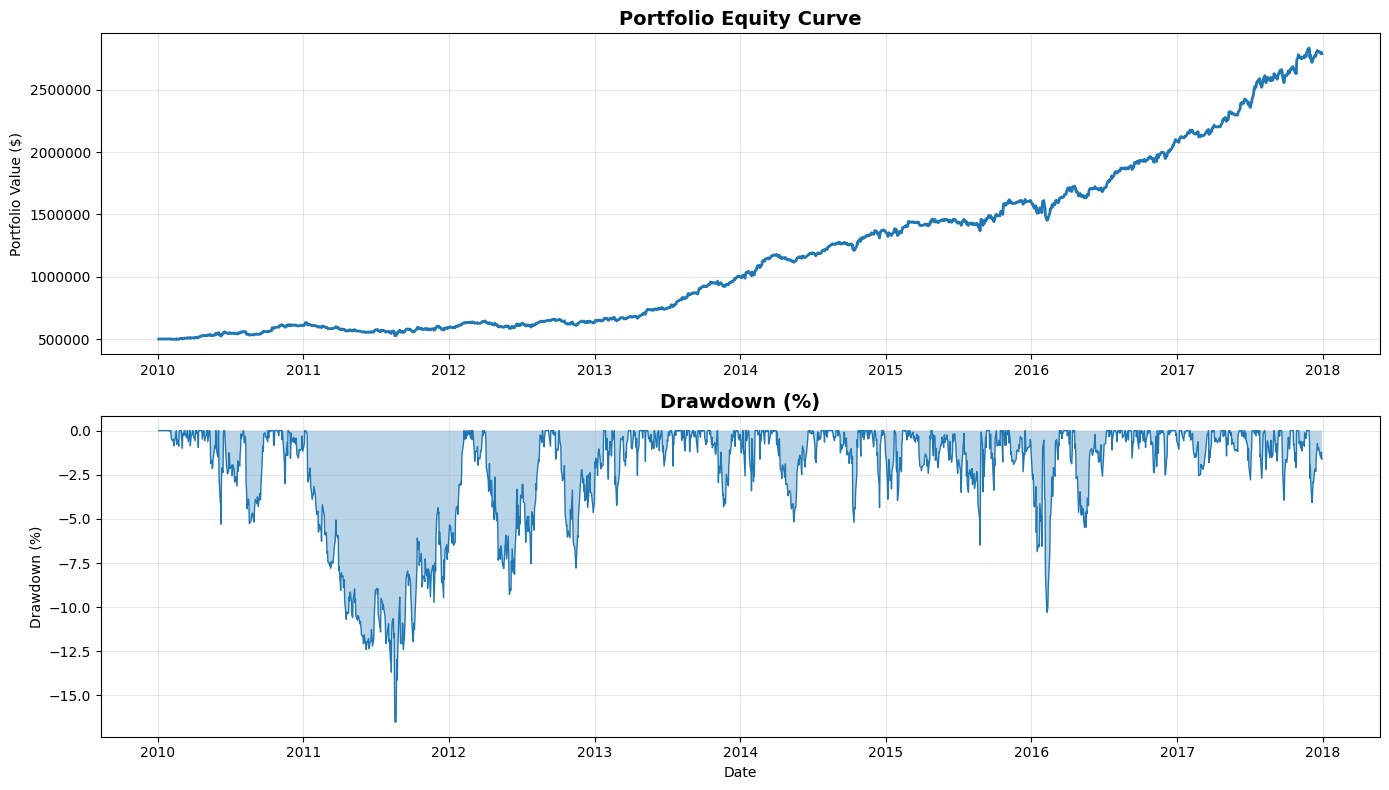


📊 Buy & Hold Strategy on SPY from 2010-01-01 to 2017-12-31

📈 PERFORMANCE METRICS
Initial Capital:        $     500,000.00
Final Portfolio Value:  $   1,396,774.79
Total Return:                    176.99%
CAGR:                             13.73%
Annualized Volatility:            14.62%
Sharpe Ratio:                      0.95
Max Drawdown:                   -18.61%
Calmar Ratio:                      9.51
Sortino Ratio:                     1.20
Omega Ratio:                       1.19
Ulcer Index:                       4.30
UPI (UP Ratio):                    0.53
Skewness:                       -0.3977
Kurtosis:                        4.5643
VaR 95% (% loss):                  1.47
CVaR 95% (% loss):                 2.24
Total Trades:                         1



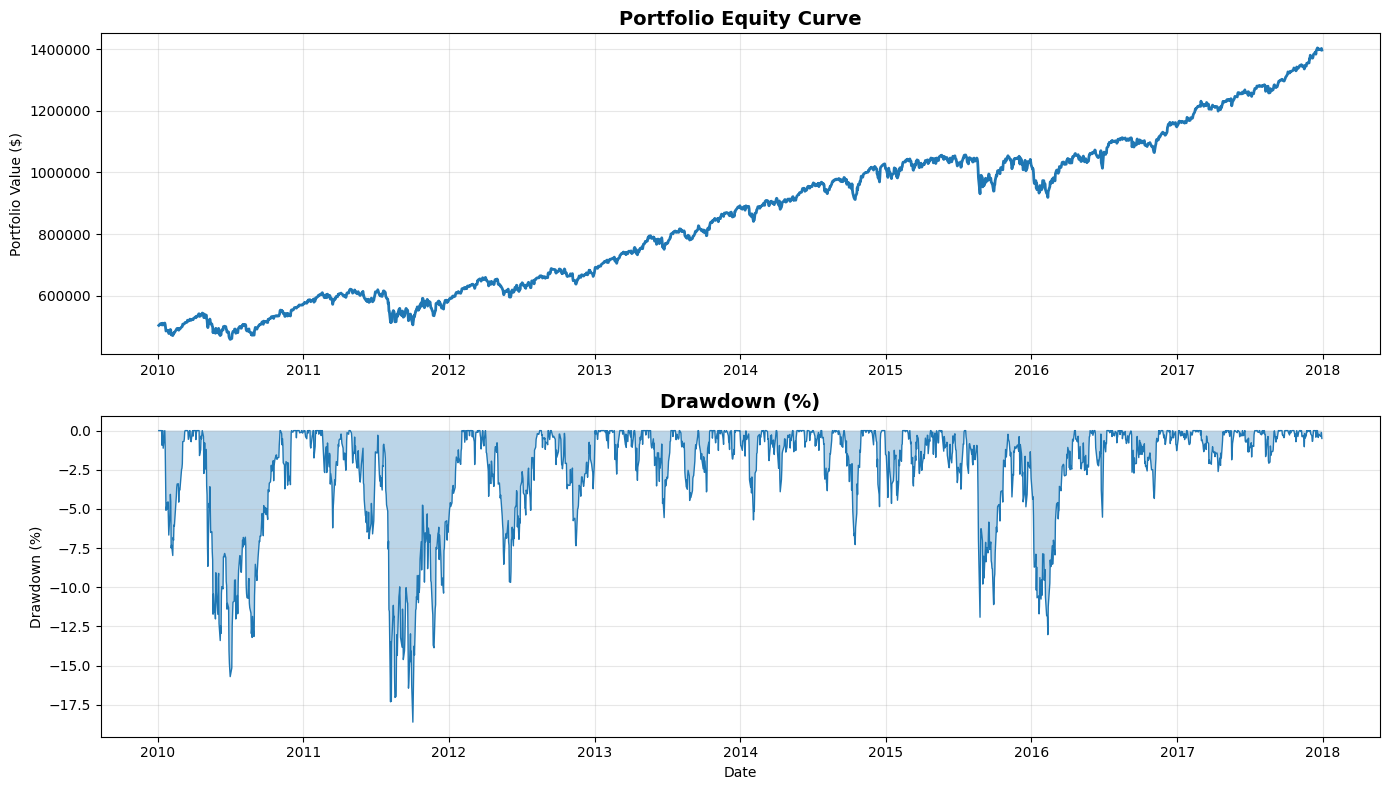

In [ ]:
# @title Testing tunned params in training set 2010 - 2017

# Best parameters found from optimization
best_params = {'macd_fast': 13, 'macd_slow': 35, 'macd_signal': 8, 'macd_std_window': 83, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 15, 'bb_std_dev': 1.4, 'atr_window': 18, 'tp_mult_lm': 3.5, 'sl_mult_lm': 2.1, 'tp_mult_sm': 5.9, 'sl_mult_sm': 1.55, 'tp_mult_lr': 10.6, 'sl_mult_lr': 2.9, 'tp_mult_sr': 5.5, 'sl_mult_sr': 3.1, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': False, 'time_stop': 26, 'cooldown': 0, 'rebounce_block': 2, 'rebalance_freq': 120}

# Config for backtest
tickers = ["AAPL", "AMZN", "META", "GOOG", "GOOGL", "NVDA", "MSFT", "AVGO", "TSLA", "BRK-B"]
start = "2010-01-01"
end = "2017-12-31"
initial_capital = 500000.0
leverage = 0.0
transaction_cost = 0.00

# Start backtesting
print(f"🚀 BACKTESTING in TRAINING PERIOD from {start} to {end}")

# Training result
portfolio_ma, strat_ma, stock_performances = run_multi_stock_backtest_unified(
    tickers, start, end,
    interval="1d",
    initial_capital=initial_capital,
    strategy_class=MACD_BB_ATR_Strategy,
    transaction_cost=transaction_cost,
    params=best_params,
    leverage=leverage,
    verbose=False,
    show_each_stock= False # if you want show the performancen of each stock you can set is to 'True'
)

# Run SPY Benchmark
tickers = ["SPY"]
print("\n" + "=" * 70)
print(f"📊 Buy & Hold Strategy on SPY from {start} to {end}")
print("=" * 70)
portfolio_bh, strat_bh, stock_performances_bh = run_multi_stock_backtest_unified(
    tickers, start, end,
    interval="1d",
    initial_capital=initial_capital,
    strategy_class=BuyAndHold_Strategy,
    transaction_cost=transaction_cost,
    leverage = leverage,
    buyandhold= True,
    verbose=False
)


🚀 BACKTESTING IN TEST PERIOD

📈 PERFORMANCE METRICS
Initial Capital:        $     500,000.00
Final Portfolio Value:  $     793,144.00
Total Return:                     58.63%
CAGR:                             26.09%
Annualized Volatility:            13.32%
Sharpe Ratio:                      1.81
Max Drawdown:                   -10.34%
Calmar Ratio:                      5.67
Beta vs Benchmark:               0.5750
Alpha (annual, %):                17.19
Sortino Ratio:                     2.33
Omega Ratio:                       1.40
Ulcer Index:                       2.44
UPI (UP Ratio):                    0.60
Skewness:                       -0.1736
Kurtosis:                        6.0024
VaR 95% (% loss):                  1.13
CVaR 95% (% loss):                 1.90
Total Trades:                       484



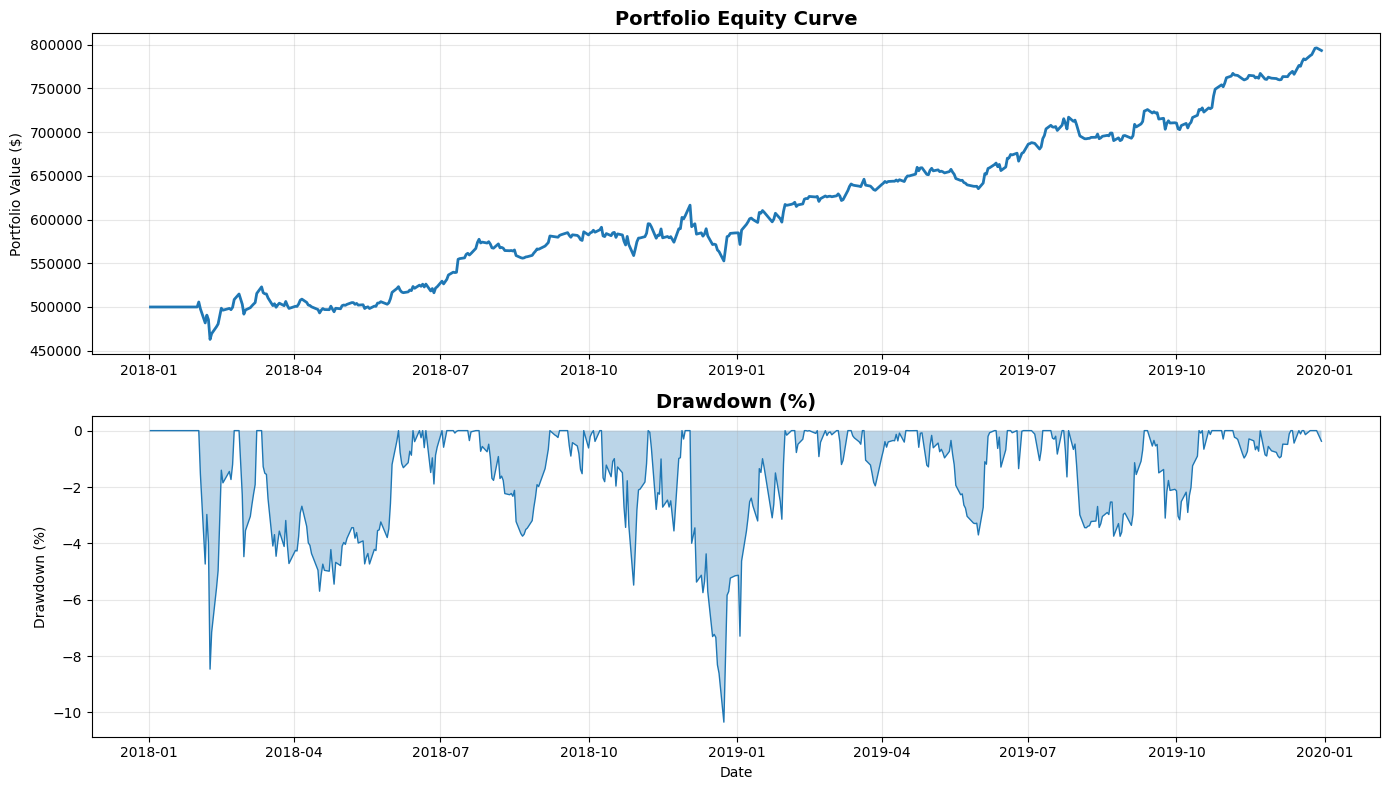


📊 Buy & Hold Strategy on SPY

📈 PERFORMANCE METRICS
Initial Capital:        $     500,000.00
Final Portfolio Value:  $     622,283.68
Total Return:                     24.03%
CAGR:                             11.62%
Annualized Volatility:            14.96%
Sharpe Ratio:                      0.80
Max Drawdown:                   -19.34%
Calmar Ratio:                      1.24
Sortino Ratio:                     0.96
Omega Ratio:                       1.16
Ulcer Index:                       4.99
UPI (UP Ratio):                    0.51
Skewness:                       -0.5263
Kurtosis:                        3.8150
VaR 95% (% loss):                  1.76
CVaR 95% (% loss):                 2.47
Total Trades:                         1



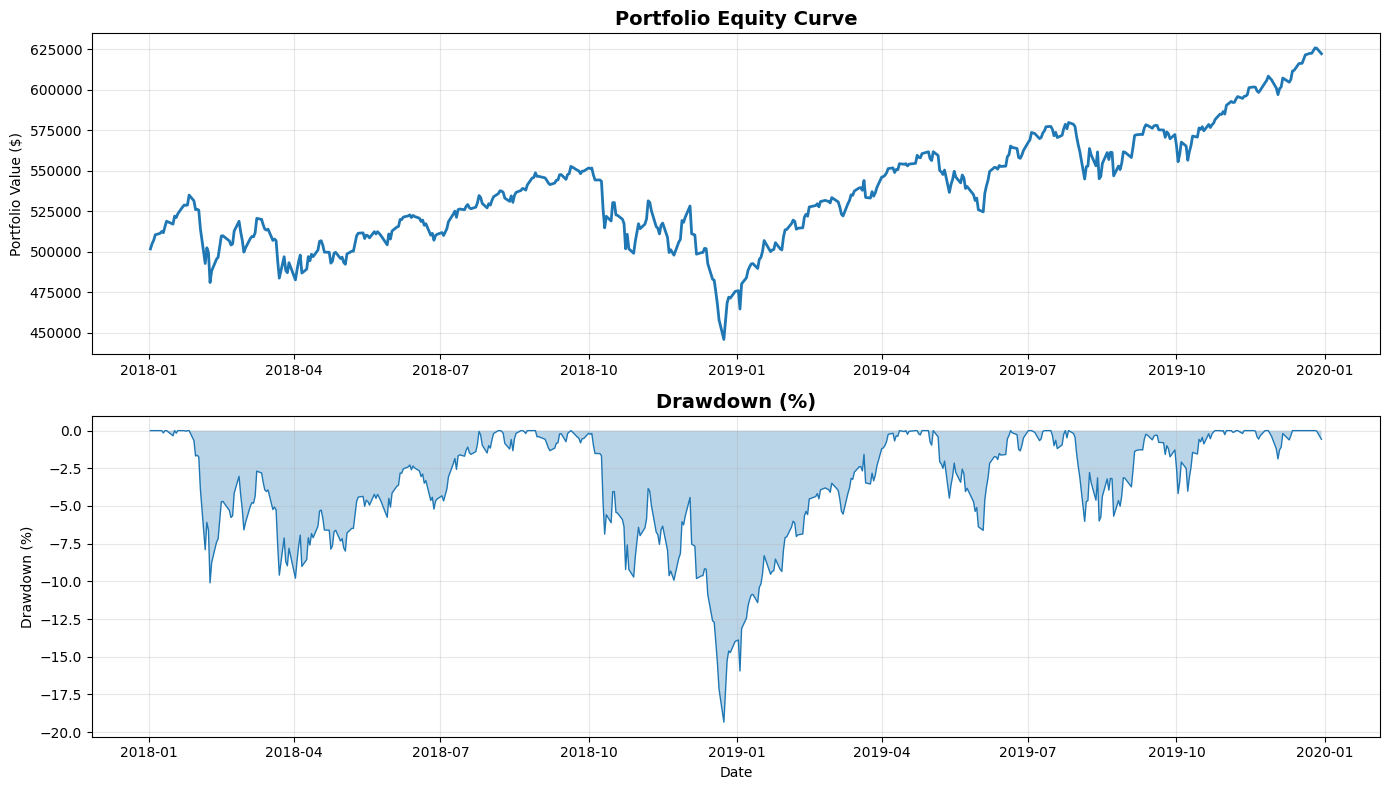

In [ ]:
# @title Testing tunned params in testing set 2018 - 2019 without Portfolio Selection and Allocation

best_params = {'macd_fast': 13, 'macd_slow': 35, 'macd_signal': 8, 'macd_std_window': 83, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 15, 'bb_std_dev': 1.4, 'atr_window': 18, 'tp_mult_lm': 3.5, 'sl_mult_lm': 2.1, 'tp_mult_sm': 5.9, 'sl_mult_sm': 1.55, 'tp_mult_lr': 10.6, 'sl_mult_lr': 2.9, 'tp_mult_sr': 5.5, 'sl_mult_sr': 3.1, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': False, 'time_stop': 26, 'cooldown': 0, 'rebounce_block': 2, 'rebalance_freq': 120}

tickers = ["AAPL", "AMZN", "META", "GOOG", "GOOGL", "NVDA", "MSFT", "AVGO", "TSLA", "BRK-B"]
start = "2018-01-01"
end = "2019-12-31"
initial_capital = 500000.0
transaction_cost = 0.00
leverage = 0.0

print("🚀 BACKTESTING IN TEST PERIOD")

portfolio_test, strat_test, stock_performances_test = run_multi_stock_backtest_unified(
    tickers, start, end,
    interval="1d",
    initial_capital=initial_capital,
    strategy_class=MACD_BB_ATR_Strategy,
    transaction_cost=transaction_cost,
    params=best_params,
    verbose=False,
    leverage = leverage,
    show_each_stock=False
)

tickers = ["SPY"]

# Run SPY Benchmark
print("\n" + "=" * 70)
print("📊 Buy & Hold Strategy on SPY")
print("=" * 70)
portfolio_bh, strat_bh, stock_performances_bh = run_multi_stock_backtest_unified(
    tickers, start, end,
    interval="1d",
    initial_capital=initial_capital,
    strategy_class=BuyAndHold_Strategy,
    transaction_cost=transaction_cost,
    leverage = leverage,
    buyandhold=True,
    verbose=False
)

📦 Strategy return matrix built: (2013, 10) (days × symbols)
📈 Mean annualized return: 0.213658
💠 Covariance matrix (after shrinkage): (10, 10)
🚀 Tangent Portfolio — Sharpe: 2.062
   Return: 0.2143, Volatility: 0.1039
✅ Efficient frontier computed analytically (30 points).

🎯 Selected 6 active stocks:
   AVGO: 0.2106 (21.06%)
   META: 0.1901 (19.01%)
   TSLA: 0.1835 (18.35%)
   GOOG: 0.1748 (17.48%)
   GOOGL: 0.1234 (12.34%)
   AAPL: 0.1176 (11.76%)
✅ Total = 1.0000

📋 Final Portfolio Weights:
Stock  Weight
 AVGO  0.1828
 META  0.1651
 TSLA  0.1593
 GOOG  0.1518
GOOGL  0.1071
 AAPL  0.1021
 MSFT  0.0527
 AMZN  0.0466
 NVDA  0.0200
BRK-B  0.0123

✅ Selected: ['AVGO', 'META', 'TSLA', 'GOOG', 'GOOGL', 'AAPL']
💰 Allocations: {'AVGO': 0.2106, 'META': 0.1901, 'TSLA': 0.1835, 'GOOG': 0.1748, 'GOOGL': 0.1234, 'AAPL': 0.1176}


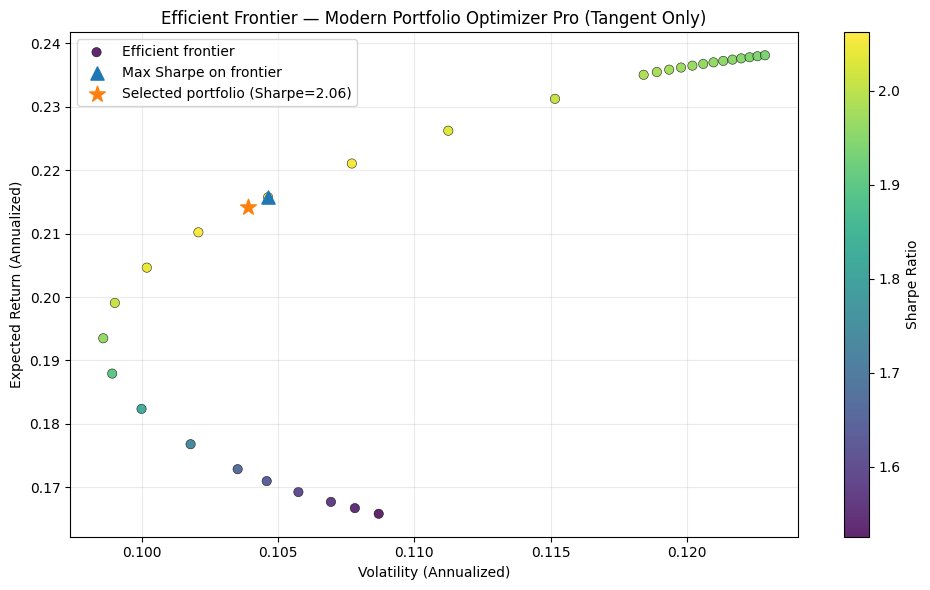

In [ ]:
# @title Portfolio Selection & Allocation (Training Period)


# Initialize the portfolio optimizer using the strategy's per-stock
optimizer = ModernPortfolioOptimizerPro(
    stock_equity_history=strat_ma.stock_equity_history,  # input from strategy backtest
    top_k=6,          # select the top 6 assets by weight
    verbose=True      # show detailed diagnostic output
)

# Run full Tangent (Max-Sharpe) optimization pipeline
frontier, selectedTicker, allocationPortfolio = optimizer.run(
    mode="tangent",   # always tangent portfolio internally
    risk_free_rate=0, # assuming zero risk-free rate for Sharpe calculation
    long_only=True    # enforce long-only allocations (no negative weights)
)

# Display results
print("\n✅ Selected:", selectedTicker)        # list of chosen tickers
print("💰 Allocations:", allocationPortfolio) # ticker → weight mapping

# Plot the efficient frontier + tangent portfolio highlight
optimizer.plot_efficient_frontier(frontier)


**Test again the strategy with portfolio selection and allocation**

🚀 BACKTESTING IN TEST PERIOD

📈 PERFORMANCE METRICS
Initial Capital:        $     500,000.00
Final Portfolio Value:  $     880,327.12
Total Return:                     76.07%
CAGR:                             32.87%
Annualized Volatility:            15.29%
Sharpe Ratio:                      1.93
Max Drawdown:                    -9.43%
Calmar Ratio:                      8.06
Beta vs Benchmark:               0.5043
Alpha (annual, %):                23.56
Sortino Ratio:                     2.73
Omega Ratio:                       1.43
Ulcer Index:                       2.71
UPI (UP Ratio):                    0.64
Skewness:                        0.2323
Kurtosis:                        4.2945
VaR 95% (% loss):                  1.43
CVaR 95% (% loss):                 2.04
Total Trades:                       278



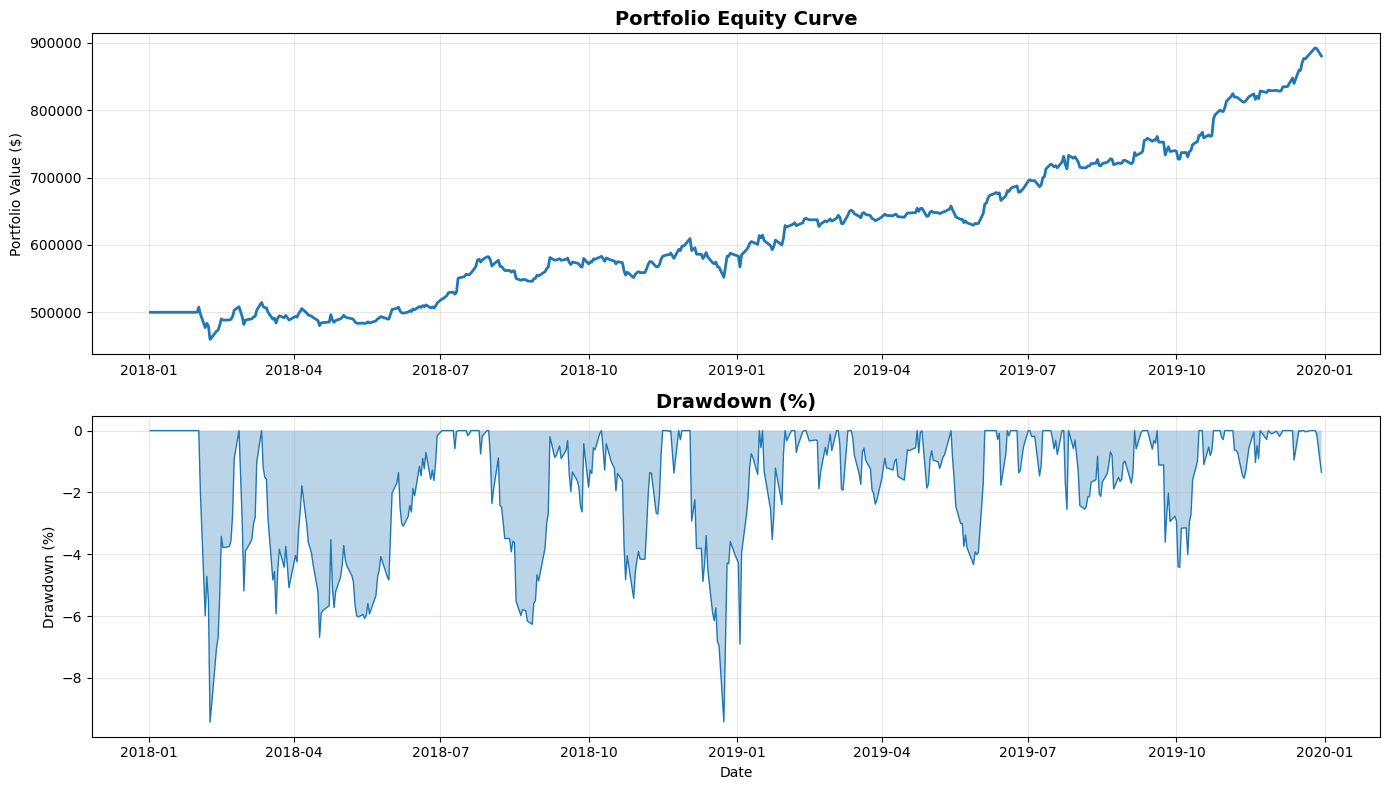


📊 PER-STOCK PERFORMANCE
AVGO:
  Initial Capital: $  105,300.00
  Final Value:     $  173,567.66
  Return:                 64.83%
  Total Trades:              50
----------------------------------------------------------------------
META:
  Initial Capital: $   95,050.00
  Final Value:     $  160,927.40
  Return:                 69.31%
  Total Trades:              44
----------------------------------------------------------------------
TSLA:
  Initial Capital: $   91,750.00
  Final Value:     $  190,254.35
  Return:                107.36%
  Total Trades:              42
----------------------------------------------------------------------
GOOG:
  Initial Capital: $   87,400.00
  Final Value:     $  144,710.98
  Return:                 65.57%
  Total Trades:              46
----------------------------------------------------------------------
GOOGL:
  Initial Capital: $   61,700.00
  Final Value:     $  102,158.67
  Return:                 65.57%
  Total Trades:              48
-----

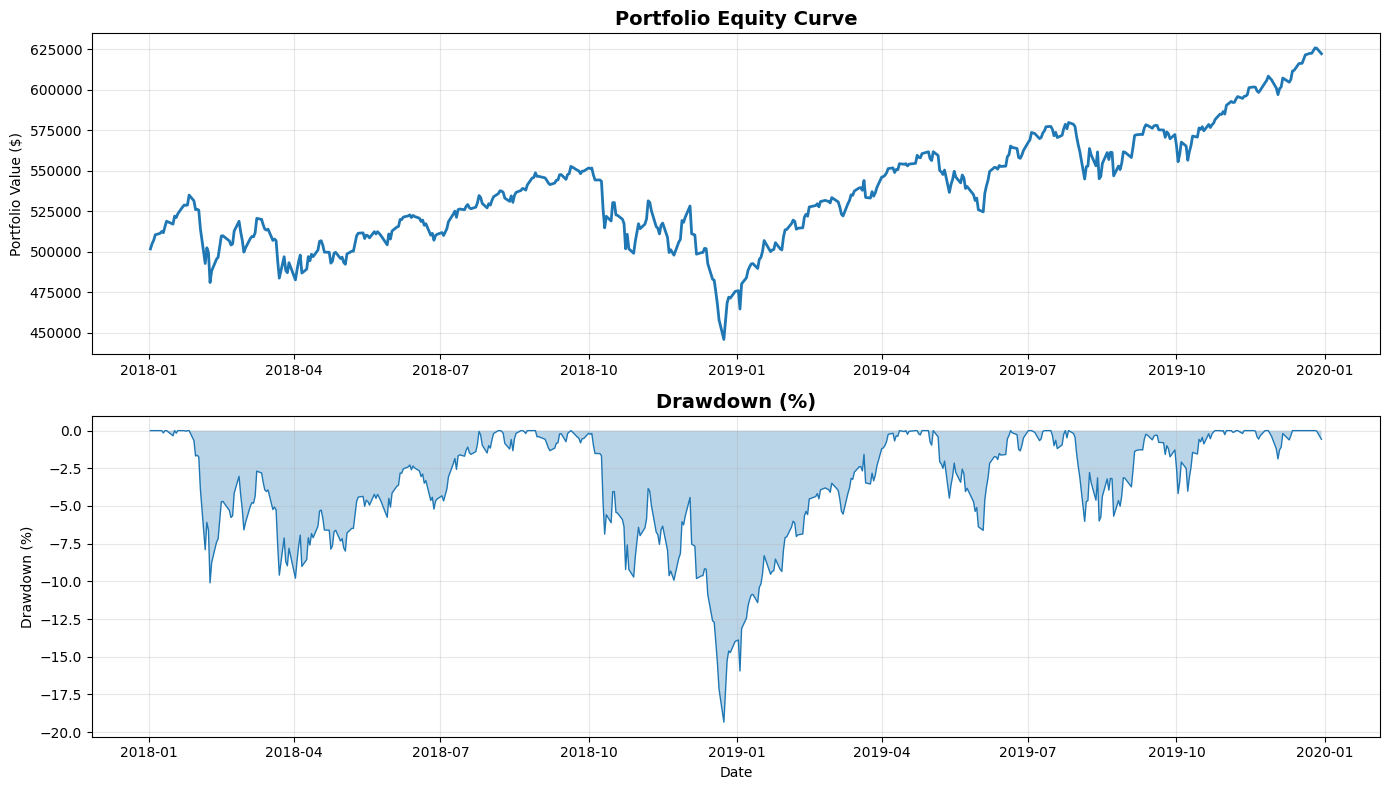

In [ ]:
# @title Test again the strategy with portfolio selection and allocation

best_params = {'macd_fast': 13, 'macd_slow': 35, 'macd_signal': 8, 'macd_std_window': 83, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 15, 'bb_std_dev': 1.4, 'atr_window': 18, 'tp_mult_lm': 3.5, 'sl_mult_lm': 2.1, 'tp_mult_sm': 5.9, 'sl_mult_sm': 1.55, 'tp_mult_lr': 10.6, 'sl_mult_lr': 2.9, 'tp_mult_sr': 5.5, 'sl_mult_sr': 3.1, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': False, 'time_stop': 26, 'cooldown': 0, 'rebounce_block': 2, 'rebalance_freq': 120}

tickers = selectedTicker # ['AVGO', 'META', 'TSLA', 'GOOG', 'GOOGL', 'AAPL']
allocations = allocationPortfolio # {'AVGO': 0.2106, 'META': 0.1901, 'TSLA': 0.1835, 'GOOG': 0.1748, 'GOOGL': 0.1234, 'AAPL': 0.1176}
start = "2018-01-01"
end = "2019-12-31"
initial_capital = 500000.0
transaction_cost = 0.00
leverage = 0.0

print("🚀 BACKTESTING IN TEST PERIOD")

portfolio_test, strat_test, stock_performances_test = run_multi_stock_backtest_unified(
    tickers, start, end,
    interval="1d",
    initial_capital=initial_capital,
    strategy_class=MACD_BB_ATR_Strategy,
    transaction_cost=transaction_cost,
    params=best_params,
    leverage = leverage,
    verbose=False,
    allocations = allocations,
    show_each_stock=True
)

tickers = ["SPY"]

# Run SPY Benchmark
print("\n" + "=" * 70)
print("📊 Buy & Hold Strategy on SPY")
print("=" * 70)
portfolio_bh, strat_bh, stock_performances = run_multi_stock_backtest_unified(
    tickers, start, end,
    interval="1d",
    initial_capital=initial_capital,
    strategy_class=BuyAndHold_Strategy,
    transaction_cost=transaction_cost,
    buyandhold=True,
    verbose=False
)

#**7. Measure Performance**

**Strategy Visualization Module**

**StrategyAdapter**  
- Extracts `PortfolioValue` from a completed strategy run.  
- Normalizes it to **growth of $1** and computes **daily returns**.  
- Provides `get_equity()` and `get_returns()` for plotting.

**PortfolioVisualizer**  
- Takes a strategy + benchmark, aligns dates, and normalizes both.  
- Computes:  
  - Daily returns & equity  
  - Drawdown  
  - Rolling 6-month return & volatility  
  - Monthly and yearly return stats

**plot_performance_dashboard()**  
Generates a 4-panel dashboard:  
1) Equity curve (strategy vs benchmark)  
2) Monthly returns (bar chart)  
3) Monthly heatmap  
4) Q–Q plot of monthly returns

**plot_risk_dashboard()**  
Generates a risk dashboard:  
1) Drawdown comparison  
2) Monthly return distribution  
3) Rolling return & vol (strategy)  
4) Rolling return & vol (benchmark)



In [ ]:
# @title Visualisation class
class StrategyAdapter:
    def __init__(self, strat, name: str | None = None, use_returns: bool = True):
        self.strat = strat
        self._name = name or strat.__class__.__name__
        self._use_returns = use_returns

        if not hasattr(strat, "portfolio_df"):
            raise ValueError("Run the strategy first; 'portfolio_df' not found.")

        eq = strat.portfolio_df["PortfolioValue"].copy().dropna()
        eq.index = pd.to_datetime(eq.index)
        eq = eq.sort_index()

        # Normalize to growth-of-$1 for plotting
        self._equity = eq / eq.iloc[0]
        self._returns = self._equity.pct_change().dropna()

    def get_name(self) -> str:
        return self._name

    def get_equity(self) -> pd.Series | None:
        return None if self._use_returns else self._equity

    def get_returns(self) -> pd.Series | None:
        return self._returns if self._use_returns else None

class PortfolioVisualizer:
    def __init__(
        self,
        strategy,
        benchmark_returns: pd.Series | None = None,
        benchmark_equity: pd.Series | None = None,
        benchmark_name: str = "Benchmark",
        title_prefix: str = "Strategy",
        trading_days: int = 252,
        *,
        theme: str = "plotly_white"
    ):
        self.title_prefix = title_prefix
        self.benchmark_name = benchmark_name
        self.TRADING_DAYS = trading_days
        self.theme = theme

        # ---- Strategy normalization ----
        s_ret = strategy.get_returns()
        s_eq  = strategy.get_equity()
        if s_eq is None and s_ret is None:
            raise ValueError("Strategy must provide returns or equity.")

        if s_eq is None:
            s_ret = pd.Series(s_ret).dropna()
            s_ret.index = pd.to_datetime(s_ret.index)
            s_eq = (1.0 + s_ret).cumprod()
        else:
            s_eq = pd.Series(s_eq).dropna()
            s_eq.index = pd.to_datetime(s_eq.index)
            s_ret = s_eq.pct_change().dropna()

        self.strategy_name = getattr(strategy, "get_name", lambda: "Strategy")()
        self.strat_ret = s_ret
        self.strat_eq  = s_eq

        # Benchmark normalization
        if benchmark_equity is None and benchmark_returns is None:
            raise ValueError("Provide benchmark_returns or benchmark_equity.")

        if benchmark_equity is None:
            b = pd.Series(benchmark_returns).dropna()
            b.index = pd.to_datetime(b.index)
            self.bm_ret = b
            self.bm_eq  = (1.0 + b).cumprod()
        else:
            e = pd.Series(benchmark_equity).dropna()
            e.index = pd.to_datetime(e.index)
            self.bm_eq = e
            self.bm_ret = e.pct_change().dropna()

        #align on common dates
        idx = self.strat_eq.index.intersection(self.bm_eq.index)
        self.strat_eq  = self.strat_eq.loc[idx]
        self.bm_eq     = self.bm_eq.loc[idx]
        self.strat_ret = self.strat_ret.loc[idx]
        self.bm_ret    = self.bm_ret.loc[idx]

        # risk & rolling
        self.strat_dd = self._drawdown_series(self.strat_eq)
        self.bm_dd    = self._drawdown_series(self.bm_eq)

        win = max(1, int(self.TRADING_DAYS * 0.5))  # ~6 months
        self.strat_roll_ret = (1 + self.strat_ret).rolling(win).apply(np.prod, raw=True) - 1.0
        self.strat_roll_vol = self.strat_ret.rolling(win).std(ddof=0) * np.sqrt(self.TRADING_DAYS)
        self.bm_roll_ret    = (1 + self.bm_ret).rolling(win).apply(np.prod, raw=True) - 1.0
        self.bm_roll_vol    = self.bm_ret.rolling(win).std(ddof=0) * np.sqrt(self.TRADING_DAYS)

        self.monthly_ret = self._monthly_returns(self.strat_ret)
        self.yearly_ret  = self._yearly_returns(self.strat_ret)

    @staticmethod
    def _monthly_returns(daily_ret: pd.Series) -> pd.Series:
        s = pd.Series(daily_ret).dropna()
        s.index = pd.to_datetime(s.index)
        return s.resample("ME").apply(lambda x: (1.0 + x).prod() - 1.0)

    @staticmethod
    def _yearly_returns(daily_ret: pd.Series) -> pd.Series:
        s = pd.Series(daily_ret).dropna()
        s.index = pd.to_datetime(s.index)
        y = s.resample("YE").apply(lambda x: (1.0 + x).prod() - 1.0)
        y.index = y.index.year
        return y

    @staticmethod
    def _drawdown_series(eq: pd.Series) -> pd.Series:
        roll_max = eq.cummax()
        return eq / roll_max - 1.0

    @staticmethod
    def _cagr(eq: pd.Series) -> float:
        days = (eq.index[-1] - eq.index[0]).days
        years = max(days, 1) / 365.25
        return float((eq.iloc[-1] / eq.iloc[0])**(1/years) - 1)

    @staticmethod
    def _maxdd(eq: pd.Series) -> float:
        dd = eq / eq.cummax() - 1.0
        return float(dd.min())

    def plot_performance_dashboard(self):
        fig = make_subplots(
            rows=2,
            cols=2,
            subplot_titles=(
                "Equity Performance — Strategy vs Benchmark",
                f"Monthly Returns — {self.strategy_name}",
                "Monthly Returns Heatmap — Strategy",
                "Normal Q–Q — Strategy Monthly Returns",
            ),
            vertical_spacing=0.12,
            horizontal_spacing=0.08,
        )

        aligned = pd.concat(
            [
                self.strat_eq.rename(self.strategy_name),
                self.bm_eq.rename(self.benchmark_name),
            ],
            axis=1,
        ).dropna()
        aligned = aligned / aligned.iloc[0]  # growth of $1

        fig.add_trace(
            go.Scatter(
                x=aligned.index,
                y=aligned.iloc[:, 0],
                mode="lines",
                name=self.strategy_name,
            ),
            row=1,
            col=1,
        )
        fig.add_trace(
            go.Scatter(
                x=aligned.index,
                y=aligned.iloc[:, 1],
                mode="lines",
                name=self.benchmark_name,
                line=dict(dash="dash"),
            ),
            row=1,
            col=1,
        )
        fig.update_yaxes(title_text="Growth of $1", row=1, col=1)

        mret = self.monthly_ret.dropna()
        fig.update_yaxes(title_text="Return", tickformat=".1%", row=1, col=2)

        if len(mret) > 0:
            colors = ["#2ca02c" if v > 0 else "#d62728" for v in mret.values]

            fig.add_trace(
                go.Bar(
                    x=mret.index,
                    y=mret.values,
                    marker_color=colors,
                    name="Monthly Return",
                ),
                row=1,
                col=2,
            )

            mean_val = float(mret.mean())
            fig.add_hline(
                y=mean_val,
                row=1,
                col=2,
                line_dash="dot",
                line_color="black",
                annotation_text=f"Mean: {mean_val*100:.2f}%",
                annotation_position="top left",
            )

        heat = self.monthly_ret.to_frame("ret").copy()

        if not heat.empty:
            heat["Year"] = heat.index.year
            heat["Month"] = heat.index.month

            pivot = heat.pivot(index="Year", columns="Month", values="ret").sort_index()
            pivot = pivot.reindex(columns=range(1, 13))  # months 1..12

            vals = (pivot.values * 100.0).astype(float)   # convert to %
            month_labels = ["Jan","Feb","Mar","Apr","May","Jun",
                            "Jul","Aug","Sep","Oct","Nov","Dec"]
            year_labels = [str(int(y)) for y in pivot.index.to_numpy()]

            text_vals = np.where(np.isnan(vals), "", np.round(vals, 2))

            fig.add_trace(
                go.Heatmap(
                    z=vals,
                    x=month_labels,
                    y=year_labels,
                    colorscale="RdYlGn",
                    zmid=0.0,
                    # data labels
                    text=text_vals,
                    texttemplate="%{text}%",
                    textfont=dict(size=9),
                    colorbar=dict(
                        title="Monthly Return (%)",
                        titleside="right",
                        x=-0.07,          # you can tweak this
                        xanchor="right",
                        y=0.25,
                        yanchor="middle",
                        len=0.60,
                        thickness=12,
                        tickfont=dict(size=10),
                        titlefont=dict(size=11),
                    ),
                    hovertemplate=(
                        "Year %{y}<br>"
                        "Month %{x}<br>"
                        "Return %{z:.2f}%<extra></extra>"
                    ),
                ),
                row=2,
                col=1,
            )

            fig.update_xaxes(title_text="Month", row=2, col=1)
            fig.update_yaxes(title_text="Year",  row=2, col=1)

        if len(mret) >= 2:
            # sort observed monthly returns
            y = np.sort(mret.values)

            # theoretical quantiles U ~ Uniform(0,1) then inverse normal CDF
            u = (np.arange(1, len(y) + 1) - 0.5) / len(y)

            # if you have SciPy, use scipy_norm.ppf(u)
            # otherwise assume you have _norm_ppf(u) defined somewhere
            try:
                x = self.scipy_norm.ppf(u)
            except AttributeError:
                x = _norm_ppf(u)  # your own approximation

            fig.add_trace(
                go.Scatter(
                    x=x,
                    y=y,
                    mode="markers",
                    name="QQ Points",
                    marker=dict(size=6, color="#ff7f0e"),
                    hovertemplate=(
                        "Theoretical: %{x:.3f}<br>"
                        "Observed: %{y:.2%}<extra></extra>"
                    ),
                ),
                row=2,
                col=2,
            )

            lo = float(min(x.min(), y.min()))
            hi = float(max(x.max(), y.max()))

            fig.add_trace(
                go.Scatter(
                    x=[lo, hi],
                    y=[lo, hi],
                    mode="lines",
                    name="45°",
                    line=dict(dash="dash", width=1),
                    hoverinfo="skip",
                ),
                row=2,
                col=2,
            )

            fig.update_yaxes(
                tickformat=".0%",
                title_text="Observed Quantile",
                row=2,
                col=2,
            )
            fig.update_xaxes(
                title_text="Normal Quantile",
                row=2,
                col=2,
            )

        fig.update_layout(
            title=dict(
                text=f"{self.title_prefix} — Performance Dashboard",
                x=0.5,
                xanchor="center",
                y=0.98,
                yanchor="top",
            ),
            legend=dict(
                orientation="h",
                x=0.5,
                xanchor="center",
                y=1.06,          # > 1 => in the top margin
                yanchor="bottom",
            ),
            margin=dict(t=120),  # give space for title + legend
            hovermode="x unified",
            height=900,
        )


        fig.show()

    def plot_risk_dashboard(self):
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=(
                "Drawdown — Strategy vs Benchmark",
                f"Distribution of Monthly Returns — {self.strategy_name}",
                f"Rolling 6-Month Return & Volatility — {self.strategy_name}",
                f"Rolling 6-Month Return & Volatility — {self.benchmark_name}",
            ),
            specs=[[{"type":"xy"}, {"type":"xy"}],
                   [{"type":"xy"}, {"type":"xy"}]],
            horizontal_spacing=0.09, vertical_spacing=0.12
        )

        # (1) Drawdown (area to zero)
        fig.add_trace(go.Scatter(
            x=self.strat_dd.index, y=self.strat_dd.values*100,
            name=f"{self.strategy_name} DD", mode="lines",
            fill="tozeroy", line=dict(width=1.8)
        ), row=1, col=1)
        fig.add_trace(go.Scatter(
            x=self.bm_dd.index, y=self.bm_dd.values*100,
            name=f"{self.benchmark_name} DD", mode="lines",
            fill="tozeroy", line=dict(width=1.3, dash="dot")
        ), row=1, col=1)
        fig.update_yaxes(title_text="Drawdown (%)", row=1, col=1)

        # (2) Monthly return distribution — FIXED (bars with mean line)
        mret = self.monthly_ret
        if len(mret):
            fig.add_trace(go.Histogram(
                x=mret.values * 100,
                nbinsx=15,
                name="Monthly Returns",
                marker=dict(color="rgba(50,150,255,0.6)",
                            line=dict(width=0.8, color="black")),
                hovertemplate="%{x:.2f}%<extra></extra>"
            ), row=1, col=2)

            mean_pct = float(mret.mean() * 100)
            fig.add_vline(
                x=mean_pct, row=1, col=2,
                line_dash="dash", line_width=1, line_color="black",
                annotation_text=f"Mean: {mean_pct:.2f}%",
                annotation_position="top right"
            )
            fig.update_xaxes(title_text="Monthly Return (%)", row=1, col=2)
            fig.update_yaxes(title_text="Frequency", row=1, col=2)

        # (3) Rolling — Strategy
        fig.add_trace(go.Scatter(
            x=self.strat_roll_ret.index, y=self.strat_roll_ret.values*100,
            name="Rolling Return (6m)", mode="lines", line=dict(width=1.8)
        ), row=2, col=1)
        fig.add_trace(go.Scatter(
            x=self.strat_roll_vol.index, y=self.strat_roll_vol.values*100,
            name="Rolling Vol (6m)", mode="lines", line=dict(width=1.4)
        ), row=2, col=1)
        fig.update_yaxes(title_text="Percent", row=2, col=1)

        # (4) Rolling — Benchmark
        fig.add_trace(go.Scatter(
            x=self.bm_roll_ret.index, y=self.bm_roll_ret.values*100,
            name="Rolling Return (6m)", mode="lines", line=dict(width=1.8)
        ), row=2, col=2)
        fig.add_trace(go.Scatter(
            x=self.bm_roll_vol.index, y=self.bm_roll_vol.values*100,
            name="Rolling Vol (6m)", mode="lines", line=dict(width=1.4)
        ), row=2, col=2)
        fig.update_yaxes(title_text="Percent", row=2, col=2)

        fig.update_layout(
            template=self.theme,
            title=dict(
                text=f"<b>{self.title_prefix} — Risk Dashboard</b>",
                x=0.5,
                xanchor="center",
                y=0.98,
                yanchor="top",
            ),
            legend=dict(
                orientation="h",
                x=0.5,
                xanchor="center",
                y=1.06,          # right below the header, in the margin
                yanchor="bottom",
            ),
            margin=dict(t=120),
            hovermode="x unified",
            height=800,
            font=dict(family="Helvetica Neue, Arial", size=12),
            title_font=dict(size=18),
            hoverlabel=dict(bgcolor="white", font_size=11),
        )


        fig.show()

def _norm_ppf(p):
    a1=-3.969683028665376e+01; a2= 2.209460984245205e+02
    a3=-2.759285104469687e+02; a4= 1.383577518672690e+02
    a5=-3.066479806614716e+01; a6= 2.506628277459239e+00
    b1=-5.447609879822406e+01; b2= 1.615858368580409e+02
    b3=-1.556989798598866e+02; b4= 6.680131188771972e+01
    b5=-1.328068155288572e+01
    c1=-7.784894002430293e-03; c2=-3.223964580411365e-01
    c3=-2.400758277161838e+00; c4=-2.549732539343734e+00
    c5= 4.374664141464968e+00; c6= 2.938163982698783e+00
    d1= 7.784695709041462e-03; d2= 3.224671290700398e-01
    d3= 2.445134137142996e+00; d4= 3.754408661907416e+00
    plow = 0.02425; phigh = 1 - plow
    p = np.asarray(p)
    q = np.zeros_like(p, dtype=float)

    mask = p < plow
    if np.any(mask):
        ql = np.sqrt(-2*np.log(p[mask]))
        q[mask] = (((((c1*ql + c2)*ql + c3)*ql + c4)*ql + c5)*ql + c6) / \
                  ((((d1*ql + d2)*ql + d3)*ql + d4)*ql + 1)

    mask = (p >= plow) & (p <= phigh)
    if np.any(mask):
        r = p[mask] - 0.5
        t = r*r
        q[mask] = (((((a1*t + a2)*t + a3)*t + a4)*t + a5)*t + a6)*r / \
                  (((((b1*t + b2)*t + b3)*t + b4)*t + b5)*t + 1)

    mask = p > phigh
    if np.any(mask):
        qu = np.sqrt(-2*np.log(1-p[mask]))
        q[mask] = -(((((c1*qu + c2)*qu + c3)*qu + c4)*qu + c5)*qu + c6) / \
                    ((((d1*qu + d2)*qu + d3)*qu + d4)*qu + 1)
    return q


In [ ]:
# @title Visualize Strategy vs SPY Benchmark

# Wrap test-period strategy into adapter (normalized equity & returns)
strat_adapter = StrategyAdapter(
    strat_test,
    name="MACD+BB+ATR",   # label shown in charts
    use_returns=True      # use returns as primary input
)

# Build SPY benchmark returns from its portfolio equity
spy_equity = strat_bh.portfolio_df["PortfolioValue"].copy().dropna()
spy_equity.index = pd.to_datetime(spy_equity.index)
spy_ret = spy_equity.pct_change().dropna()   # daily returns for SPY Buy & Hold

# Initialize visualizer: strategy vs SPY benchmark
viz = PortfolioVisualizer(
    strategy=strat_adapter,
    benchmark_returns=spy_ret,
    benchmark_name="SPY Buy & Hold",
    title_prefix="MACD+BB+ATR vs SPY"
)

# Plot performance (equity, monthly returns, heatmap, QQ)
viz.plot_performance_dashboard()

# Plot risk (drawdowns, distribution, rolling return/vol)
viz.plot_risk_dashboard()


## Strategy Performance Summary

### 1. Equity Performance - Strategy vs Benchmark

The equity curve compares the cumulative growth of \$1 invested in the **MACD+BB+ATR strategy** versus **SPY Buy & Hold** over the test window.

- The strategy generates a **steadily rising equity line**, particularly from mid-2018 onwards, finishing close to **1.8×** the starting value (**32.87% annualized return**).
- SPY Buy & Hold ends nearer **1.2×**, with more visible pauses and drawdowns (**11.62% annualized return**).
- The strategy also recovers more quickly from pullbacks, indicating **better drawdown control and compounding efficiency** than a passive market exposure.

---

### 2. Monthly Returns - MACD+BB+ATR

The bar chart of monthly returns summarises the short-horizon behaviour of the strategy.

- Most bars are **green**, with returns clustering in the **0–5%** range.
- Several months (e.g. mid-2018, mid-2019) show **double-digit gains**, reflecting the strategy’s ability to capture strong momentum bursts.
- Loss months (red bars) are generally modest; the horizontal dashed line at about **2.48%** marks a **positive average monthly return**, confirming a favourable edge.

---

### 3. Monthly Returns Heatmap - Strategy

The heatmap provides a calendar view of monthly performance across 2018–2019.

- The grid is dominated by **light and dark green cells**, signalling frequent positive months.
- The most profitable month **~13.35%** in July 2018.
- Stand-out months such as **July 2018, June 2019 and November 2019** deliver outsized gains.
- Negative months appear as isolated orange/red cells rather than long streaks, suggesting that **drawdowns are typically short-lived and followed by recovery**.
- Overall, the heatmap shows **good consistency and limited performance clustering on the downside**.

---

### 4. Normal Q–Q - Strategy Monthly Returns

The Q–Q plot compares empirical monthly returns of the strategy with a theoretical normal distribution.

- Points in the middle lie close to the diagonal, indicating that **small day-to-day fluctuations are roughly symmetric**.
- Deviations in the upper tail show that **large positive months occur more often** than a normal model would predict.
- The lower tail is relatively compressed, implying **downside moves are more contained** than upside bursts.
- This pattern is consistent with a return profile that is **positively skewed and mildly fat-tailed**—desirable characteristics for a trading strategy.

---

### 5. Drawdown - Strategy vs Benchmark

This panel displays percentage drawdowns for both the strategy and SPY.

- SPY experiences **deep and prolonged drawdowns**, with troughs approaching **-20%** around late-2018.
- The MACD+BB+ATR strategy also suffers pullbacks, but these are **shallower and shorter in duration**, with most drawdowns remaining in the **single-digit** range (**max ~ -10%**).
- The tighter blue area relative to the red area reflects **lower path risk**, helping to smooth the ride for investors even when markets are stressed.

---

### 6. Distribution of Monthly Returns - MACD+BB+ATR

The histogram summarises the frequency of monthly returns across the test period.

- The centre of the distribution sits clearly **above zero**, consistent with the positive average monthly return (~**2.48%**).
- There is a **longer right tail**, representing occasional strong positive months above **8–10%**.
- The left tail (loss months) is shorter and concentrated, suggesting that **losses are capped while gains can occasionally be large**.
- Overall, this distribution supports a **favourable payoff asymmetry**, where upside dominates downside.

---

### 7. Rolling 6-Month Return & Volatility - MACD+BB+ATR

This chart tracks the strategy’s rolling 6-month return and annualised volatility.

- Rolling returns trend upwards over the sample, reaching above **30%** toward the end of 2019, even as markets remained volatile.
- Rolling volatility moves in cycles, rising during stress periods but not exploding, indicating that **risk is actively managed rather than passively absorbed**.
- Periods of elevated volatility are often accompanied by **higher rolling returns**, suggesting the strategy **benefits from, rather than suffers from, volatility spikes**.

---

### 8. Rolling 6-Month Return & Volatility - SPY Buy & Hold

The benchmark’s rolling metrics provide a reference for market-level risk and reward.

- SPY’s rolling 6-month returns swing widely, dipping into **negative territory** during late-2018 before recovering.
- Volatility rises sharply during corrections and only gradually subsides, reflecting **full exposure to market stress**.
- Compared with the strategy, SPY exhibits **lower responsiveness in recoveries and higher exposure during downturns**, reinforcing the relative advantage of the active overlay.

---


#**8. For Prof. Shashank Testing Area**
### How to Use the Workflow

1. **Stock Selection & Allocation (Training Period)**
   - First run the strategy on a **training window before the test period**.  
   - The closer the training window is to the test years, the more relevant the selection will be.  
     - Example: If testing **2020–2021**, use **2018–2019** for training.
   - After running the optimizer, two objects are created:
     - `selectedTicker1` — list of chosen stocks
     - `allocationPortfolio1` — optimized portfolio weights

2. **Testing Section**
   - Adjust the test years (e.g., 2020–2021) as desired.
   - The backtest will automatically **reuse** the selected tickers and weights from the training step.

3. **Visualization Section**
   - Use the provided performance dashboard to compare the strategy vs SPY.
   - Includes equity curves, monthly heatmaps, rolling return/volatility, and drawdown plots.
   - This helps evaluate how well the strategy performs in the chosen test period.


In [ ]:
# @title Portfolio Selection & Allocation

# Best parameters found from optimization
best_params = {'macd_fast': 13, 'macd_slow': 35, 'macd_signal': 8, 'macd_std_window': 83, 'macd_k': 1.15, 'macd_k_mid': 0.8500000000000001, 'bb_window': 15, 'bb_std_dev': 1.4, 'atr_window': 18, 'tp_mult_lm': 3.5, 'sl_mult_lm': 2.1, 'tp_mult_sm': 5.9, 'sl_mult_sm': 1.55, 'tp_mult_lr': 10.6, 'sl_mult_lr': 2.9, 'tp_mult_sr': 5.5, 'sl_mult_sr': 3.1, 'use_trailing': False, 'trail_mult': 3.7, 'trail_tp': False, 'time_stop': 26, 'cooldown': 0, 'rebounce_block': 2, 'rebalance_freq': 120}

# Config for backtest
tickers = ["AAPL", "AMZN", "META", "GOOG", "GOOGL", "NVDA", "MSFT", "AVGO", "TSLA", "BRK-B"]
start = "2018-01-01"
end = "2019-12-31"
initial_capital = 500000.0
leverage = 0.0
transaction_cost = 0.00

# Start backtesting
print(f"🚀 BACKTESTING in TRAINING PERIOD from {start} to {end}")

# Training result
portfolio_ma, strat_ma, stock_performances = run_multi_stock_backtest_unified(
    tickers, start, end,
    interval="1d",
    initial_capital=initial_capital,
    strategy_class=MACD_BB_ATR_Strategy,
    transaction_cost=transaction_cost,
    params=best_params,
    leverage=leverage,
    verbose=False,
    show_each_stock= False # if you want show the performance of each stock you can set is to 'True'
)

# Initialize the portfolio optimizer using the strategy's per-stock
optimizer = ModernPortfolioOptimizerPro(
    stock_equity_history=strat_ma.stock_equity_history,  # input from strategy backtest
    top_k=6,          # select the top 6 assets by weight
    verbose=True      # show detailed diagnostic output
)

# Run full Tangent (Max-Sharpe) optimization pipeline
frontier1, selectedTicker1, allocationPortfolio1 = optimizer.run(
    mode="tangent",   # always tangent portfolio internally
    risk_free_rate=0, # assuming zero risk-free rate for Sharpe calculation
    long_only=True    # enforce long-only allocations (no negative weights)
)

# Display results
print("\n✅ Selected:", selectedTicker1)        # list of chosen tickers
print("💰 Allocations:", allocationPortfolio1) # ticker → weight mapping

# Plot the efficient frontier + tangent portfolio highlight
optimizer.plot_efficient_frontier(frontier1)


In [ ]:
#title Testing Section for Prof

# Config
tickers =selectedTicker1 # here if you want to choose your stock you can replace selected Ticker1 to the list of stock['AAPL', 'NVDA']
allocations = allocationPortfolio1 # delete this one if you don't you stocks and allocation our model suggested
start = "2020-01-01" #you can change to data here
end = "2021-12-31" #you can change to data here
initial_capital = 500000.0
transaction_cost = 0.00
leverage = 0

portfolio_test1, strat_test1, stock_performances_test1 = run_multi_stock_backtest_unified(
    tickers, start, end,
    interval="1d",
    initial_capital=initial_capital,
    strategy_class=MACD_BB_ATR_Strategy,
    transaction_cost=transaction_cost,
    params=best_params,
    leverage = leverage,
    allocations = allocations, # delete this one if you don't use stocks and allocation our model suggested
    verbose=False,
    # show_each_stock=True
)

# benchmark
tickers = ["SPY"]
portfolio_bh1, strat_bh1, stock_performances1 = run_multi_stock_backtest_unified(
    tickers, start, end,
    interval="1d",
    initial_capital=initial_capital,
    strategy_class=BuyAndHold_Strategy,
    transaction_cost=transaction_cost,
    buyandhold=True,
    verbose=False
)


In [ ]:
# @title Visualize Section for Prof Testing

# Visualize portfolio-level performance
strat_adapter = StrategyAdapter(strat_test1, name="MACD+BB+ATR", use_returns=True)

# Extract SPY returns for benchmark
spy_equity = strat_bh1.portfolio_df["PortfolioValue"].copy().dropna()
spy_equity.index = pd.to_datetime(spy_equity.index)
spy_ret = spy_equity.pct_change().dropna()

viz = PortfolioVisualizer(
    strategy=strat_adapter,
    benchmark_returns=spy_ret,
    benchmark_name="SPY Buy & Hold",
    title_prefix="MACD+BB+ATR vs SPY"
)
viz.plot_performance_dashboard()
viz.plot_risk_dashboard()